In [7]:
## calculating GEDI summary stats from extracted dataframes

In [1]:
install.packages("s3")
#install.packages("doParallel")
#install.packages("RItools")    

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library("terra")
library("dplyr")
library("sf")
library("s3")
library("sp")
library("foreach")
library("stringr")
library("aws.s3")
#library("doParallel")
#library("RItools")

terra 1.7.29


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE



In [3]:
#f.path <- "s3://maap-ops-workspace/shared/leitoldv/GEDI_global_PA_v2/"
f.path <- "/projects/my-public-bucket/GEDI_global_PA_v2/"
iso3 <- "GHA"
gediwk <- 24
#source(s3_get(paste(f.path,"matching_func.R",sep="")))
source(paste(f.path,"vl_GEDI-PA_2024/matching_func_2024.R",sep=""))

In [4]:
## STEP6: [FIGURE 4B] Calculating per pa summary stats, 1 pa per row, contain shot#/PA---------------------------- 
cat(paste("Step 6: calculating per pa summary stats for", iso3,"\n"))

gedi_paf <- list.files(paste(f.path,"WDPA_extract/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = TRUE)
length(gedi_paf)

Step 6: calculating per pa summary stats for GHA 


[1] 250

In [5]:
for (this_paf in gedi_paf){
#for (this_paf in rev(gedi_paf)){
  cat(paste("calculating summary stats for PA",this_paf,"\n"))
  pa_metrics <- readRDS(this_paf) %>% unique()
  if (length(table(pa_metrics$status))<2) {
    cat(iso3, this_paf, "has 0 protected or treatment \n")
  } else if (table(pa_metrics$status)[1]!=0 && table(pa_metrics$status)[2]!=0) {
    #filter the datafrme by number of shots in each cell, which is equivalent to the number of occurence of each unique UID code
##    tt <- table(pa_metrics$UID)
##    qcellid <- table(pa_metrics$UID)[tt>5] %>% names()
##    pa_metrics_filtered <- pa_metrics %>% dplyr::filter(UID %in% qcellid)
    #calc summary stats for each country 
    #pa_stats_summary <- pa_metrics_filtered %>%
    pa_stats_summary <- pa_metrics %>%
      group_by(status) %>% 
      dplyr::mutate(pa_id=as.character(pa_id)) %>%
      dplyr::summarise(pa_id=na.omit(unique(pa_id)),
                       count=length(rh98),
                       meanrh98=mean(rh98, na.rm=TRUE), sdrh98=sd(rh98, na.rm=TRUE),
                       meanagbd=mean(agbd, na.rm=TRUE), sdagbd=sd(agbd, na.rm=TRUE),
                       wwfbiom=getmode(wwfbiom), wwfecoreg=getmode(wwfecoreg),
                       REGION=getmode(region), PFT=getmode(pft)) %>% 
      tidyr::pivot_wider(names_from=status, values_from= setdiff(names(.),c("pa_id", "status")))
    #writeLine to a large txt file where world pas stats are
    pa_stats_summary$iso3 <- iso3

    if(!file.exists(paste(f.path,"WDPA_extract/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))){
      print("pa_stats_summary file does not exist")
      write.csv(pa_stats_summary, file=paste(f.path,"WDPA_extract/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""), row.names = FALSE)
    } else if (file.exists(paste(f.path,"WDPA_extract/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""))){
      print("pa_stats_summary file exists so appending to existing file")
      write.table(pa_stats_summary, file=paste(f.path,"WDPA_extract/pa_stats/",iso3,"_pa_stats_summary_wk",gediwk,".csv", sep=""),
                  sep=",", append=TRUE , row.names=FALSE, col.names=FALSE)
    #will not overwrite but append to existing files
    } 
  }
}
cat("Done summarizing pa-level stats for region", iso3, "\n")  


calculating summary stats for PA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_1543_gedi_wk_24_conti_biome_TSGSS.RDS 
[1] "pa_stats_summary file does not exist"
calculating summary stats for PA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_26440_gedi_wk_24_conti_biome_TSGSS.RDS 
[1] "pa_stats_summary file exists so appending to existing file"
calculating summary stats for PA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_26442_gedi_wk_24_conti_biome_TSGSS.RDS 
[1] "pa_stats_summary file exists so appending to existing file"
calculating summary stats for PA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_26443_gedi_wk_24_conti_biome_TSGSS.RDS 
[1] "pa_stats_summary file exists so appending to existing file"
calculating summary stats for PA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_26444_gedi_wk_24_conti_biome_TSGSS.RDS 
[1] "pa_stats_summary file e

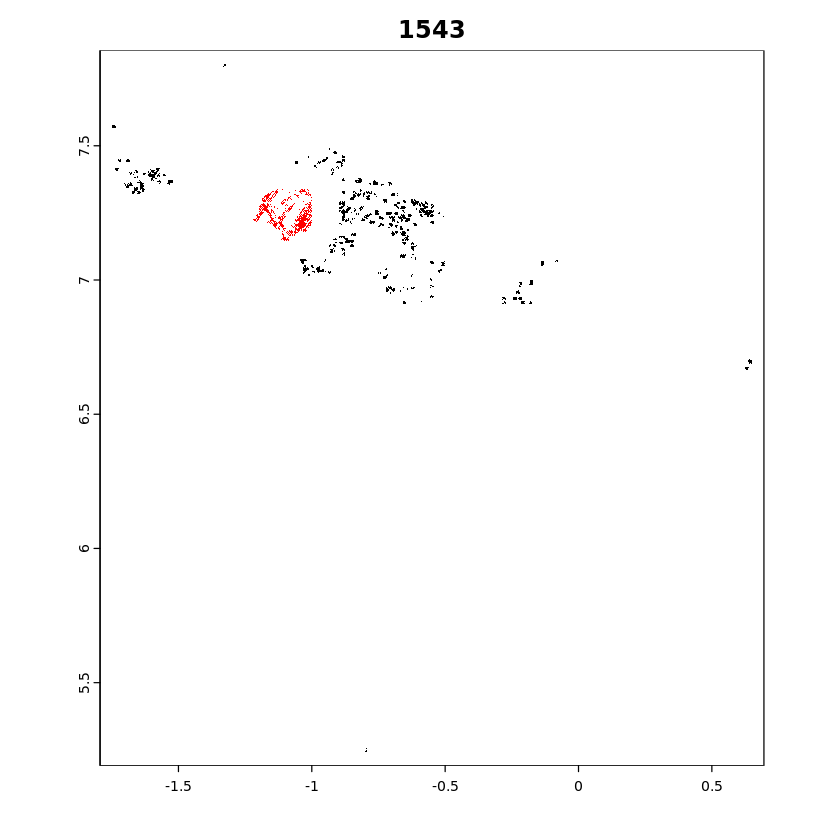

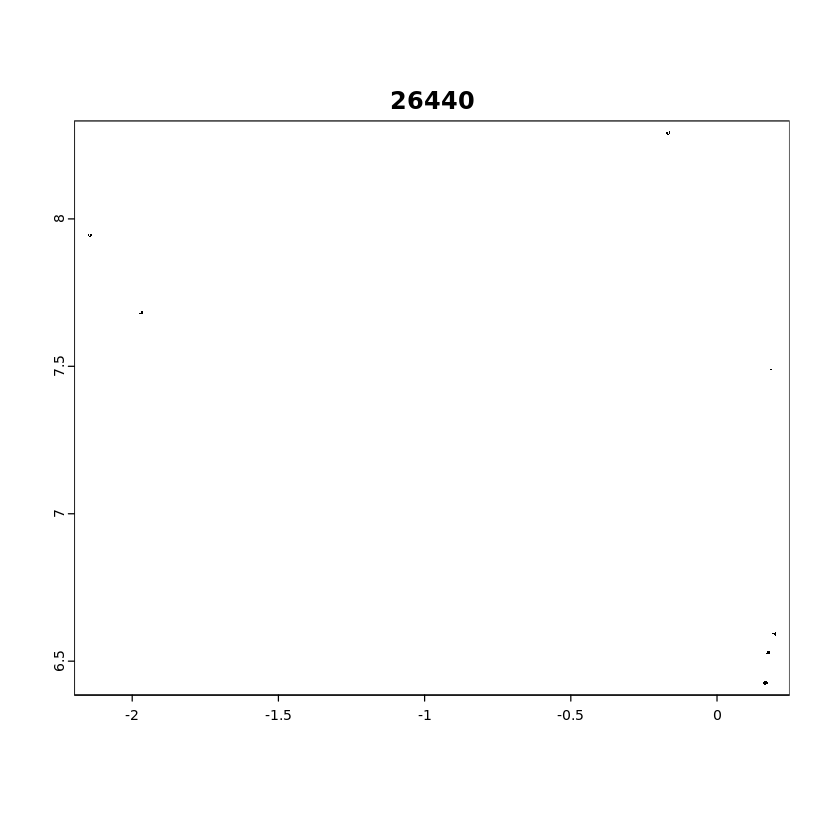

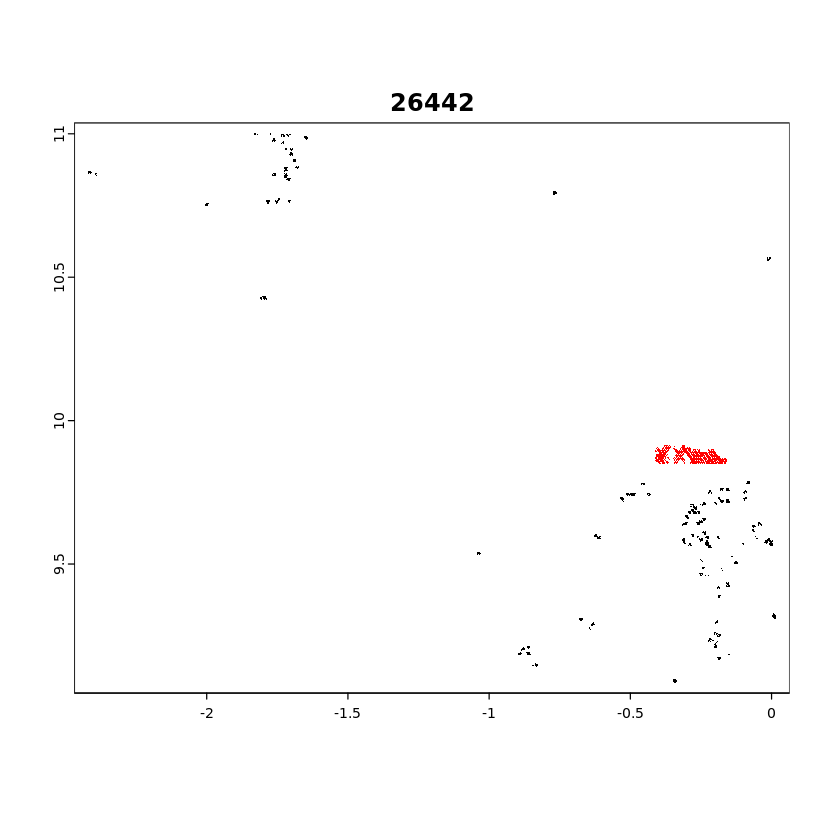

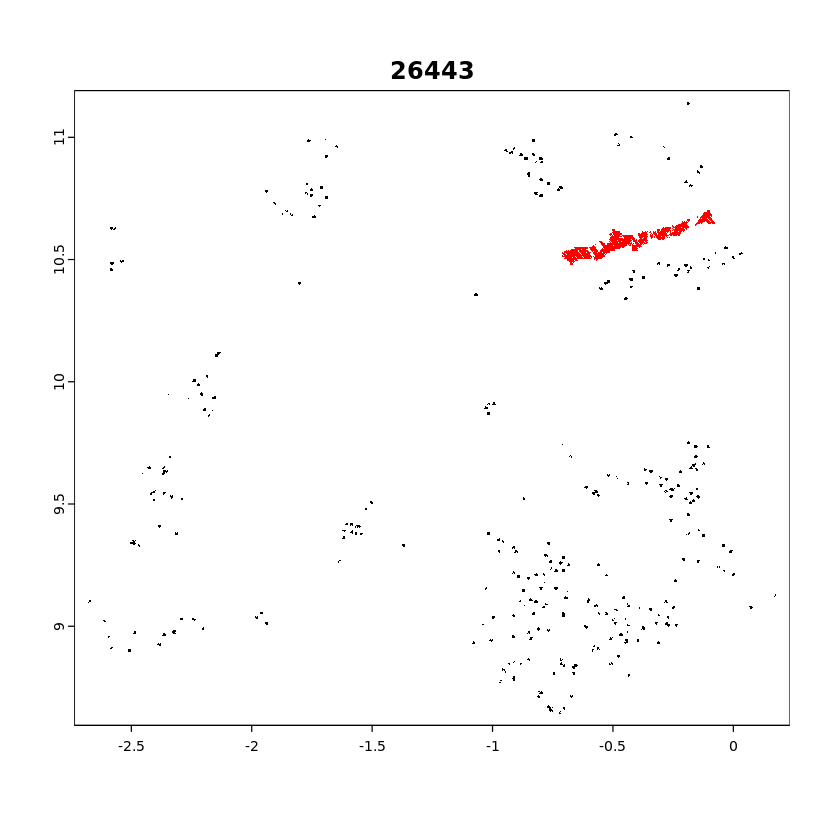

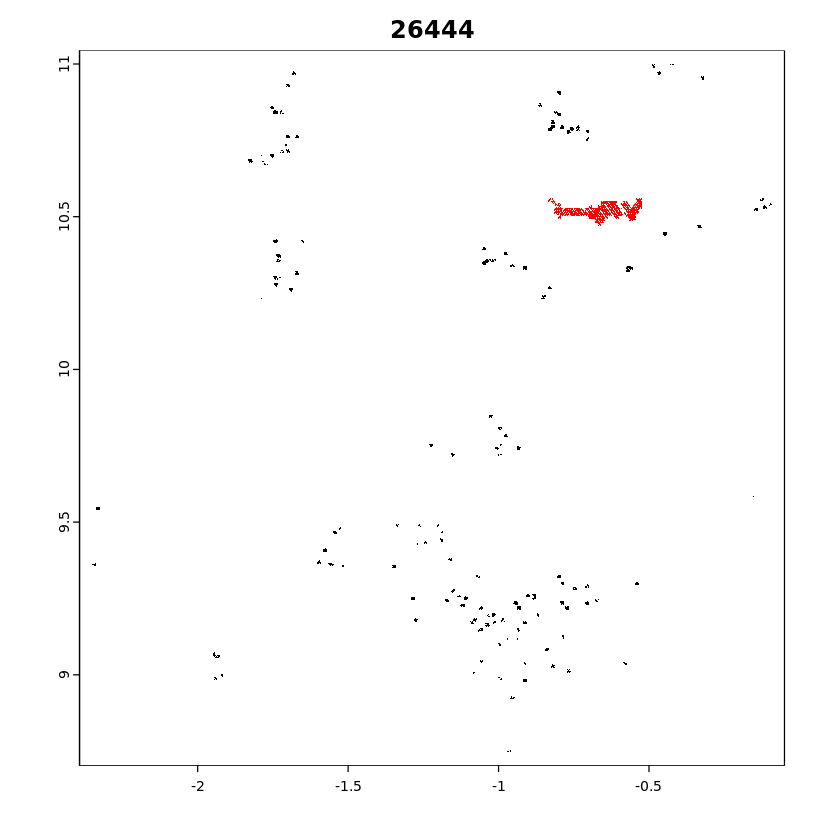

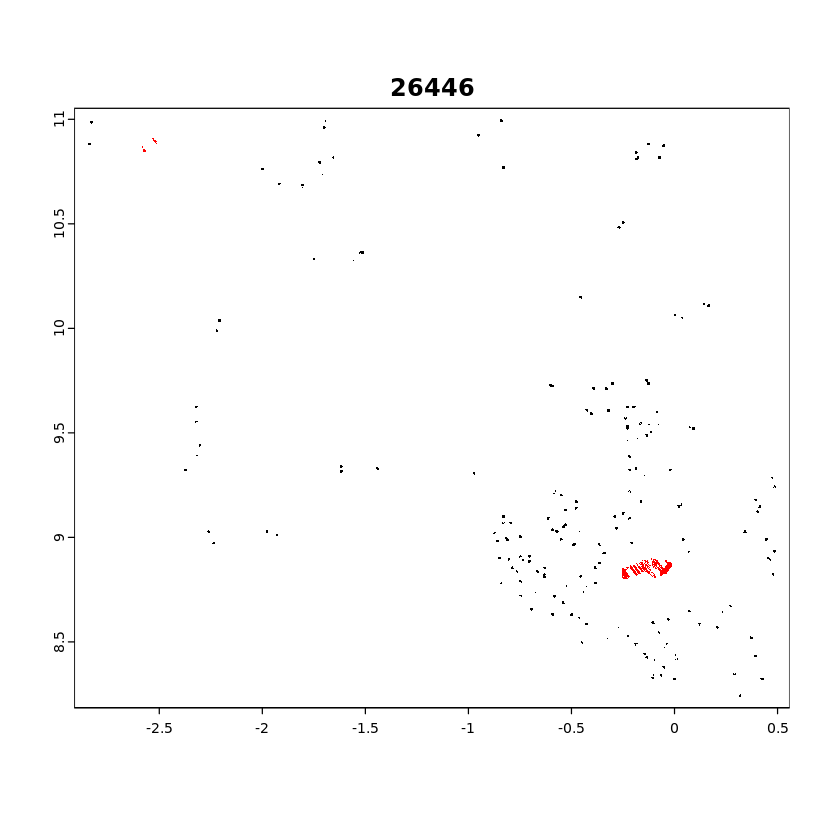

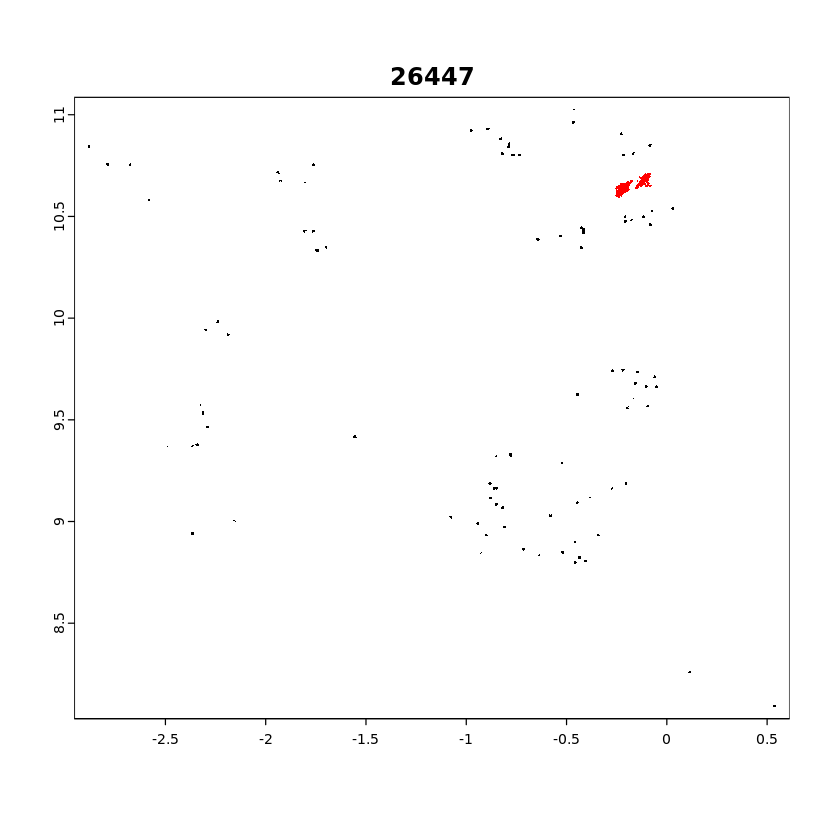

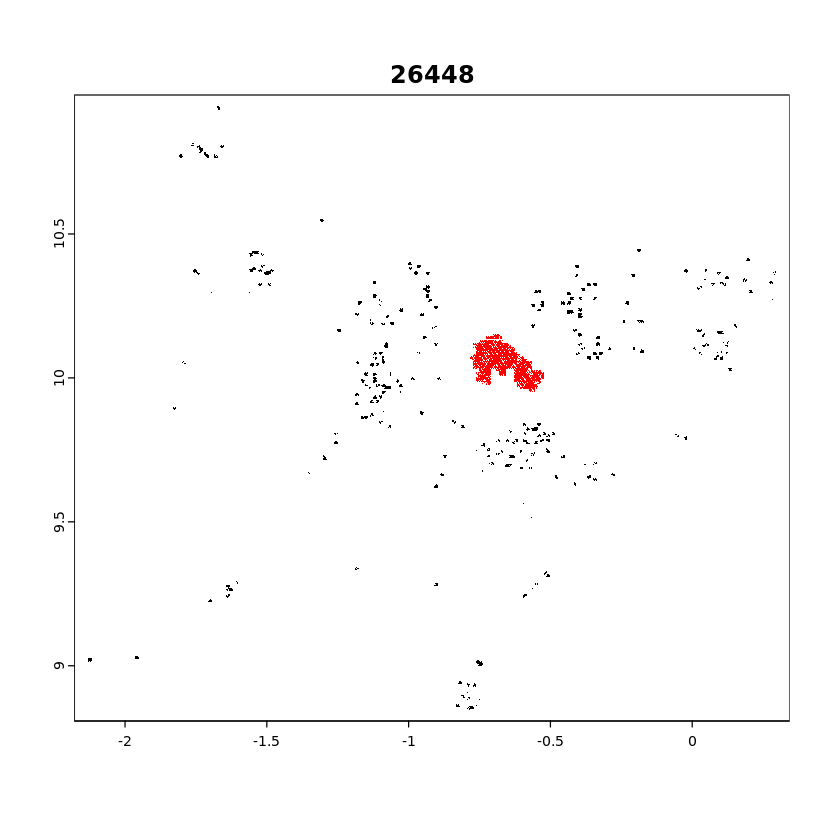

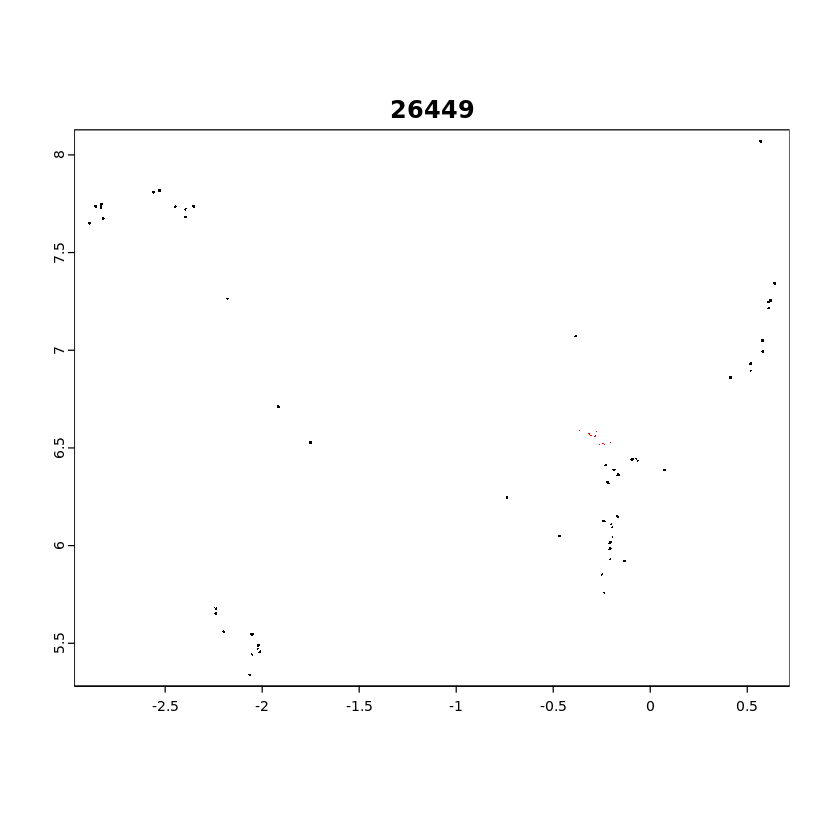

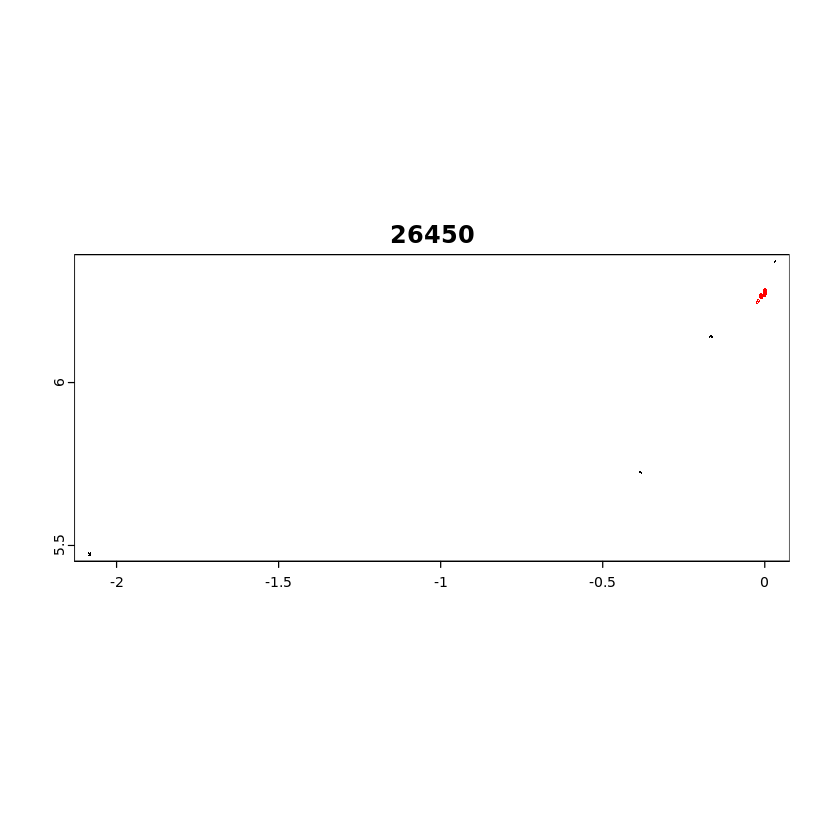

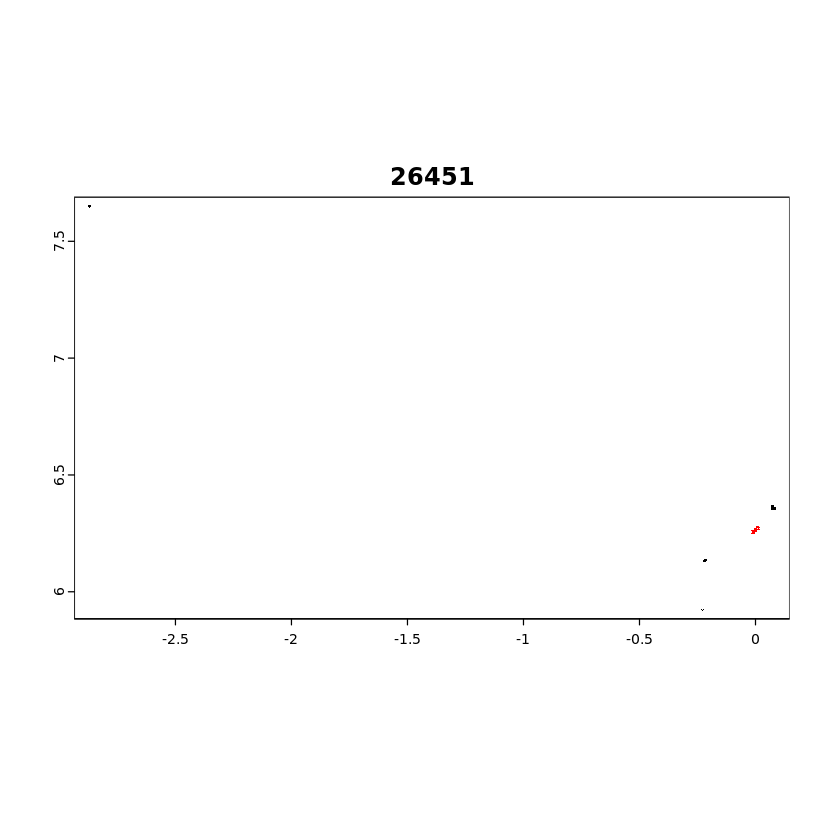

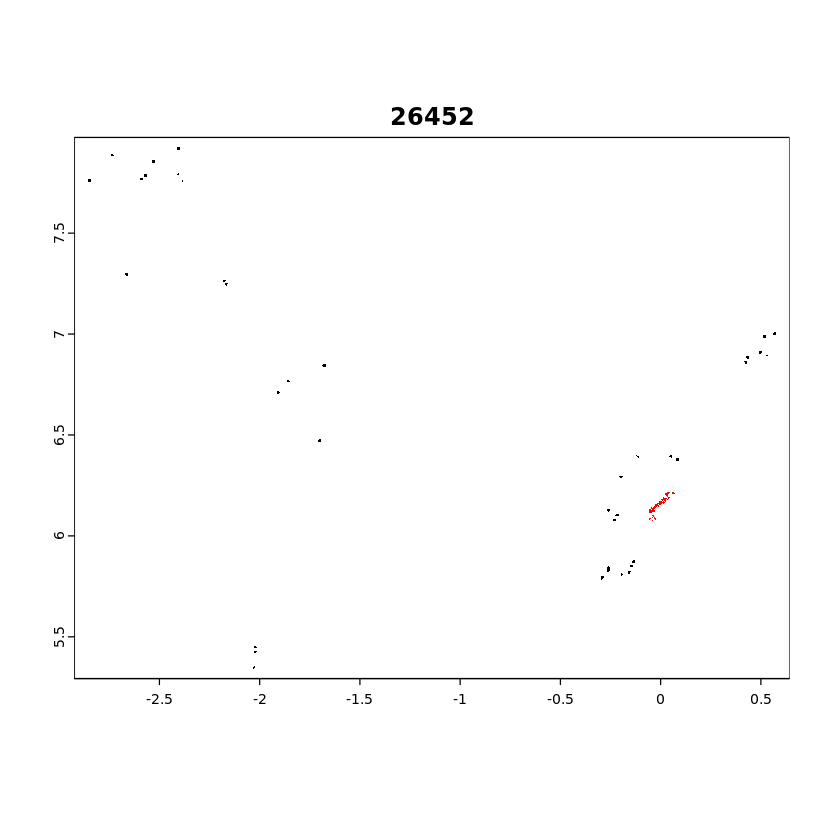

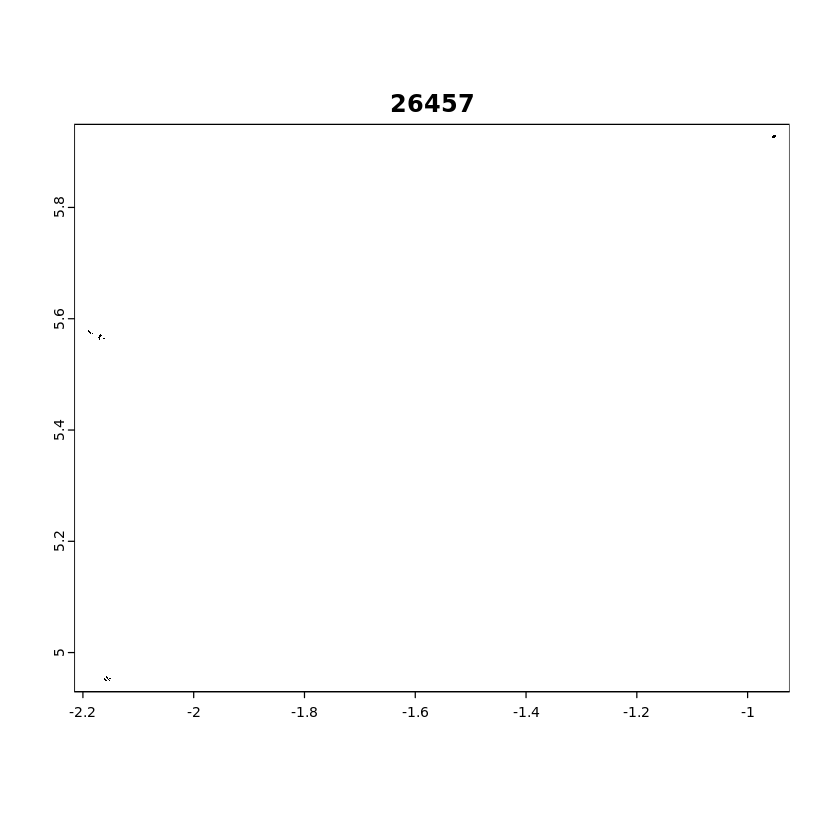

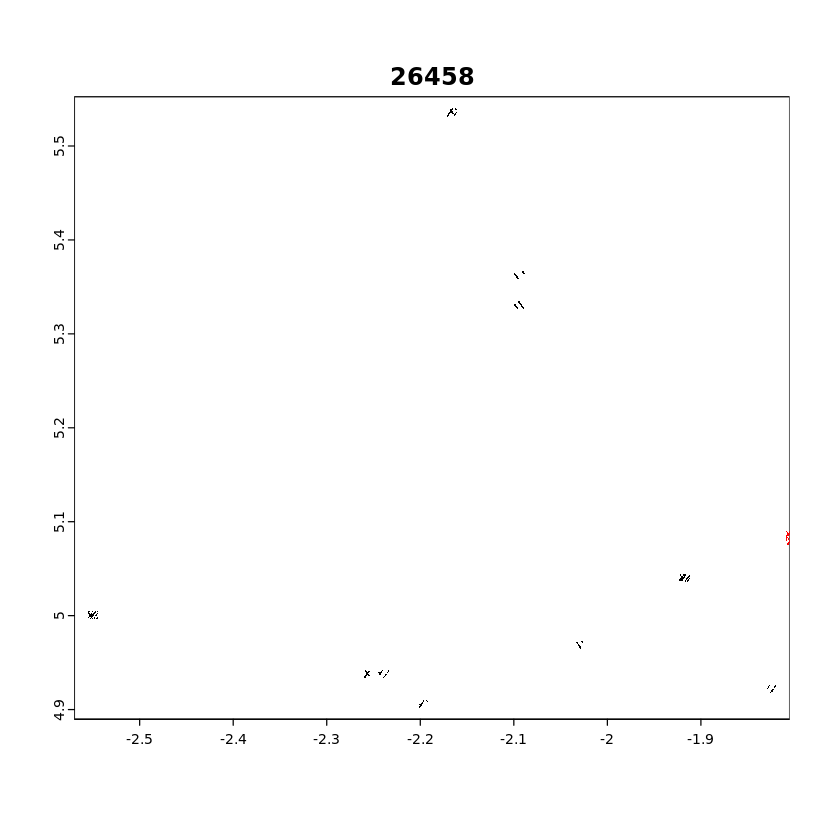

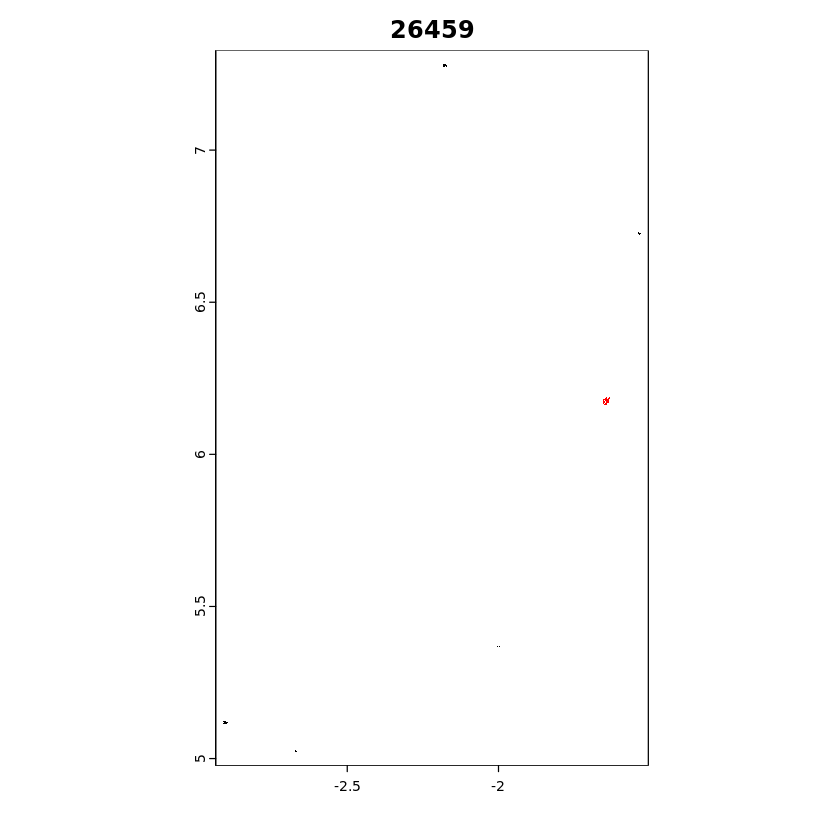

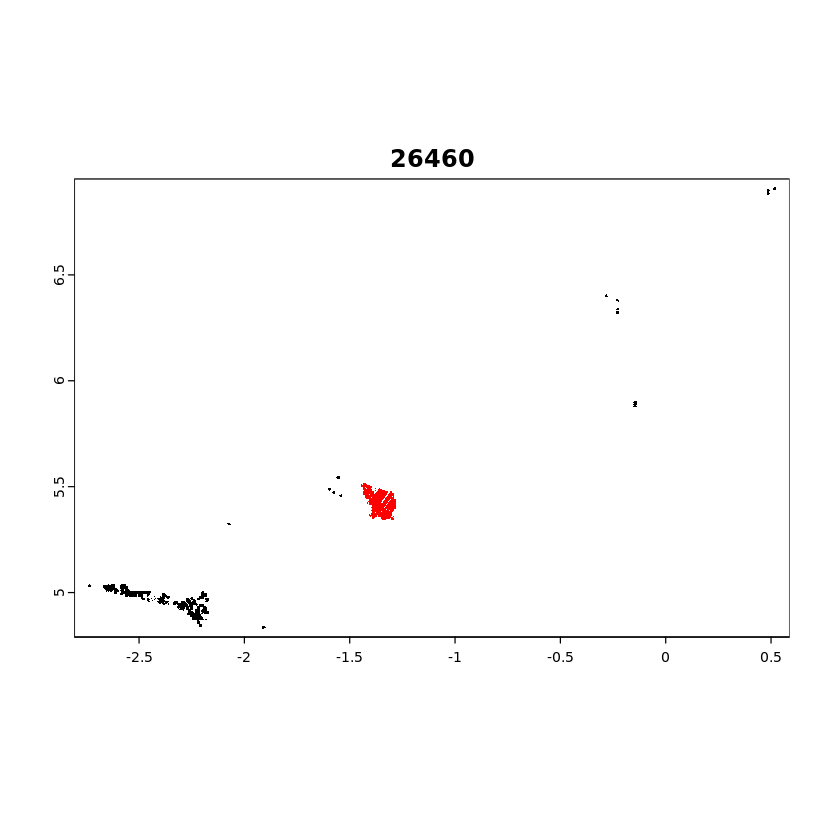

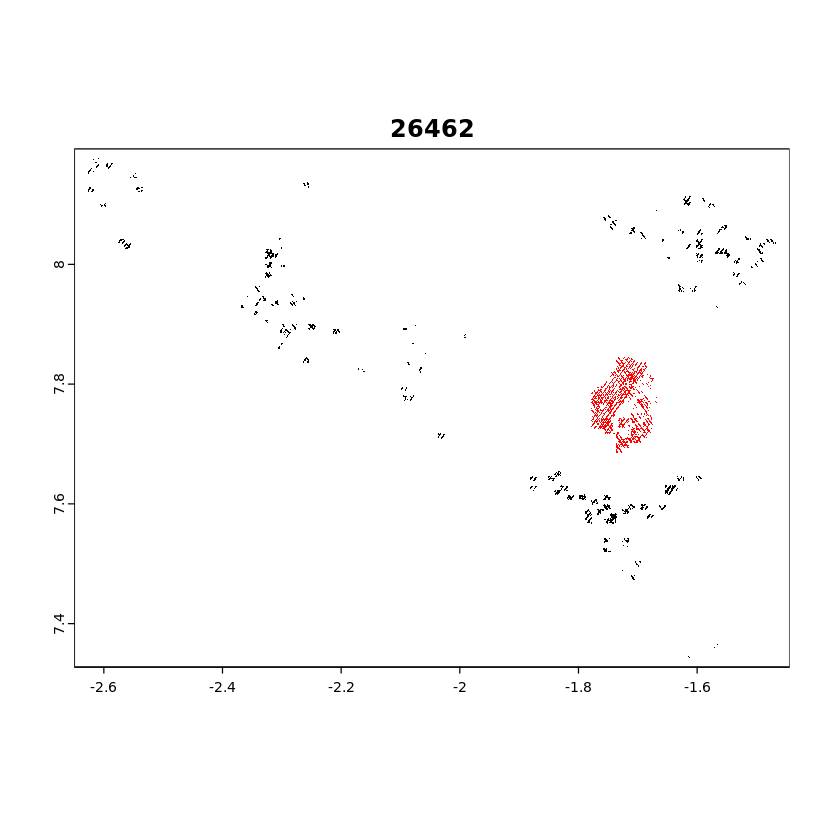

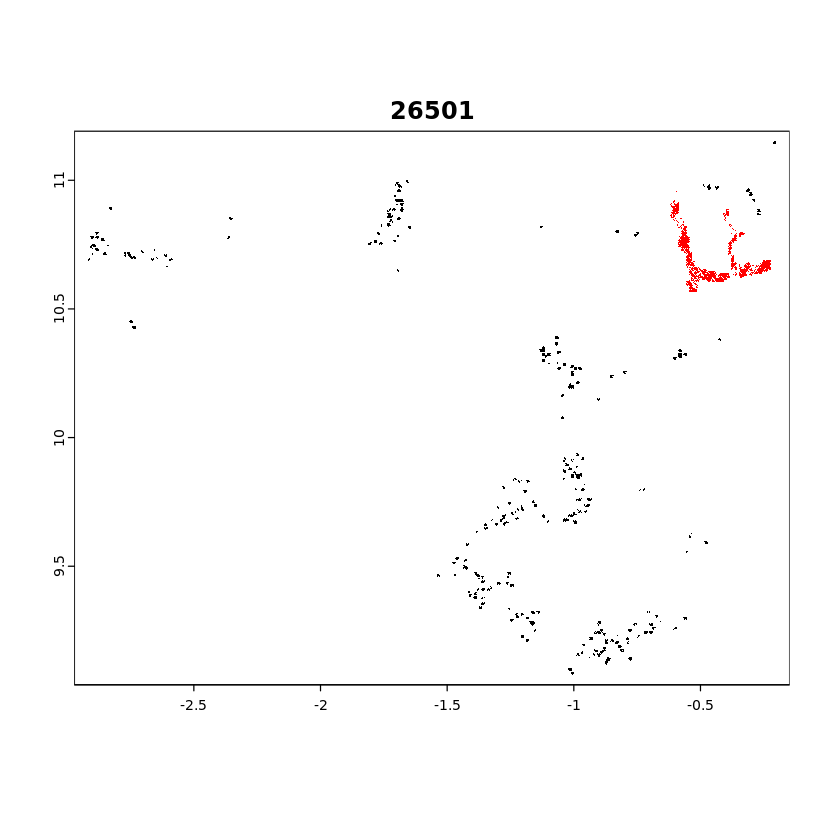

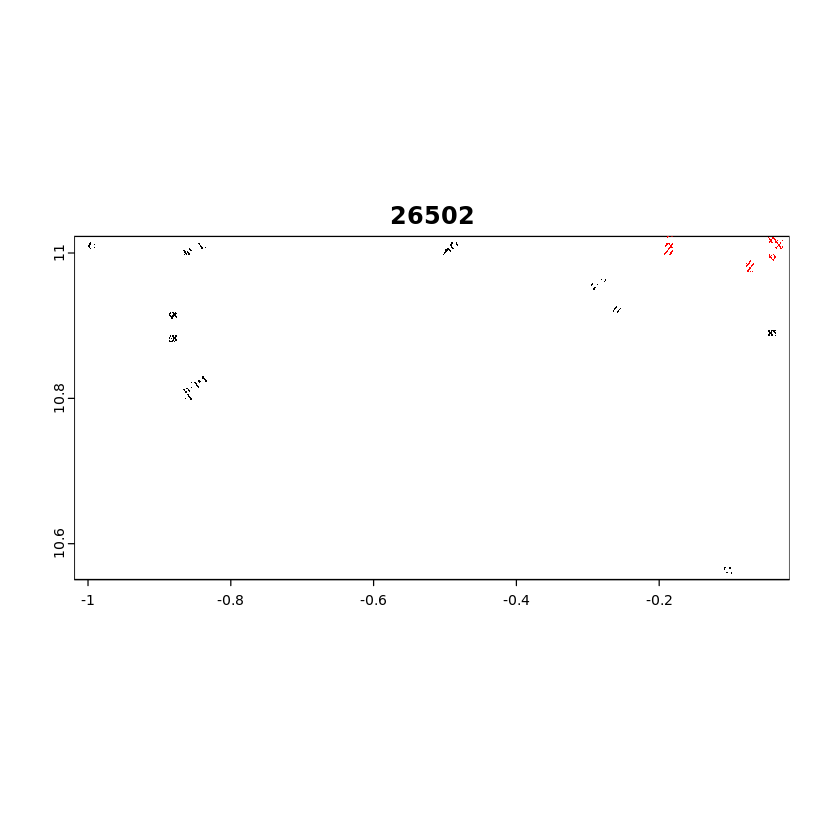

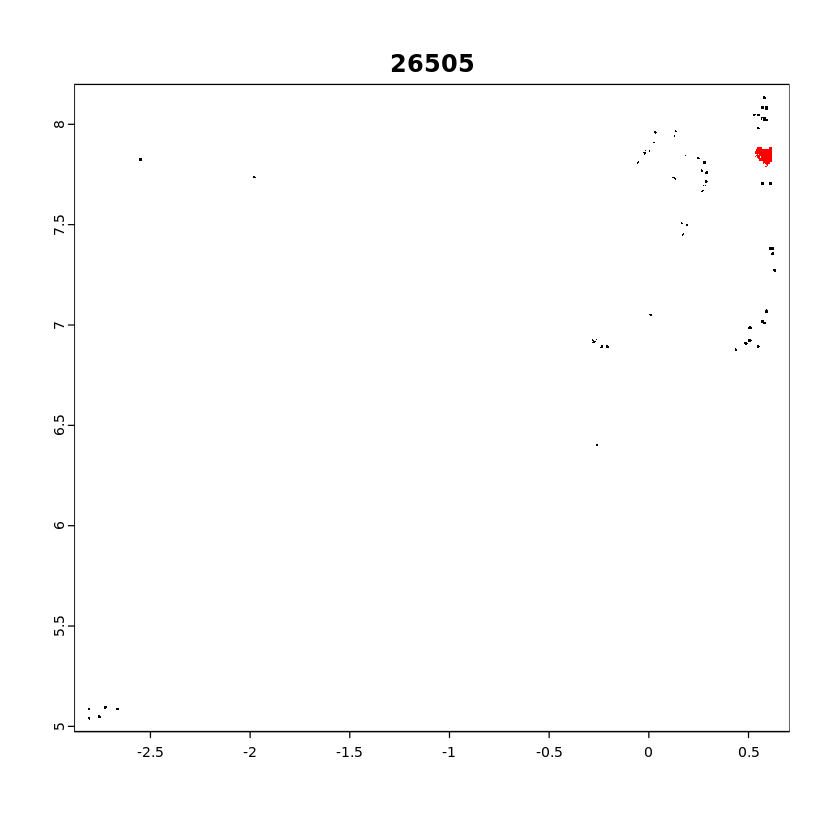

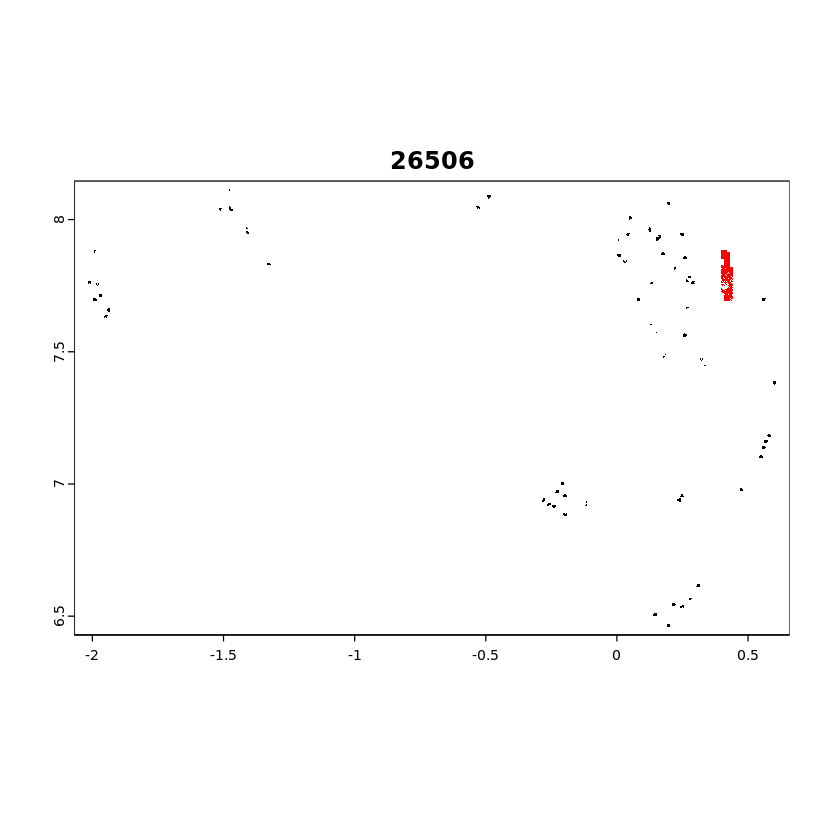

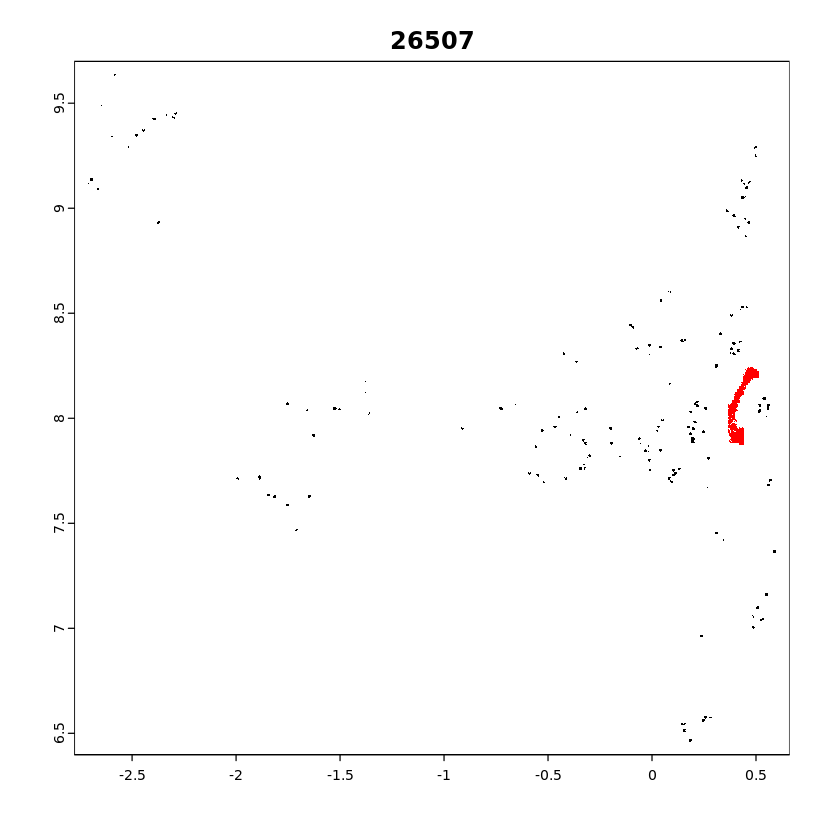

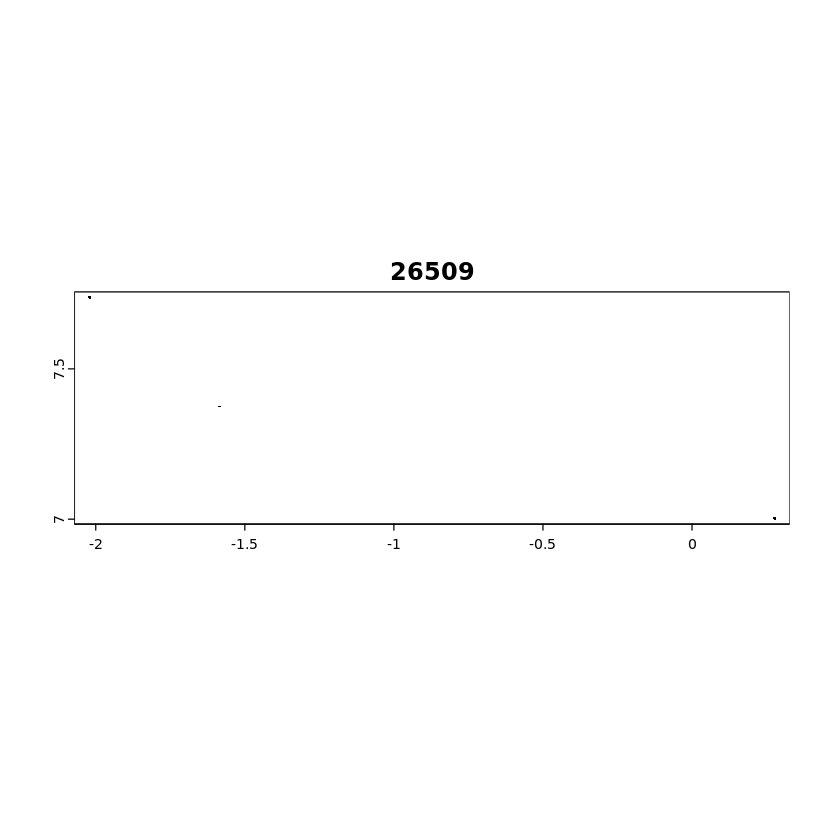

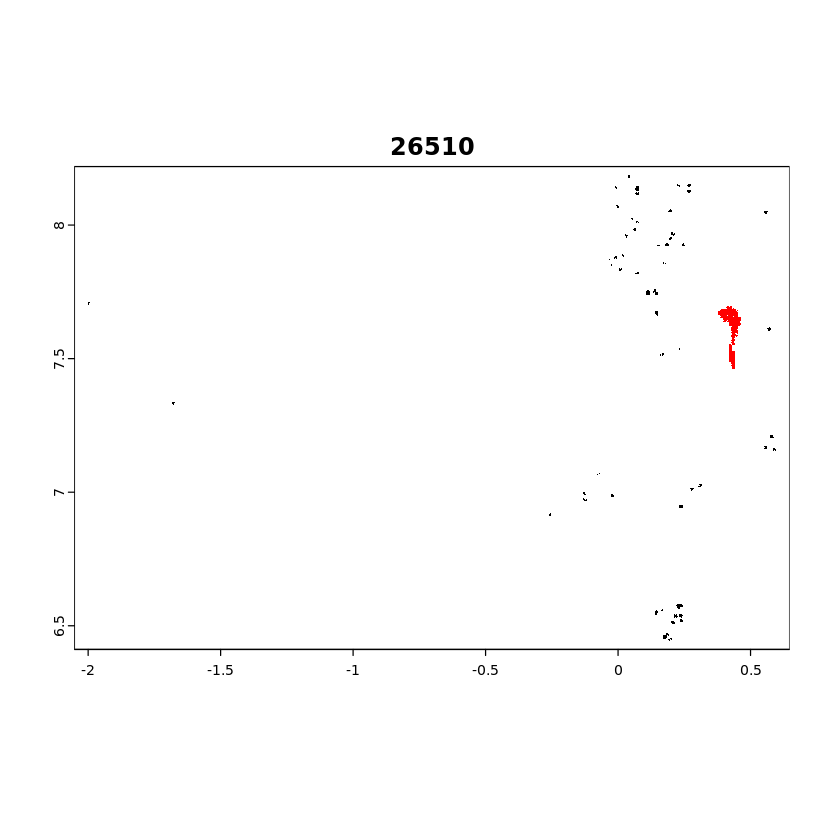

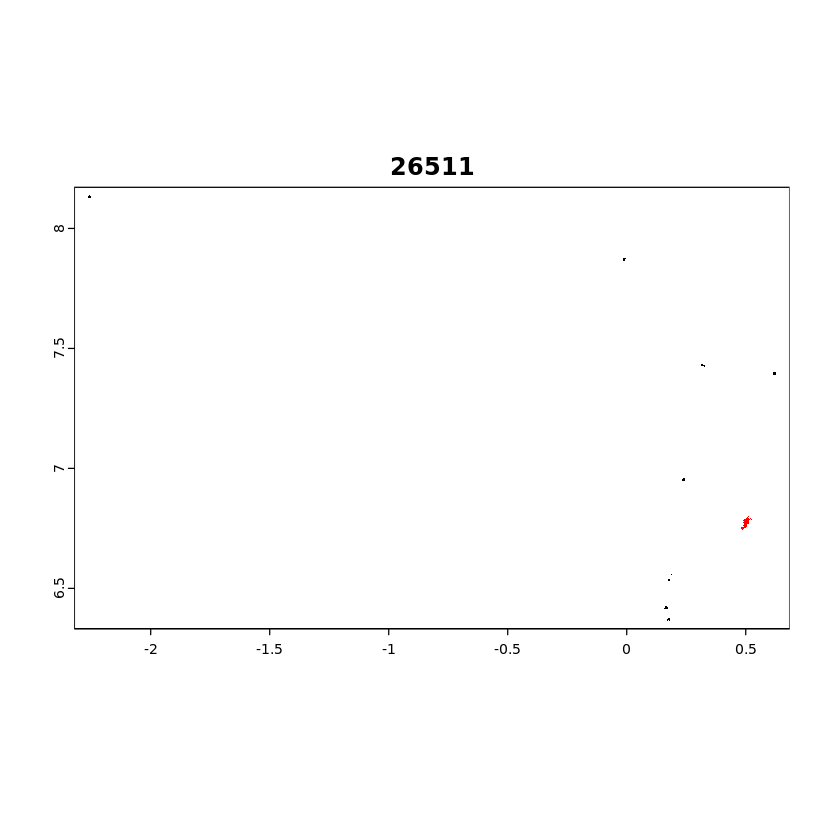

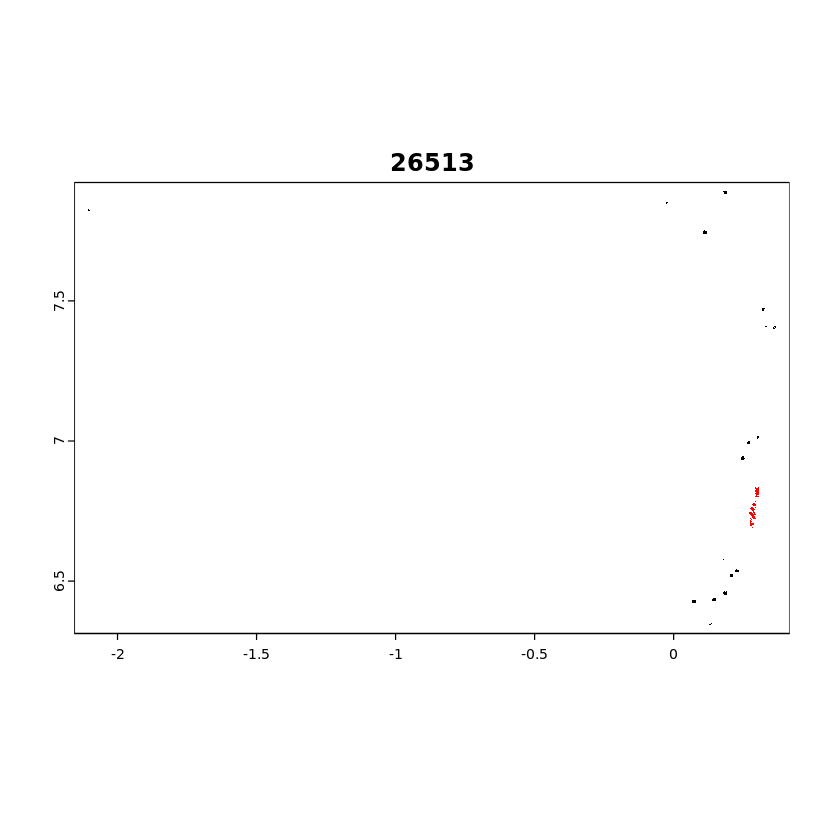

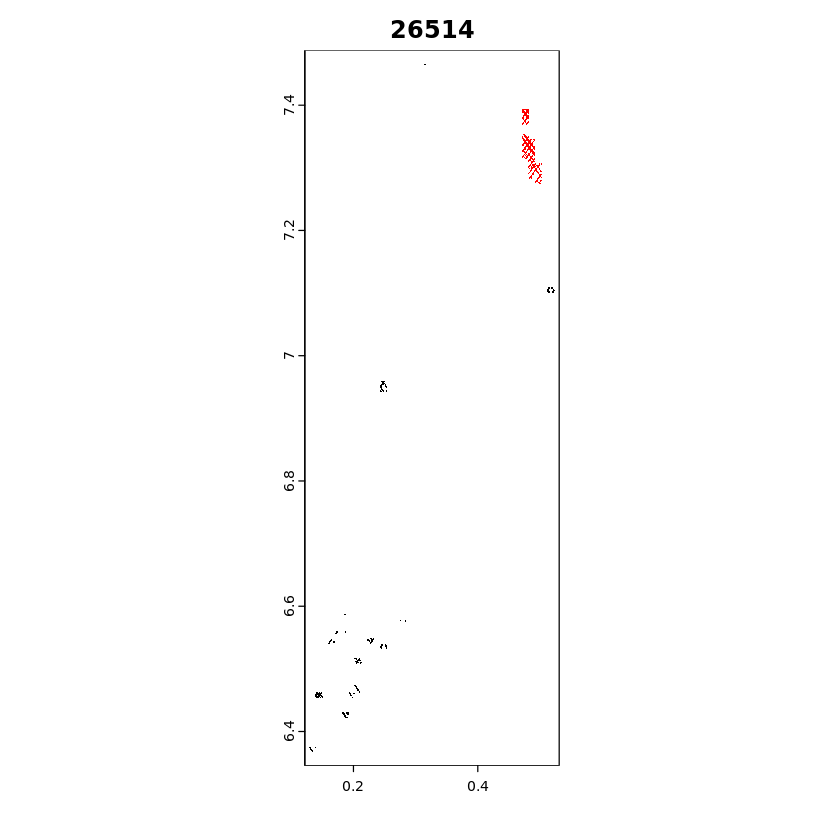

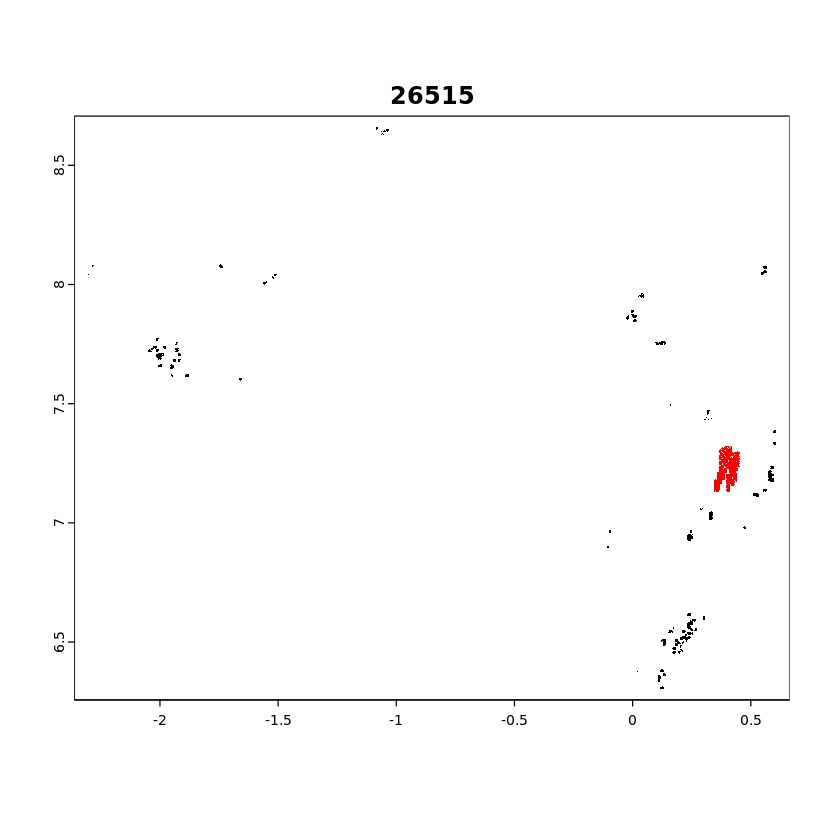

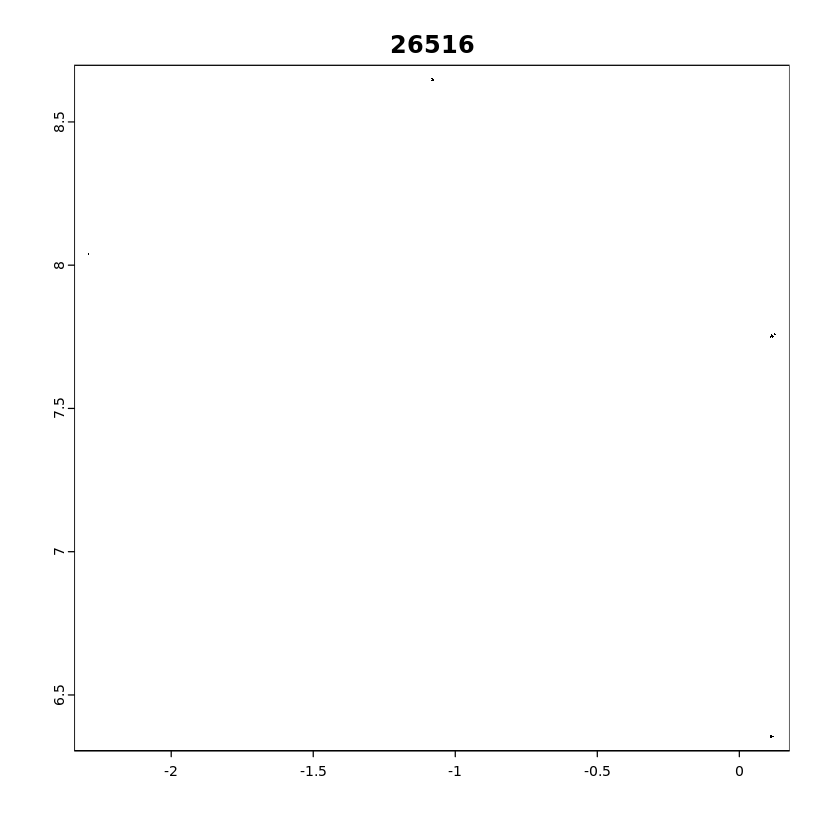

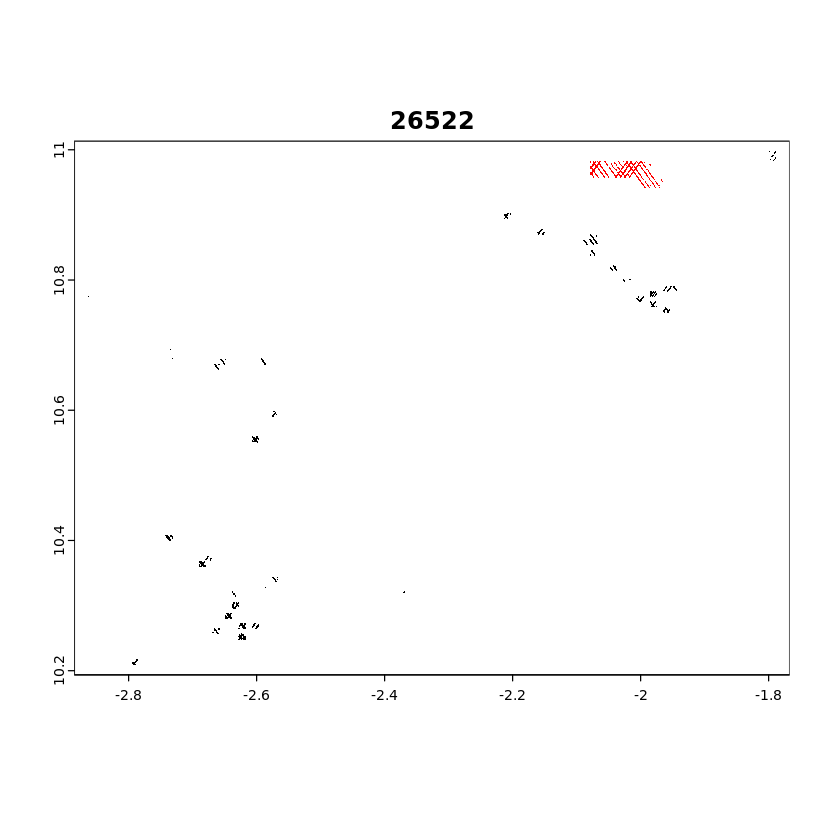

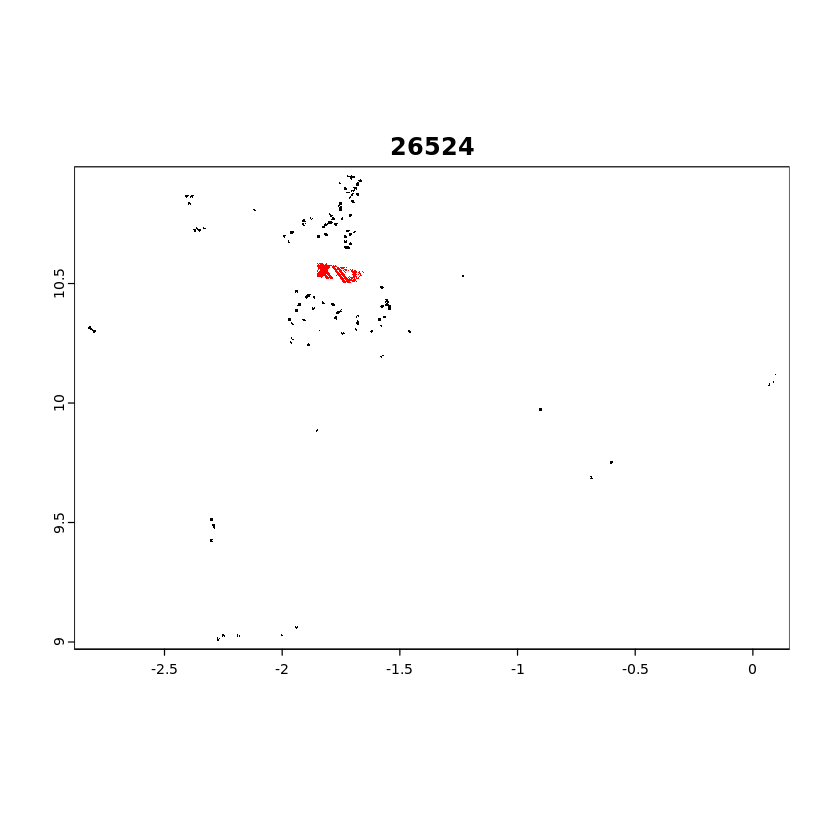

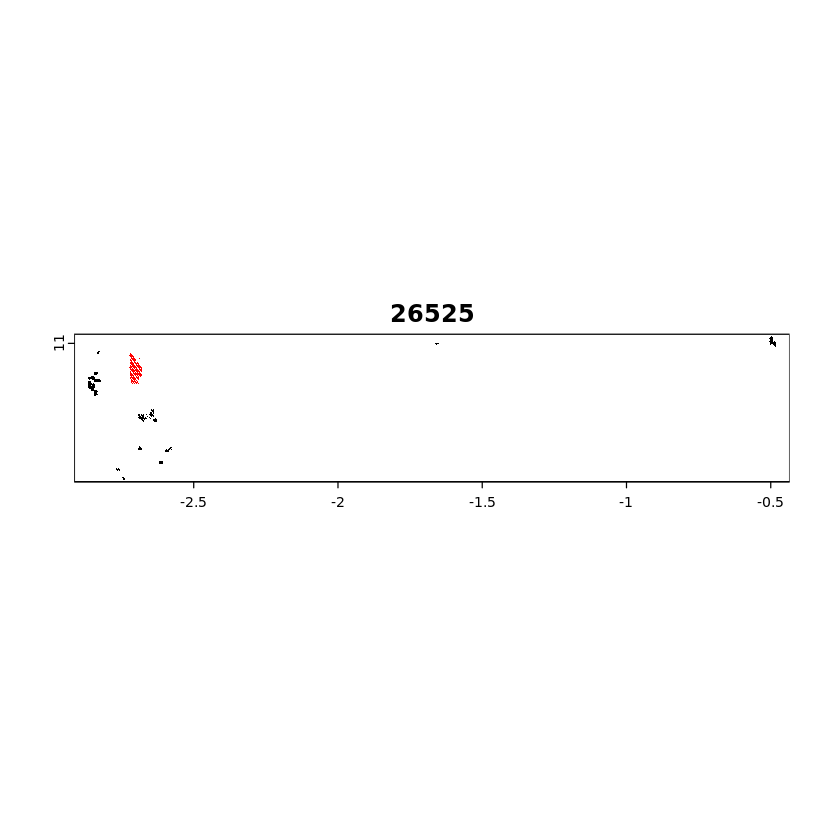

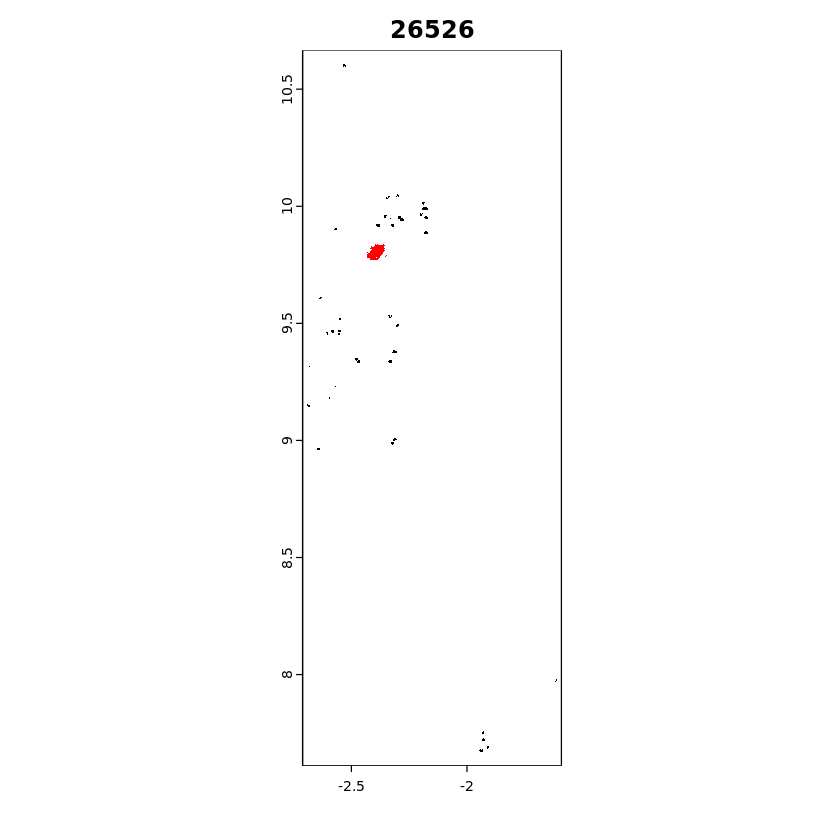

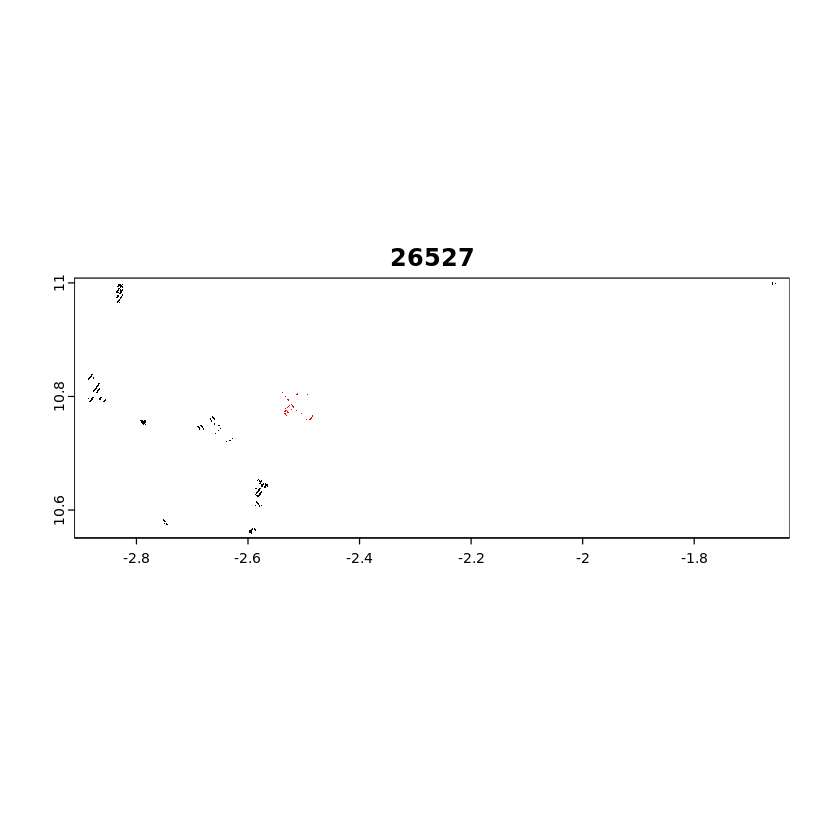

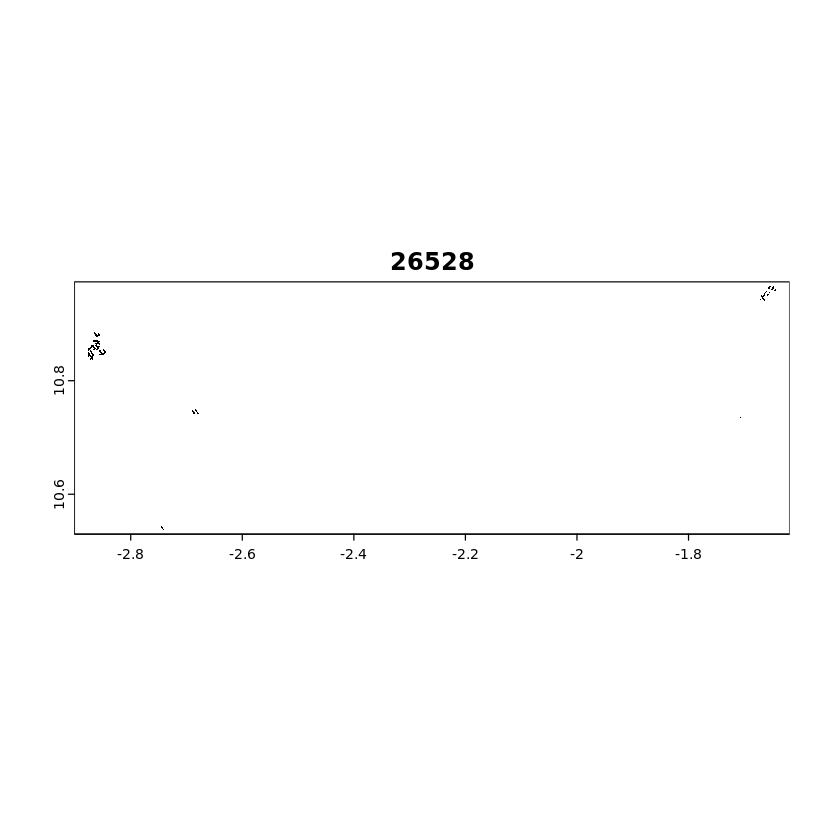

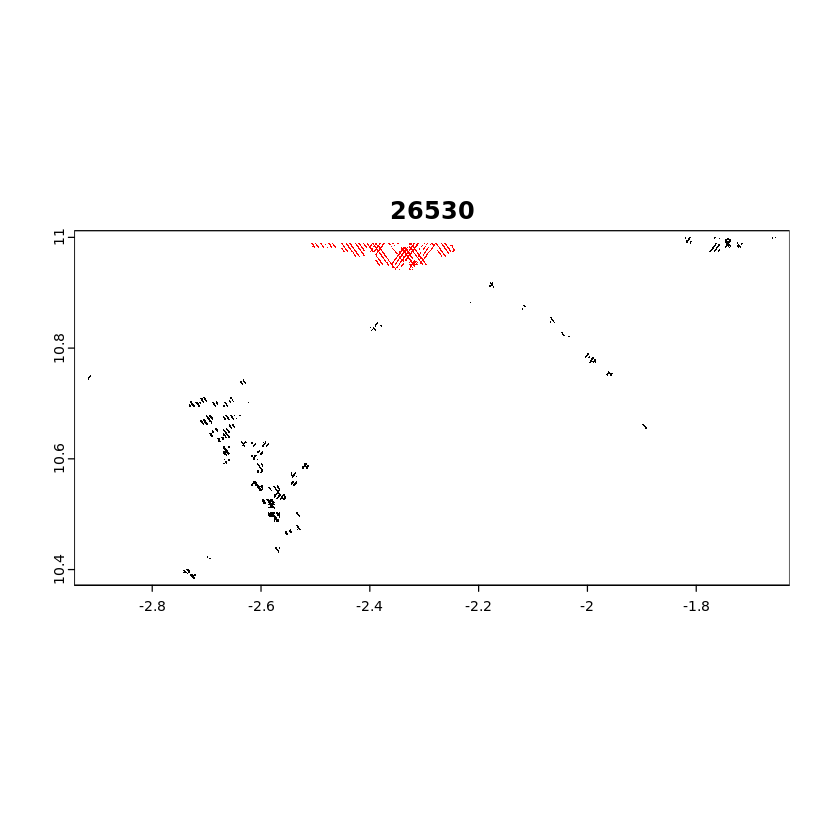

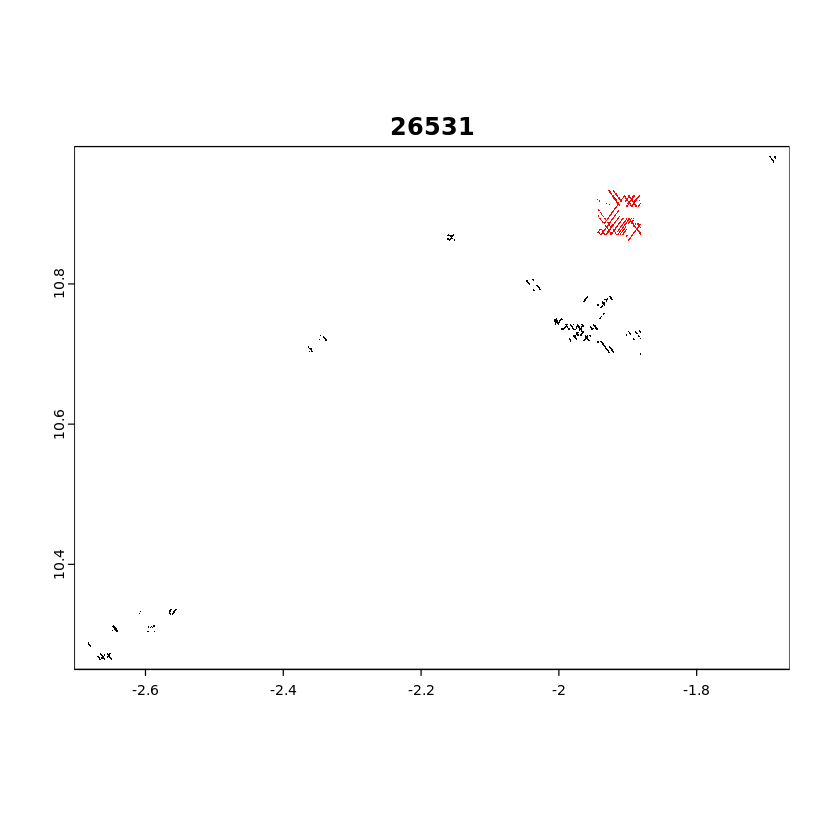

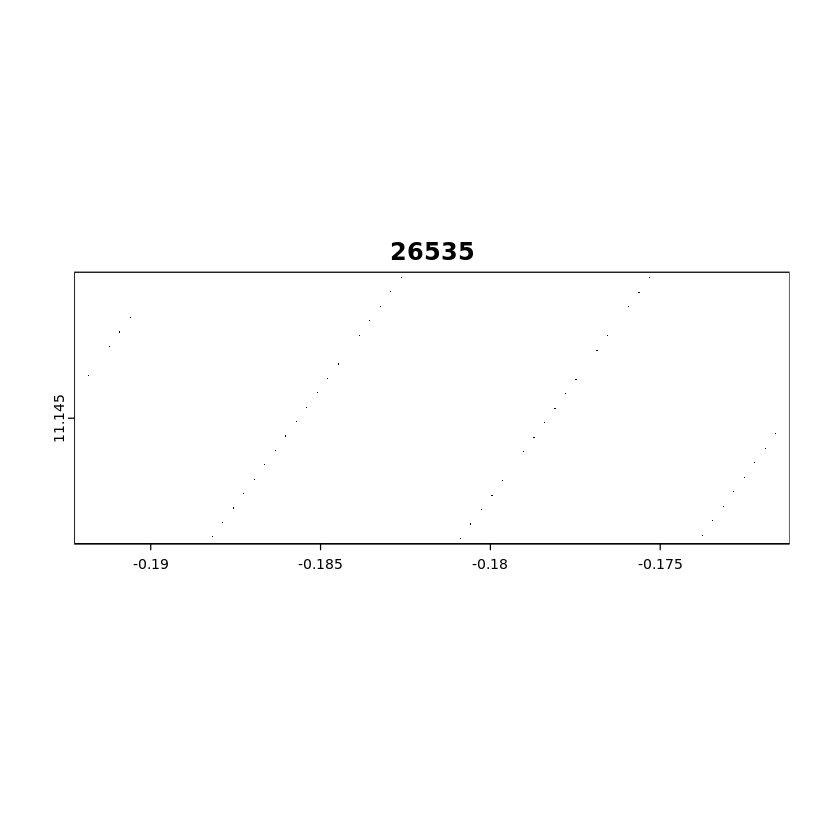

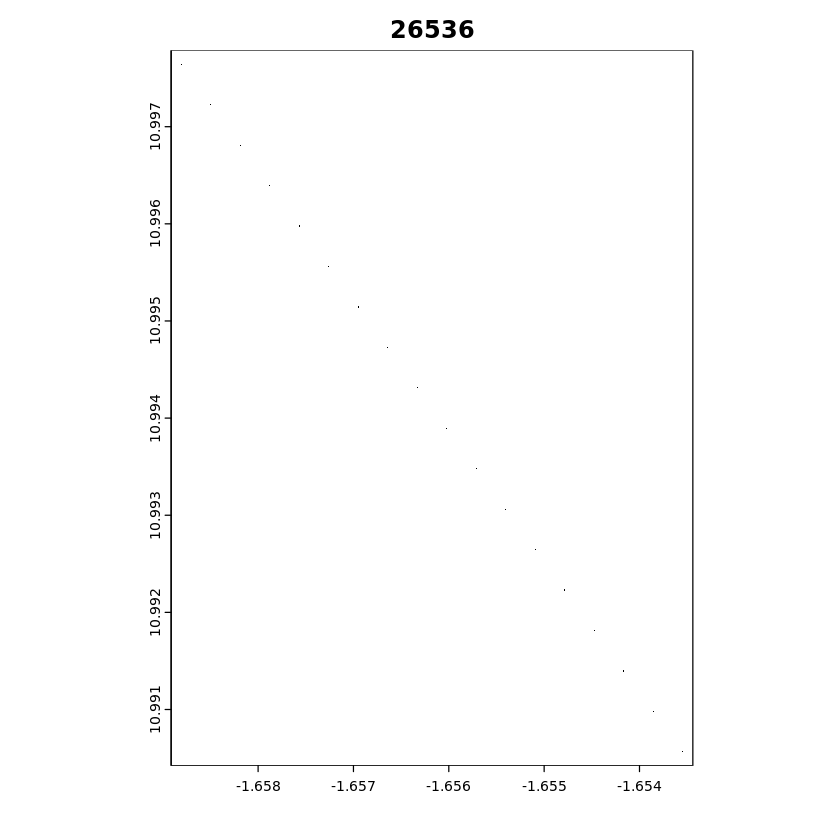

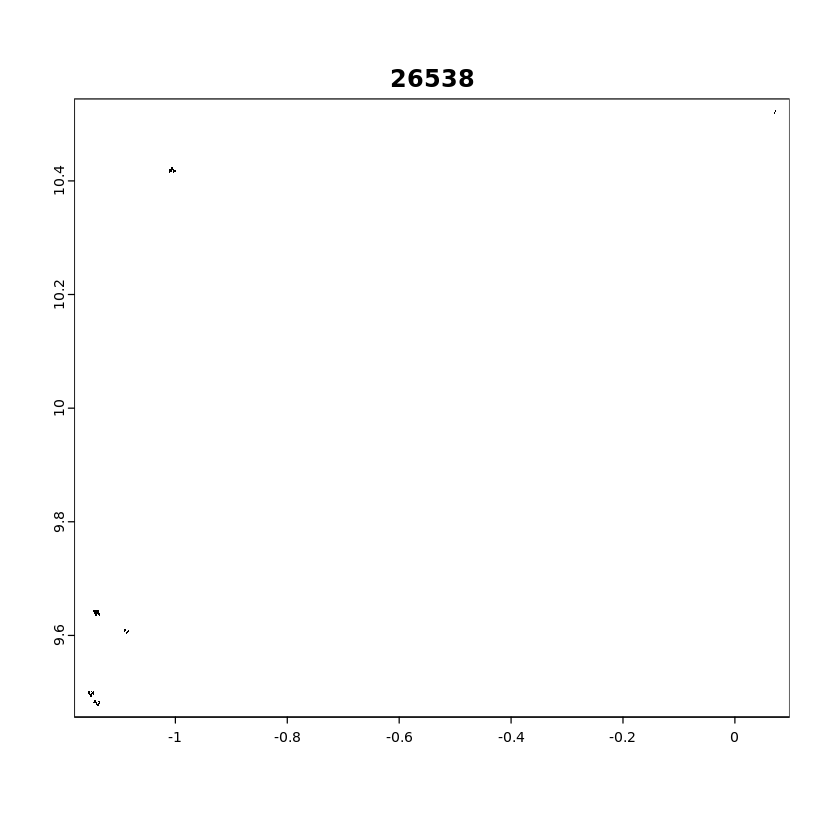

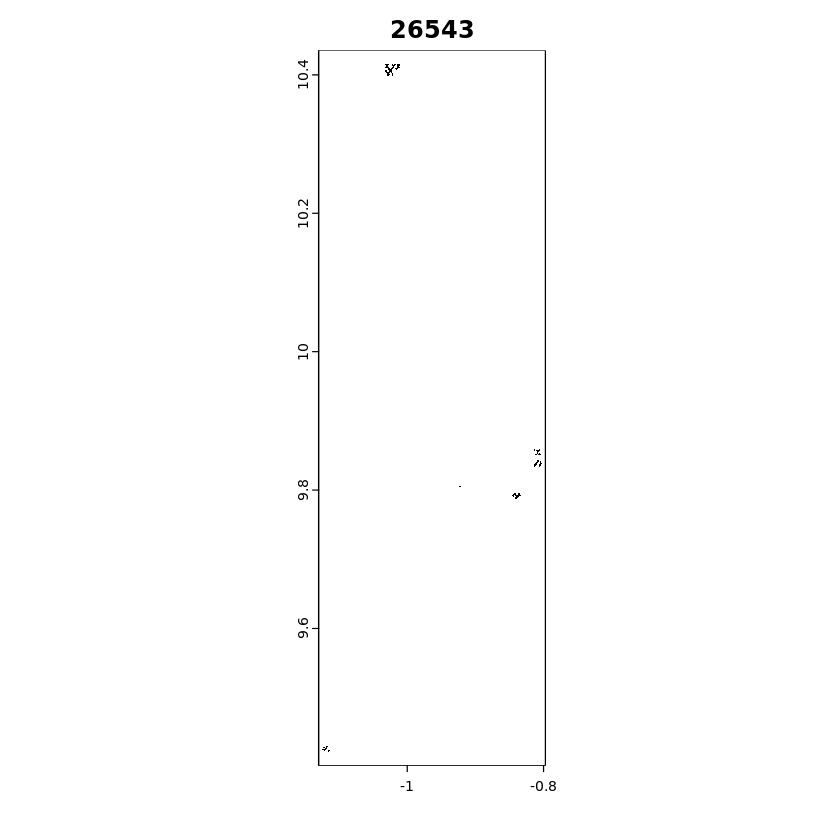

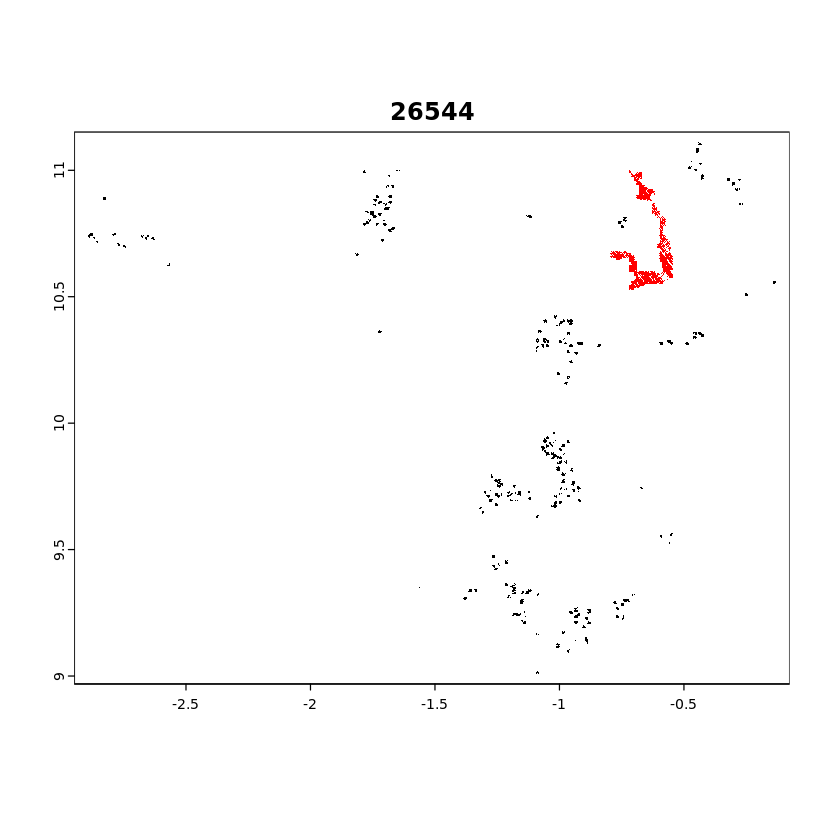

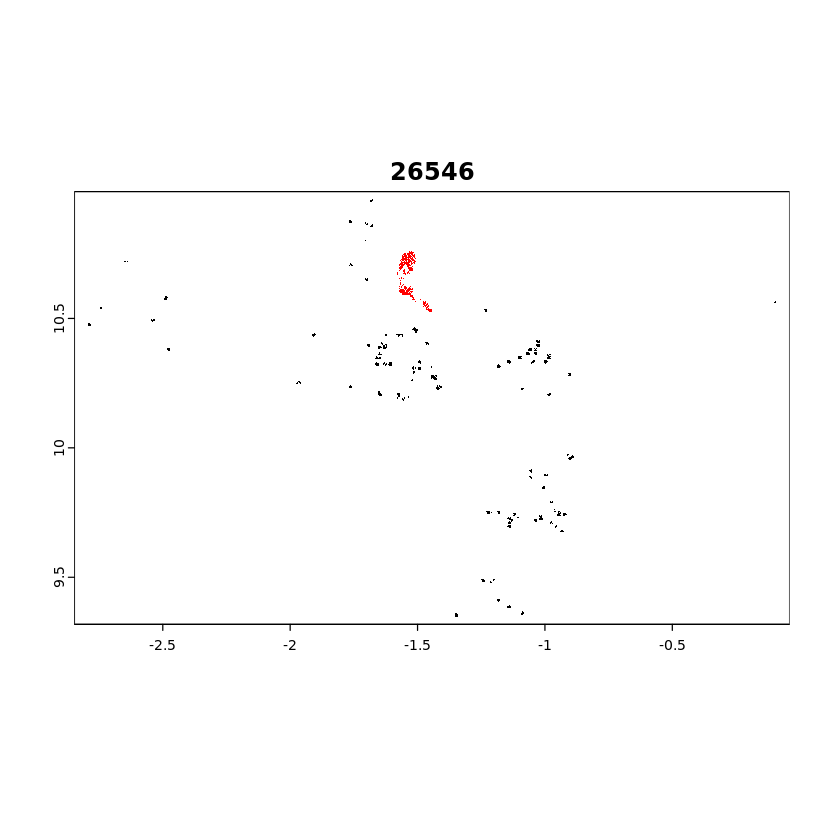

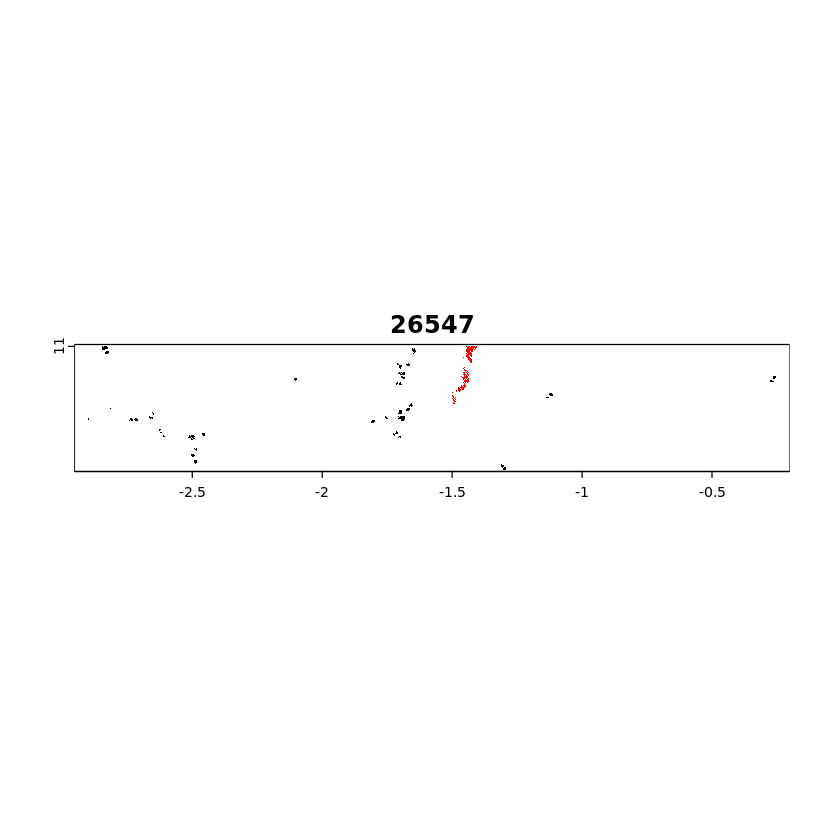

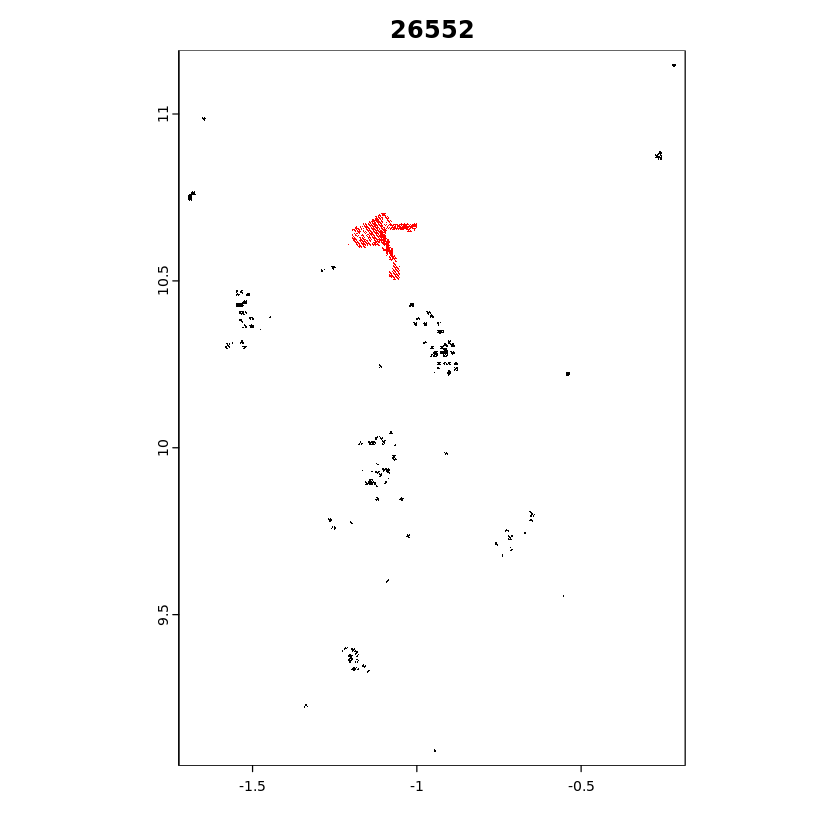

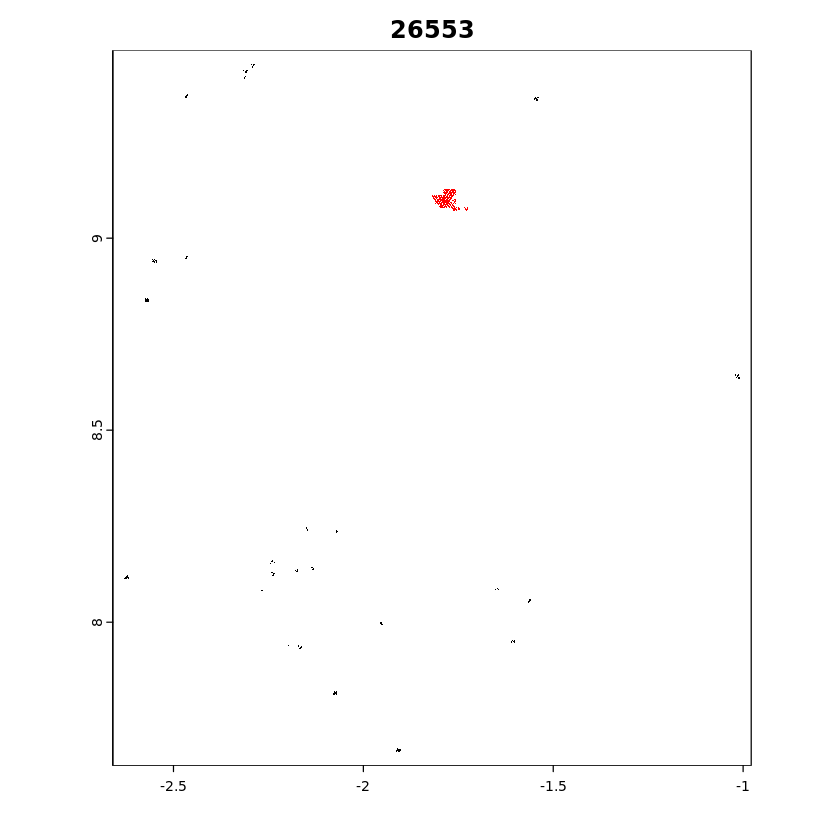

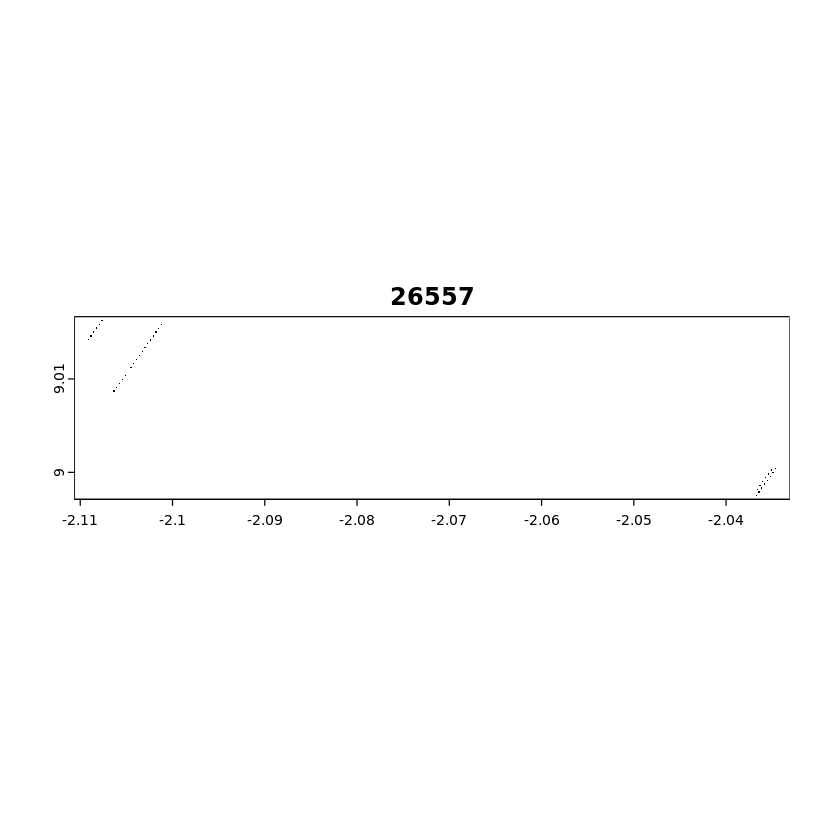

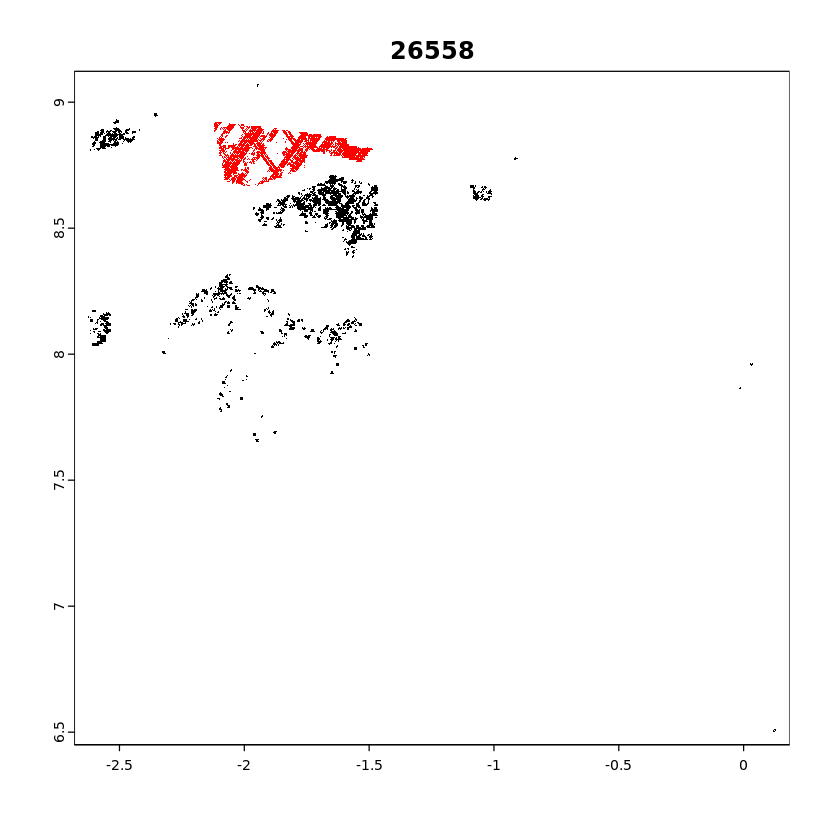

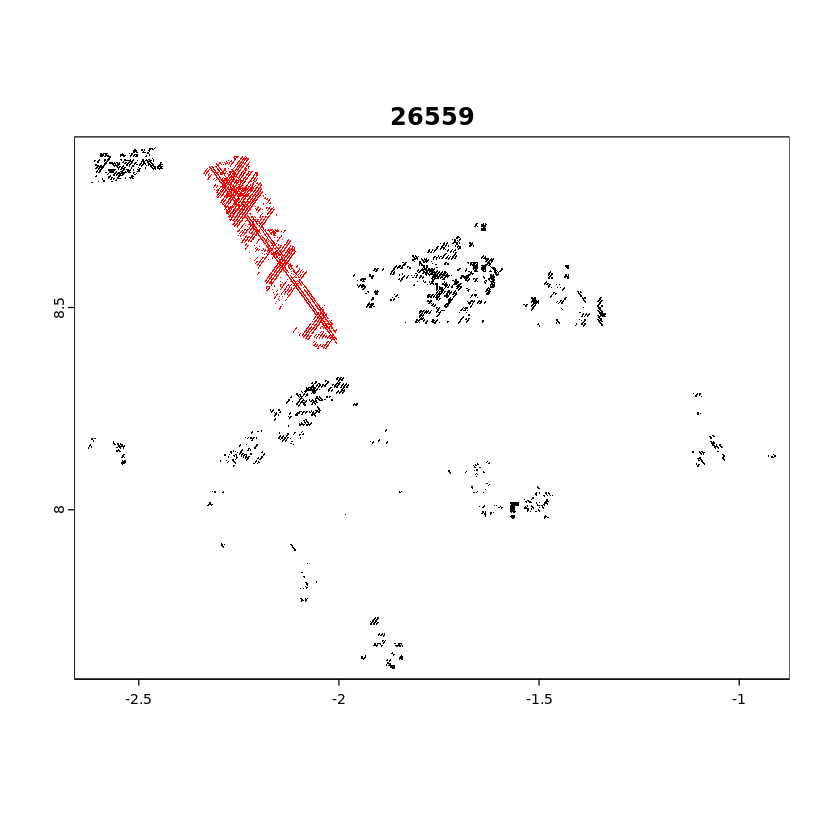

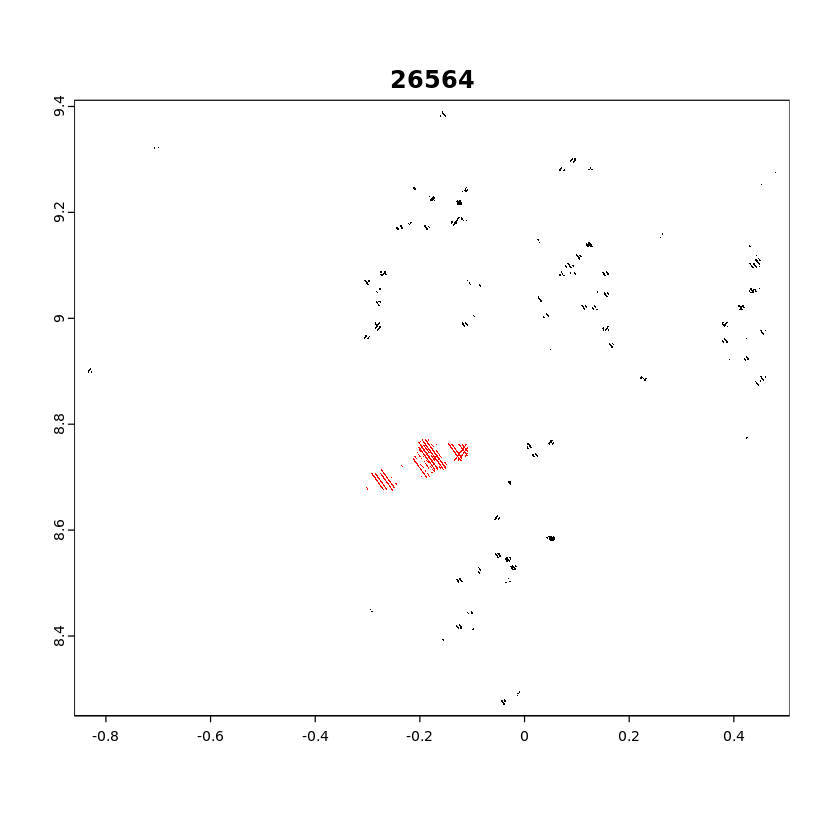

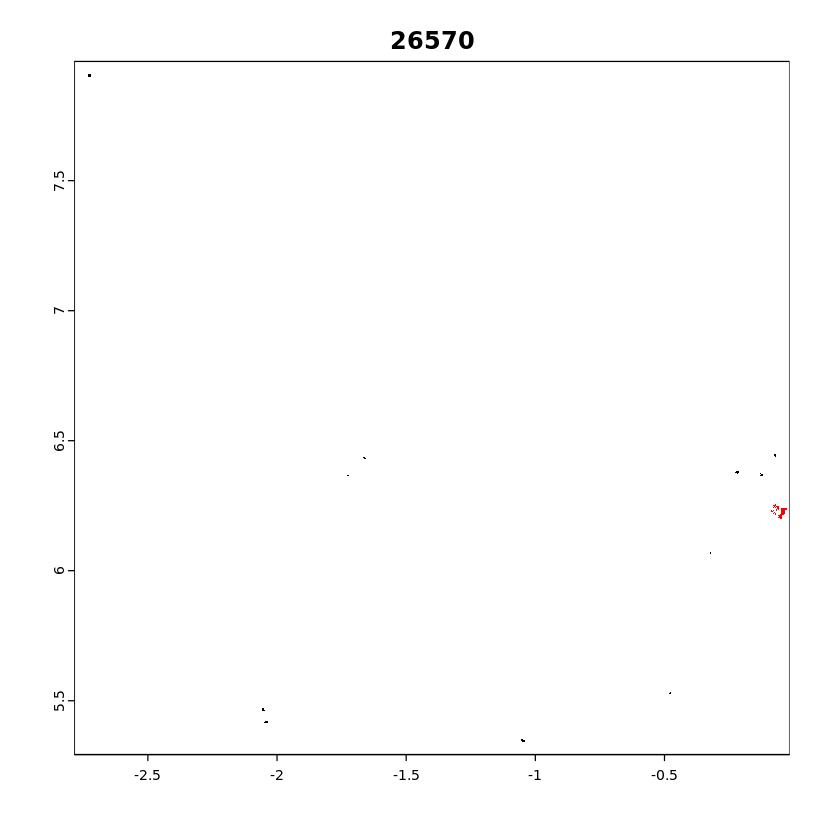

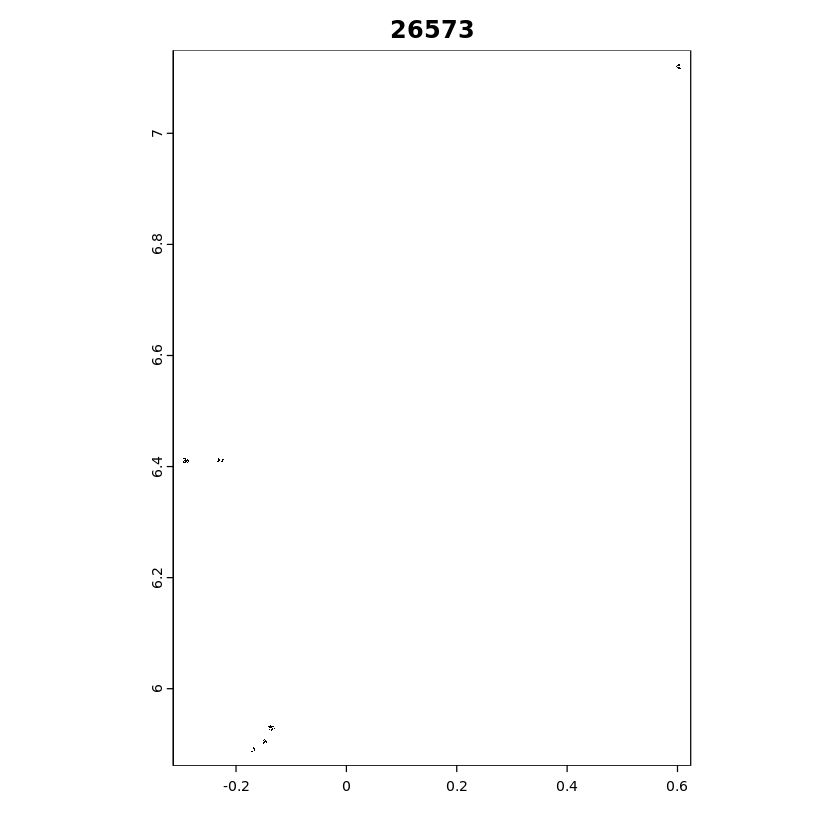

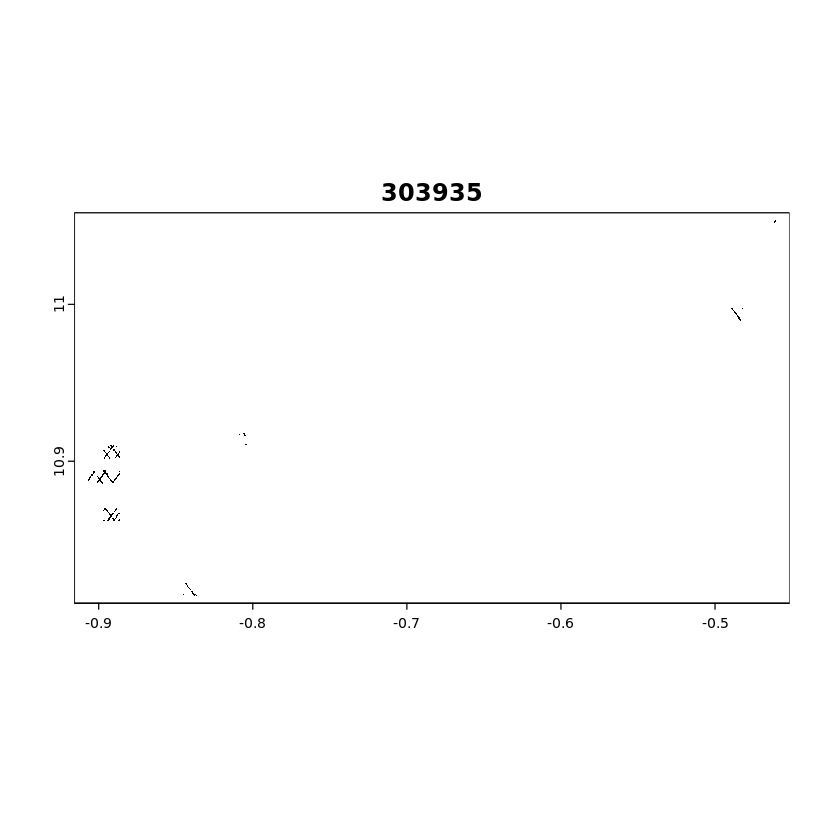

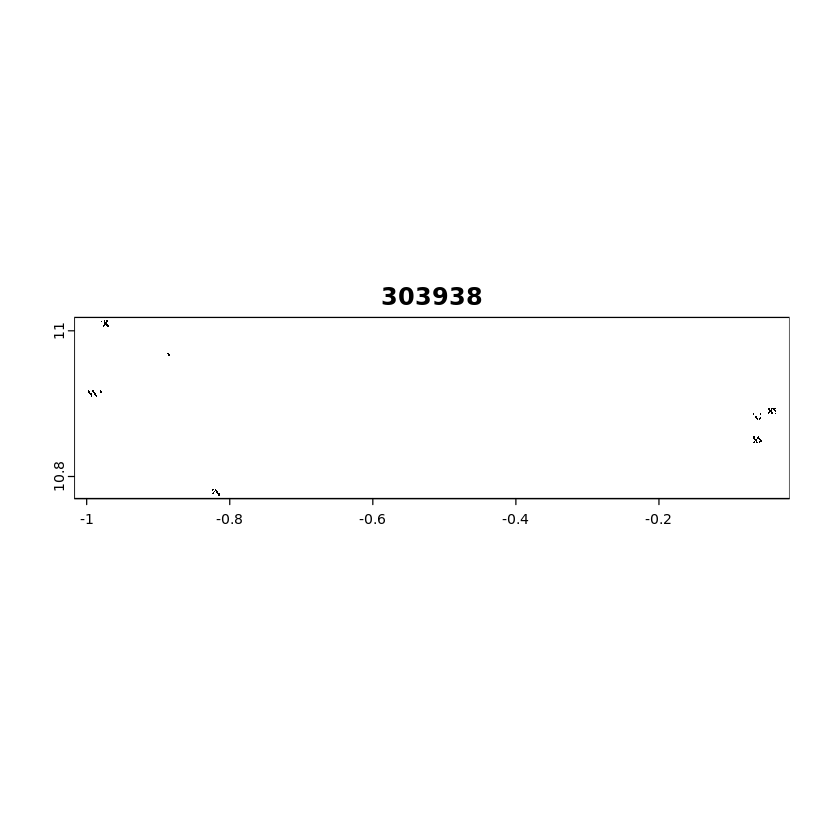

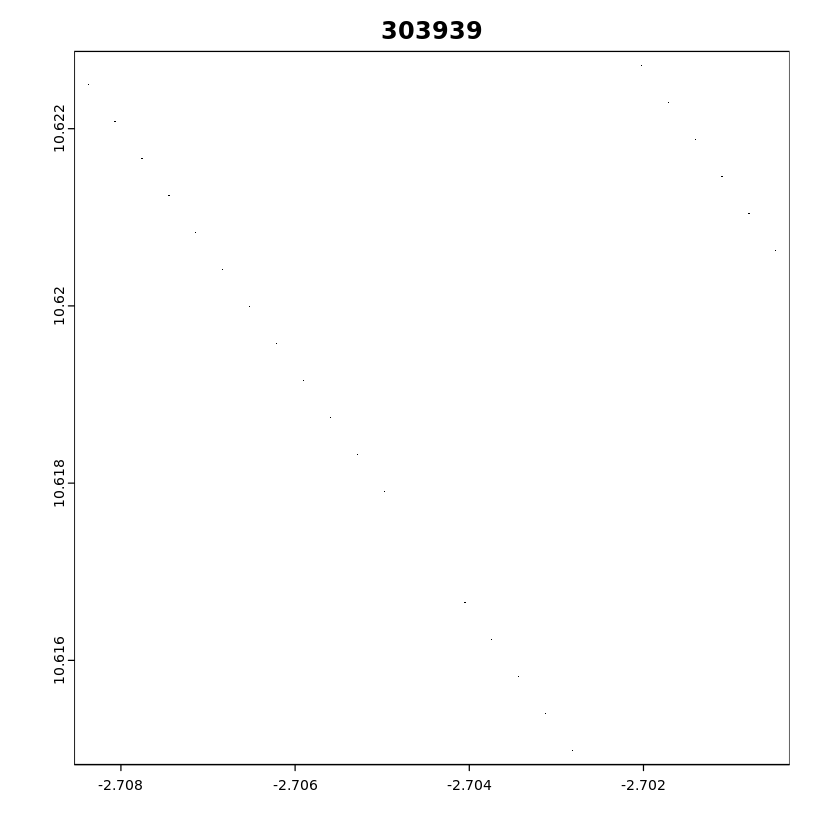

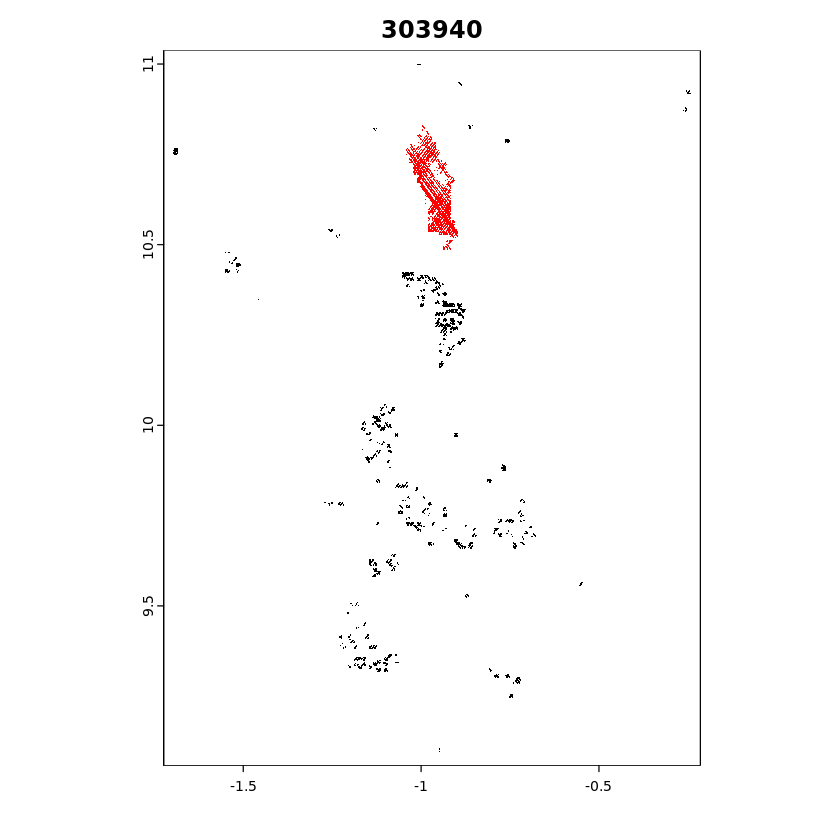

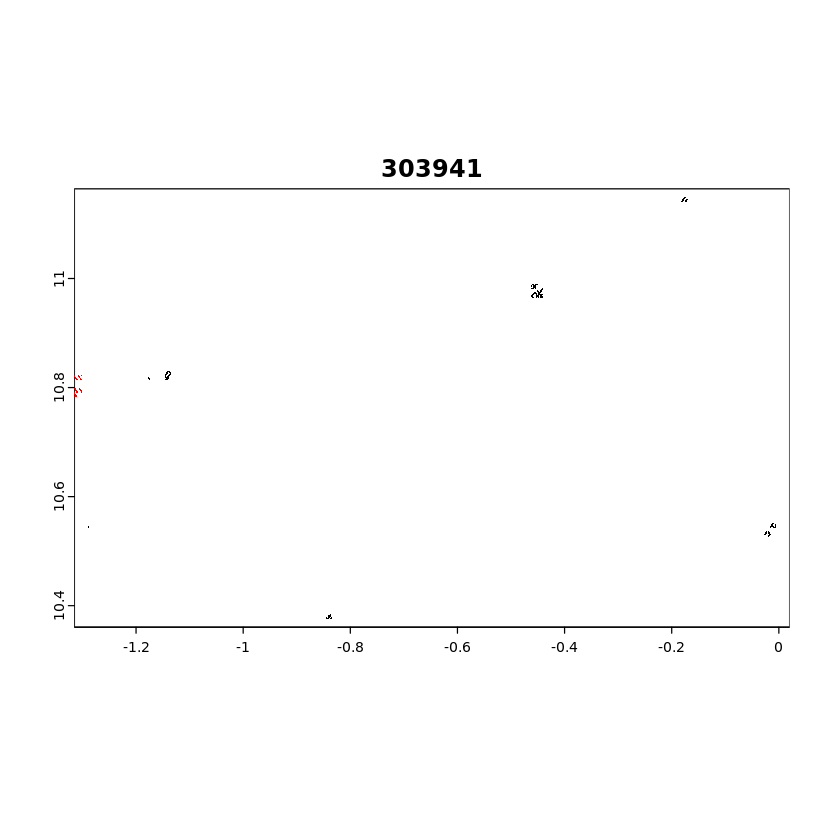

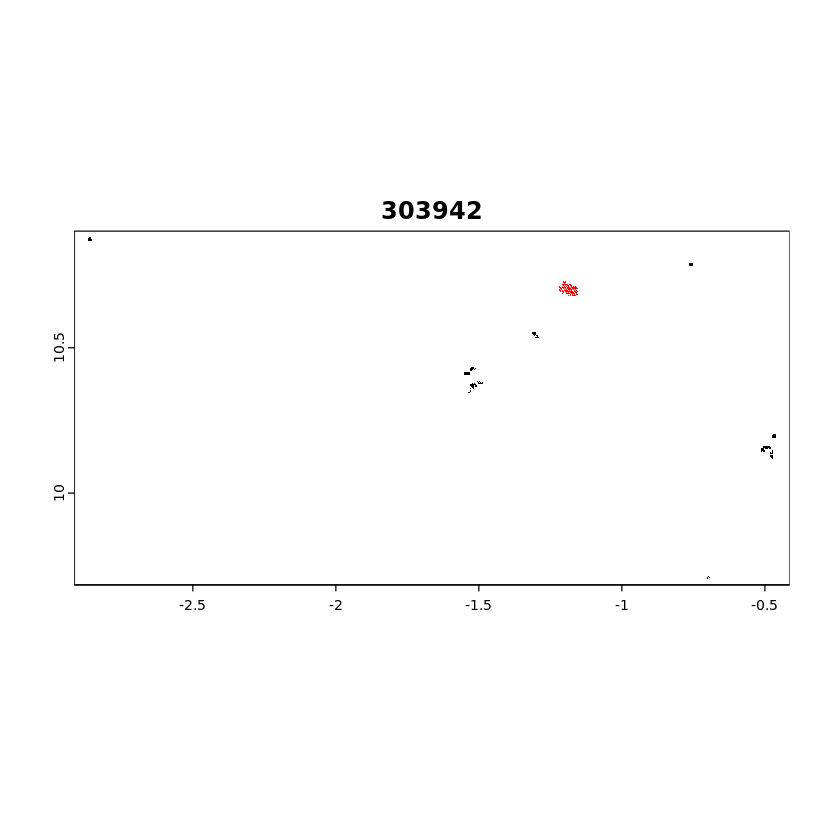

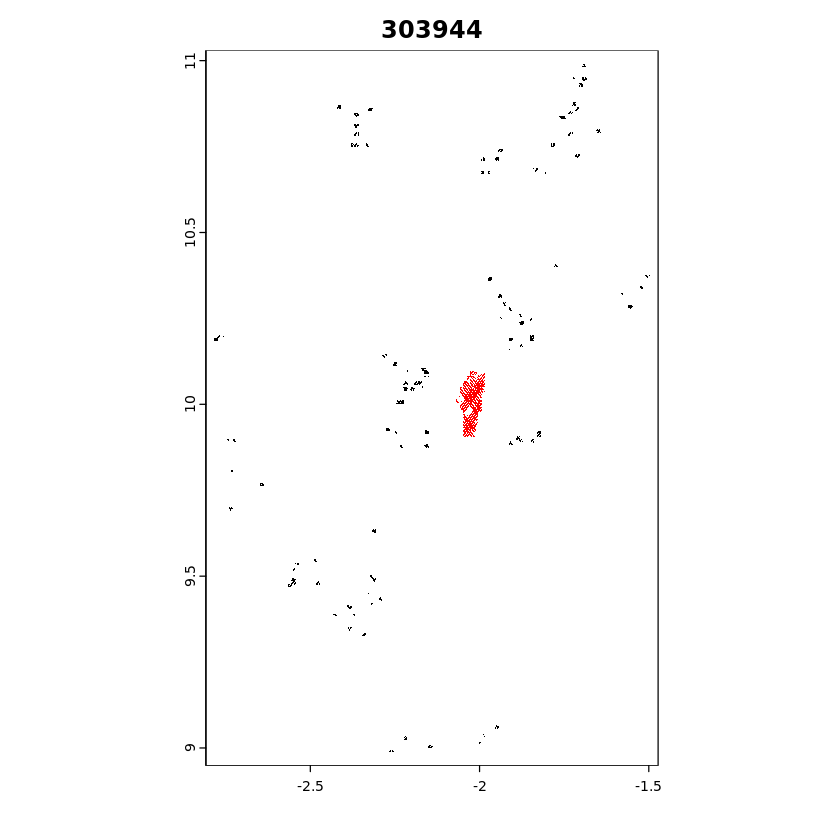

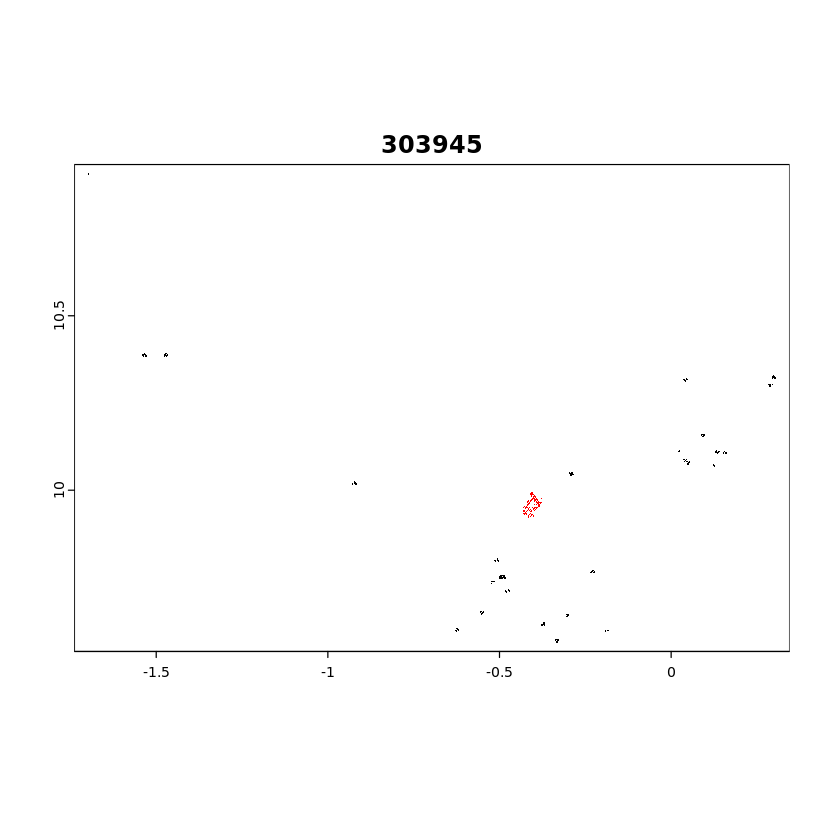

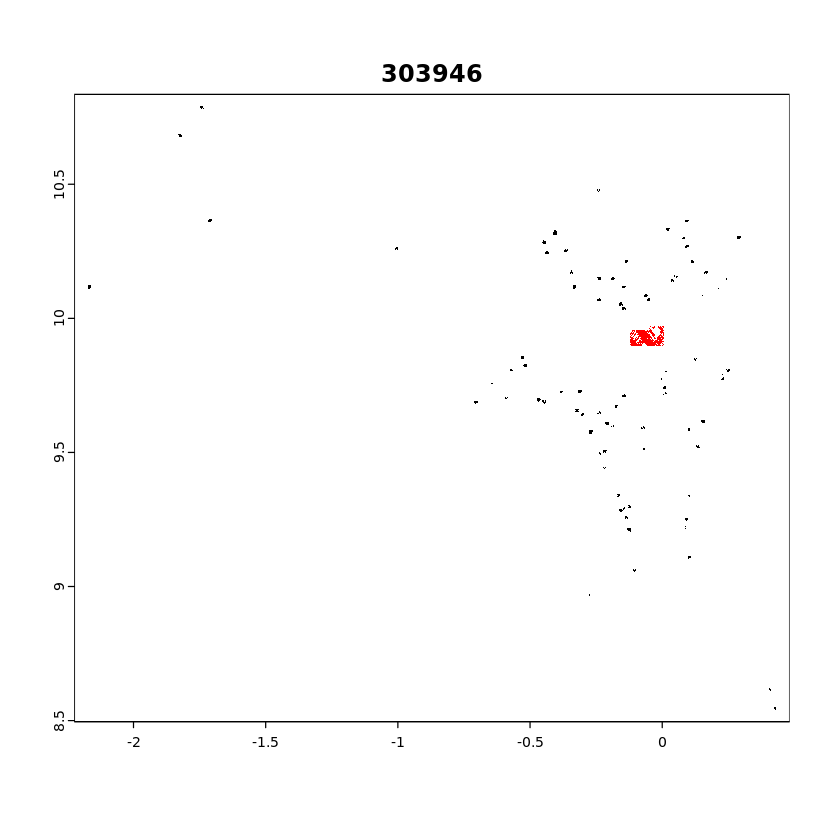

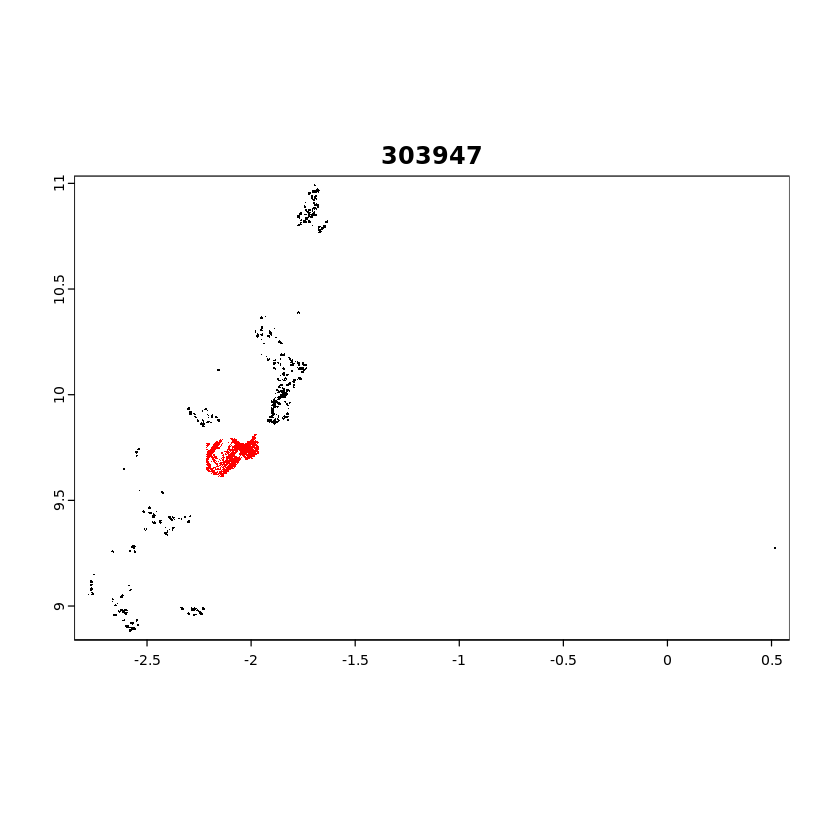

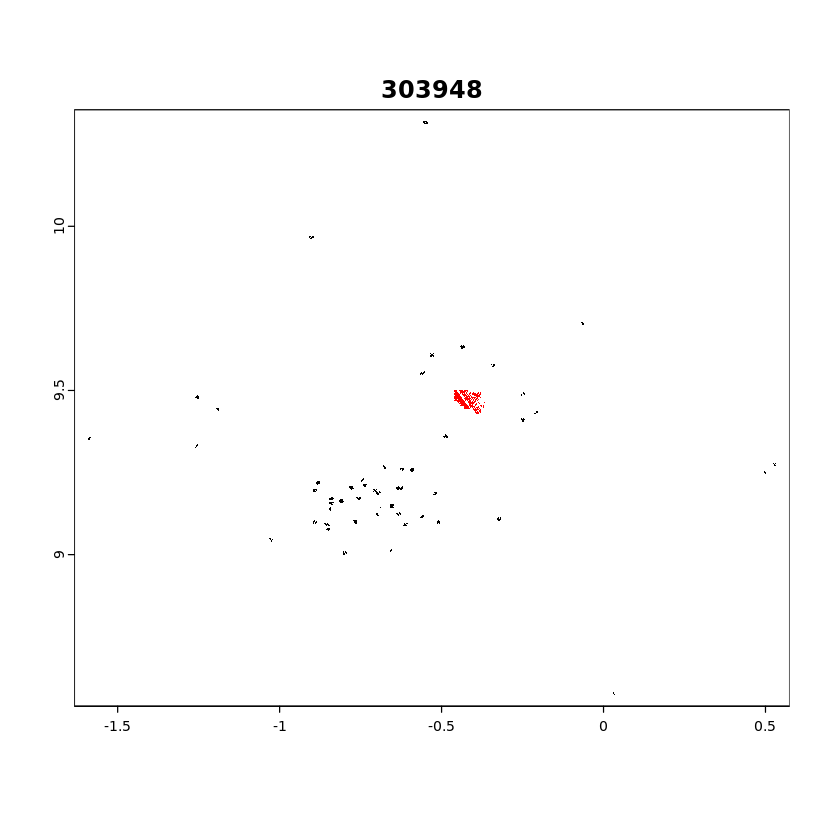

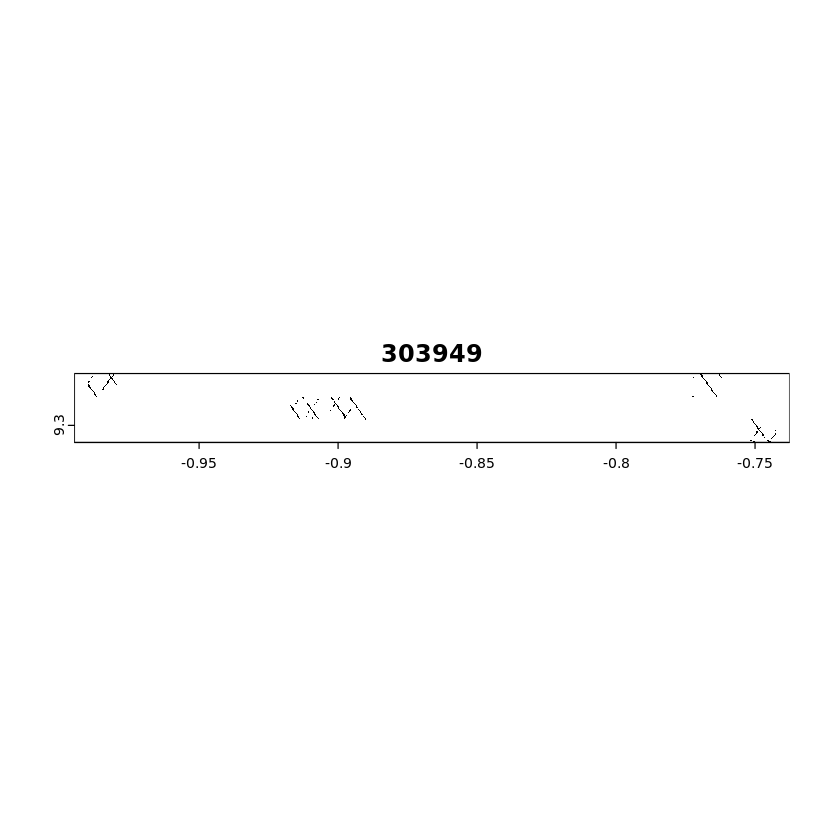

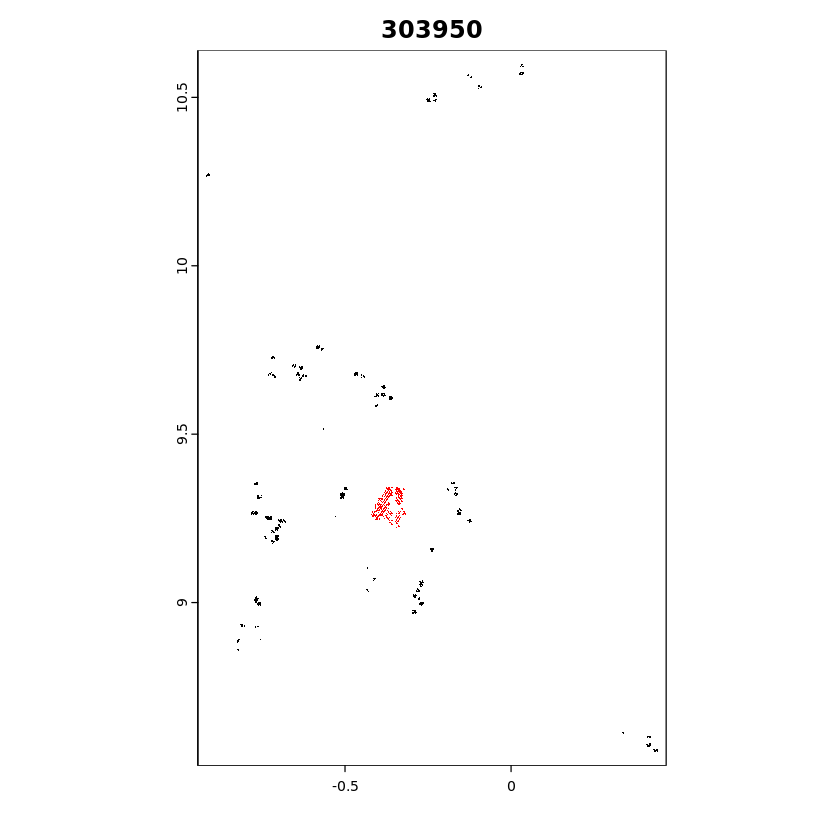

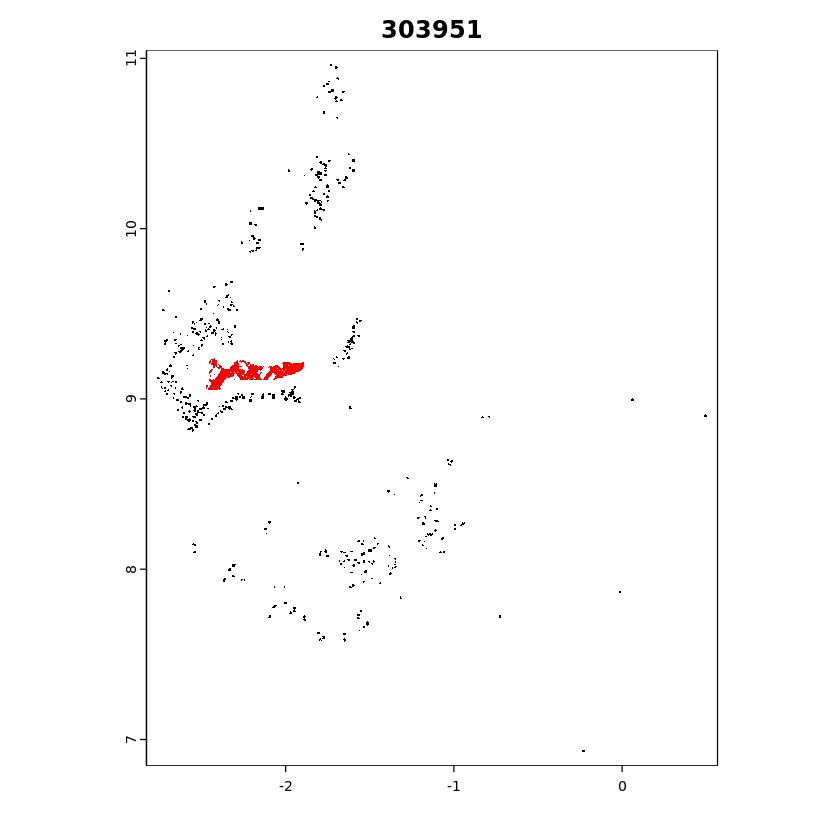

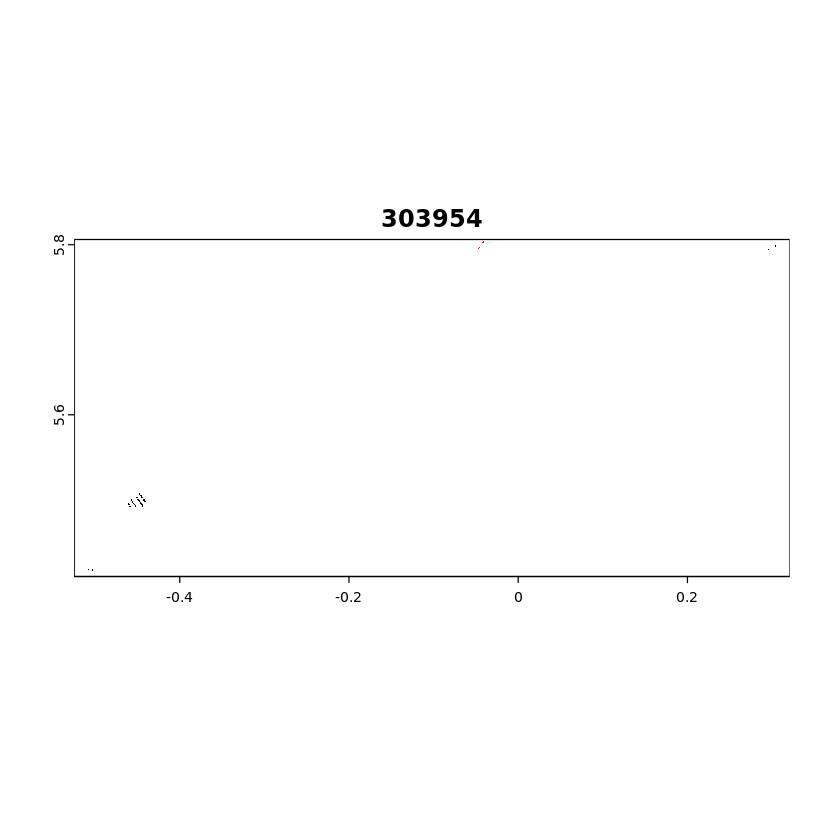

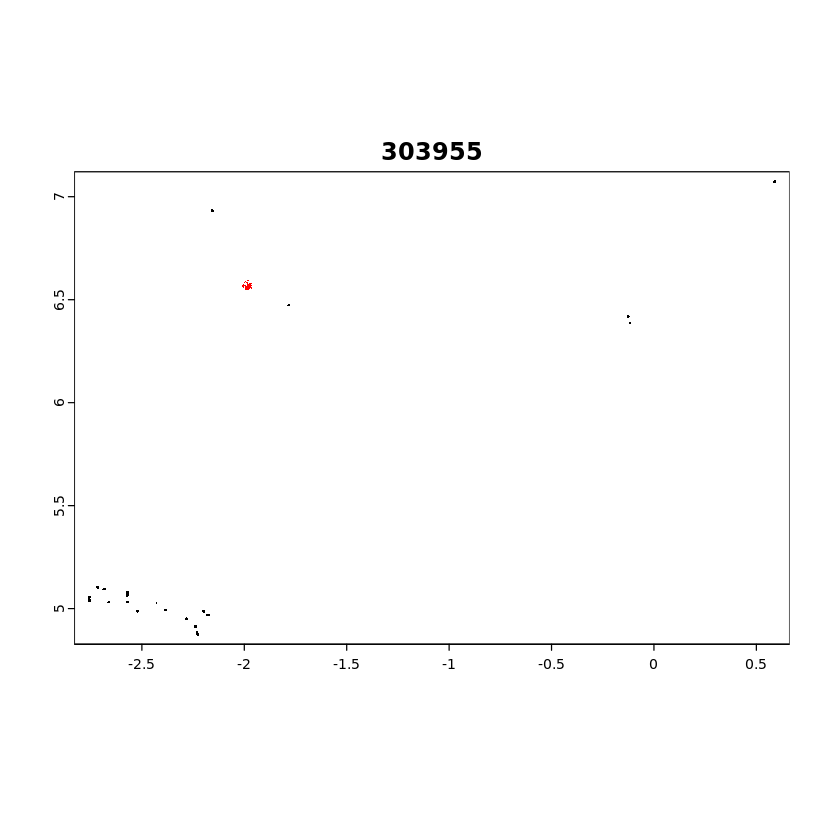

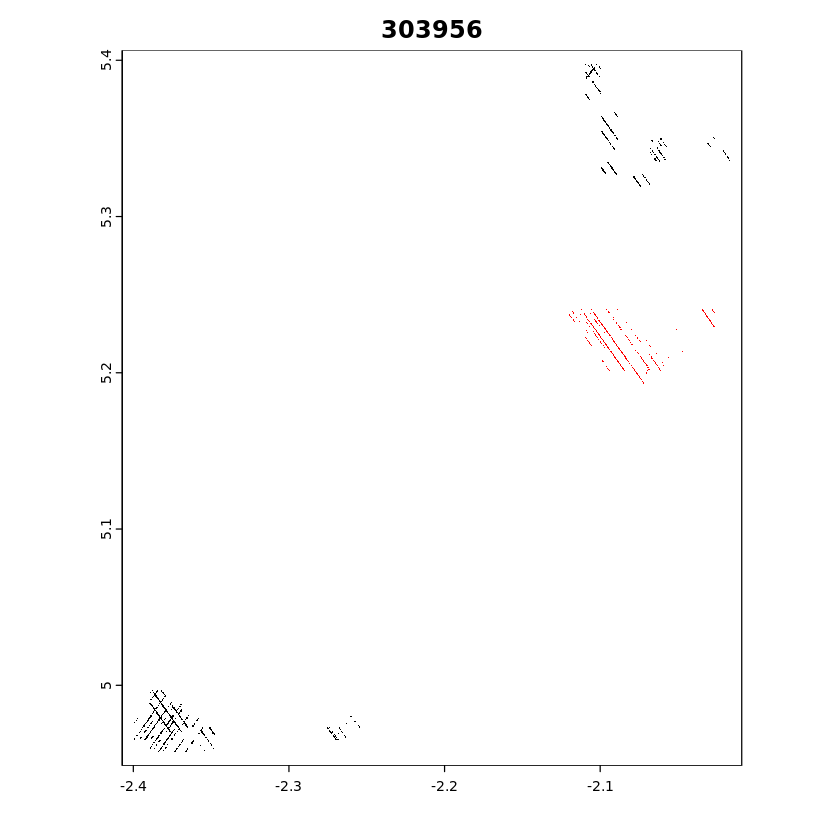

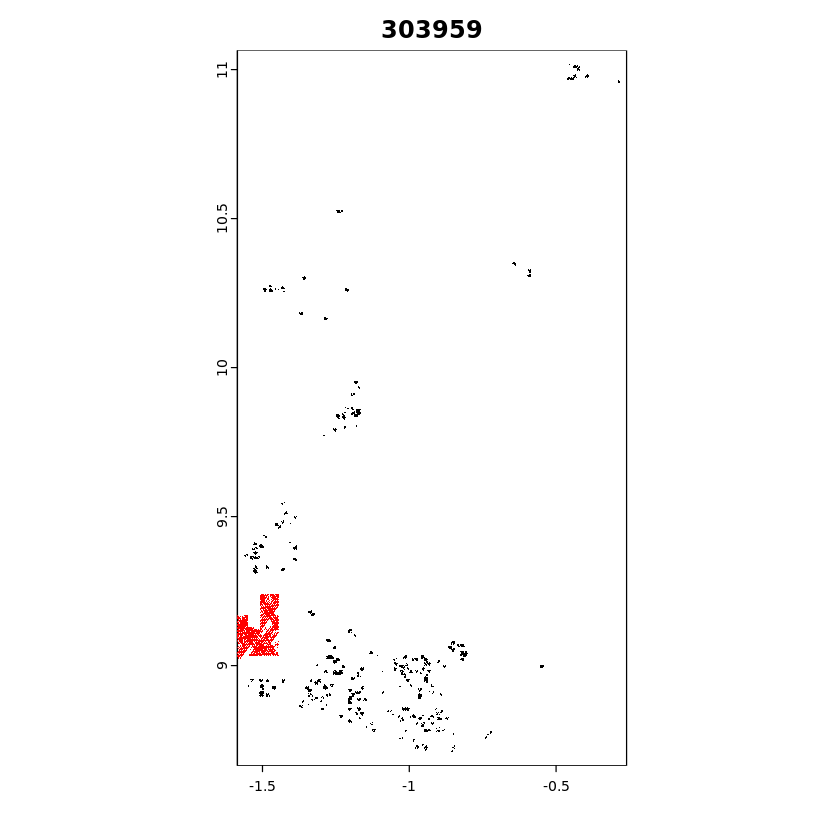

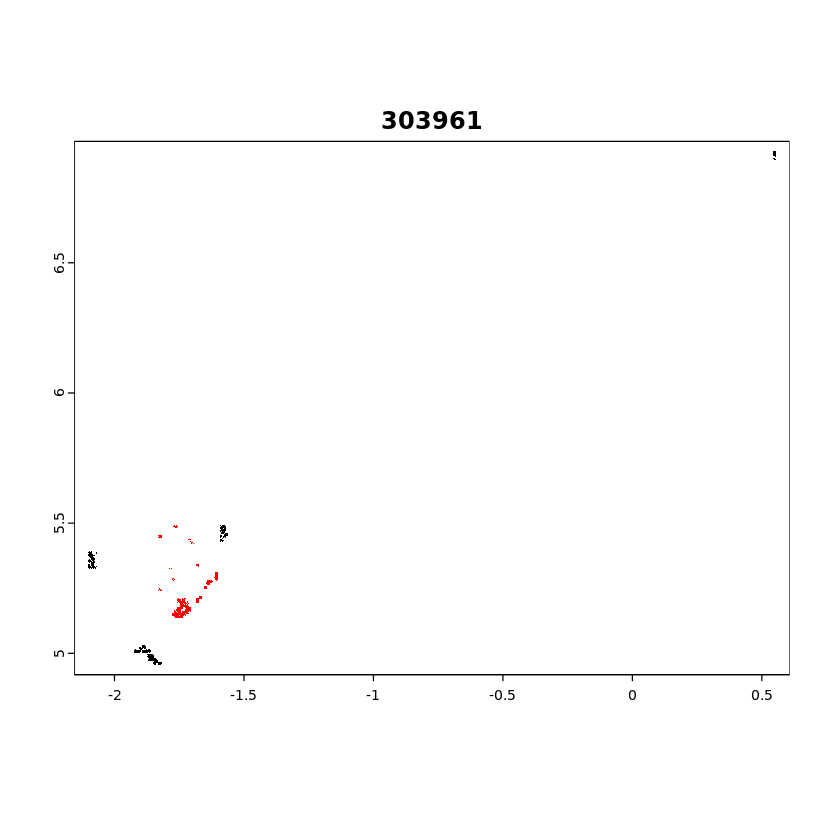

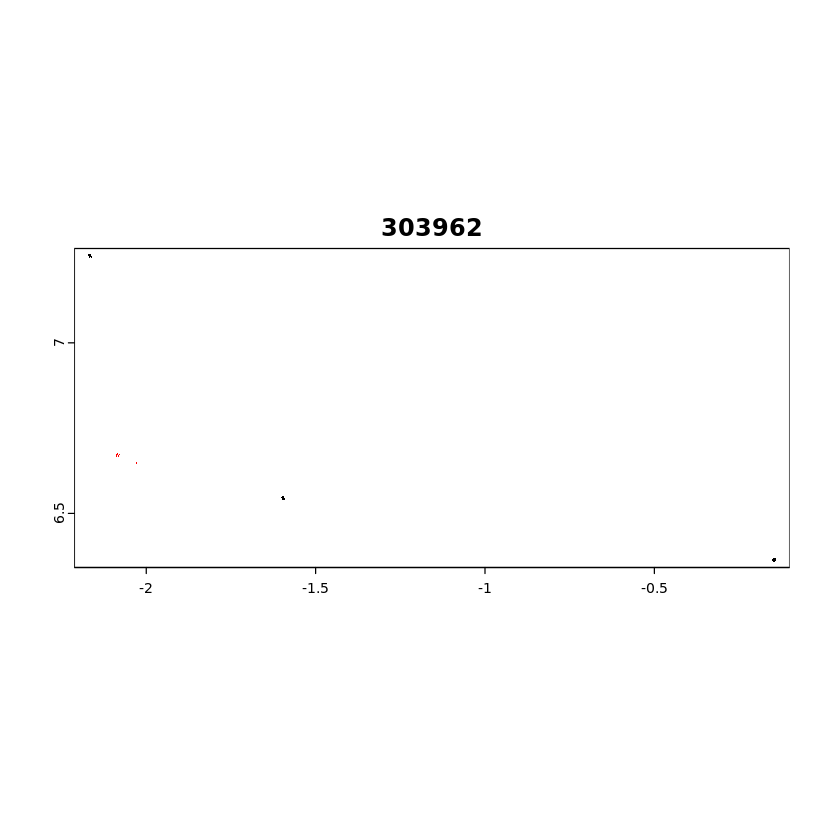

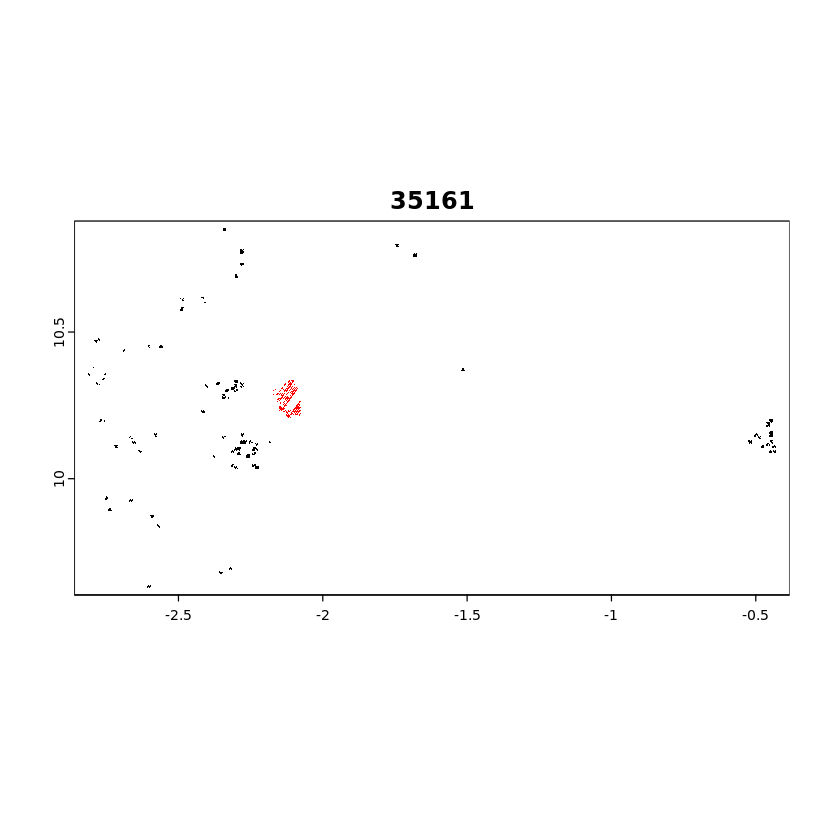

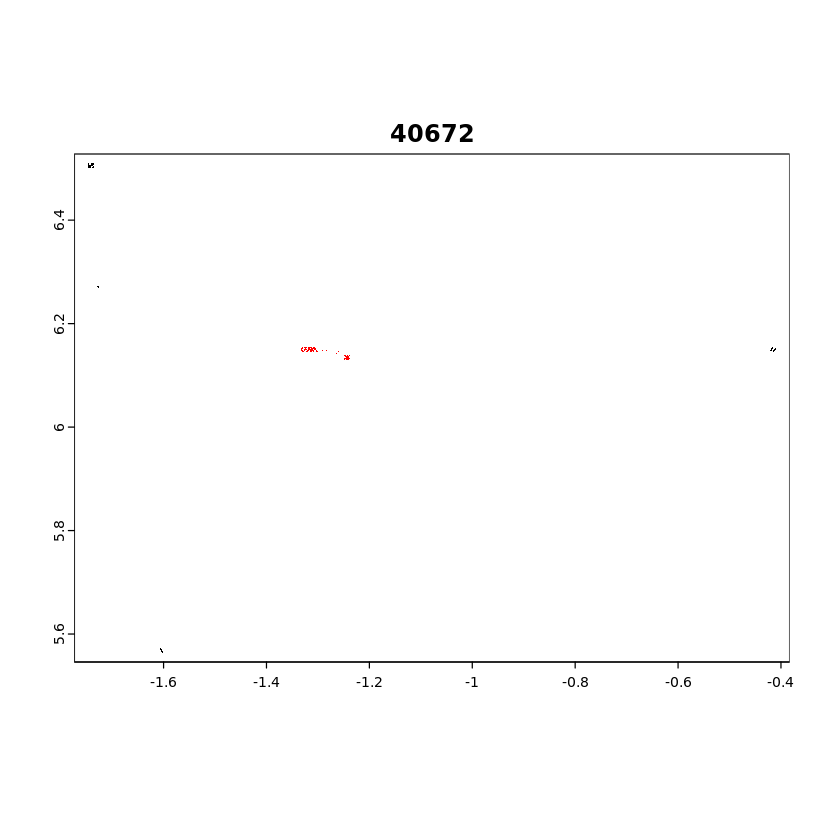

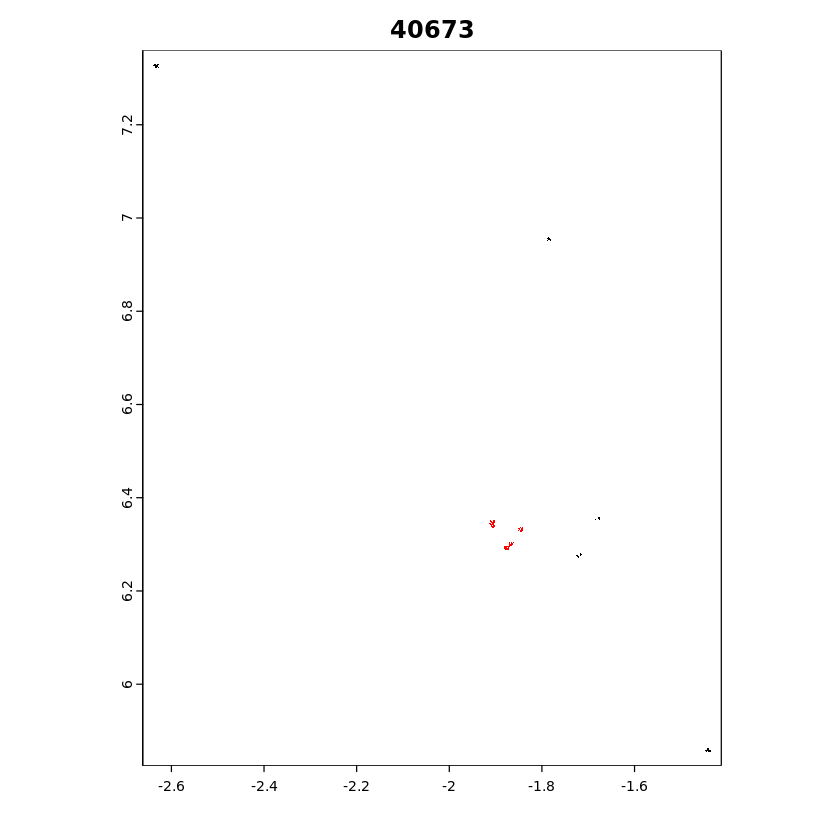

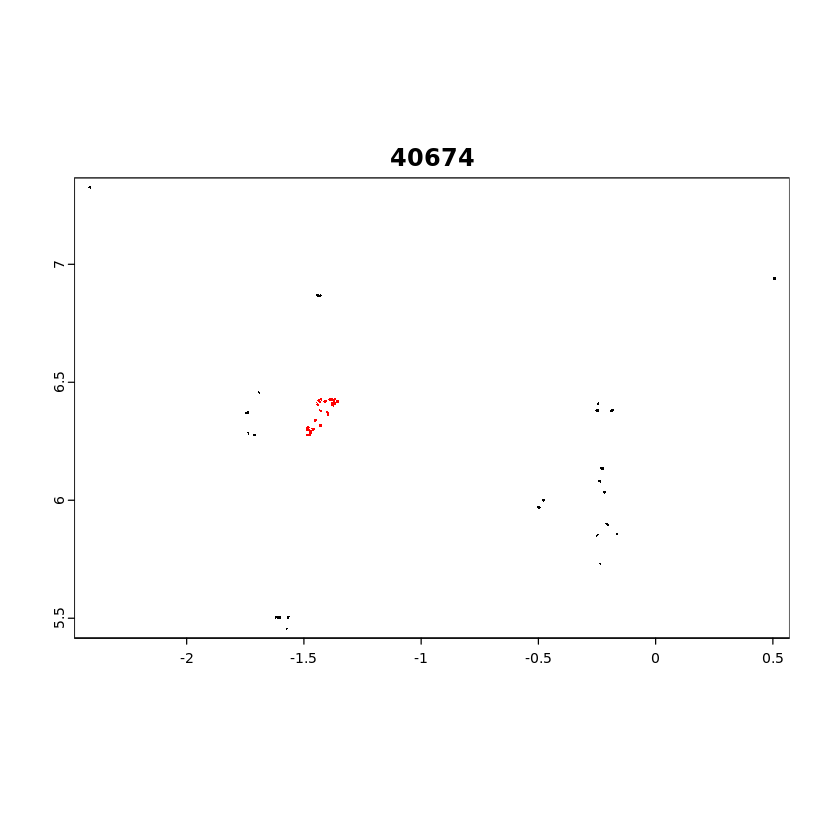

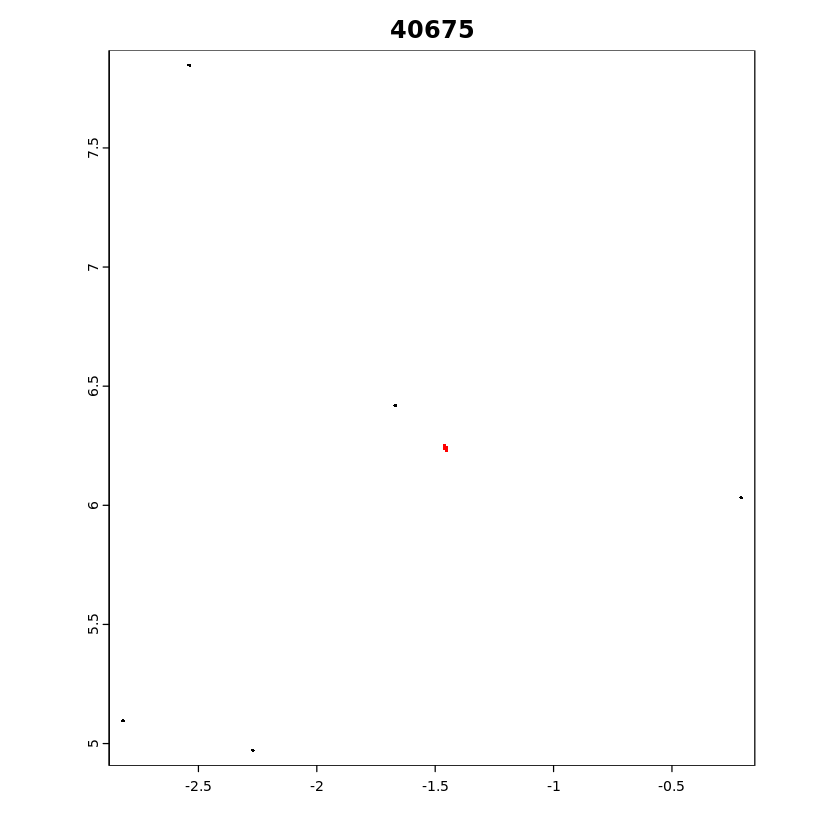

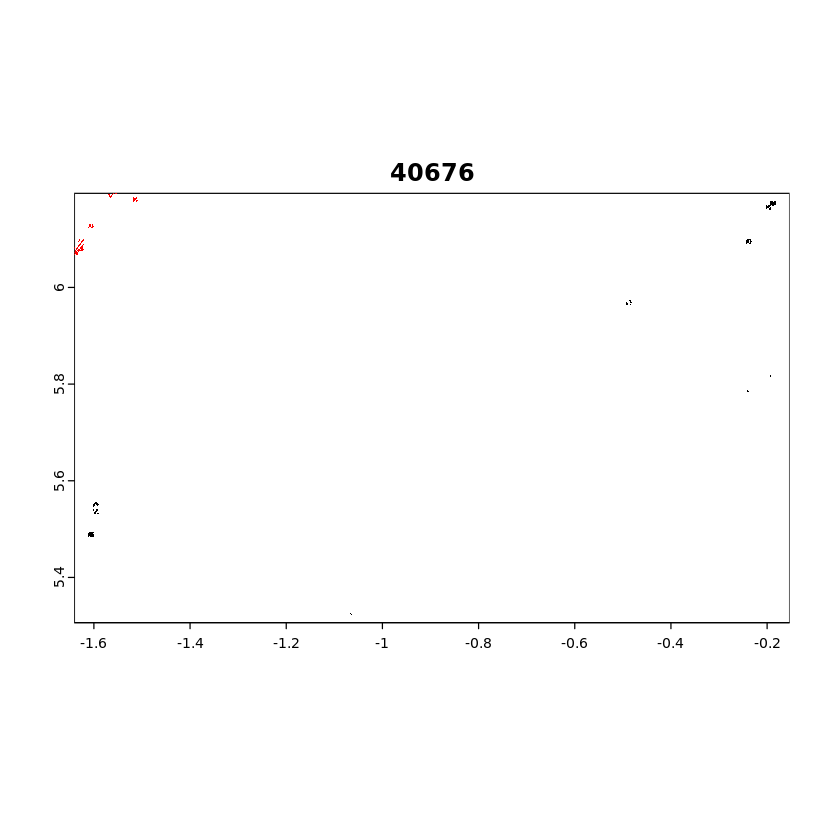

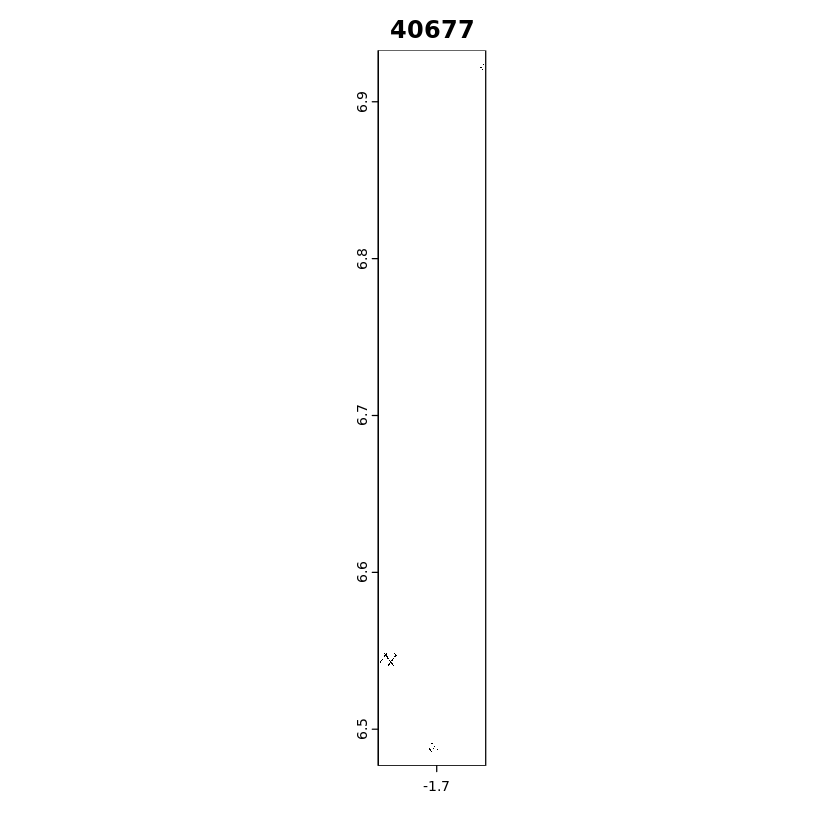

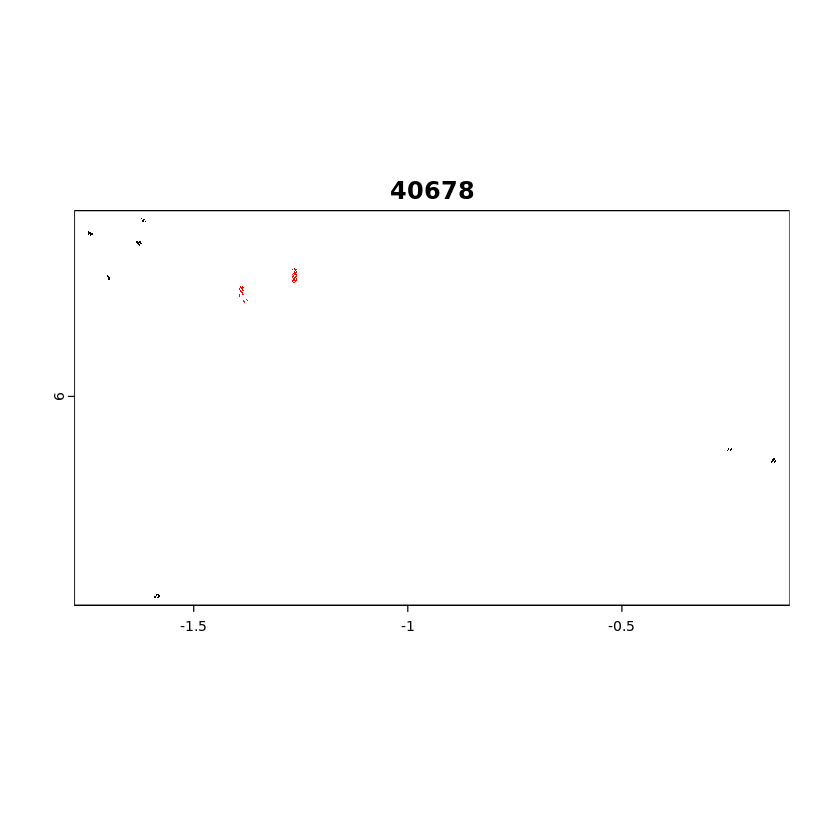

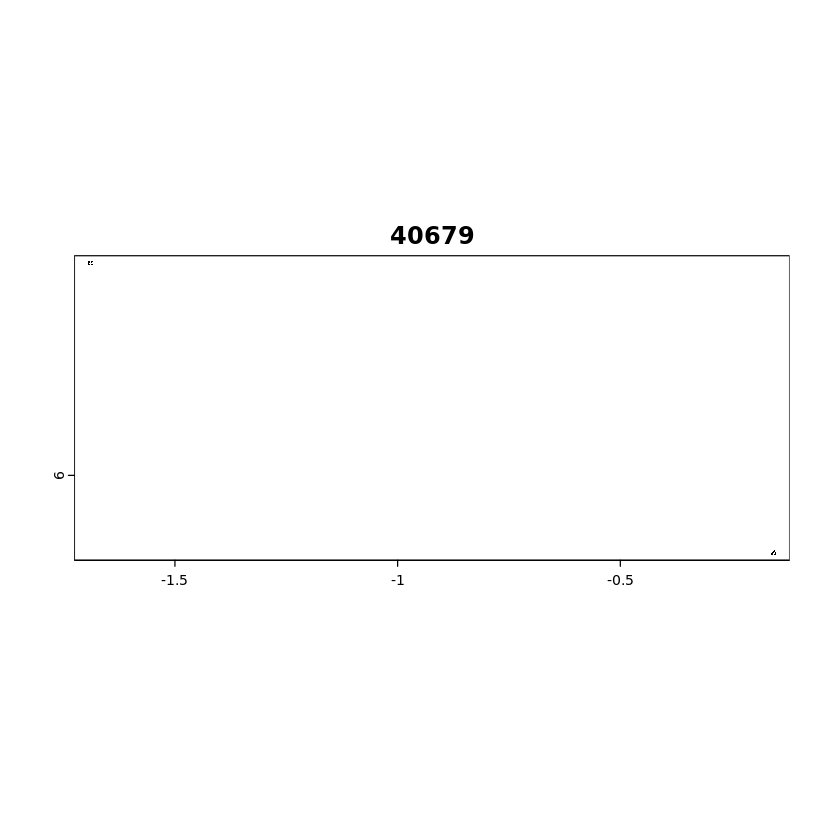

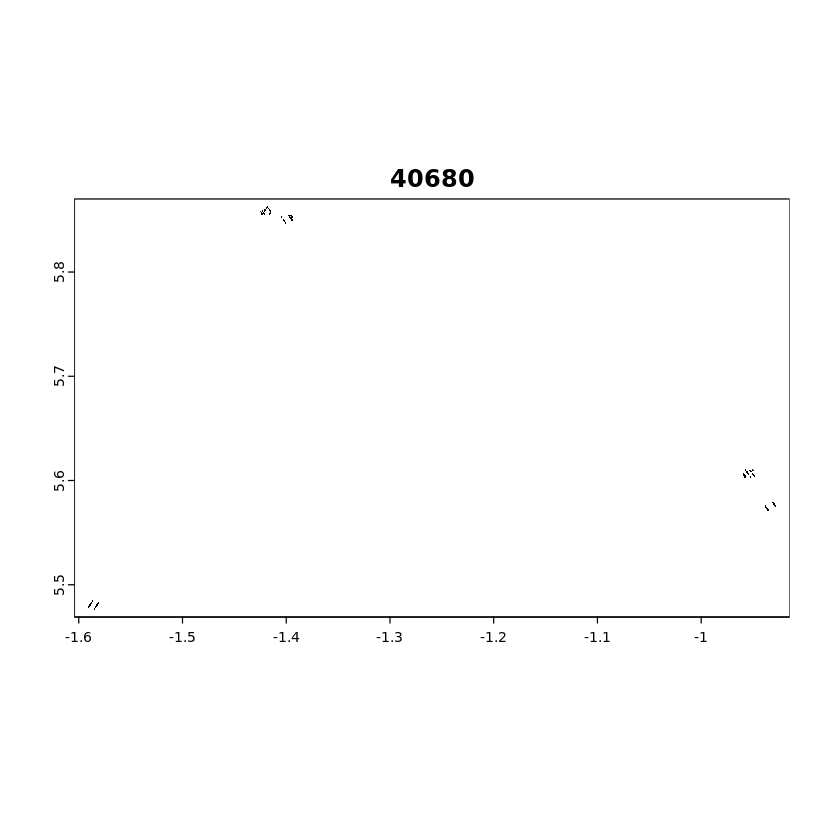

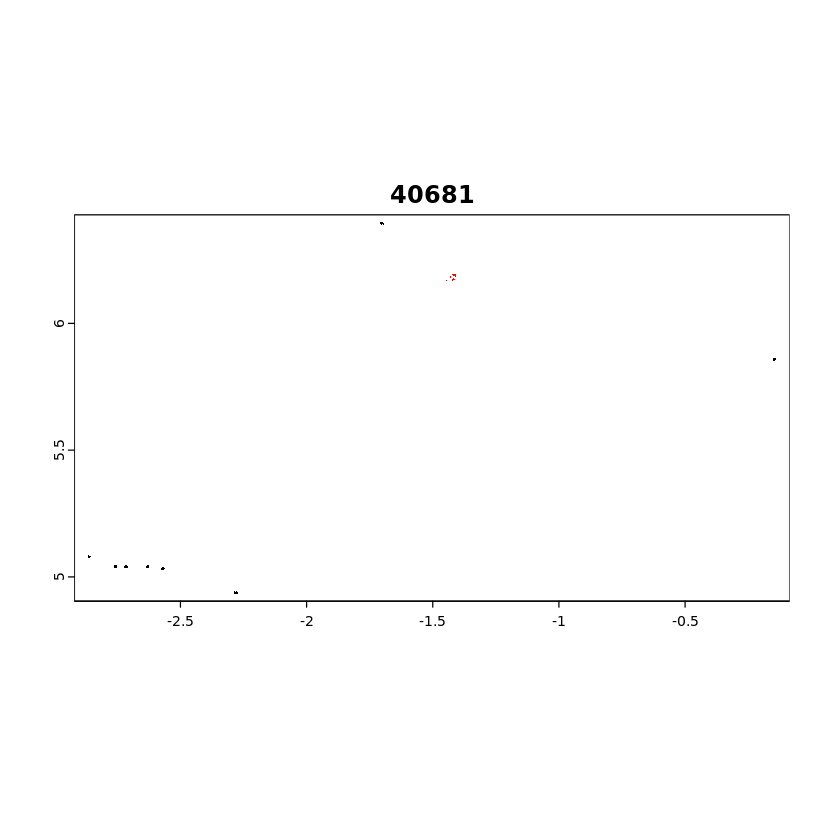

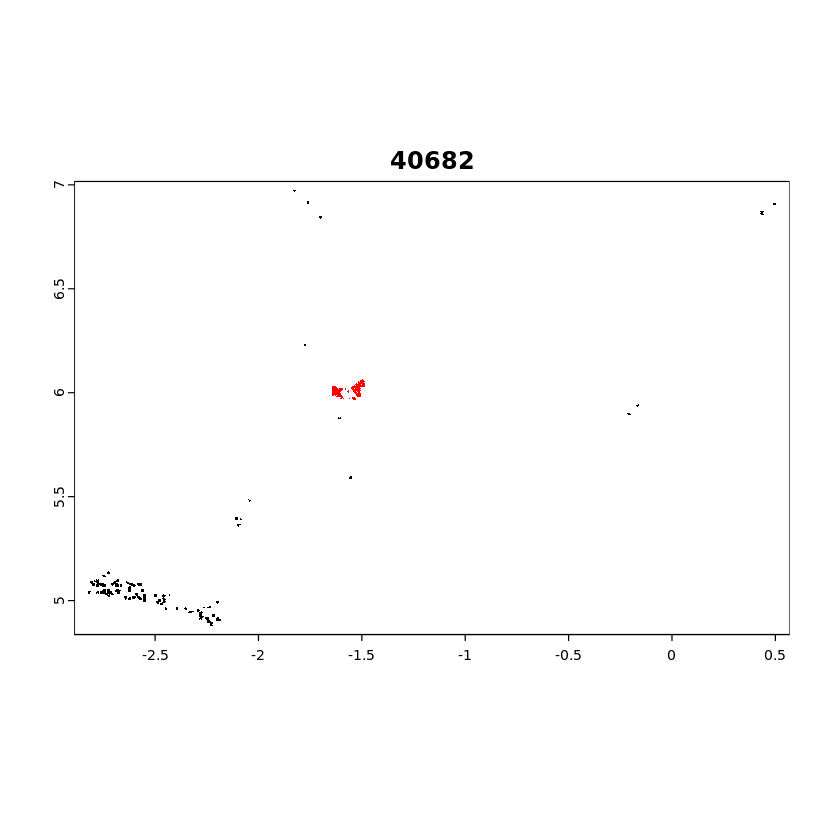

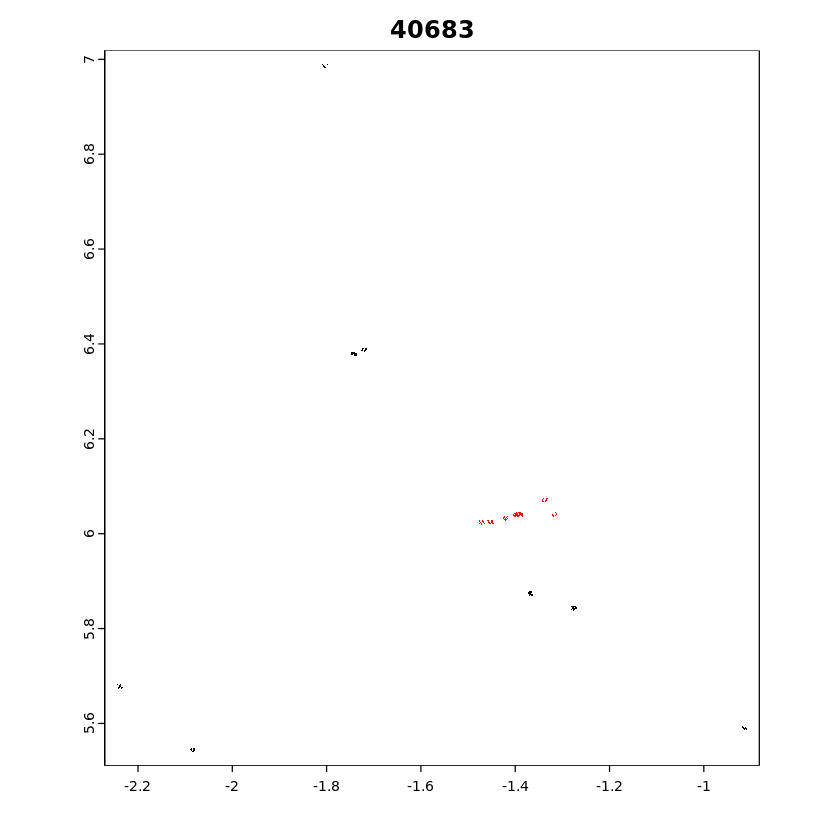

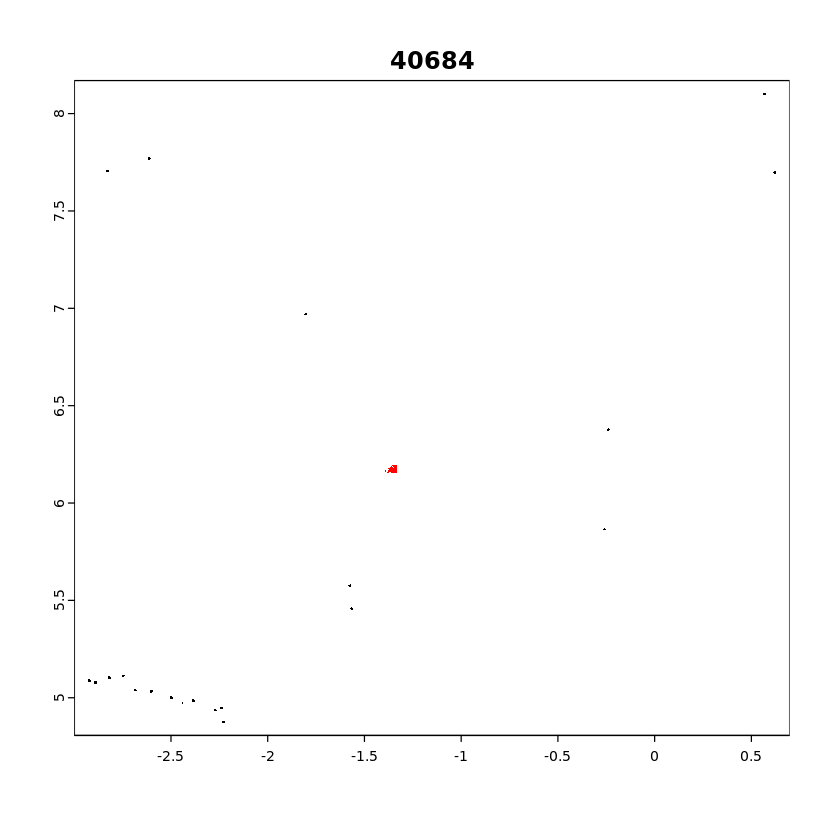

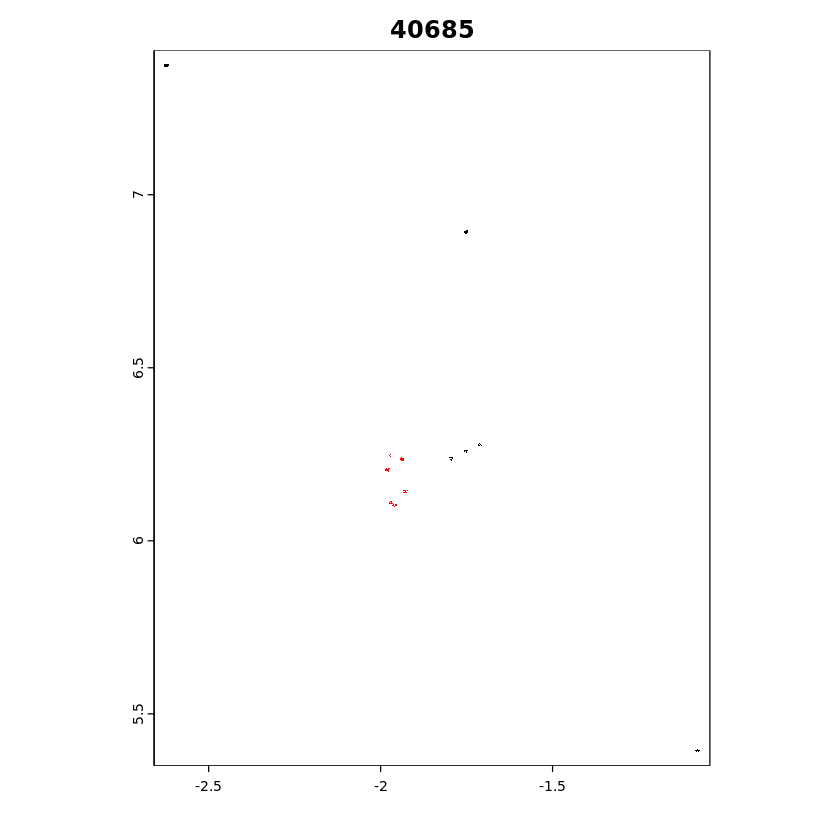

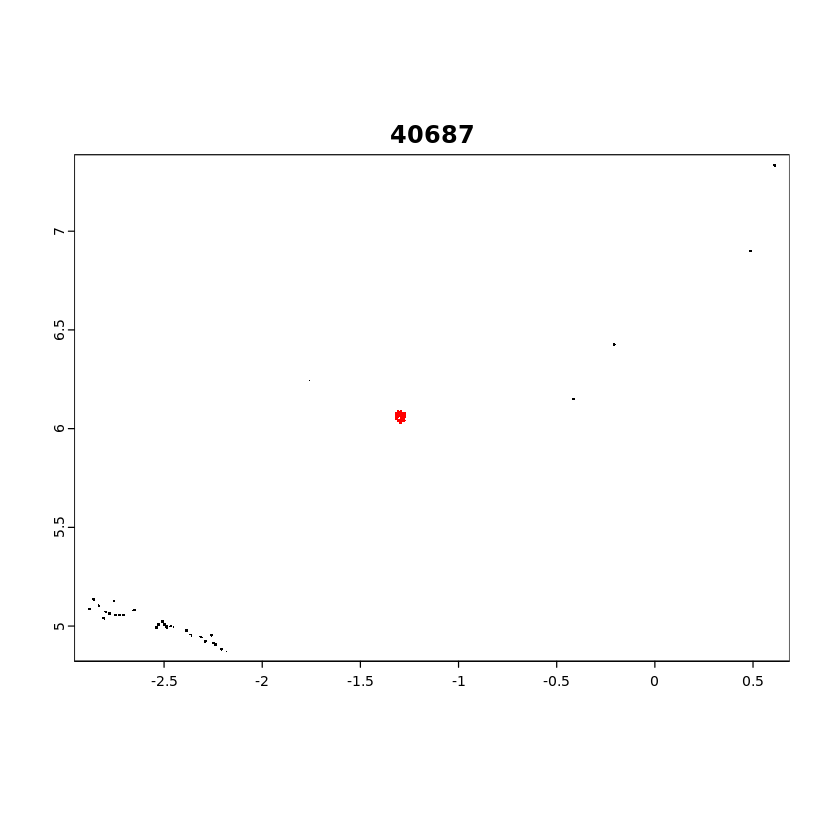

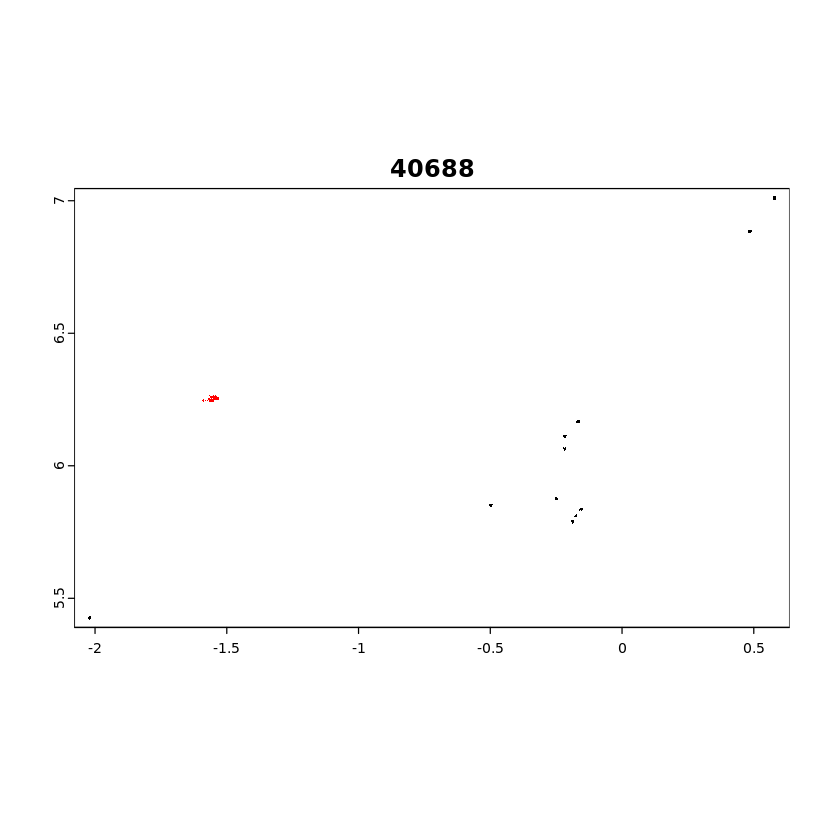

GHA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_40690_gedi_wk_24_conti_biome_TSMBF.RDS has 0 protected or treatment 


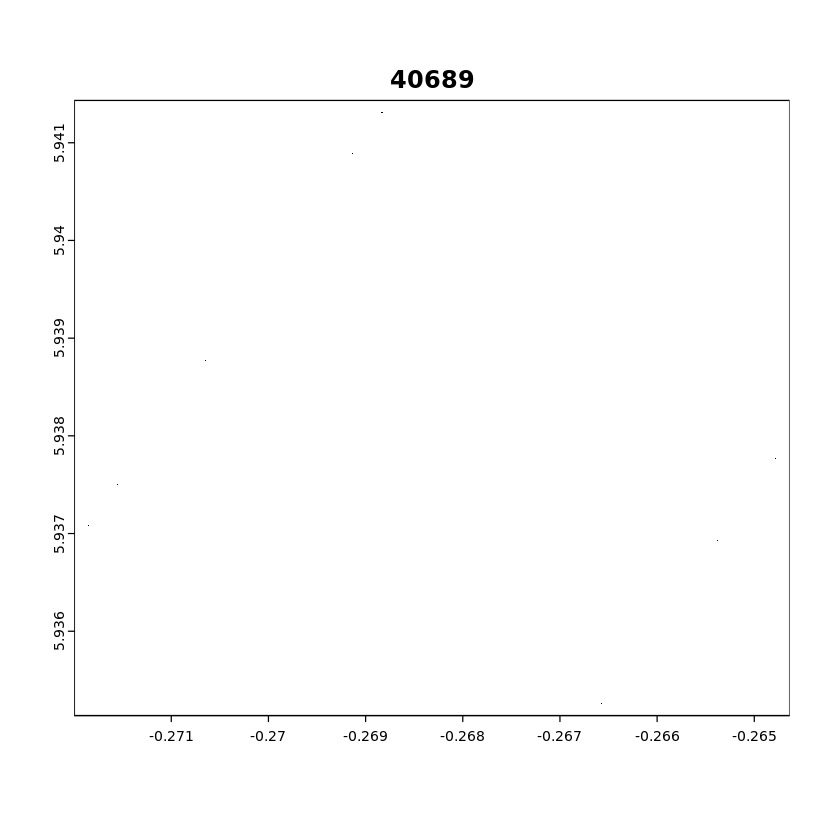

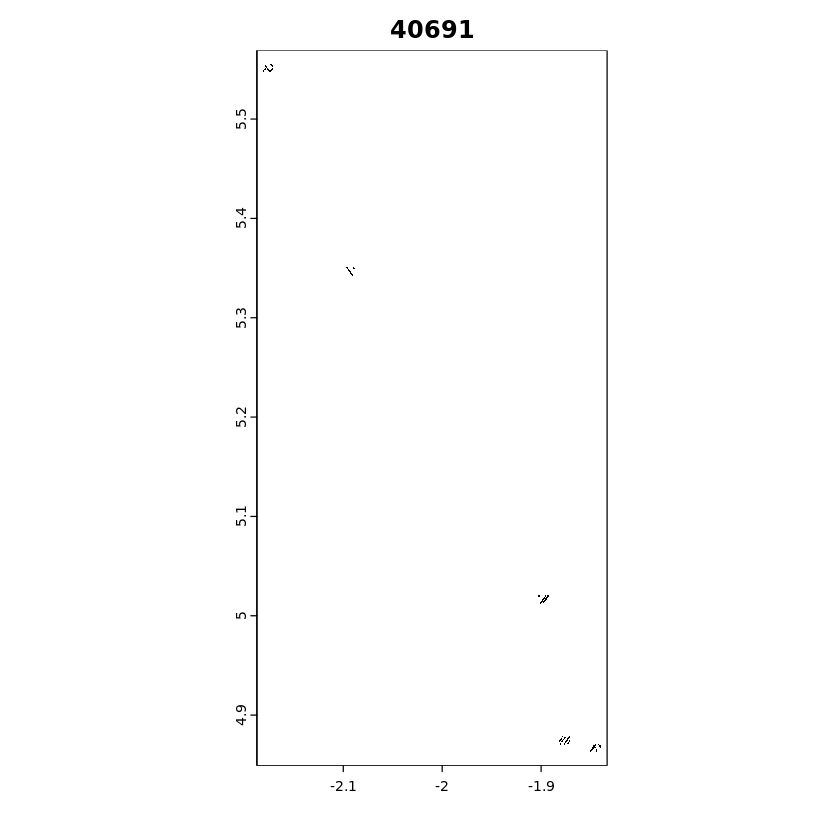

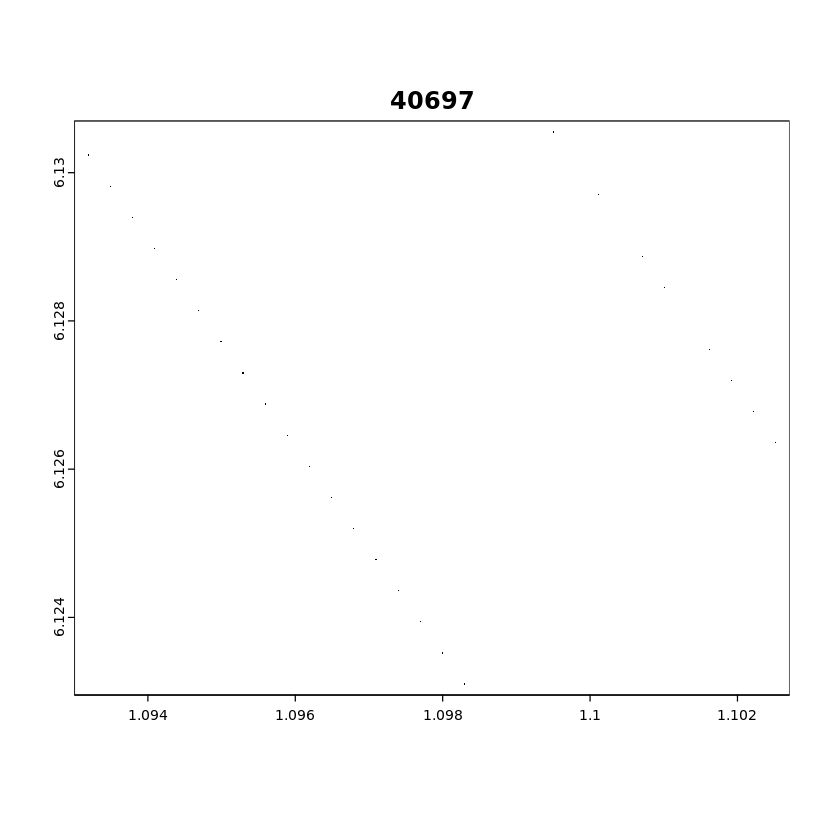

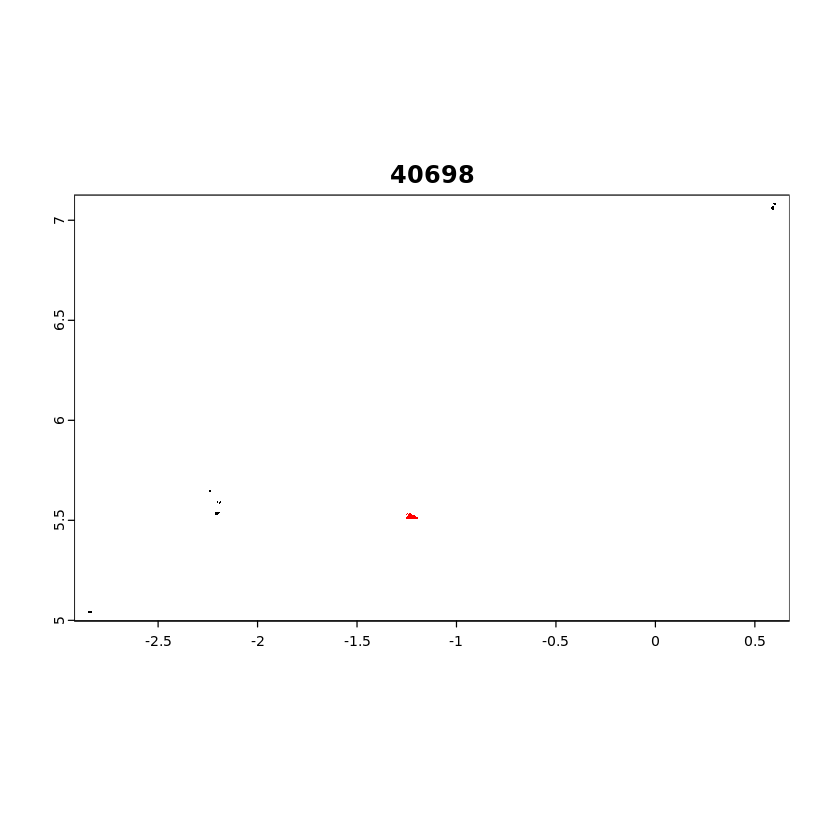

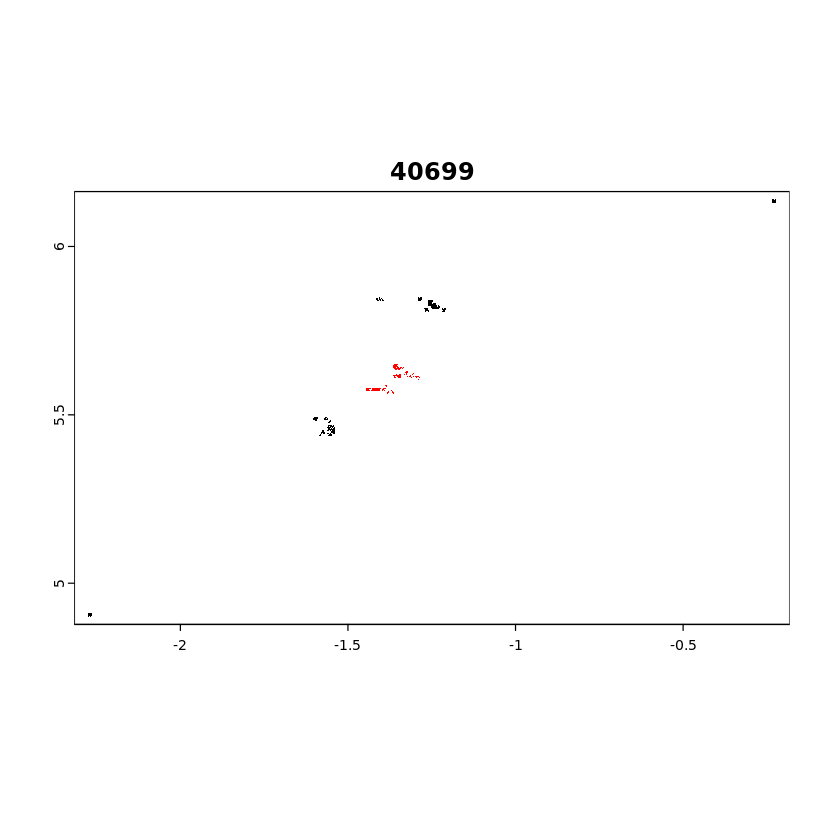

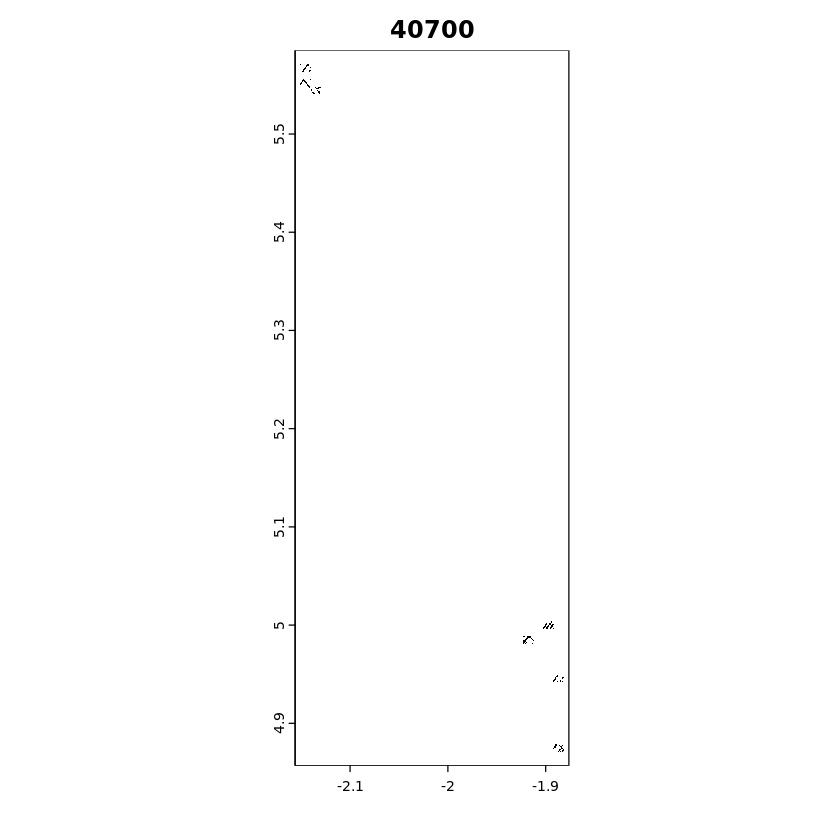

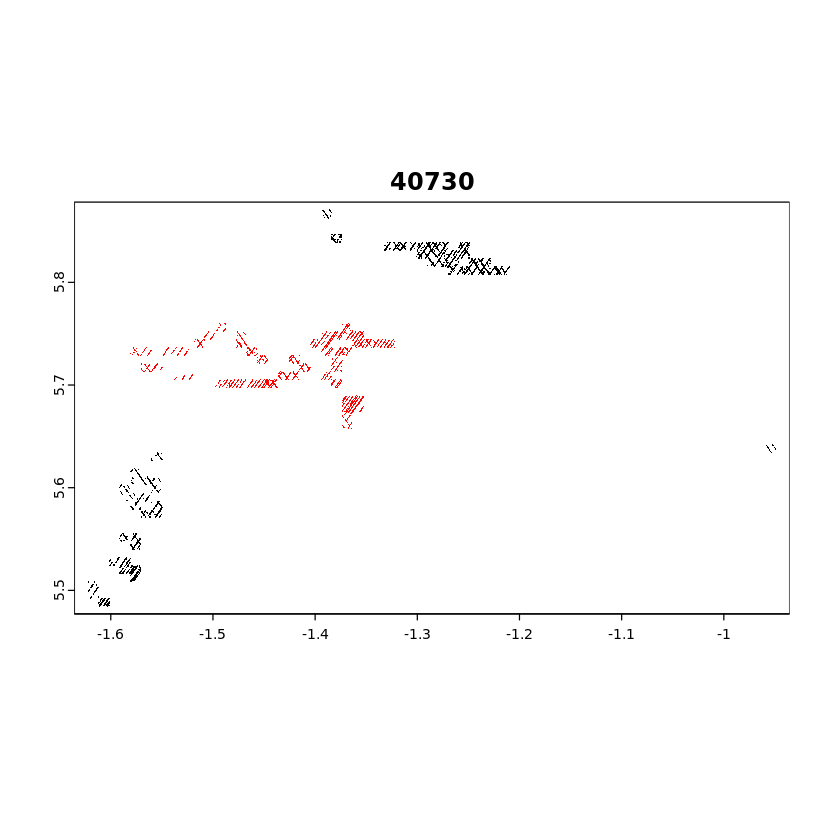

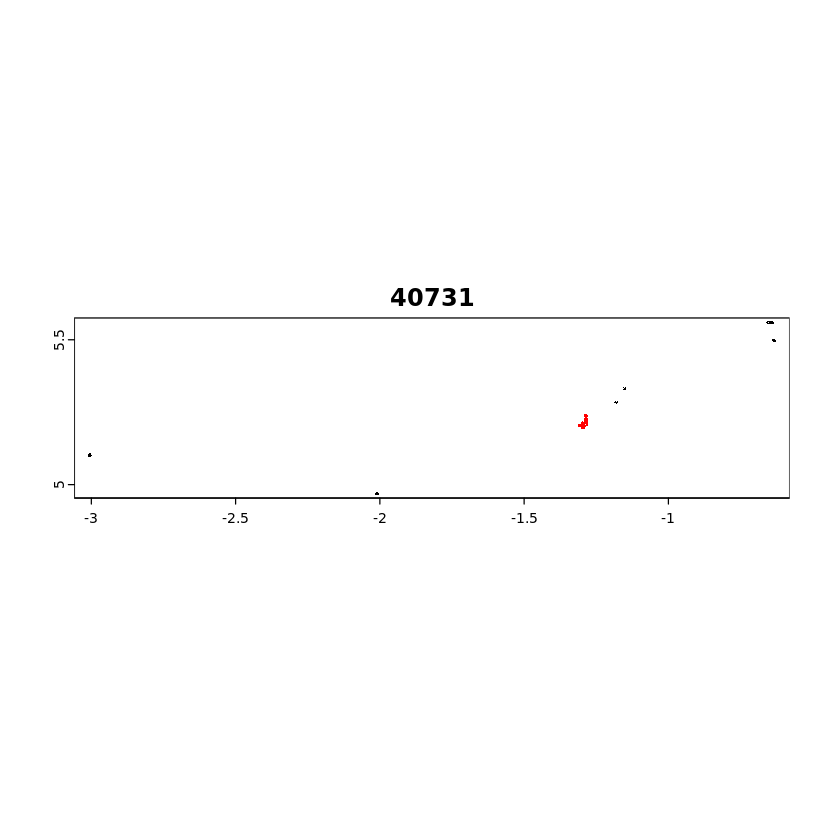

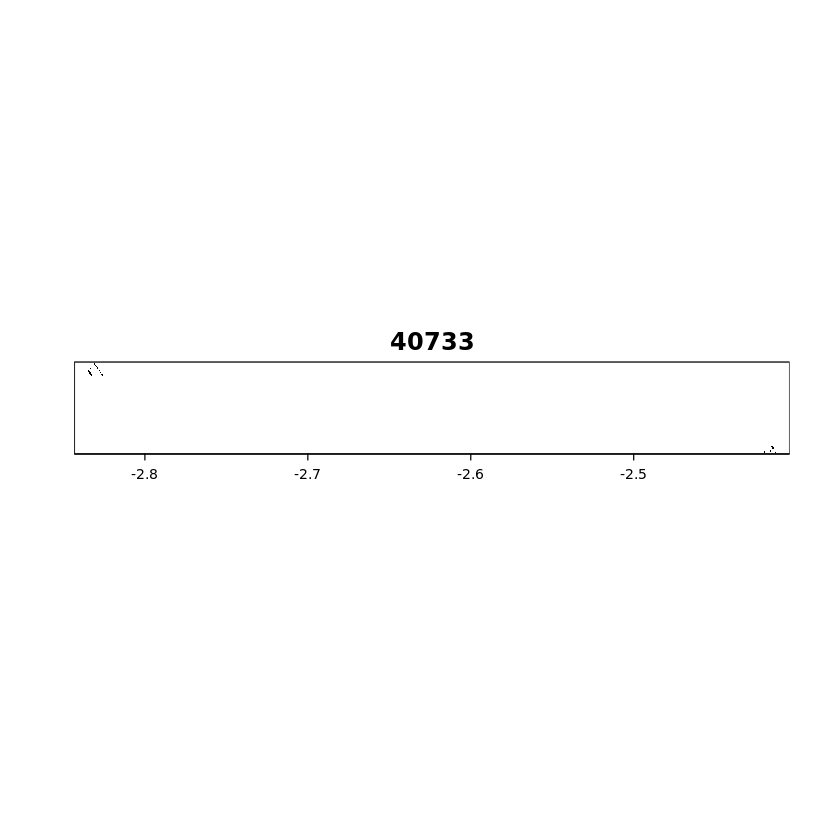

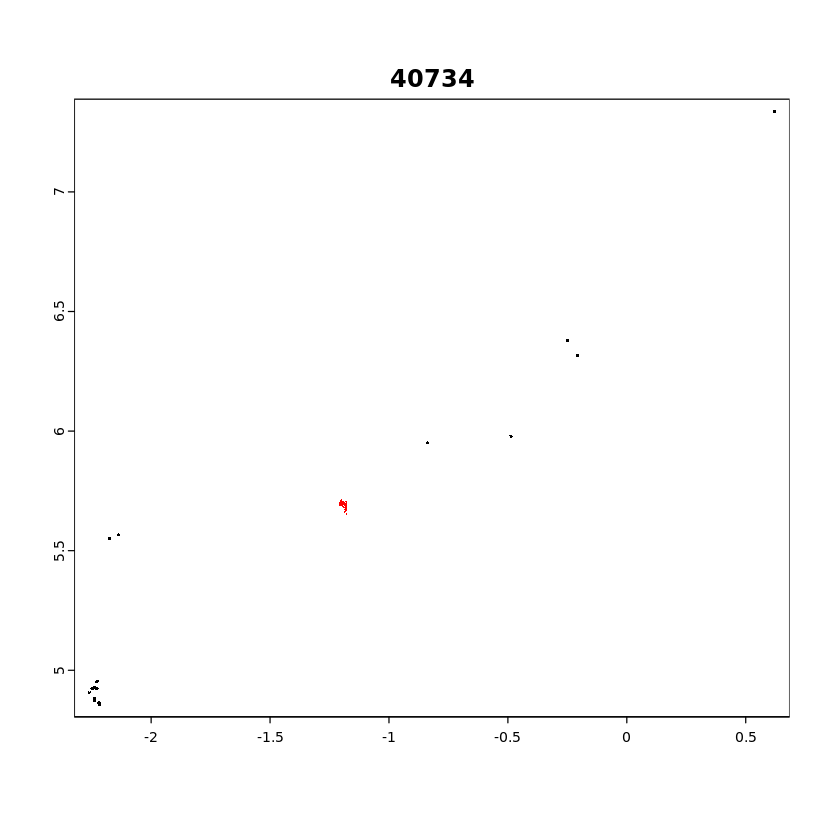

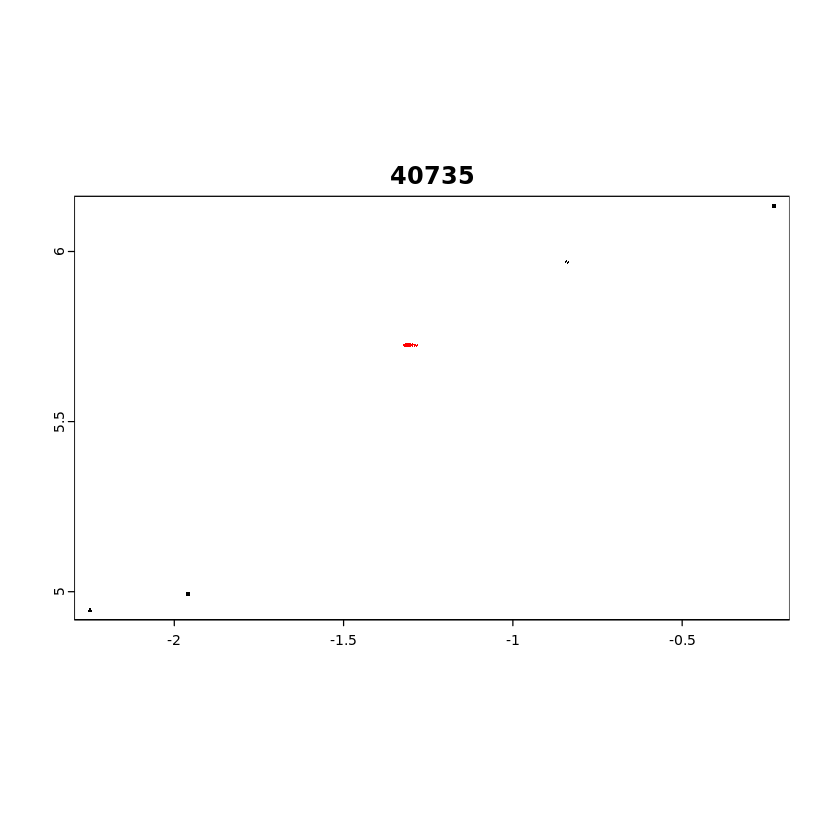

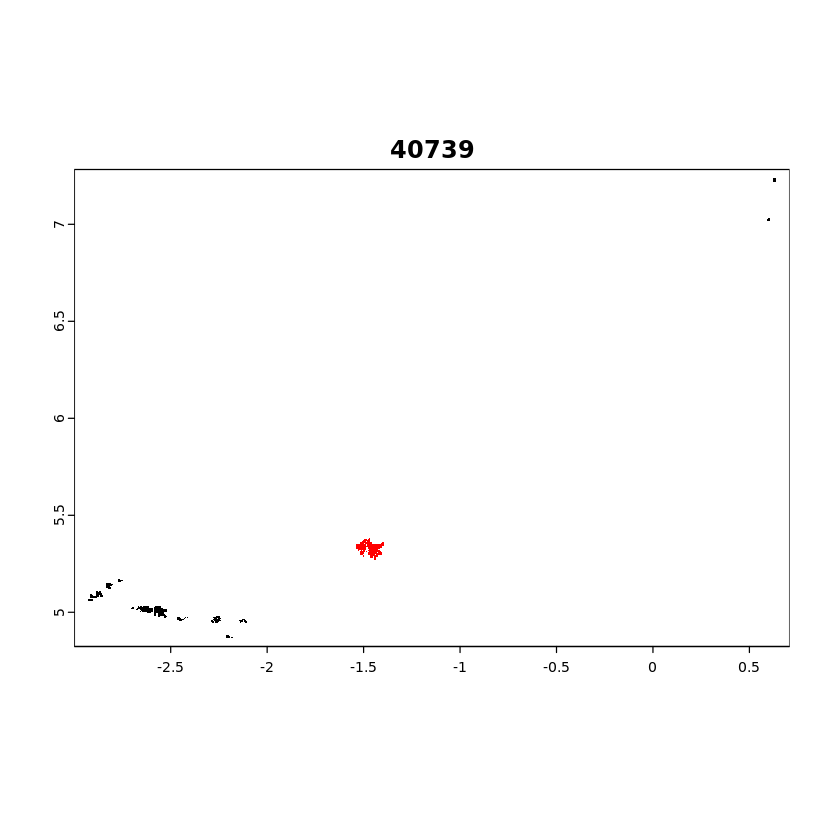

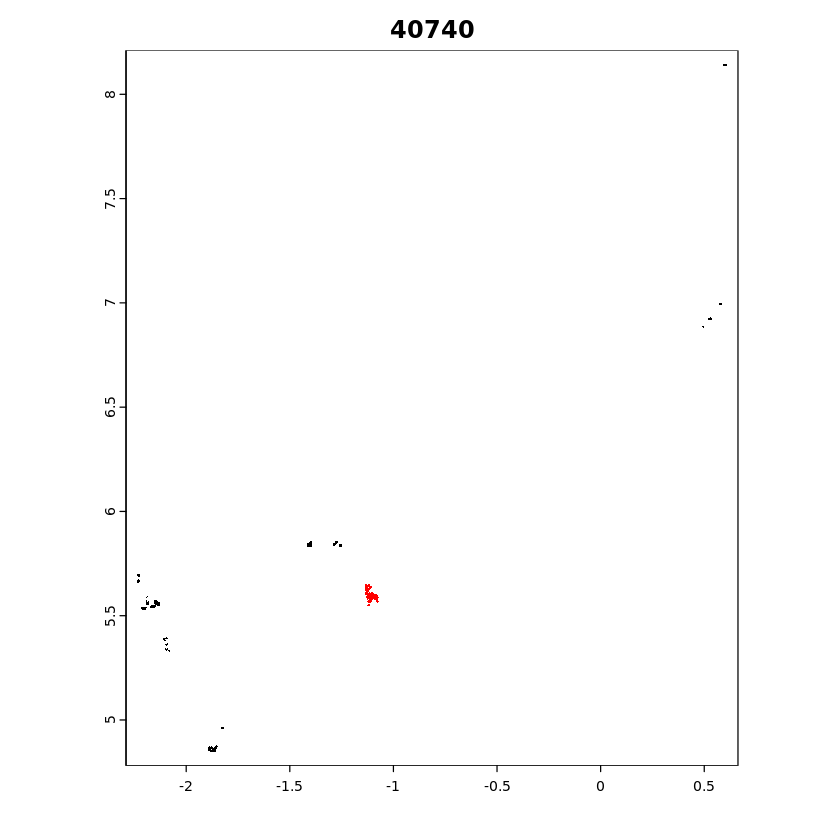

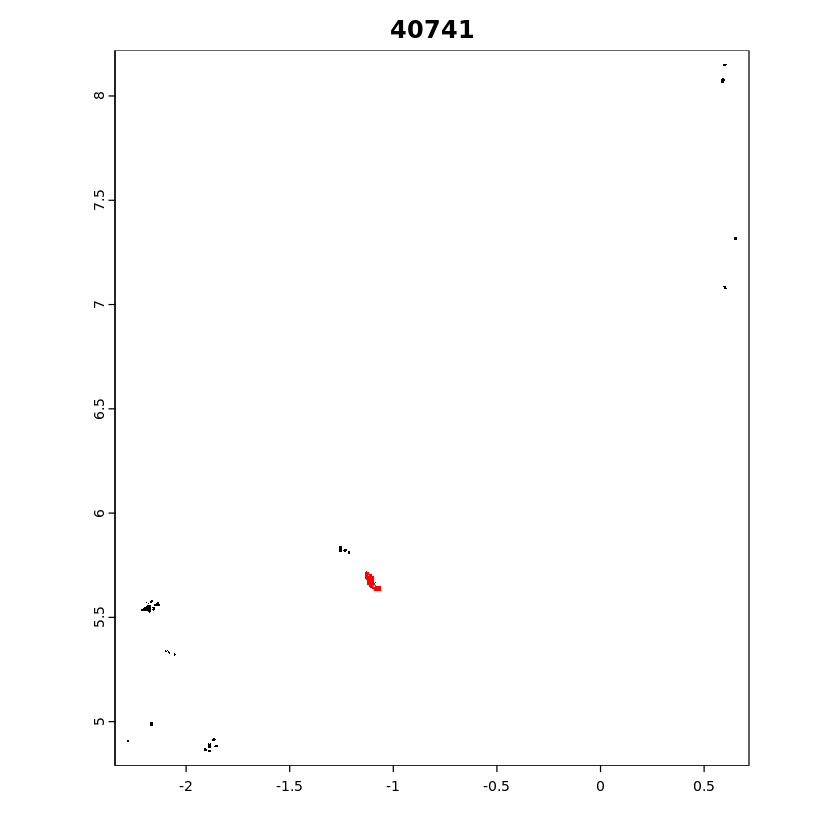

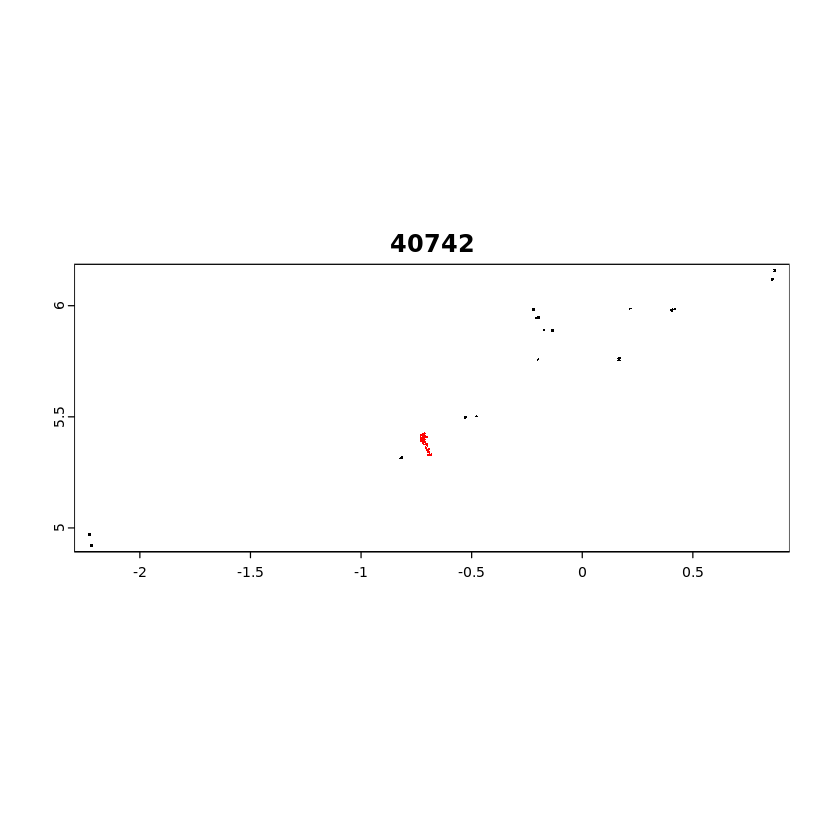

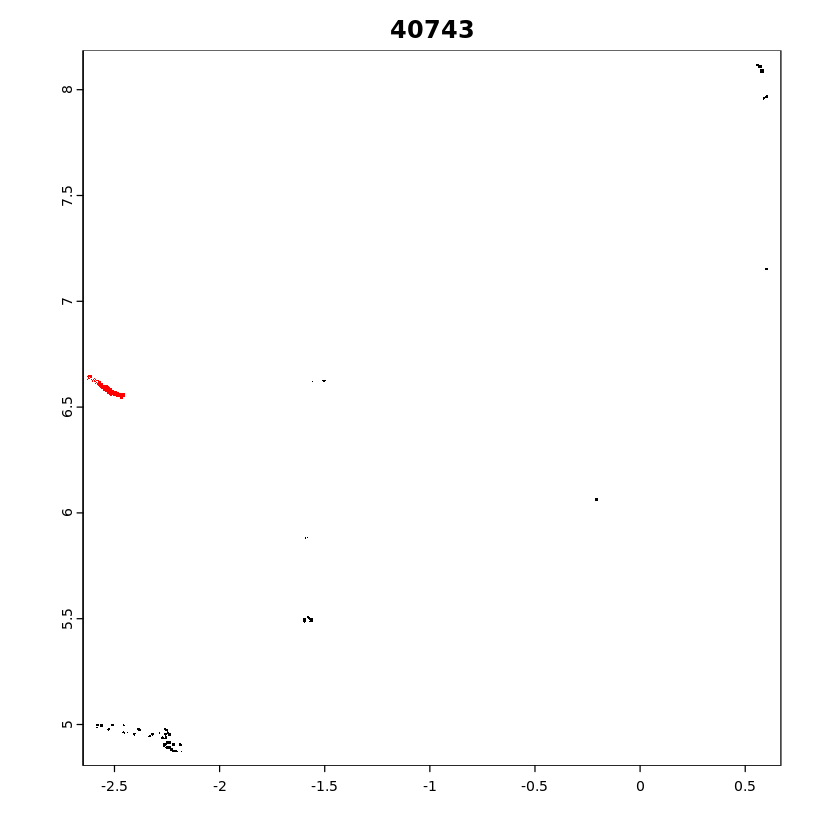

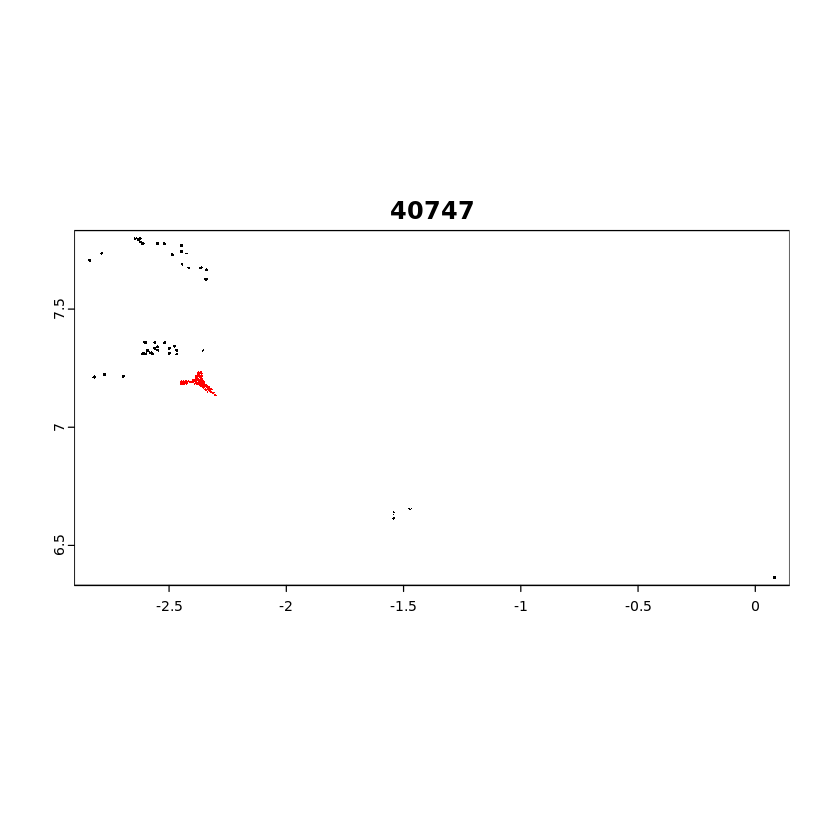

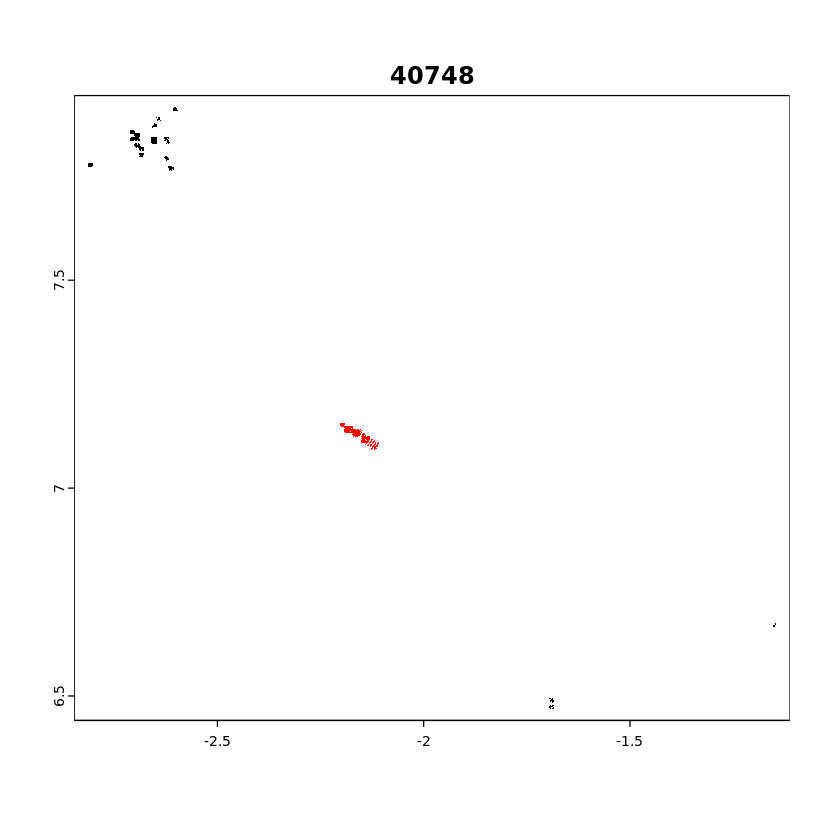

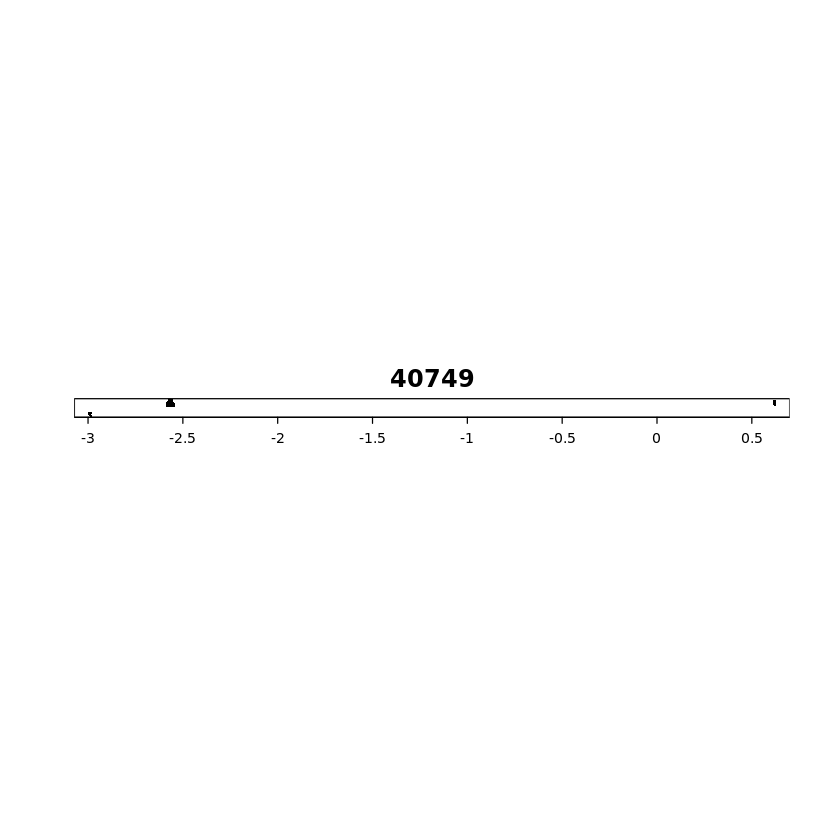

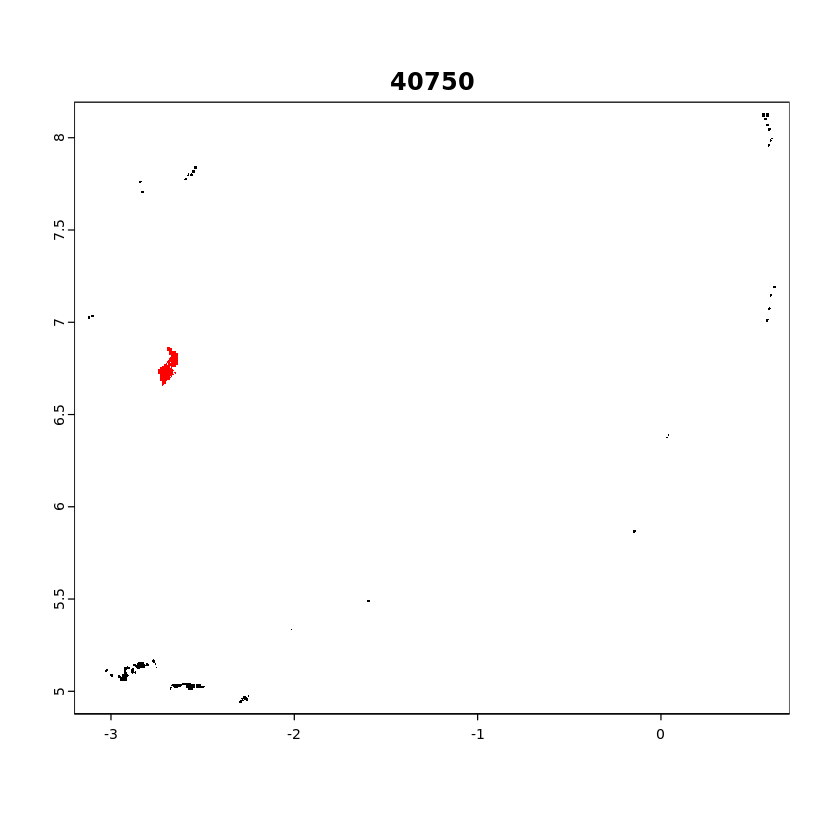

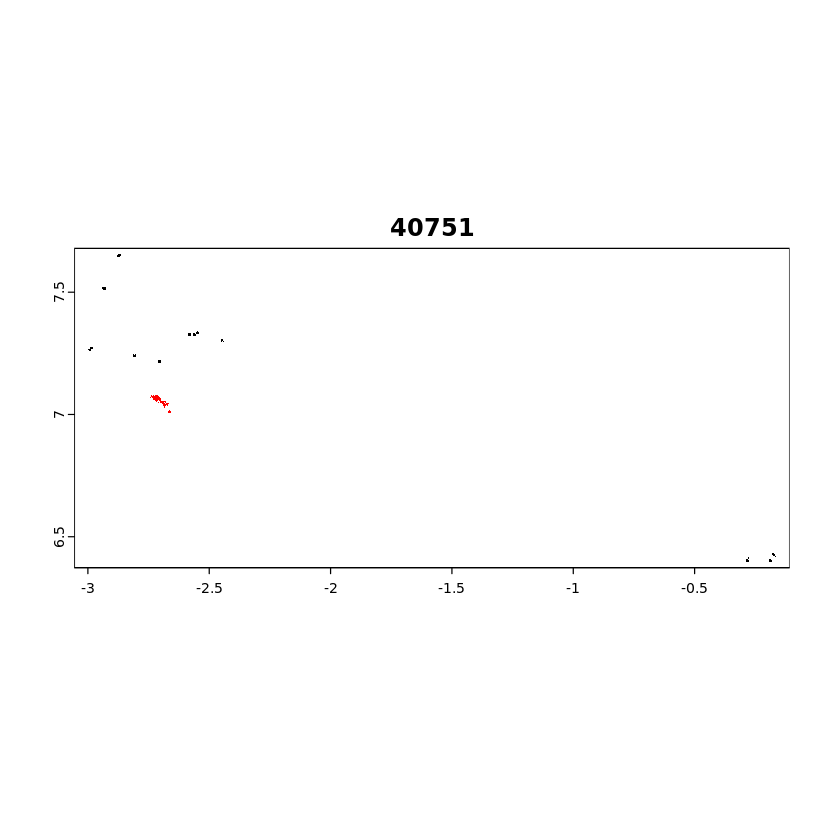

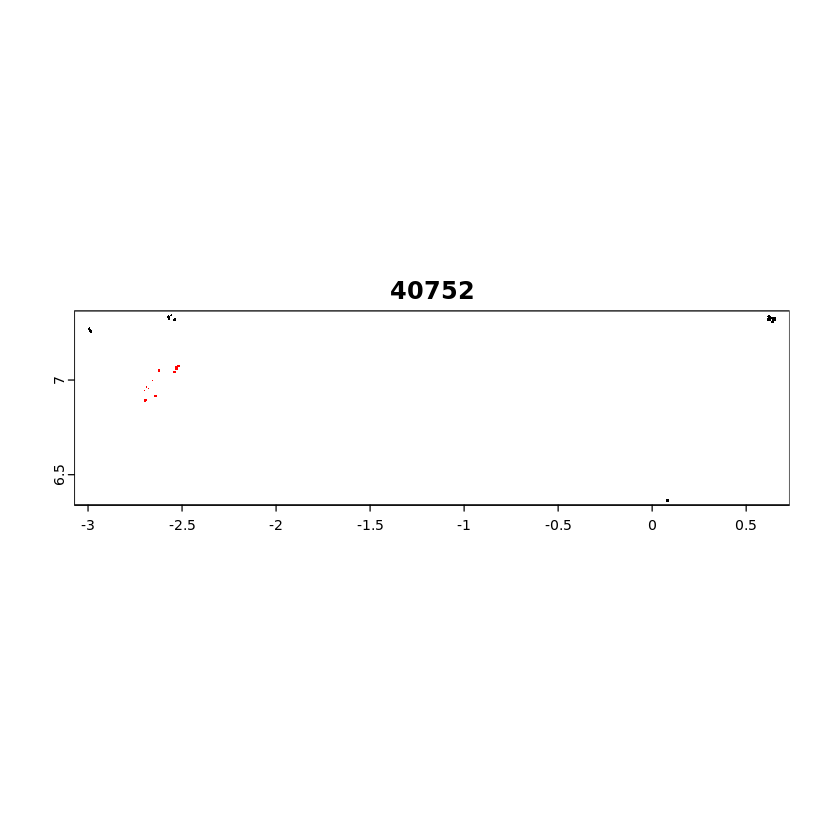

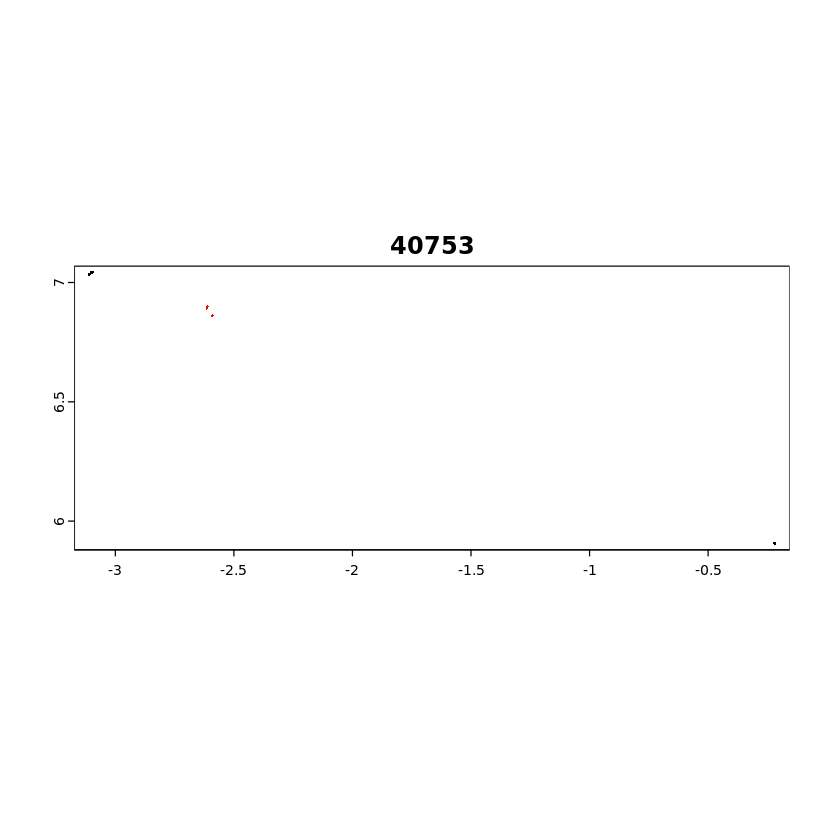

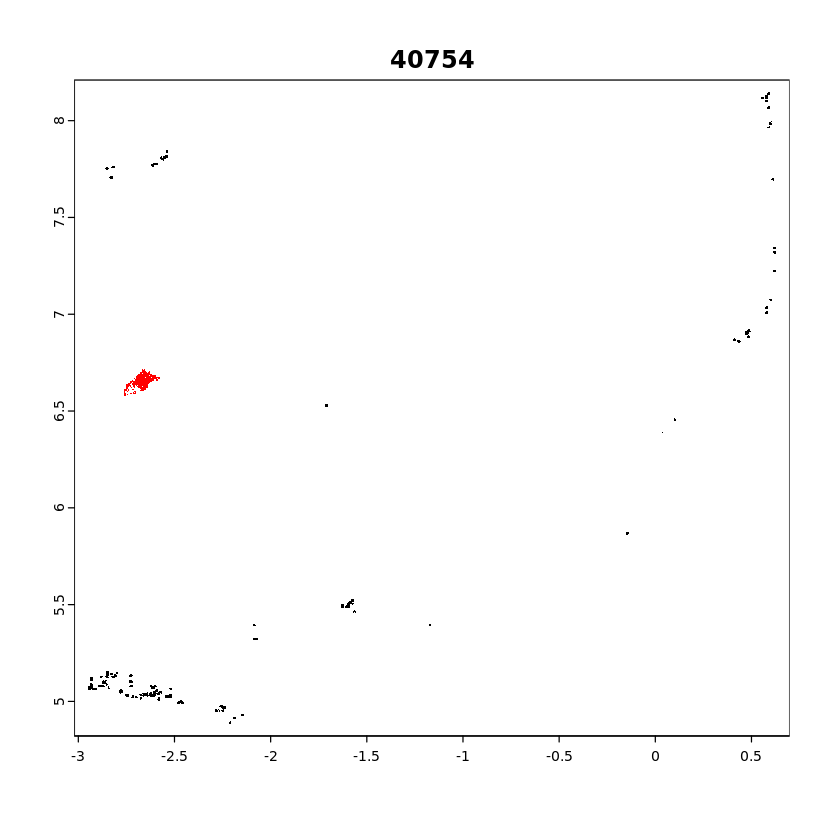

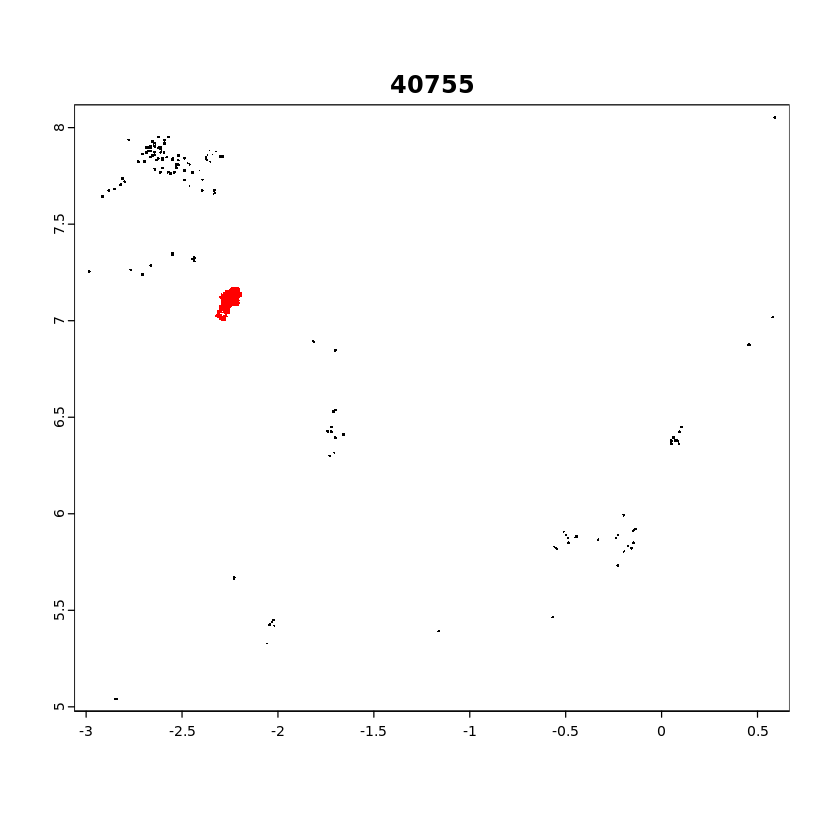

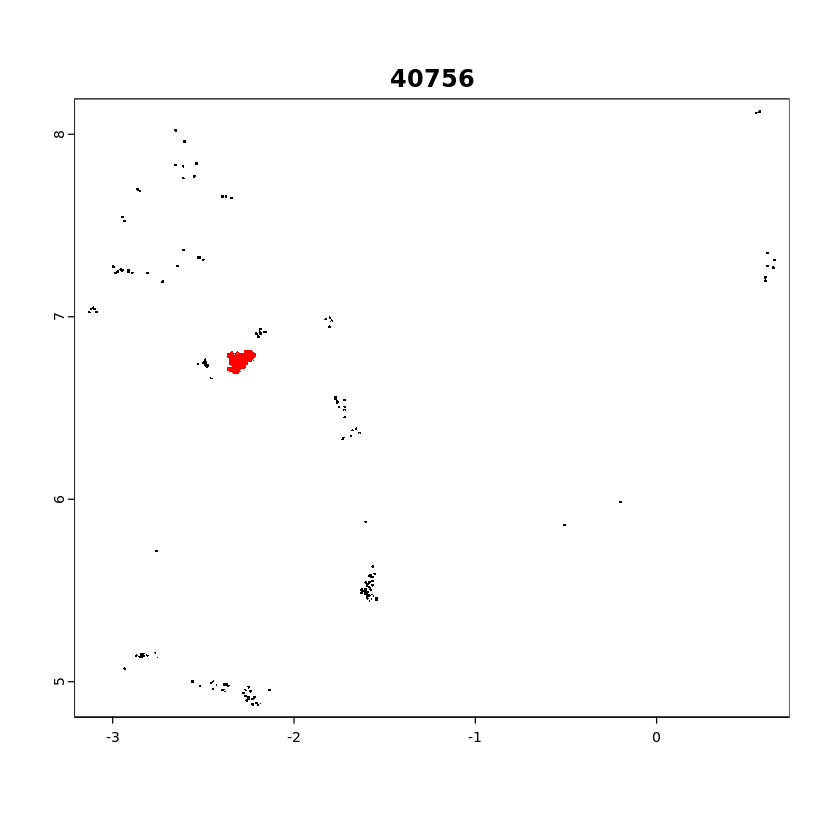

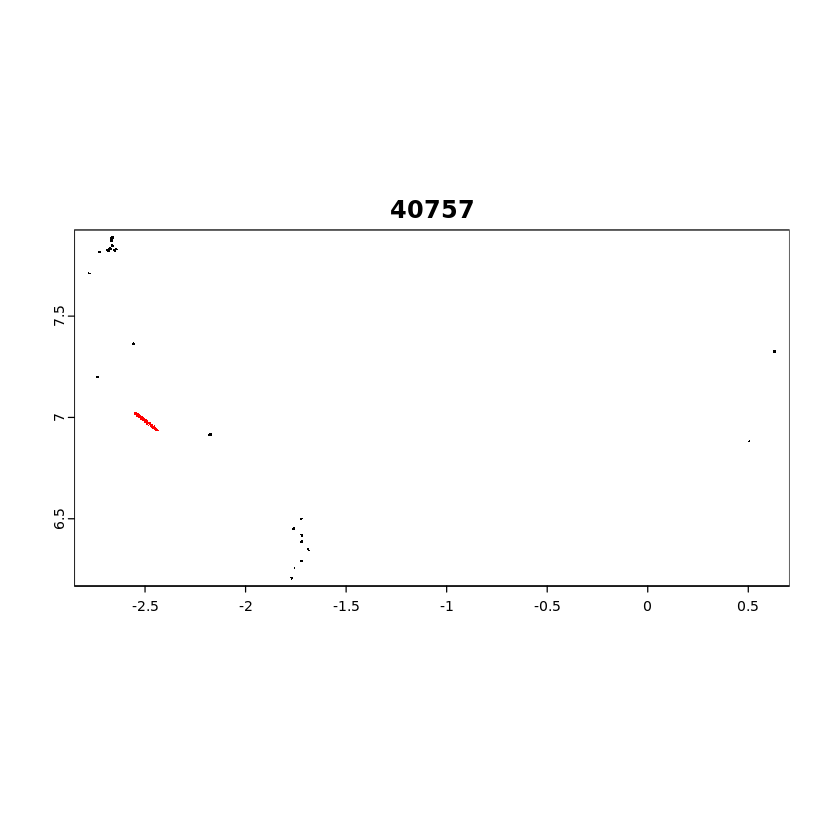

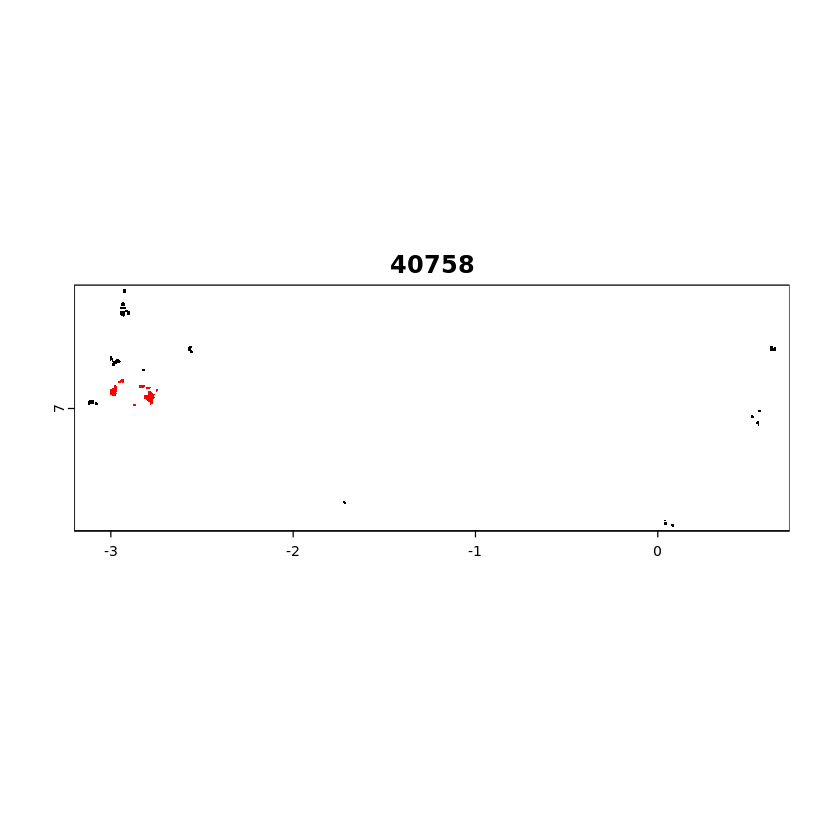

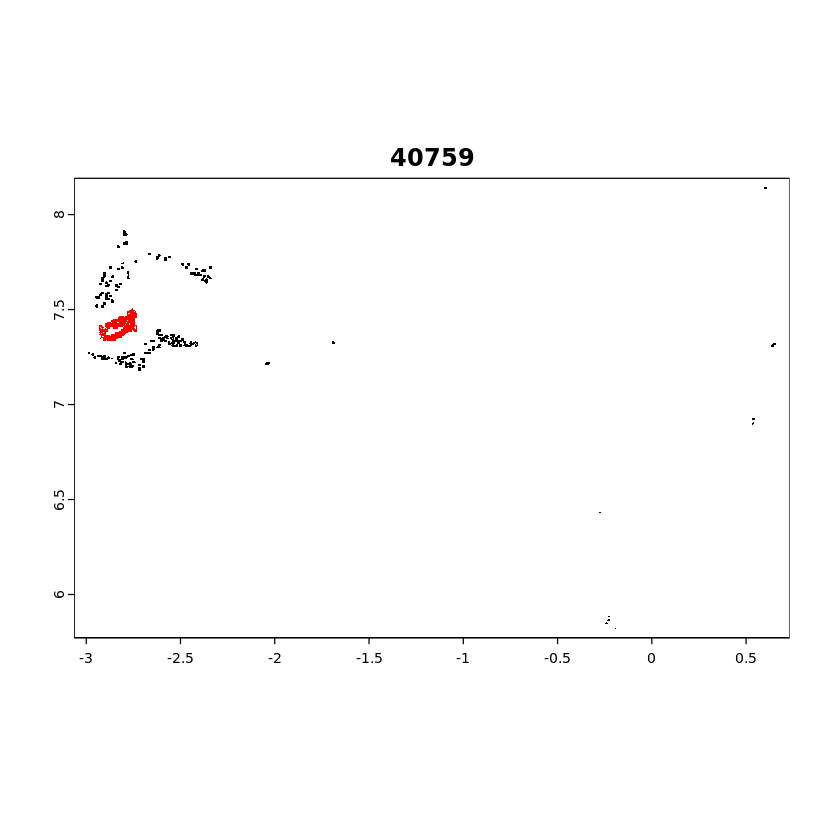

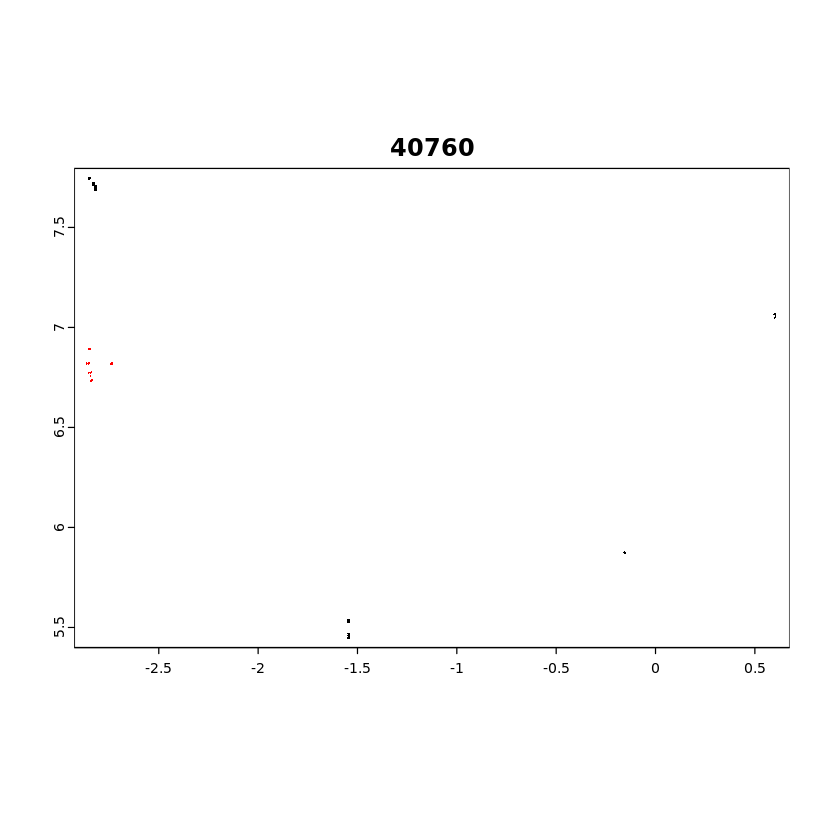

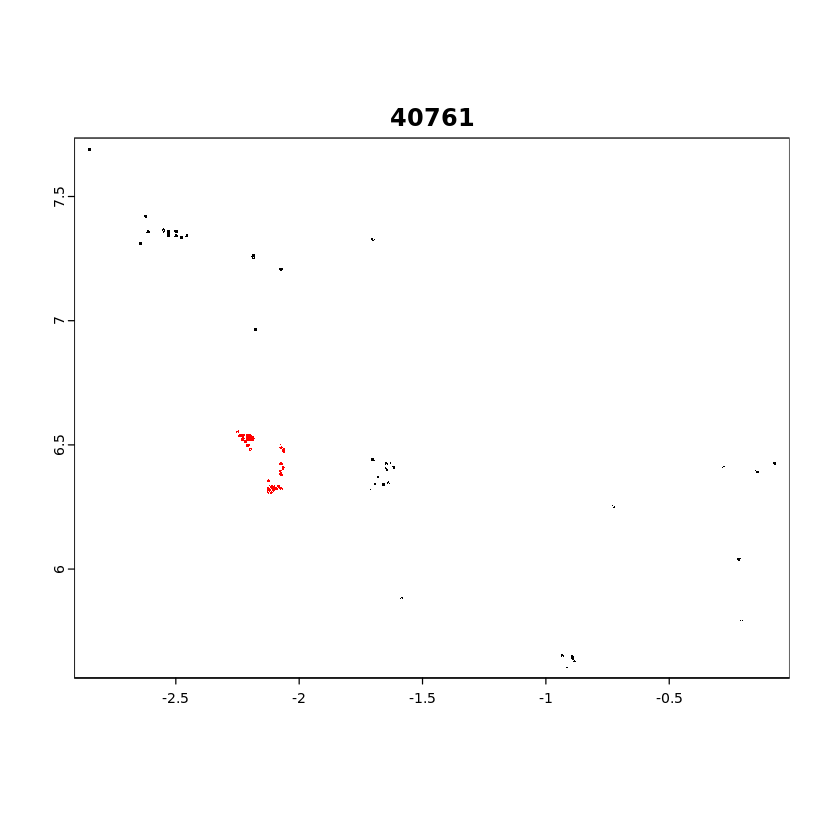

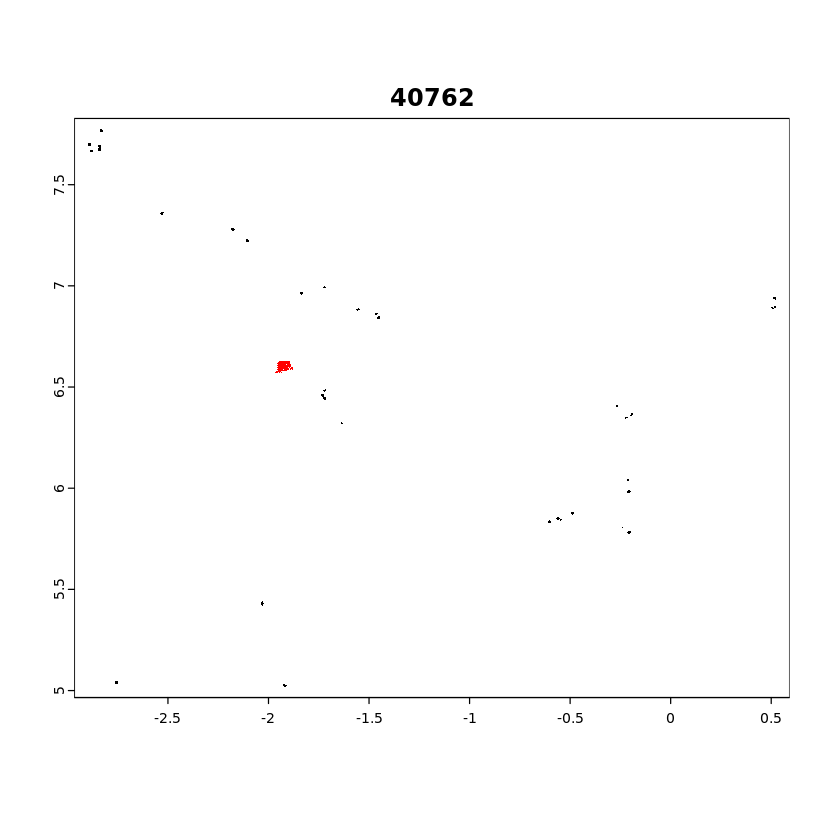

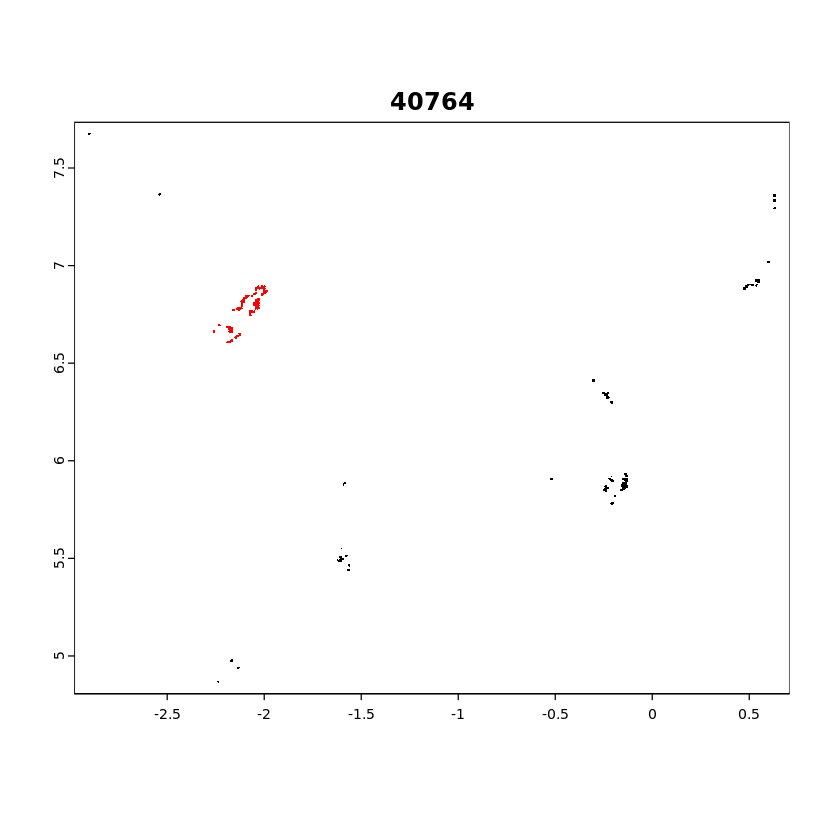

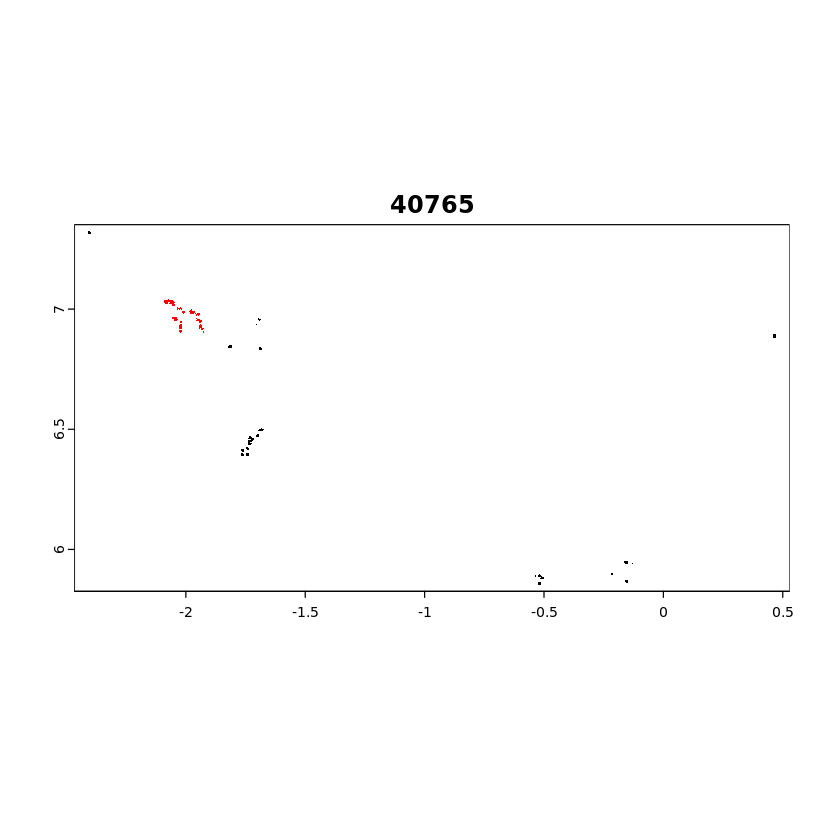

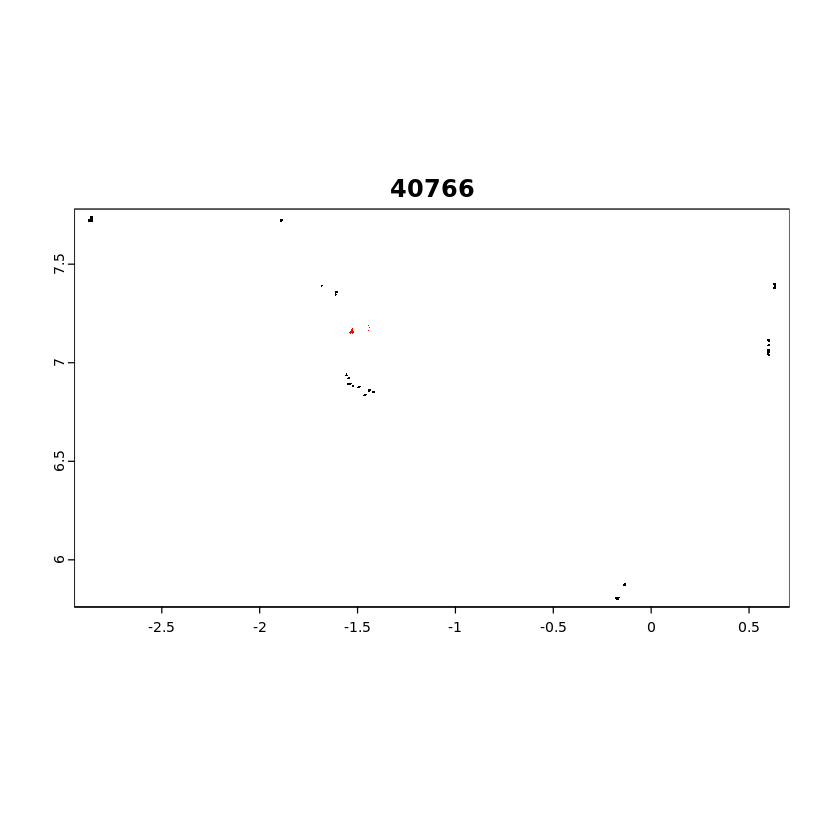

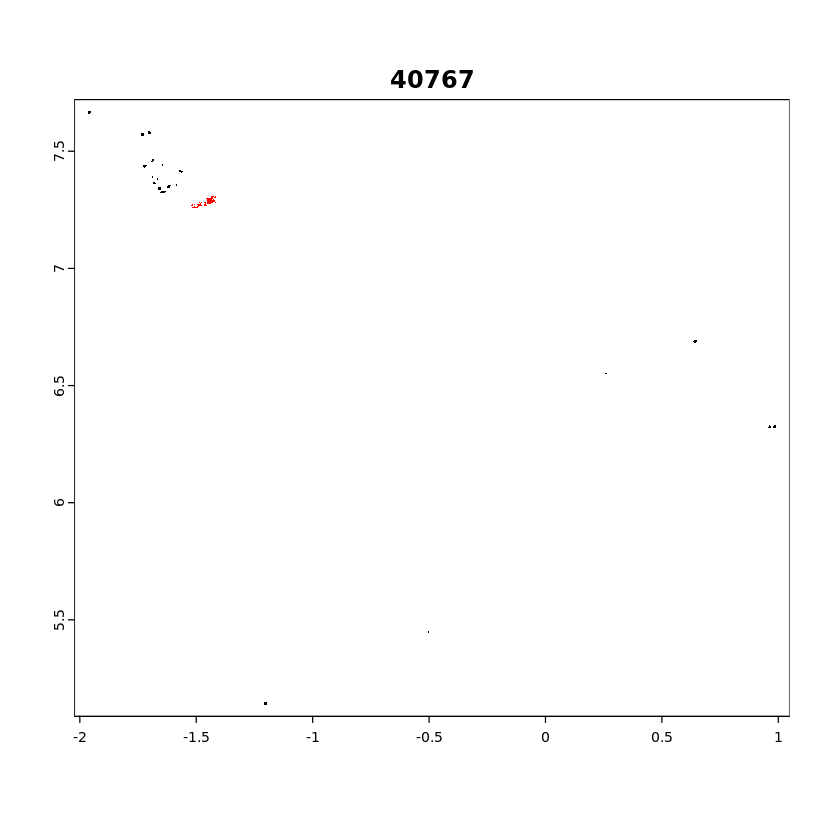

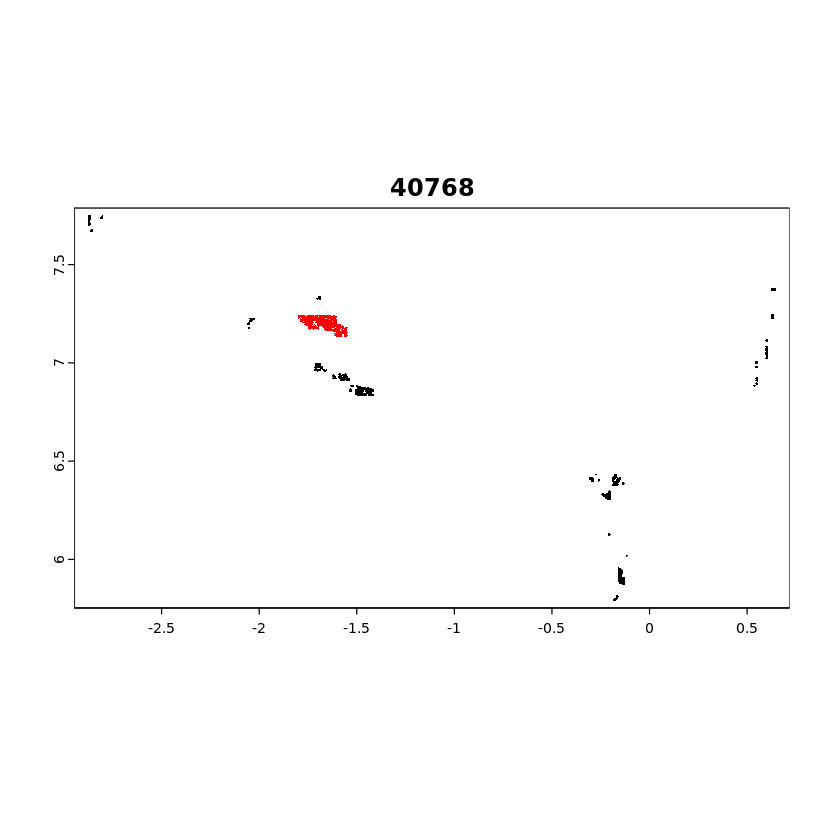

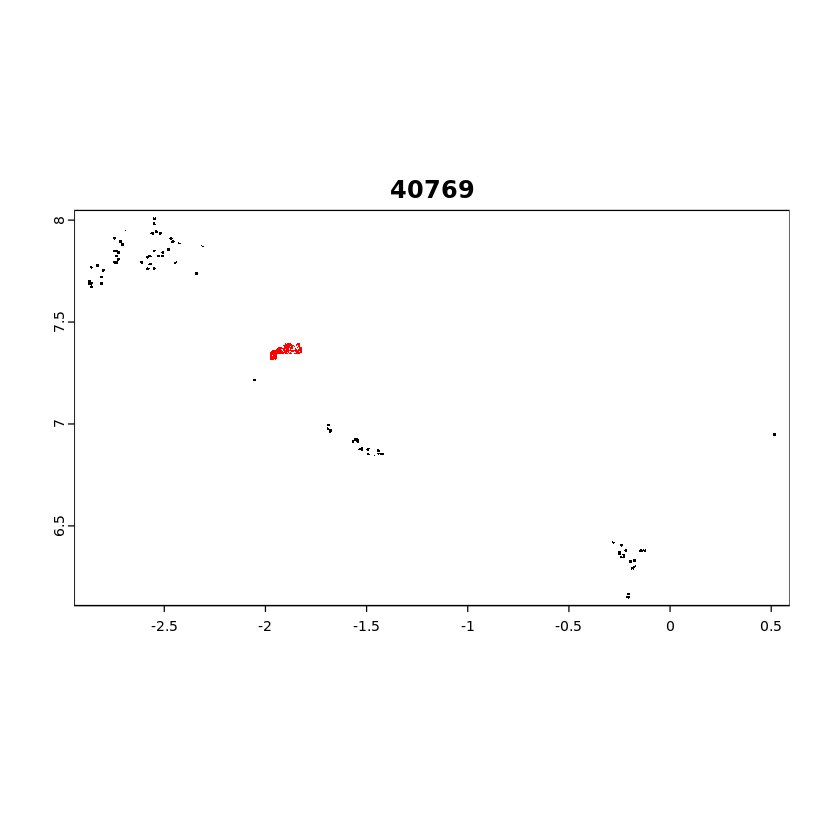

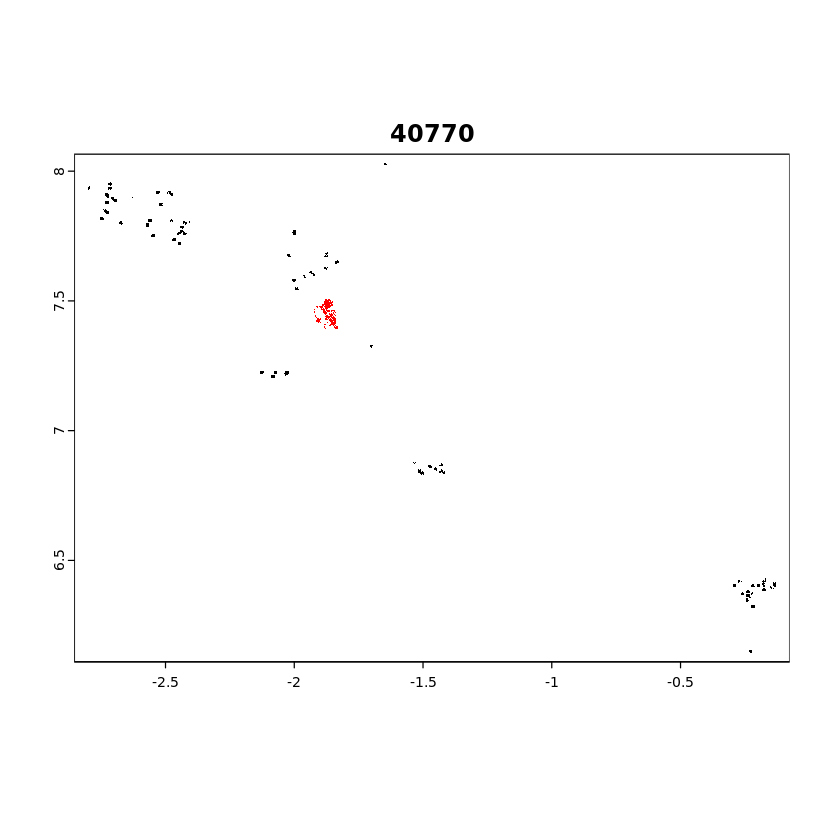

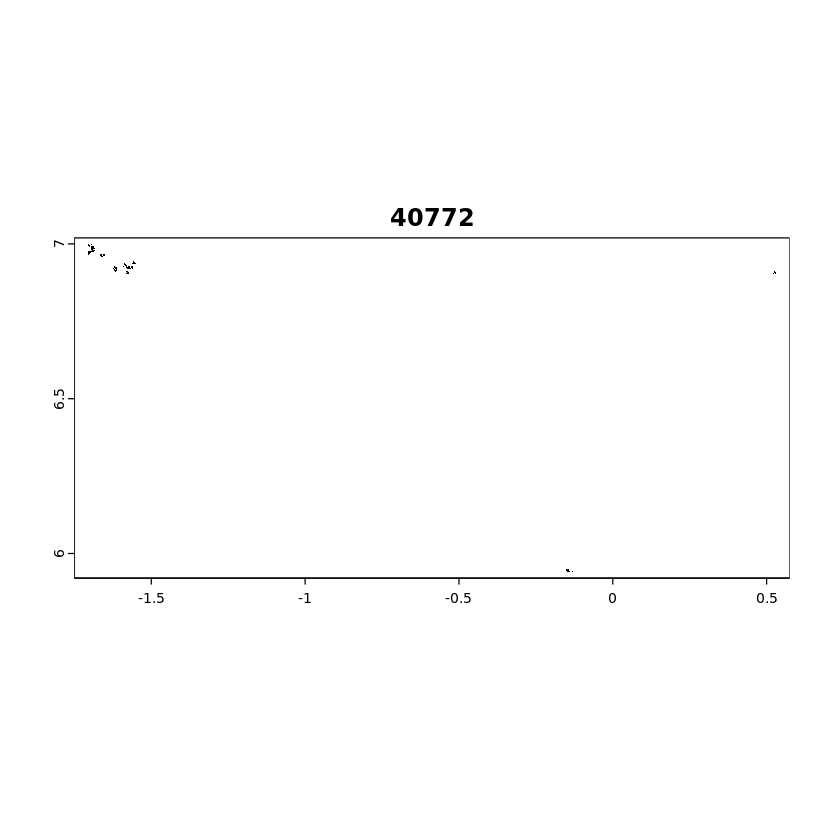

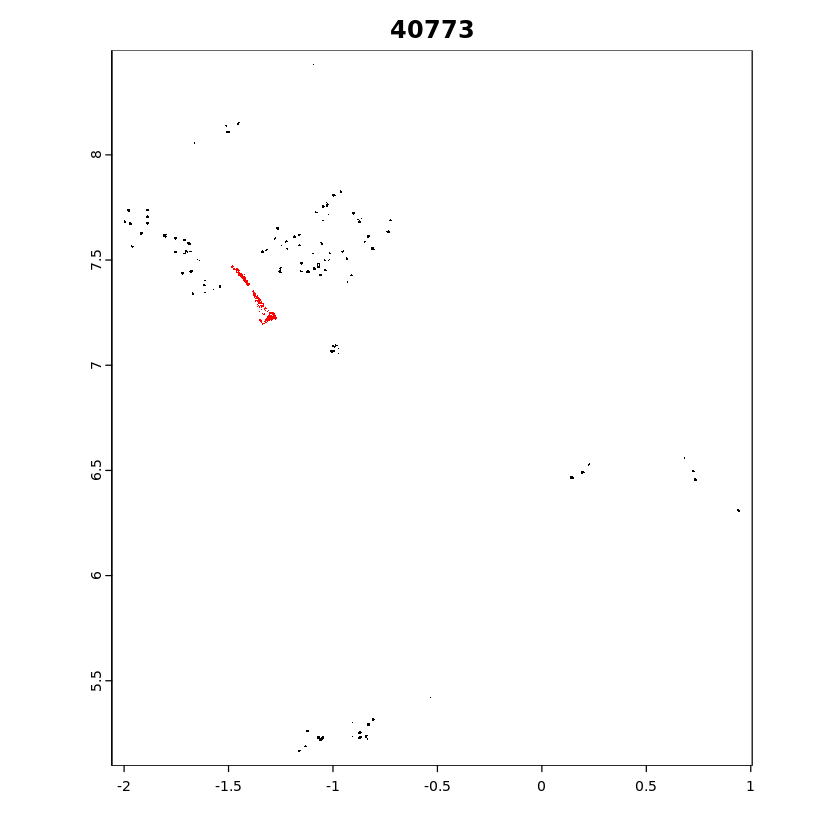

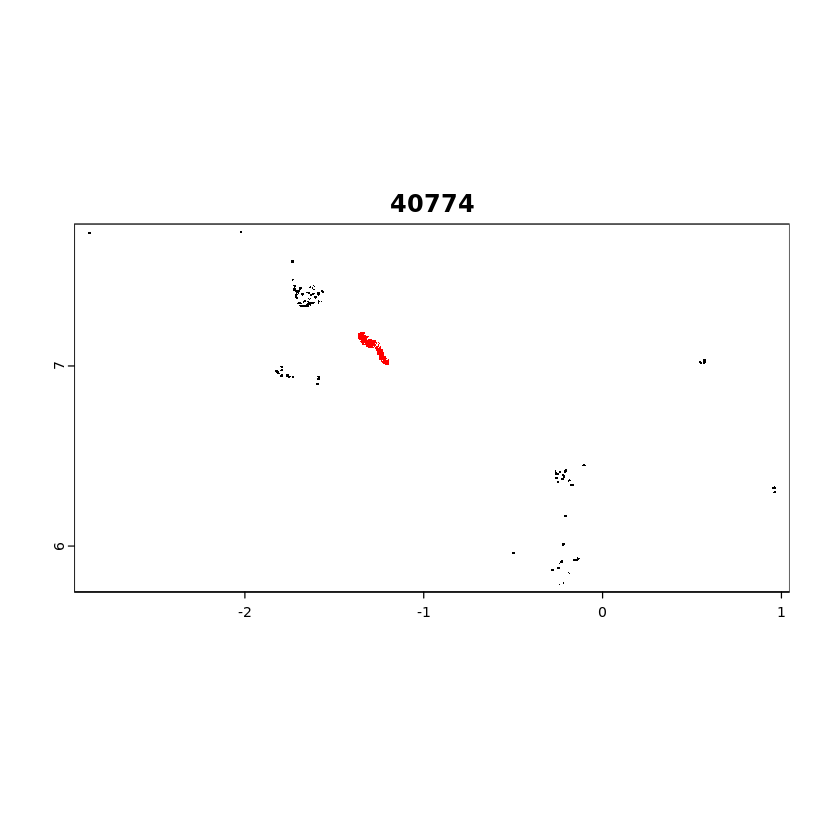

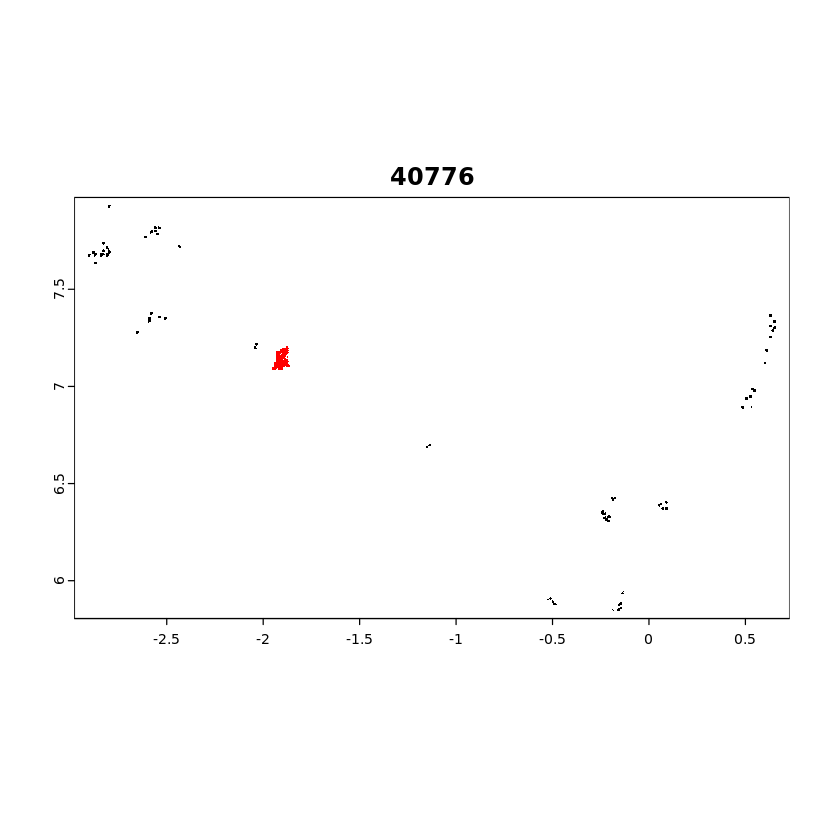

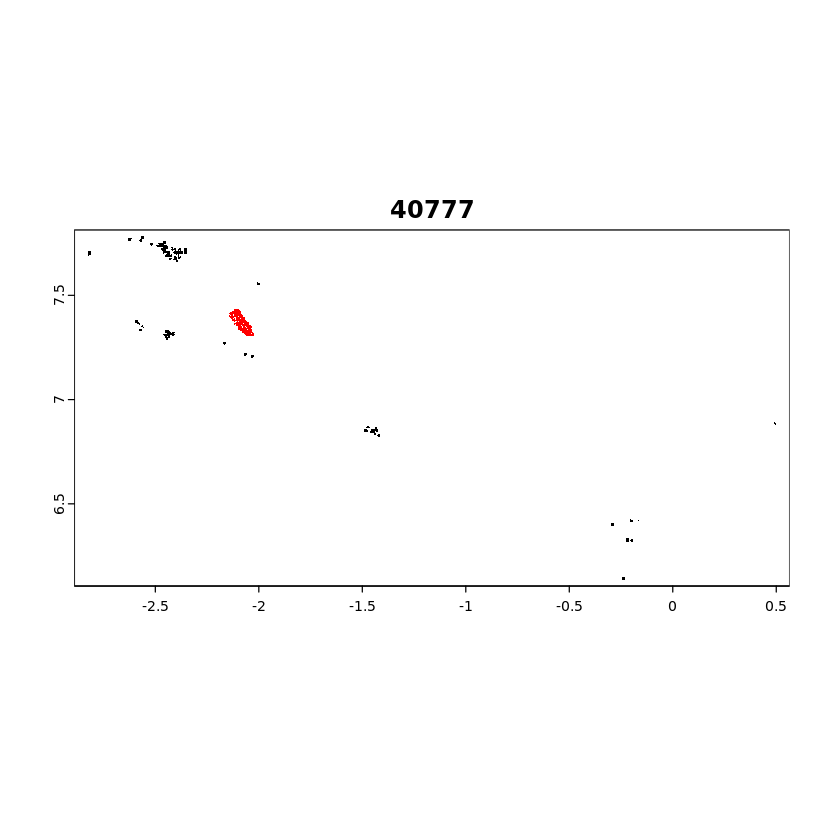

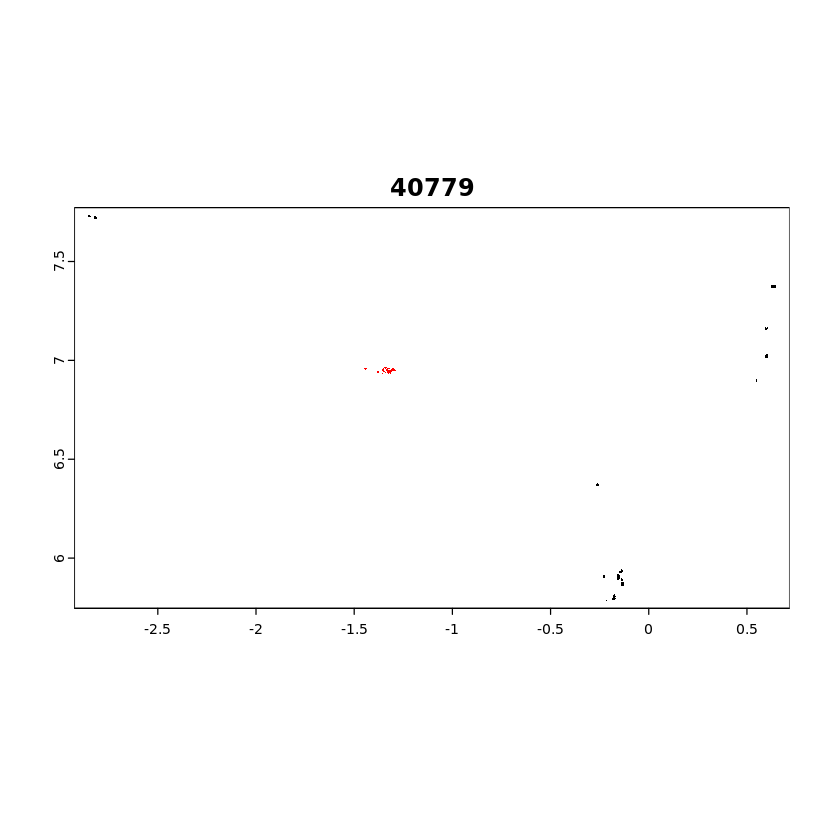

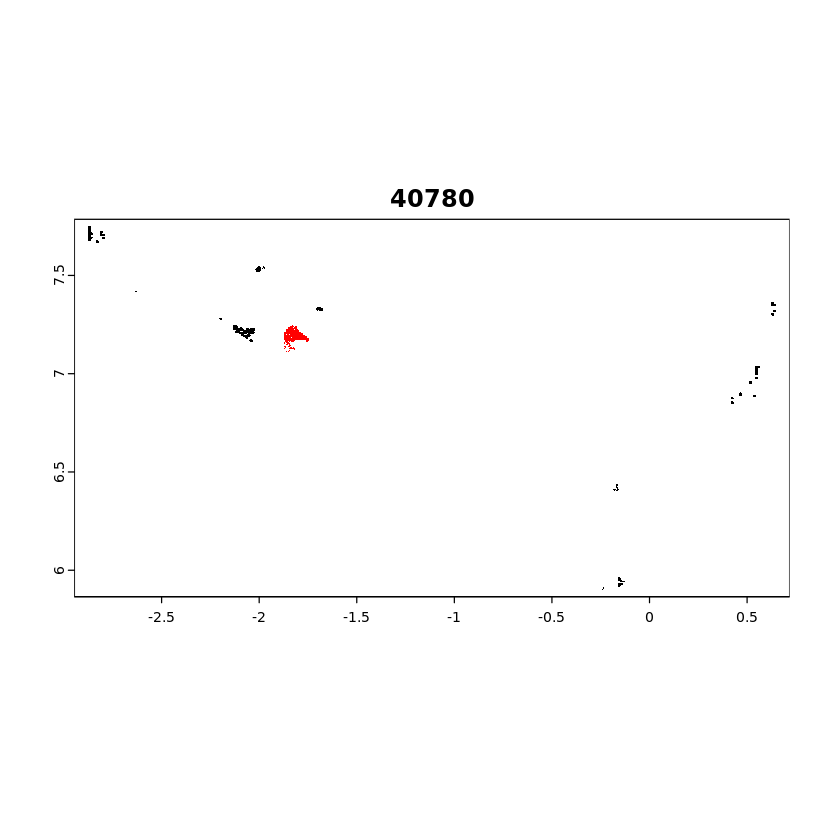

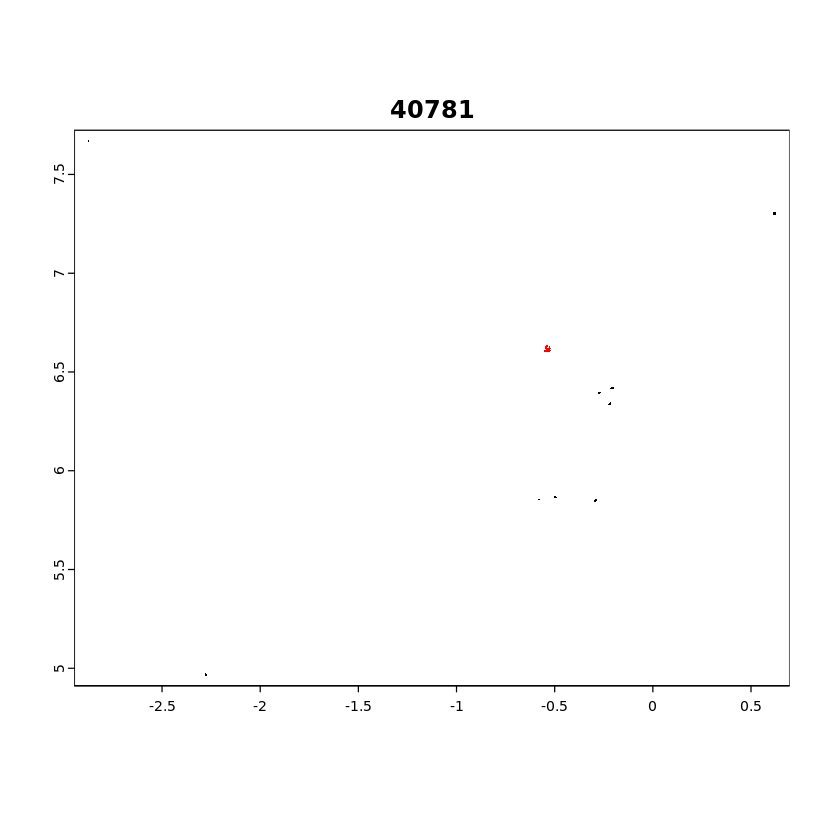

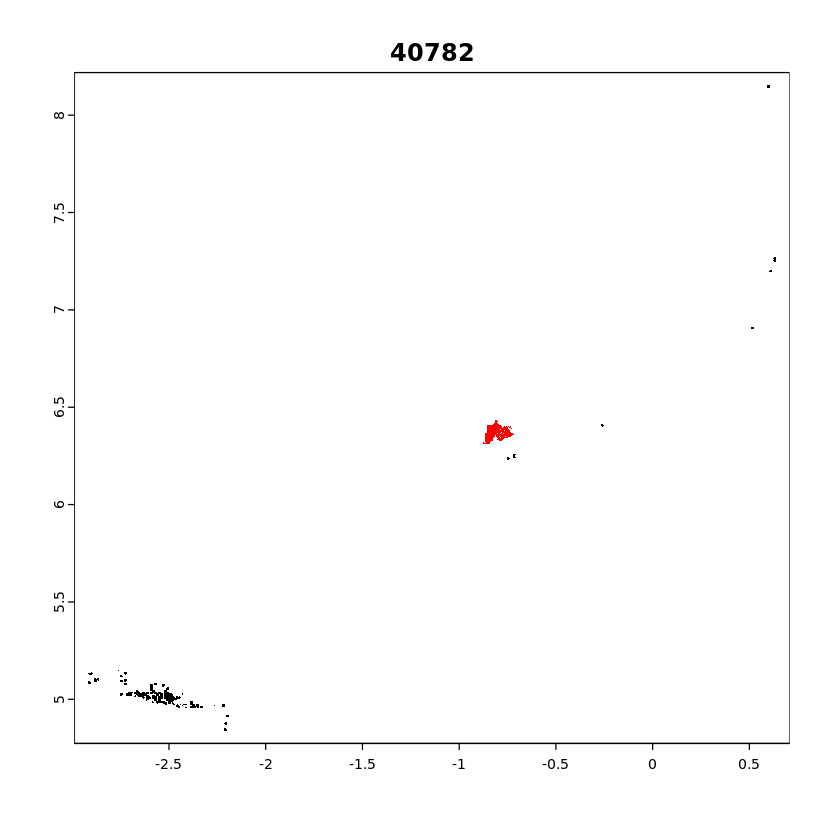

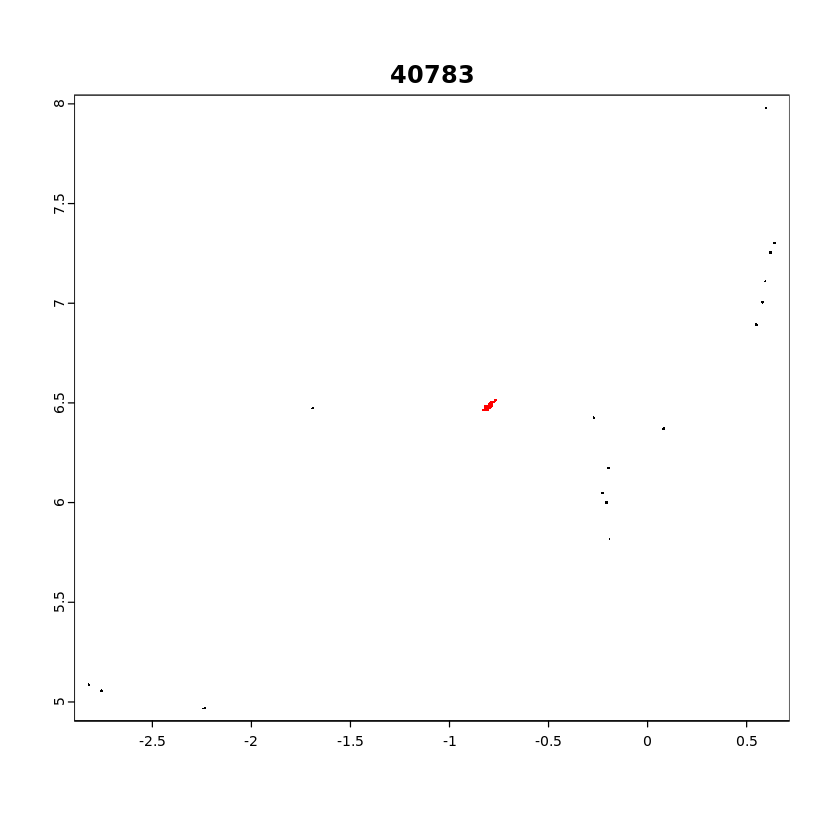

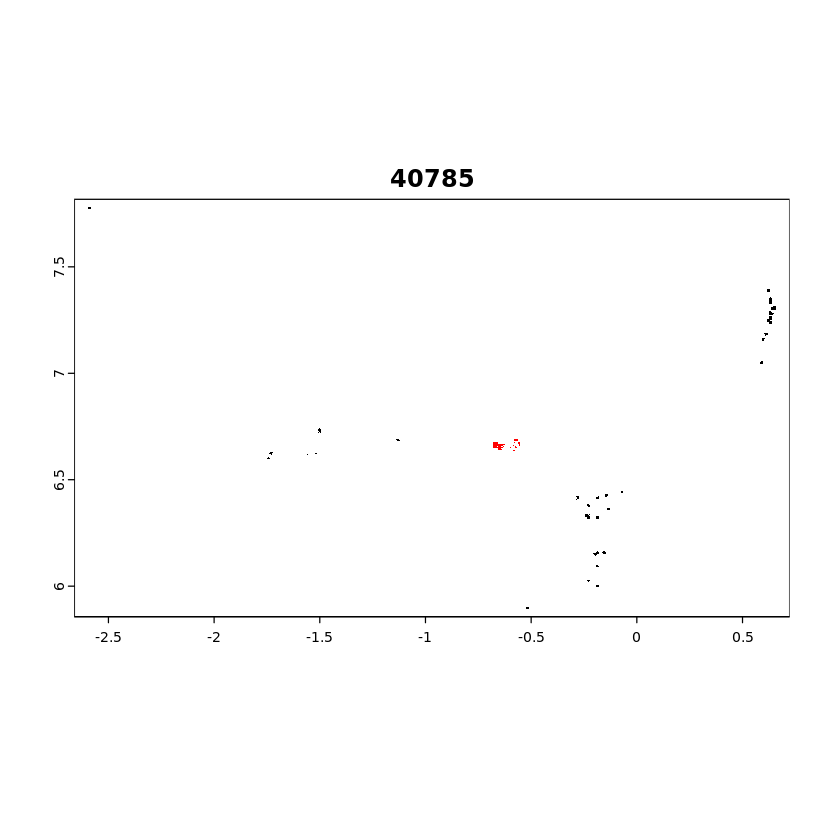

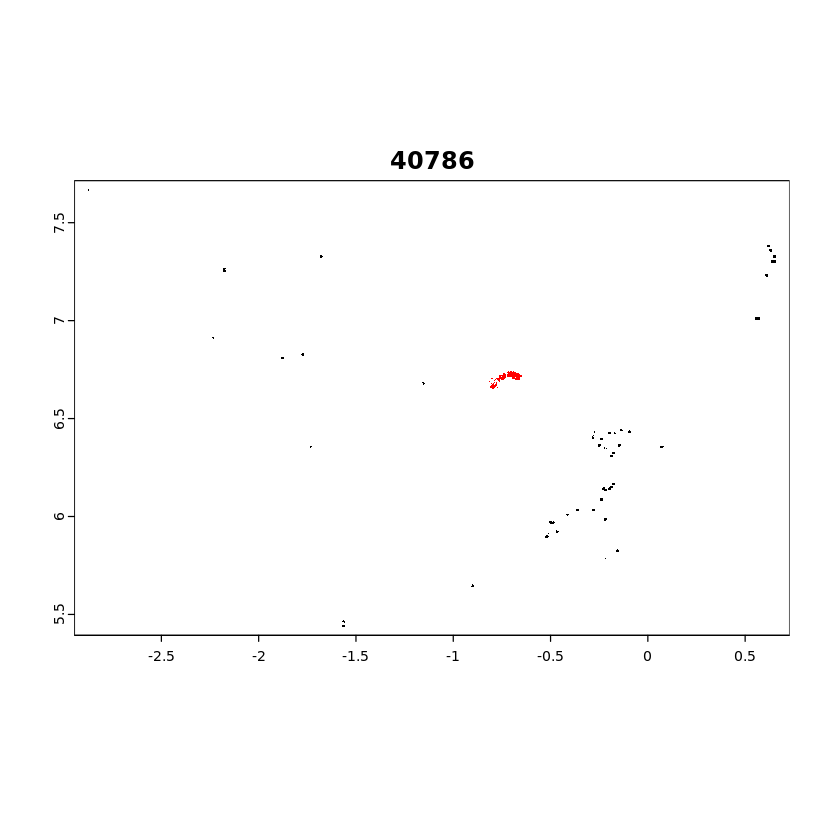

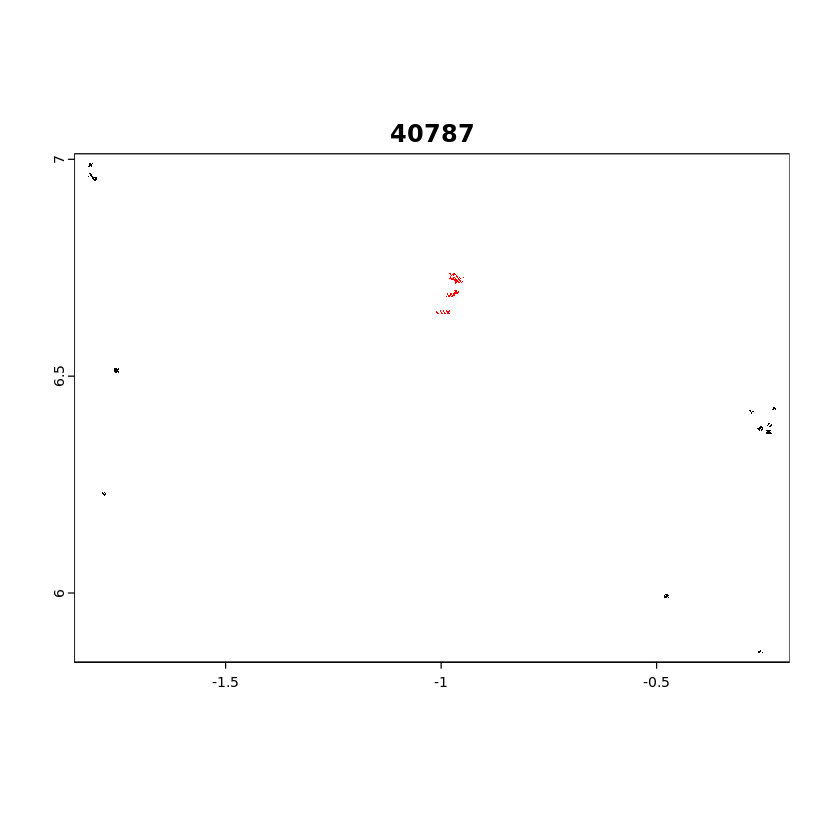

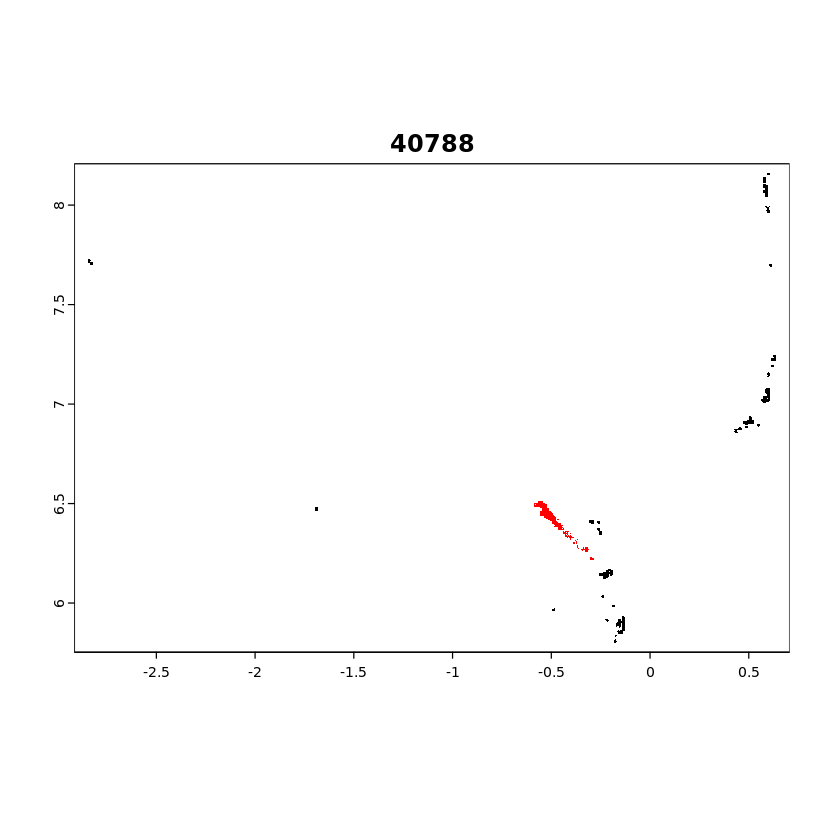

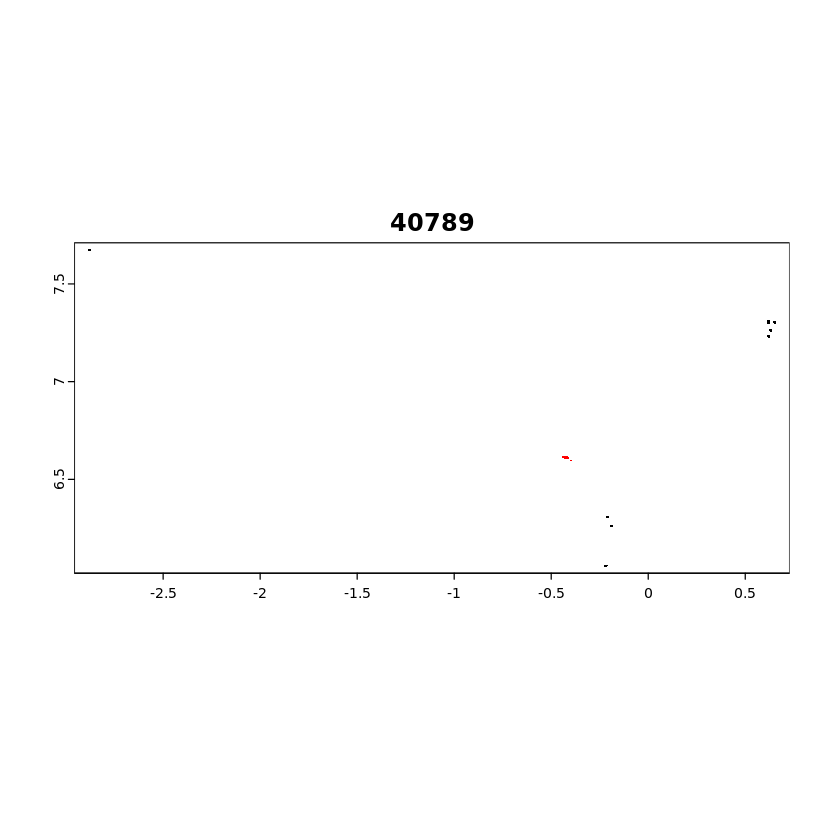

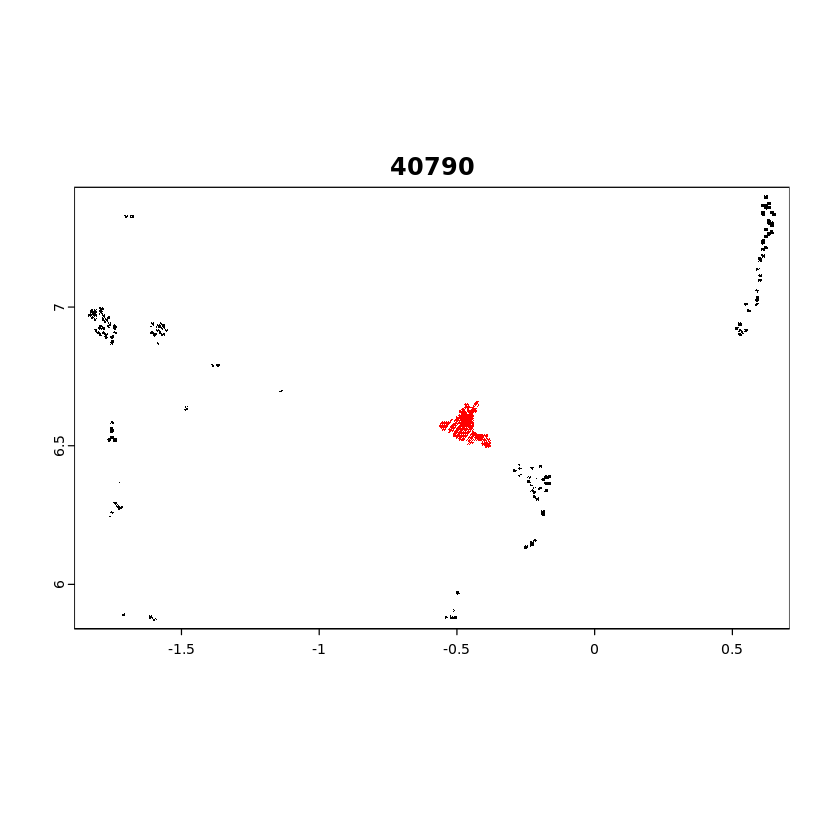

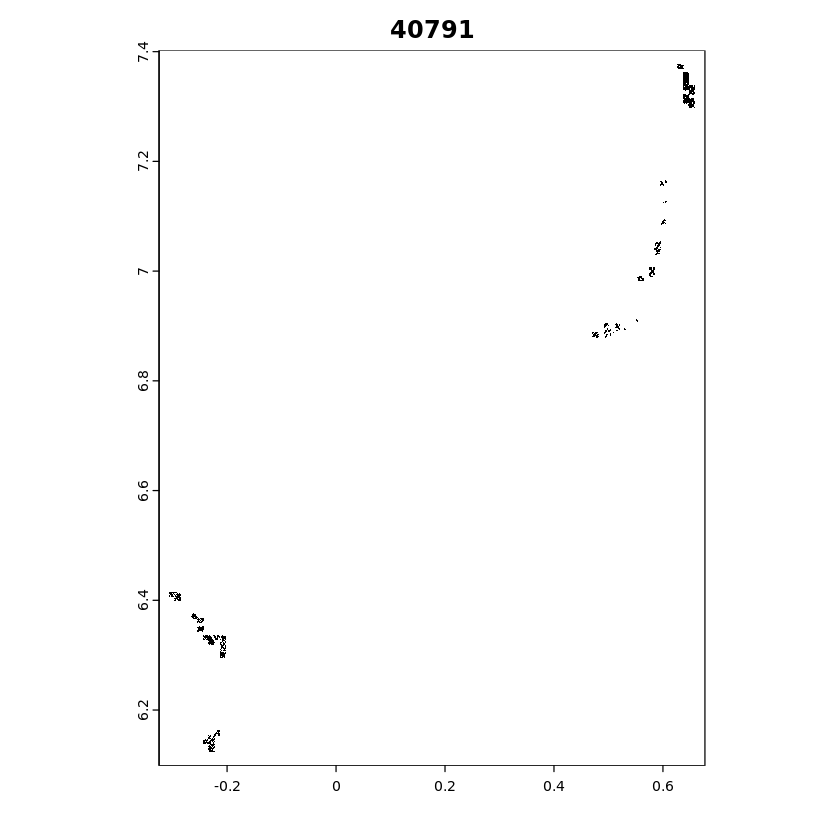

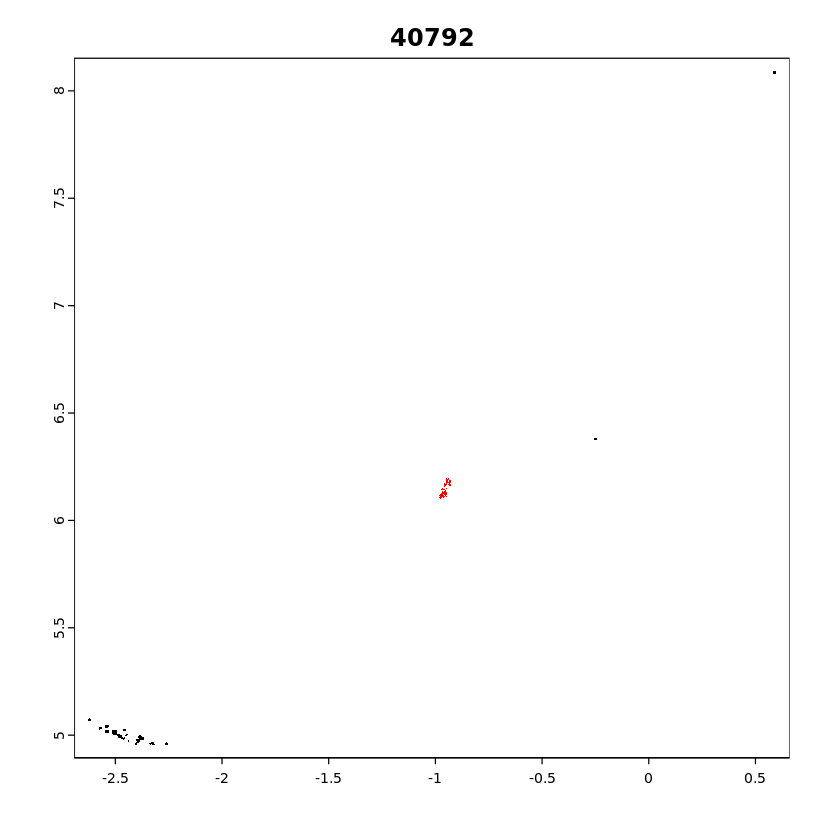

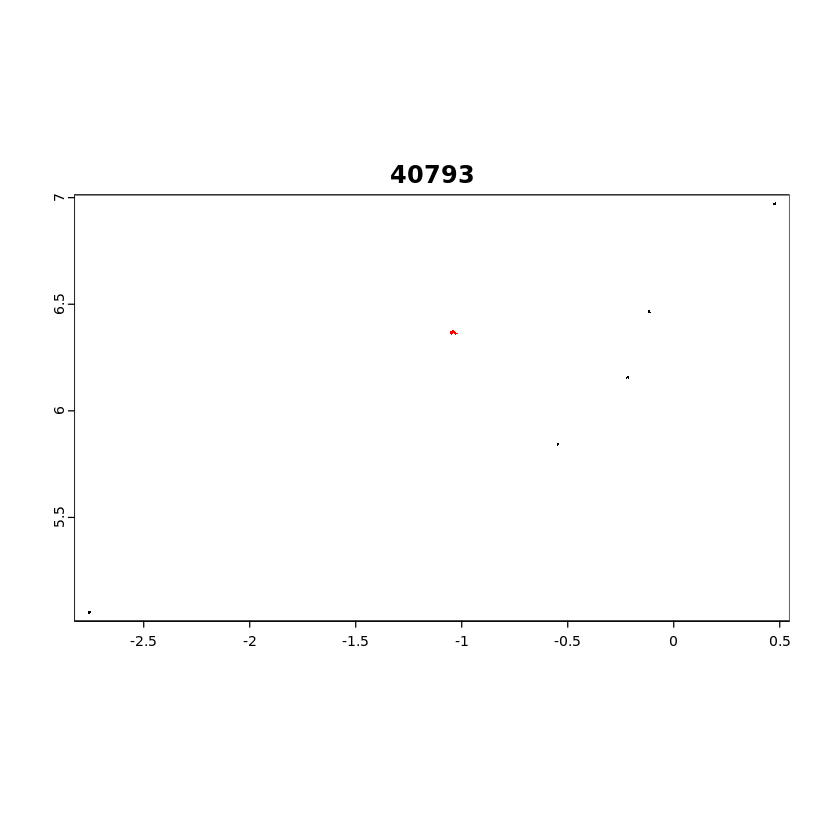

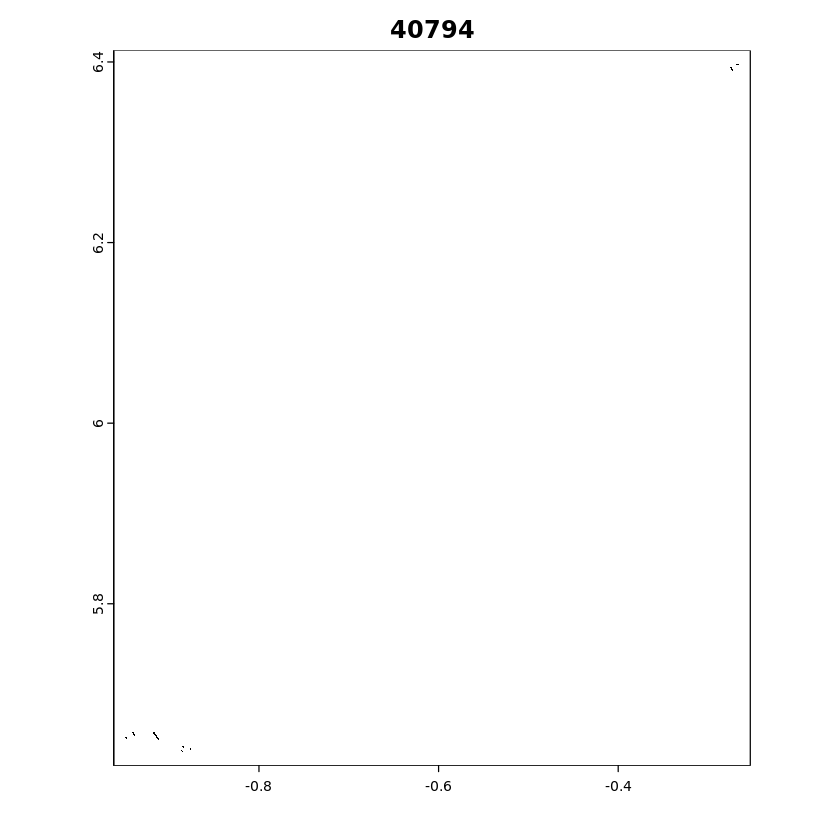

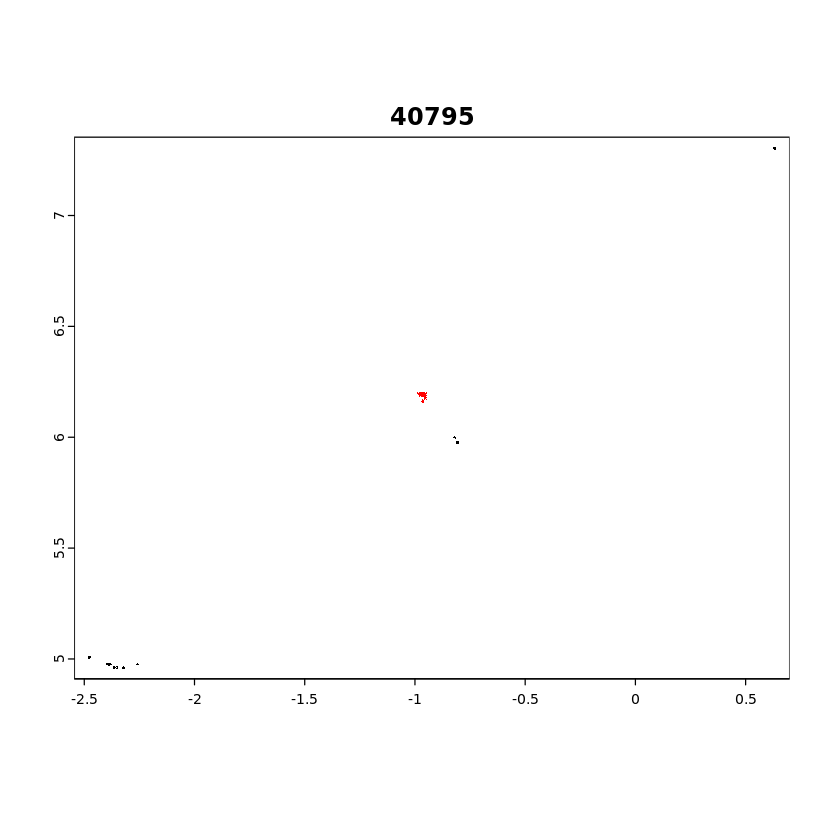

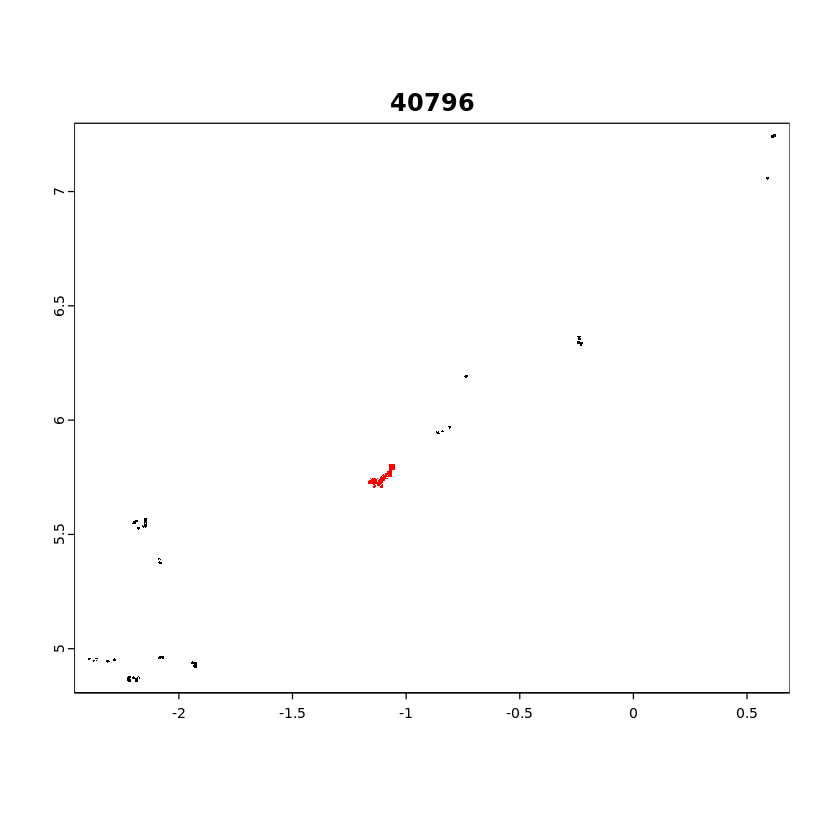

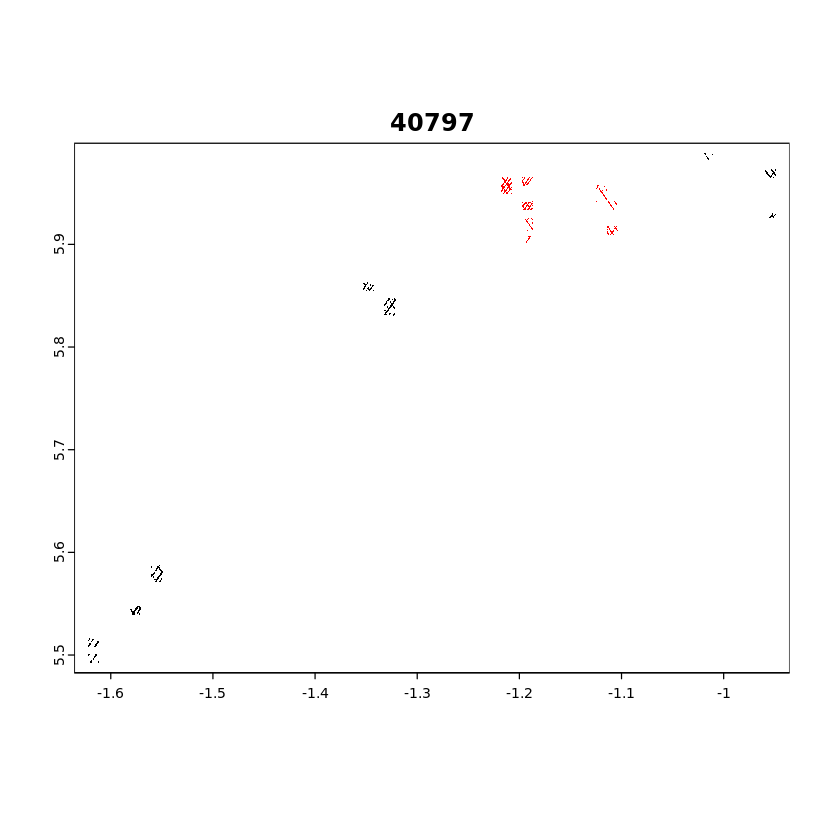

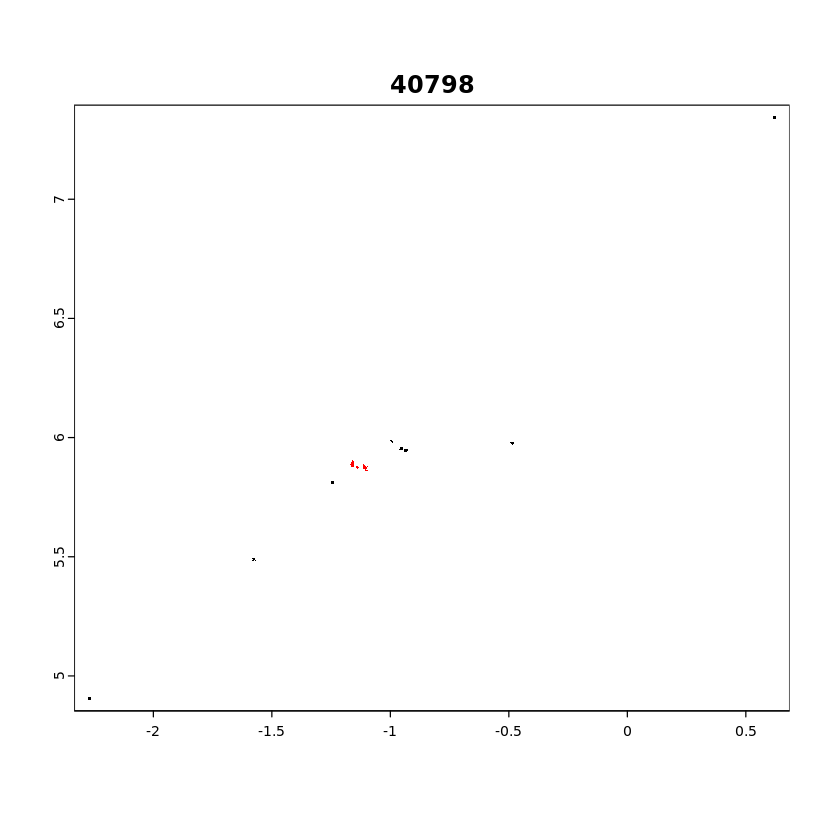

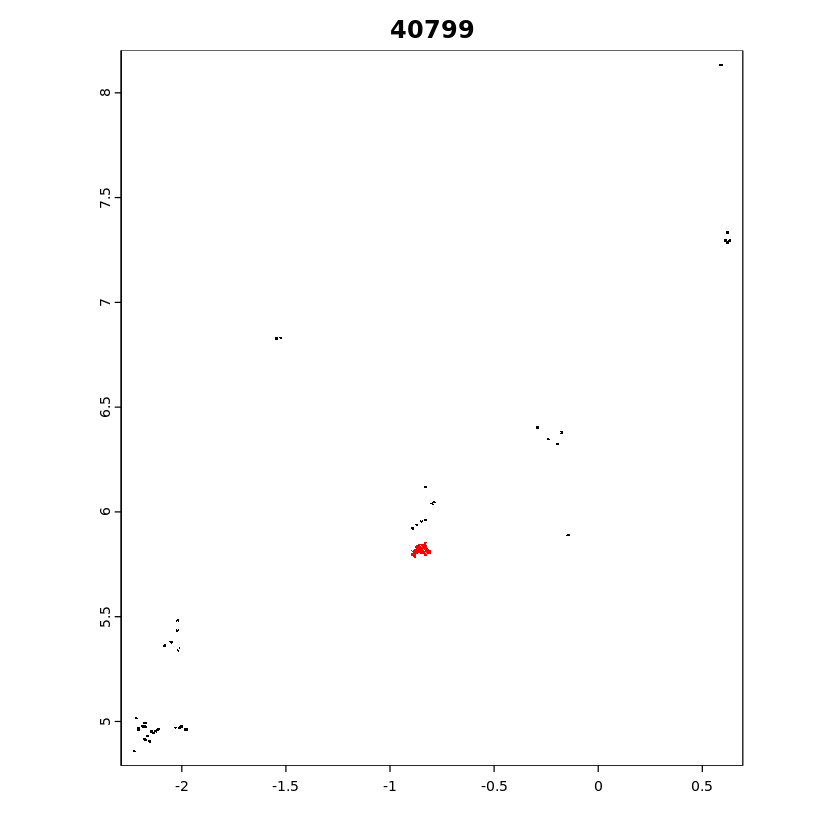

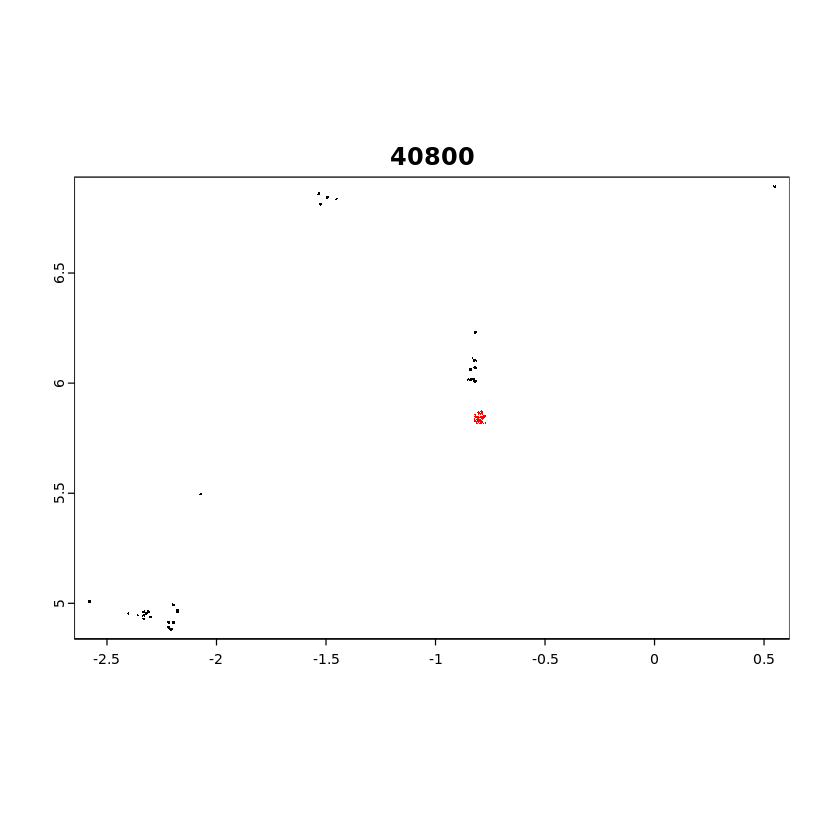

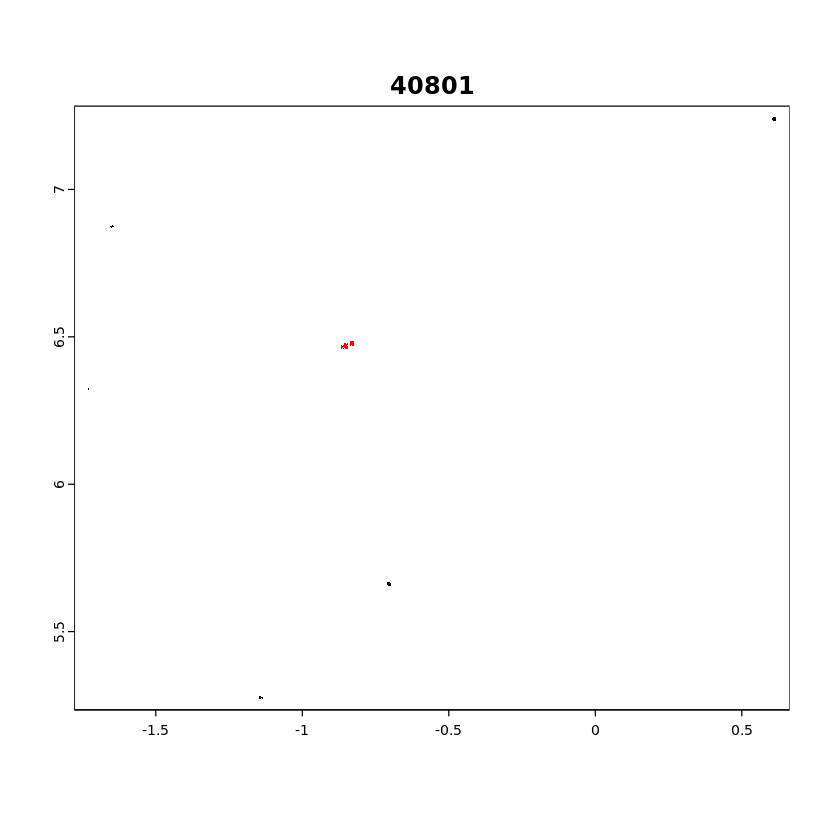

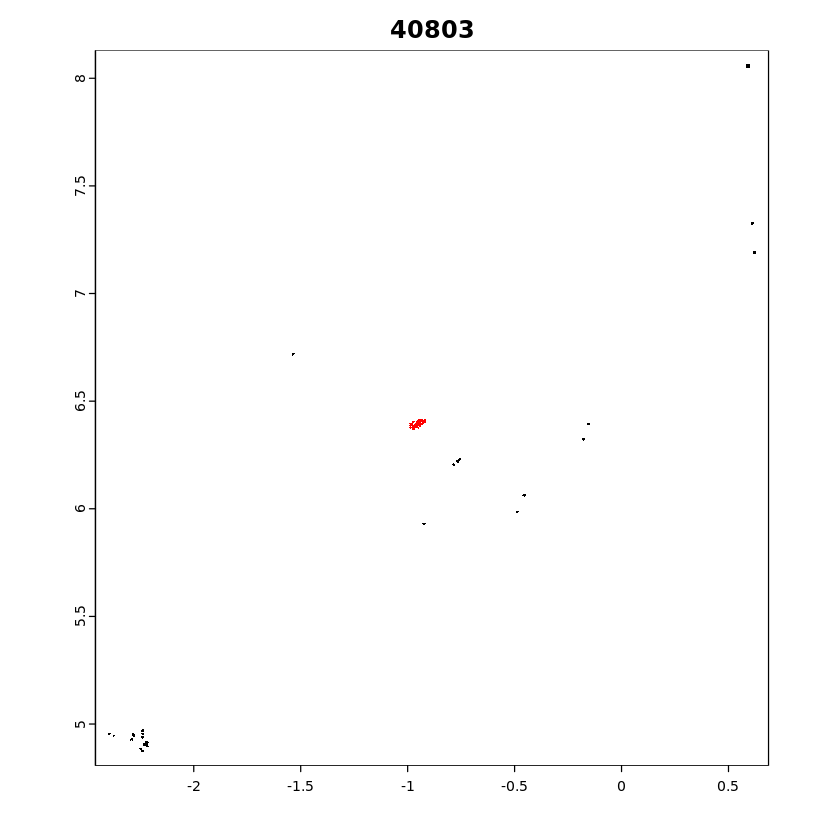

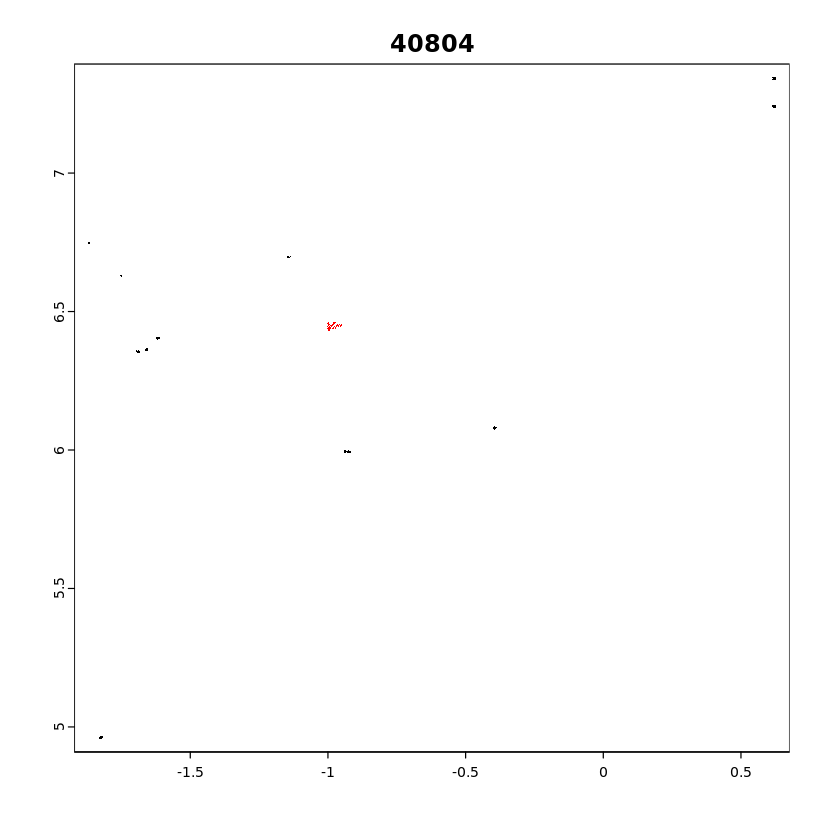

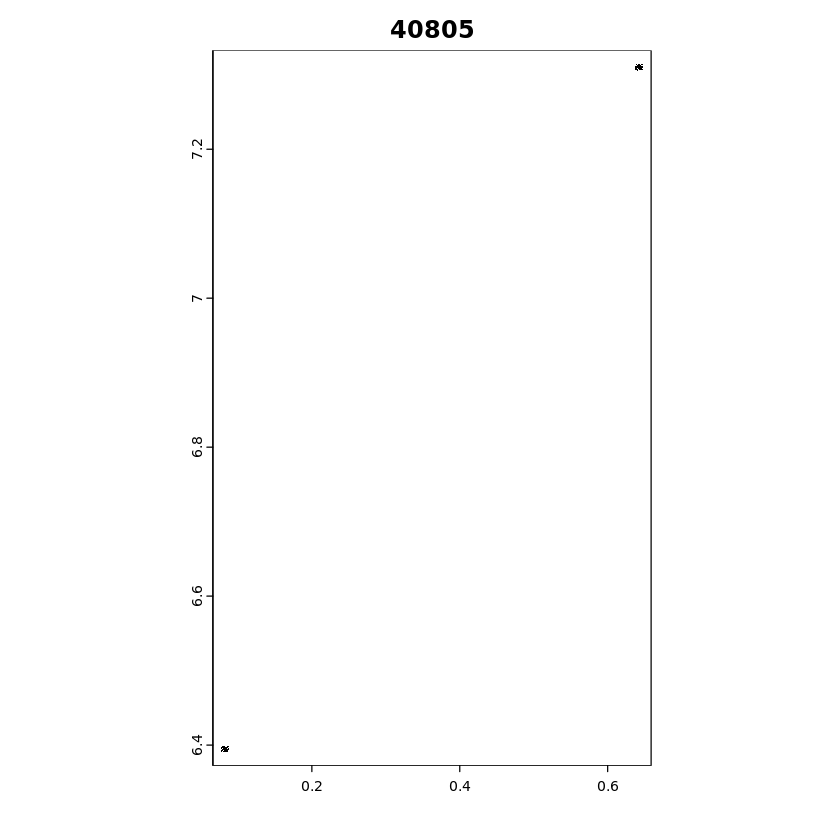

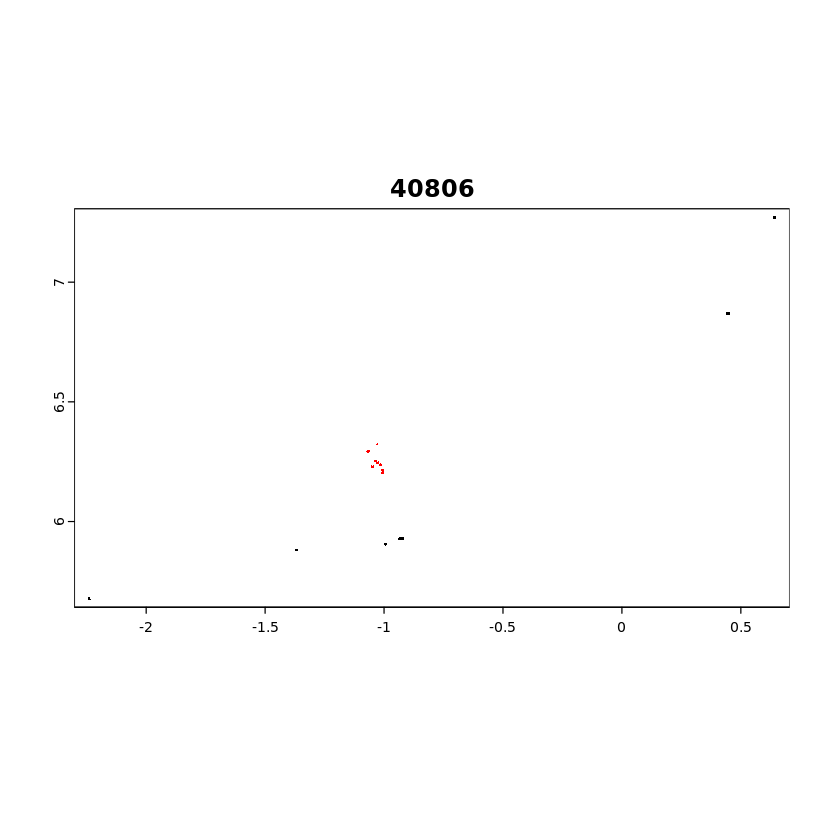

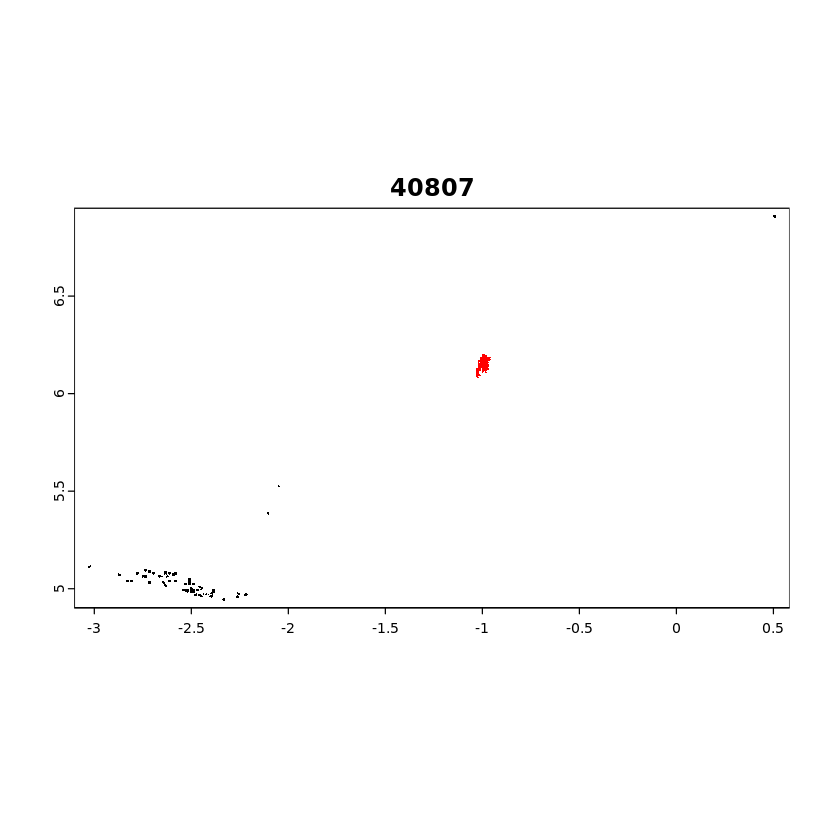

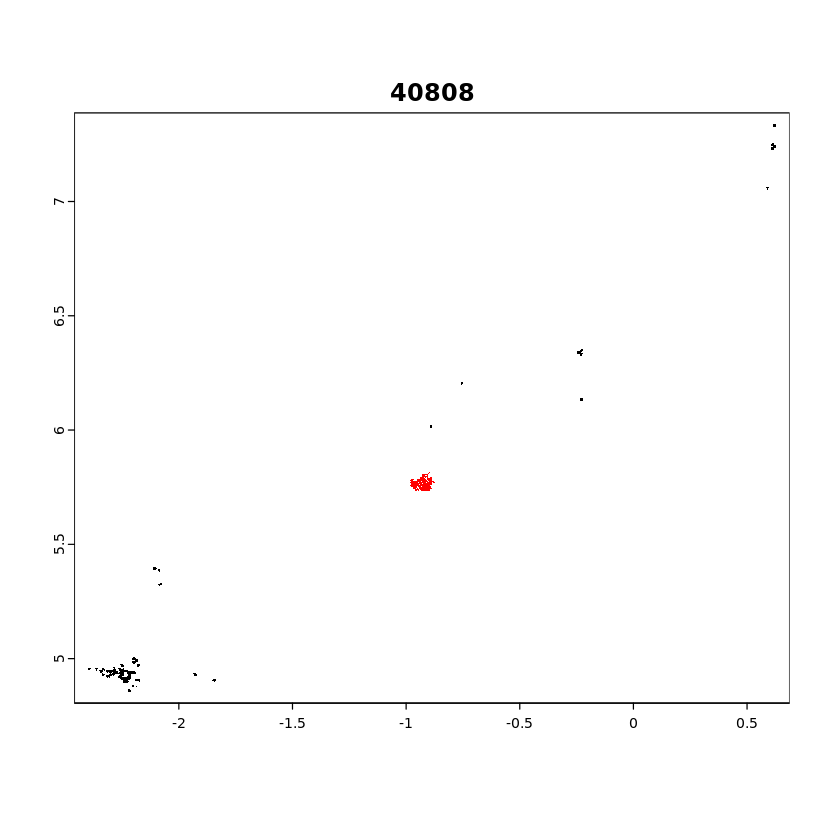

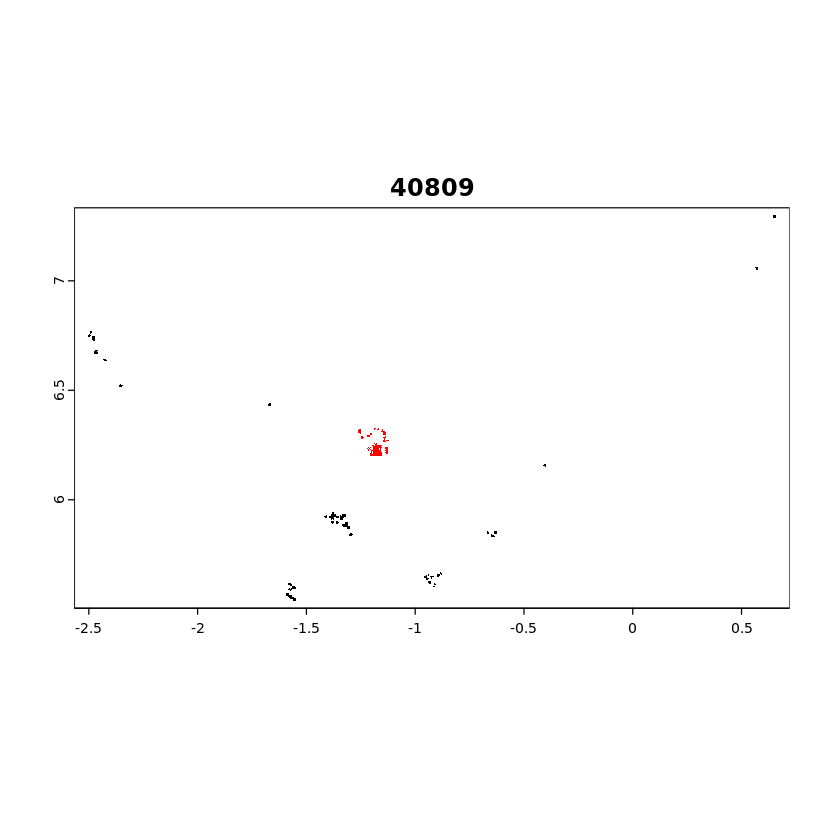

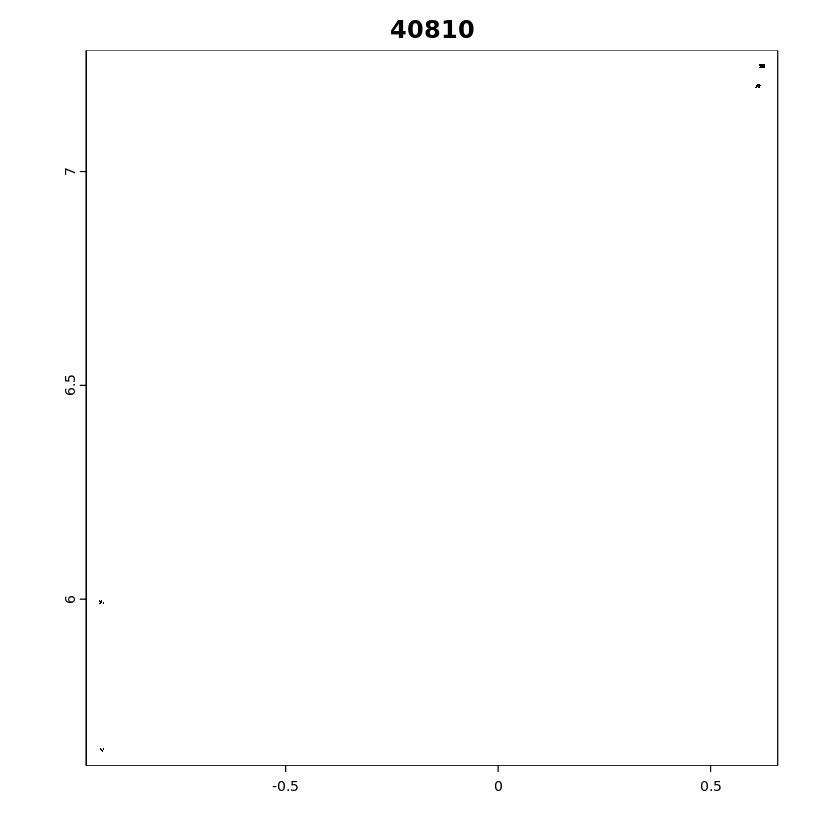

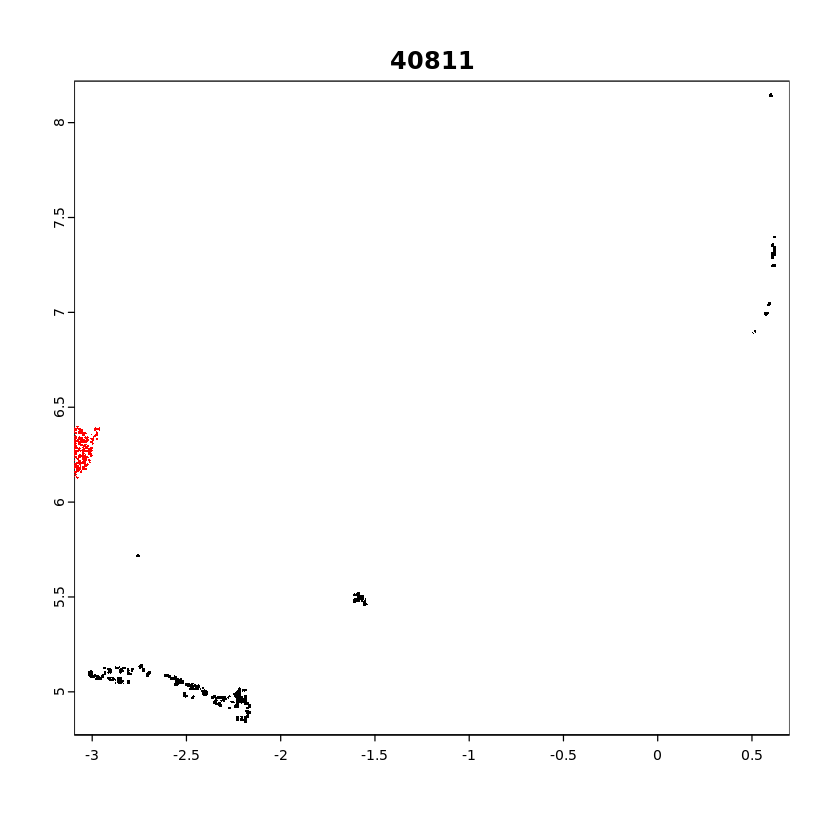

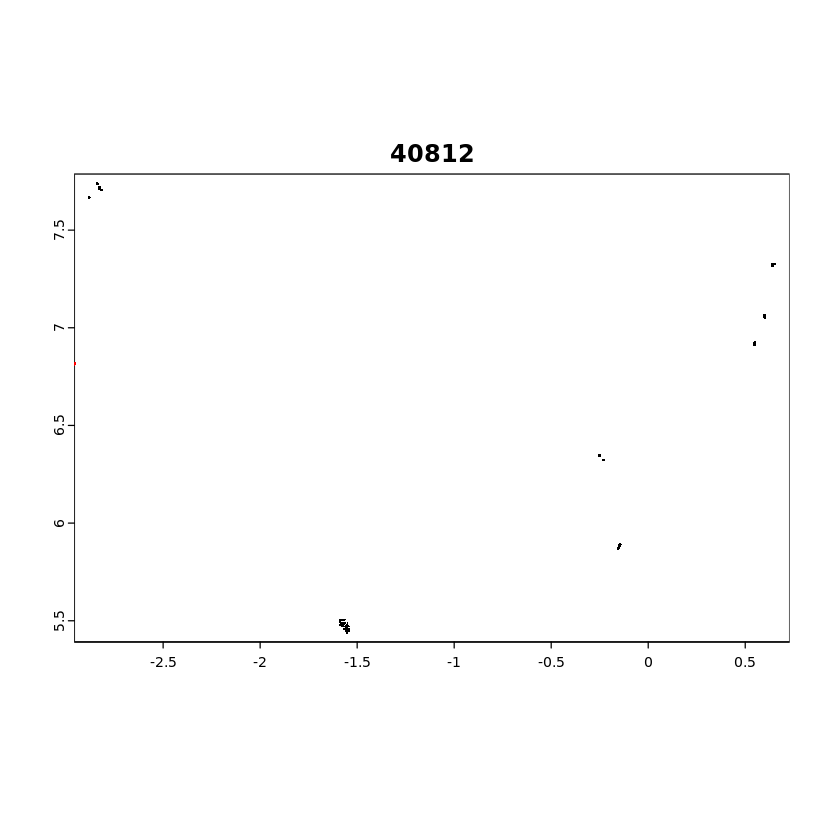

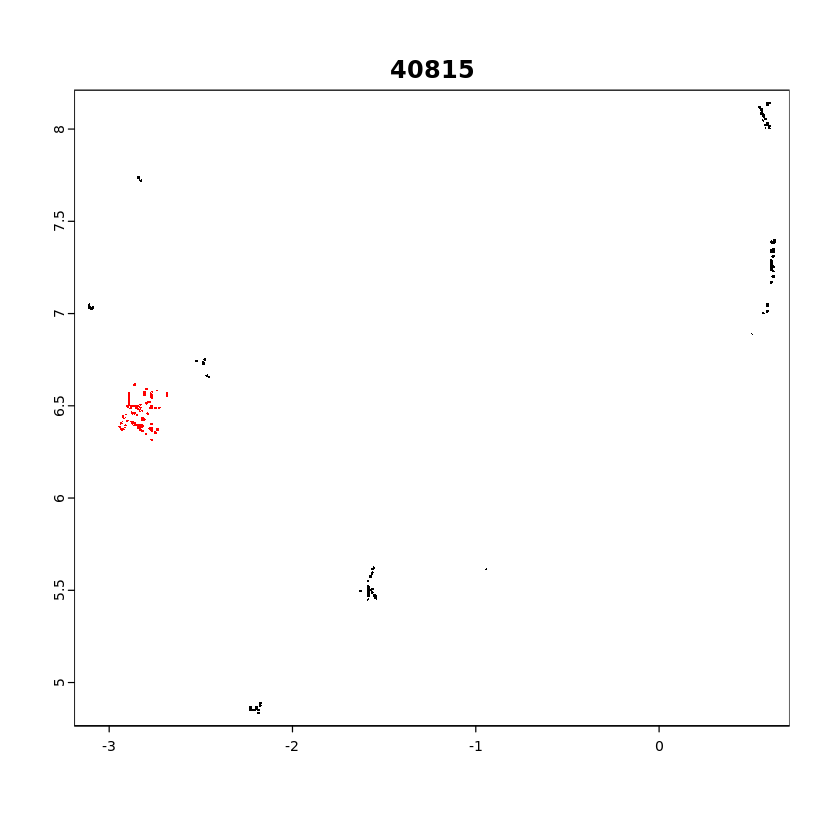

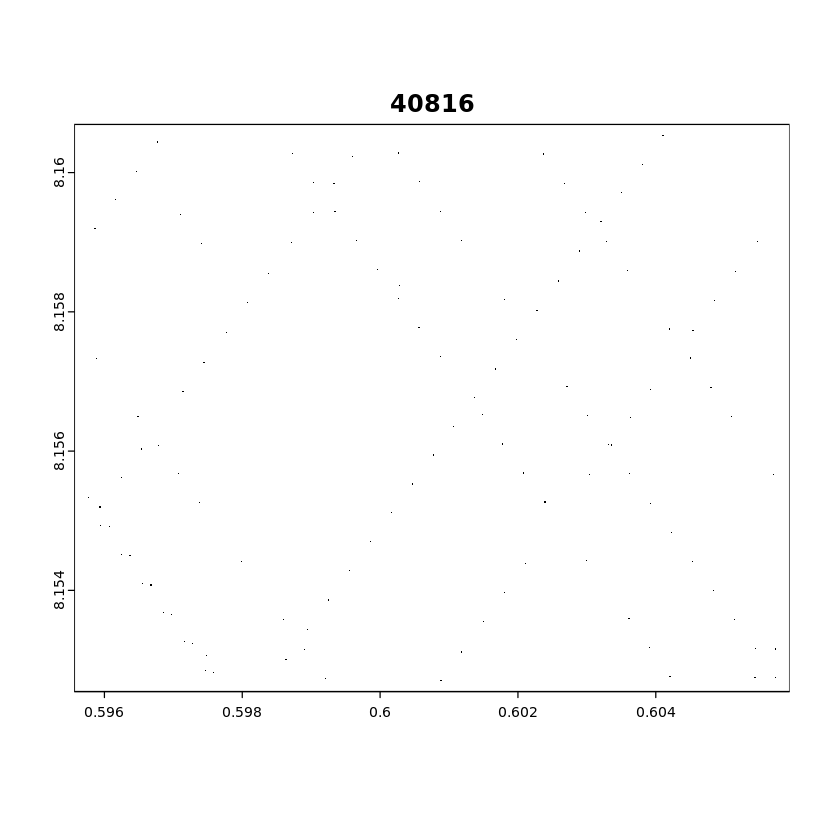

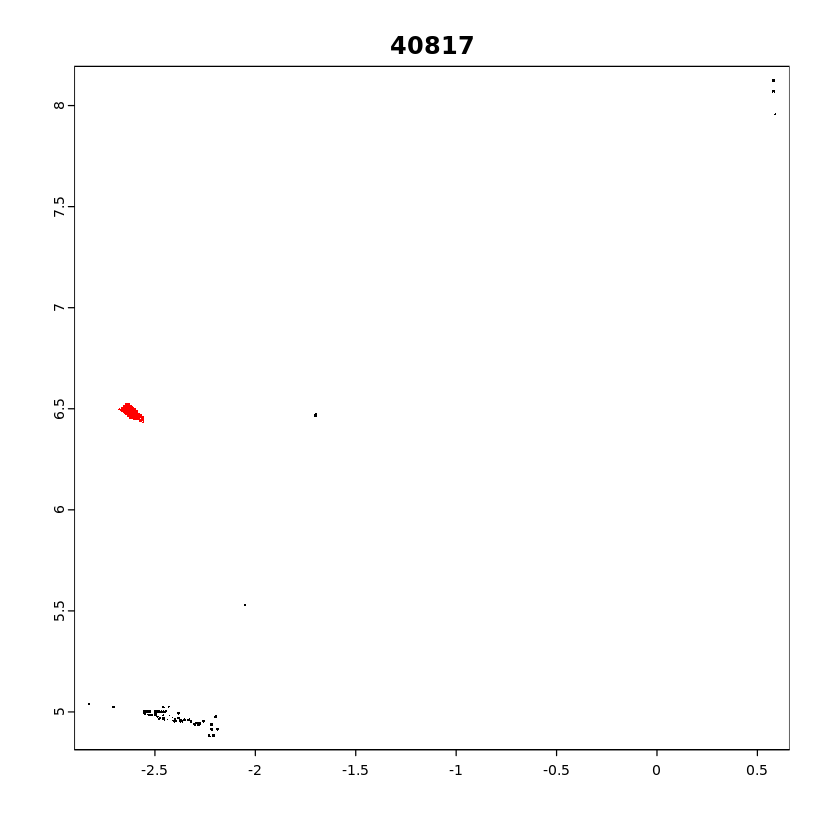

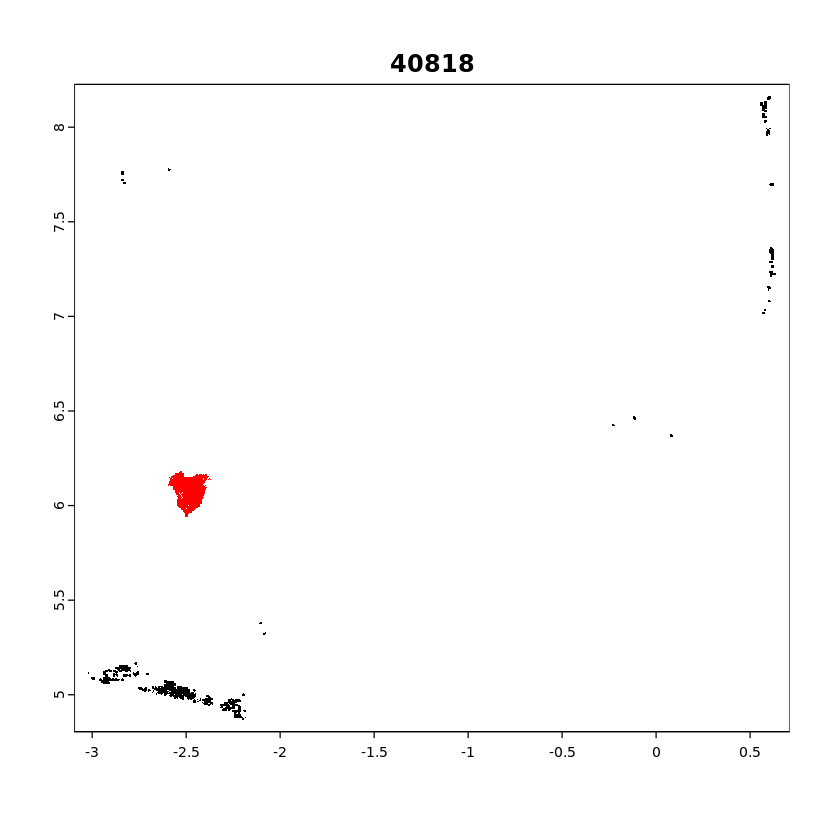

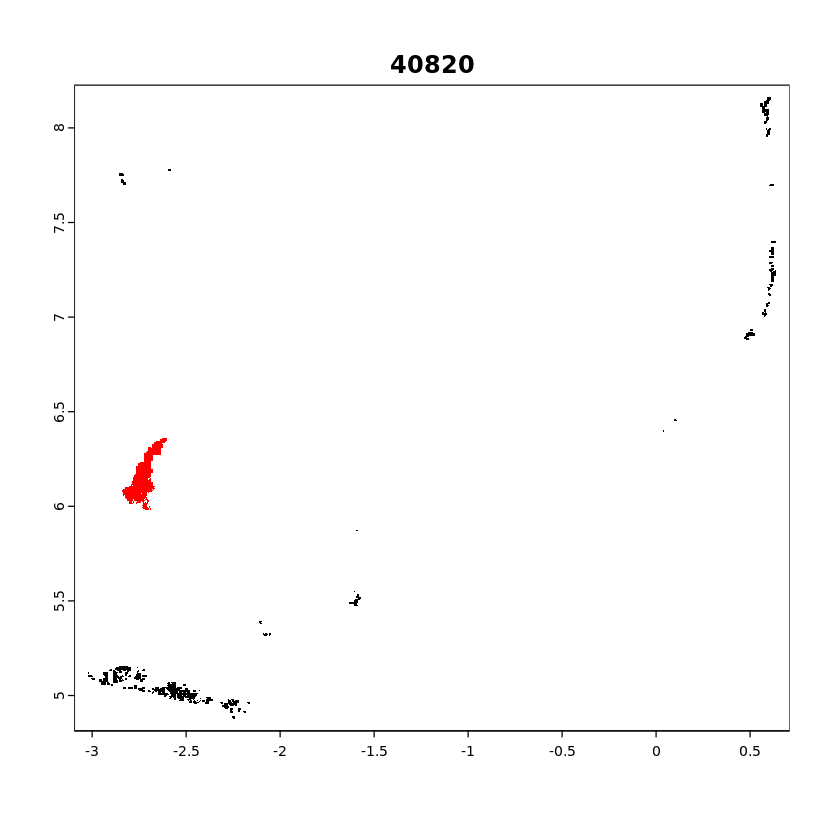

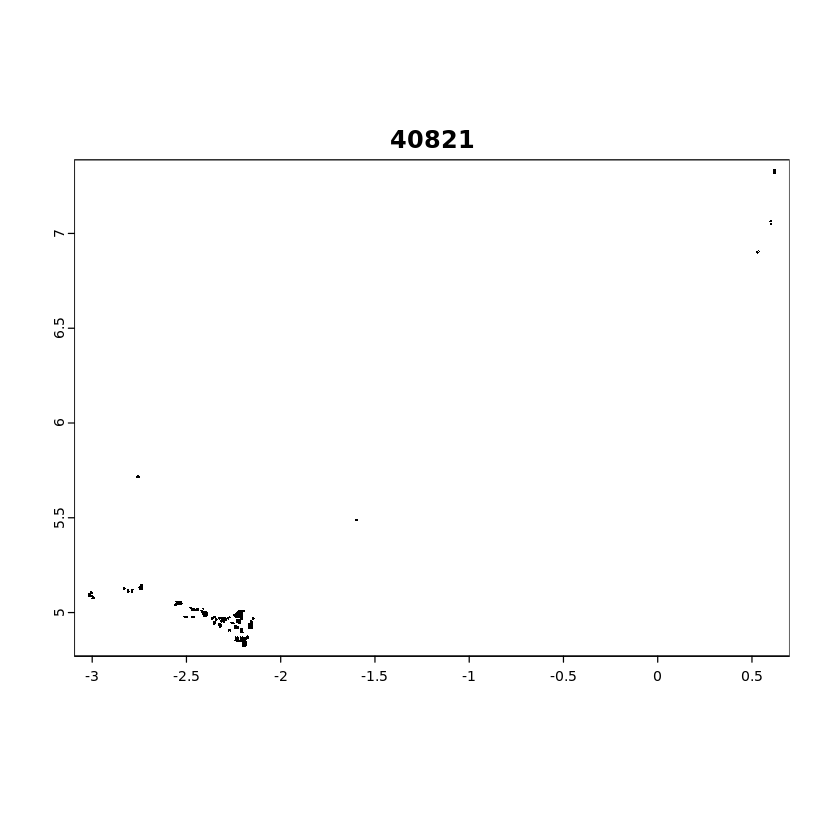

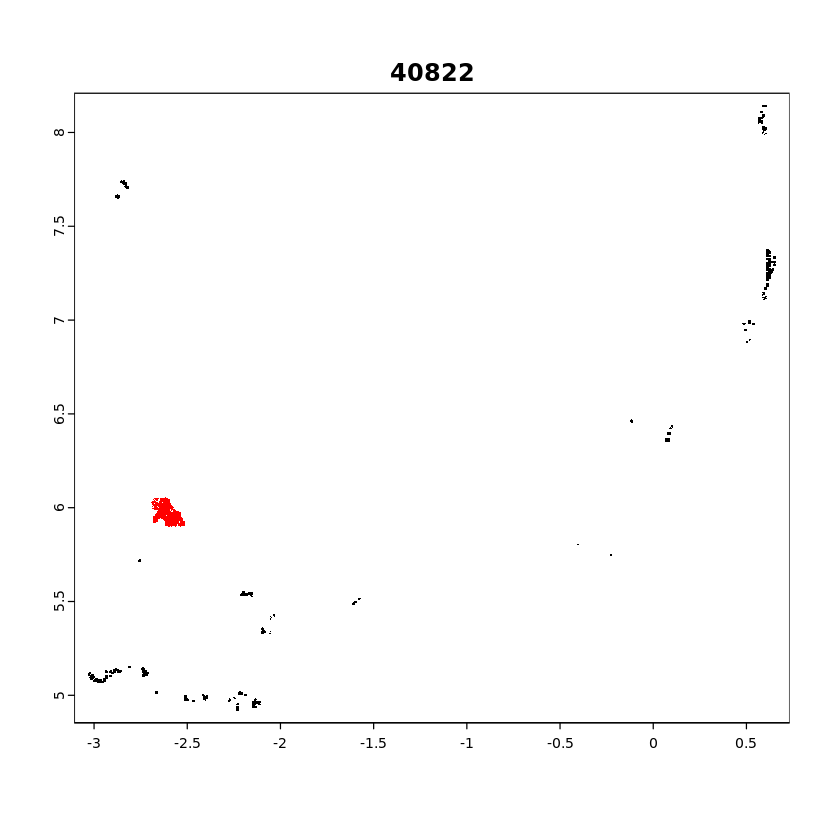

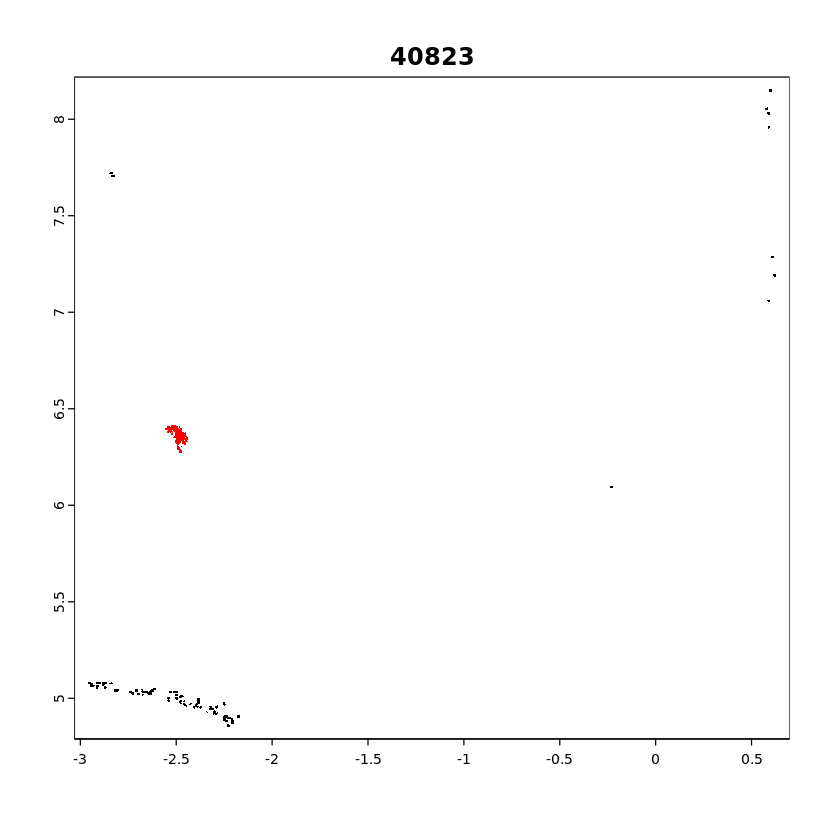

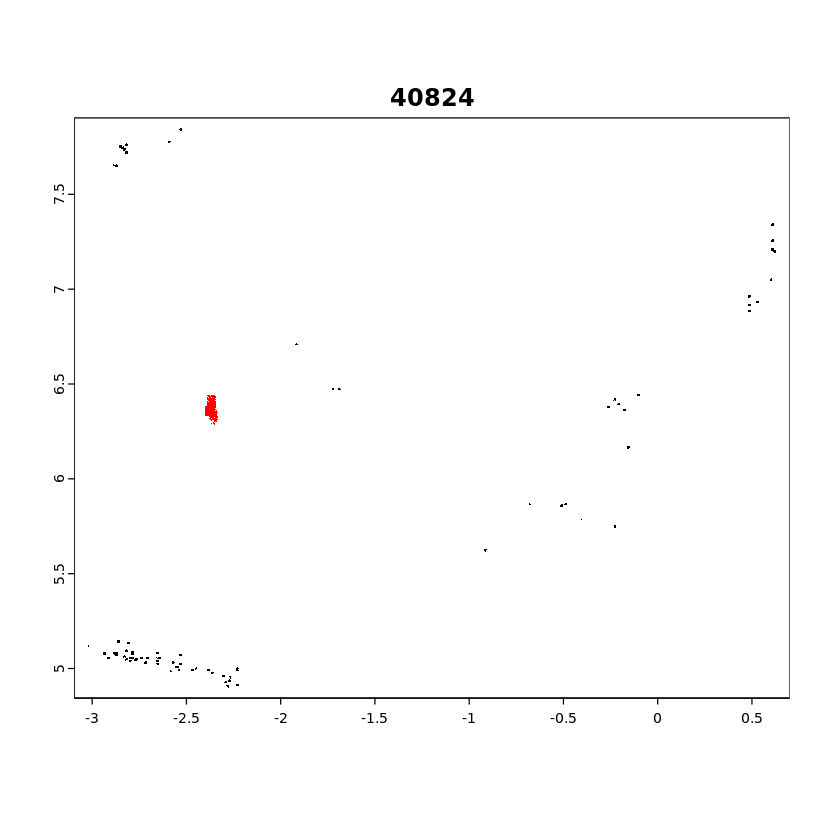

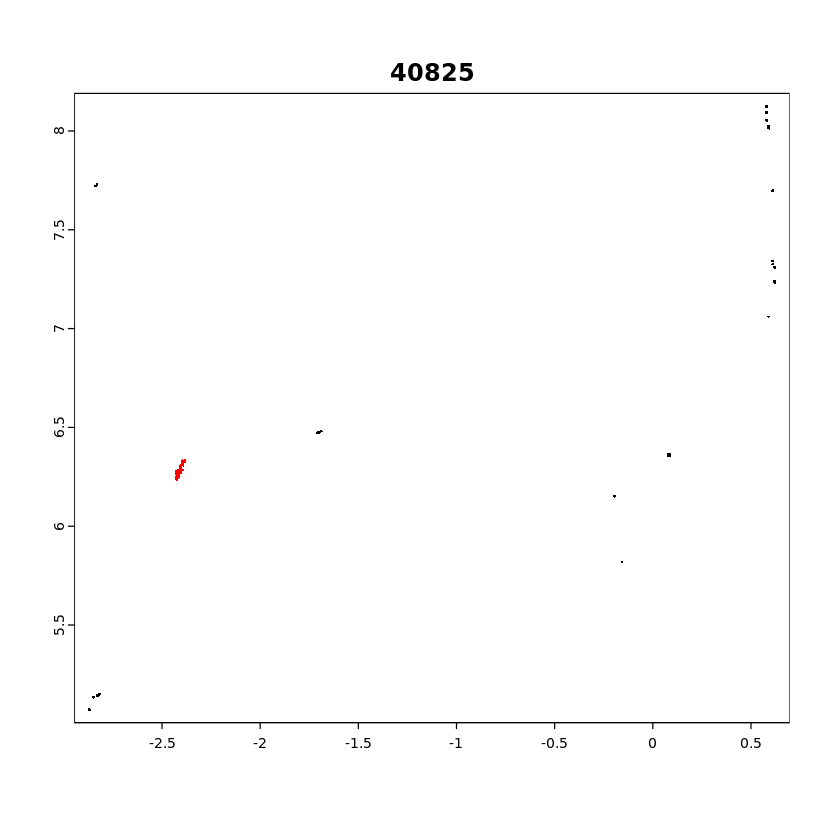

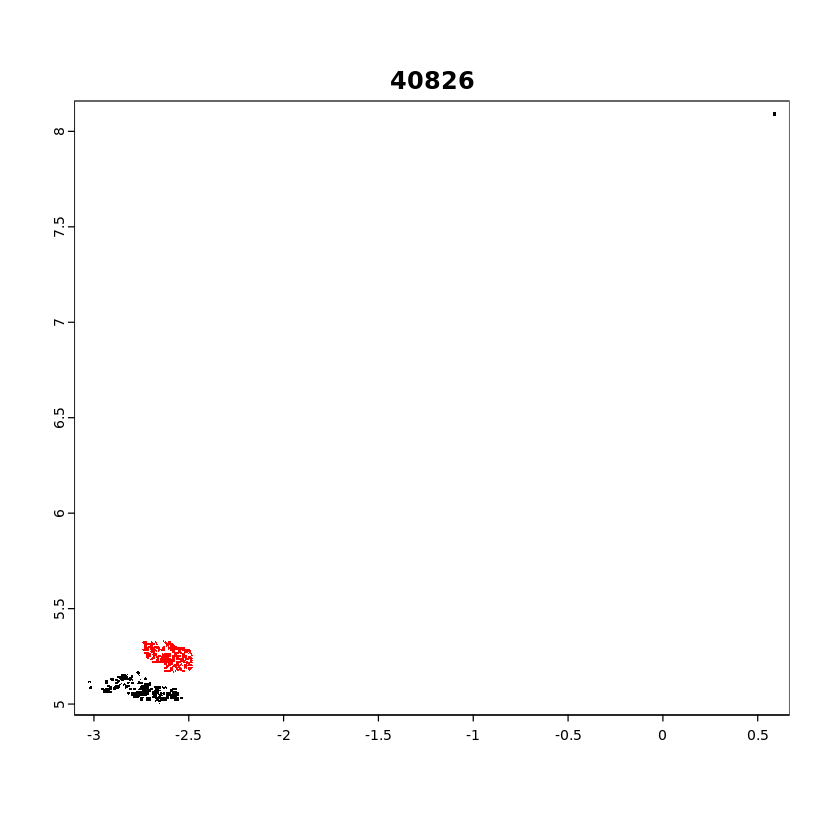

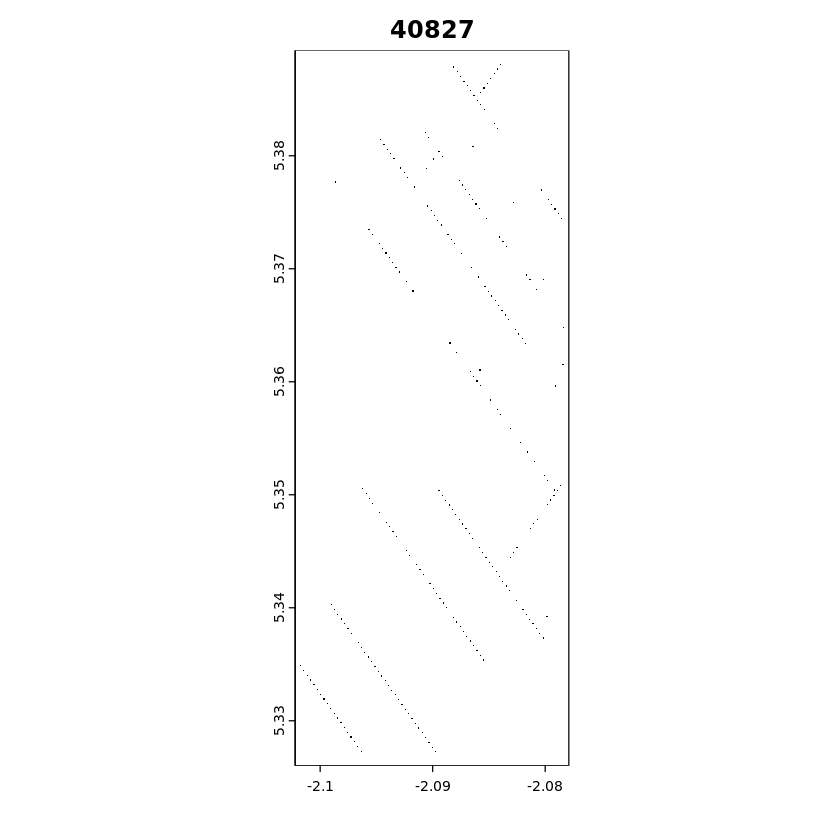

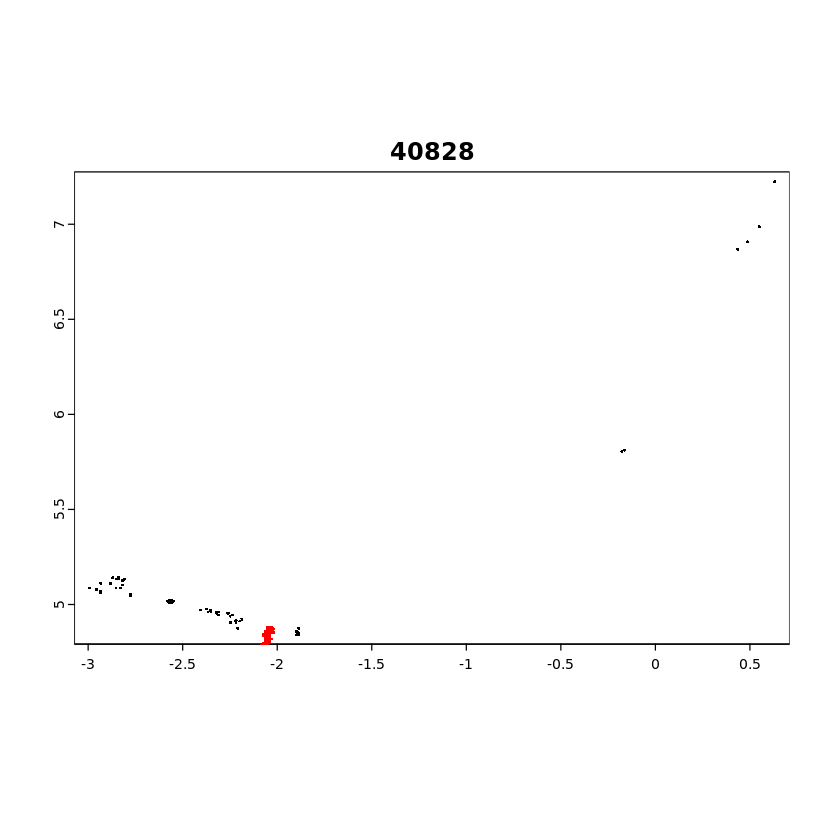

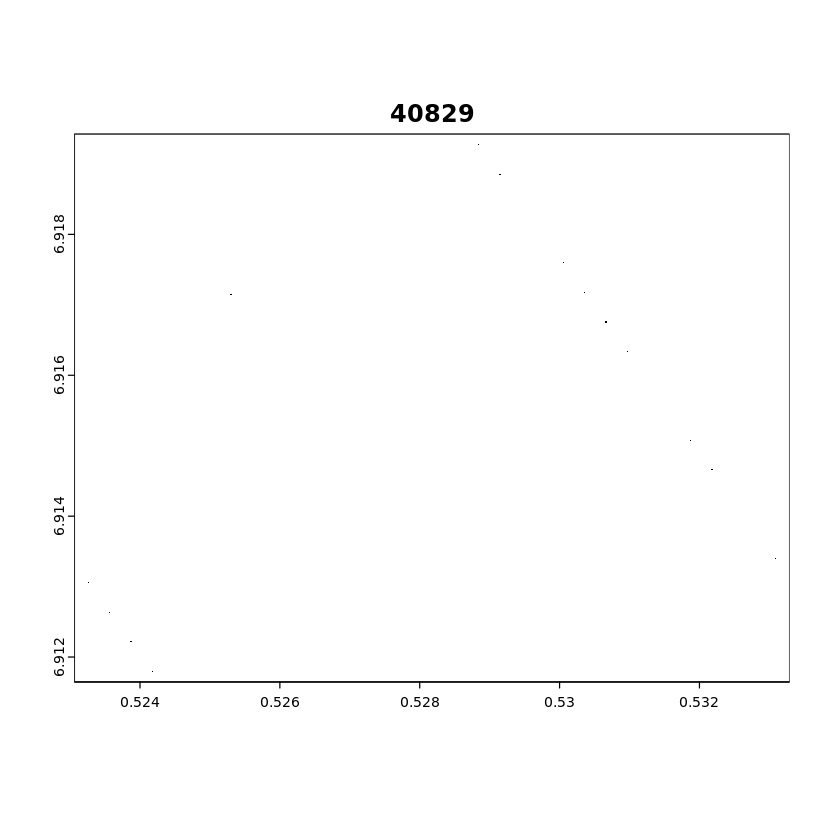

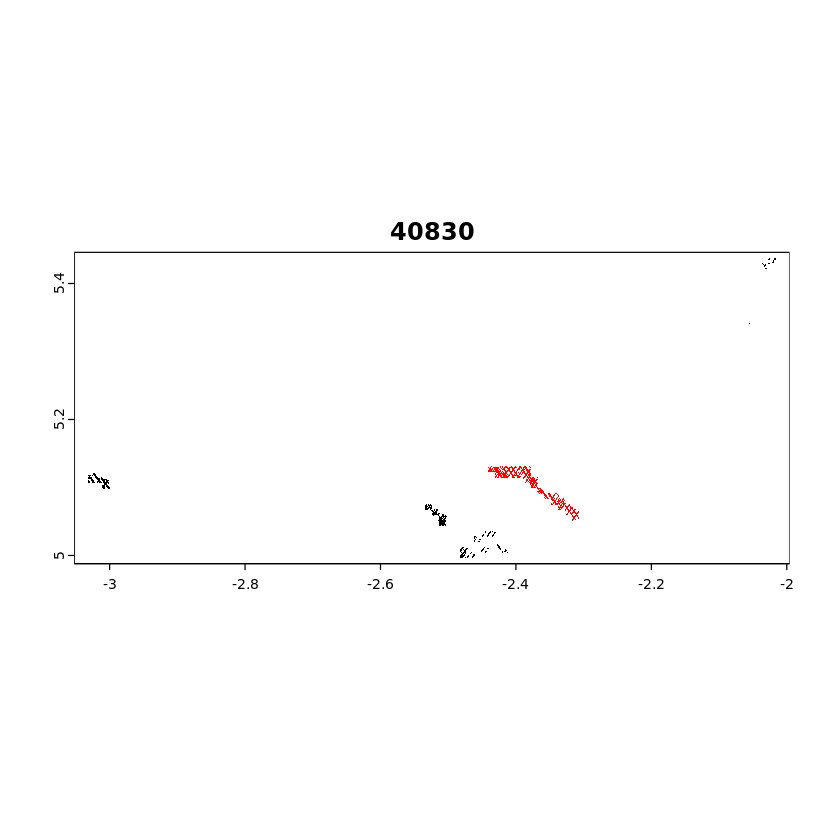

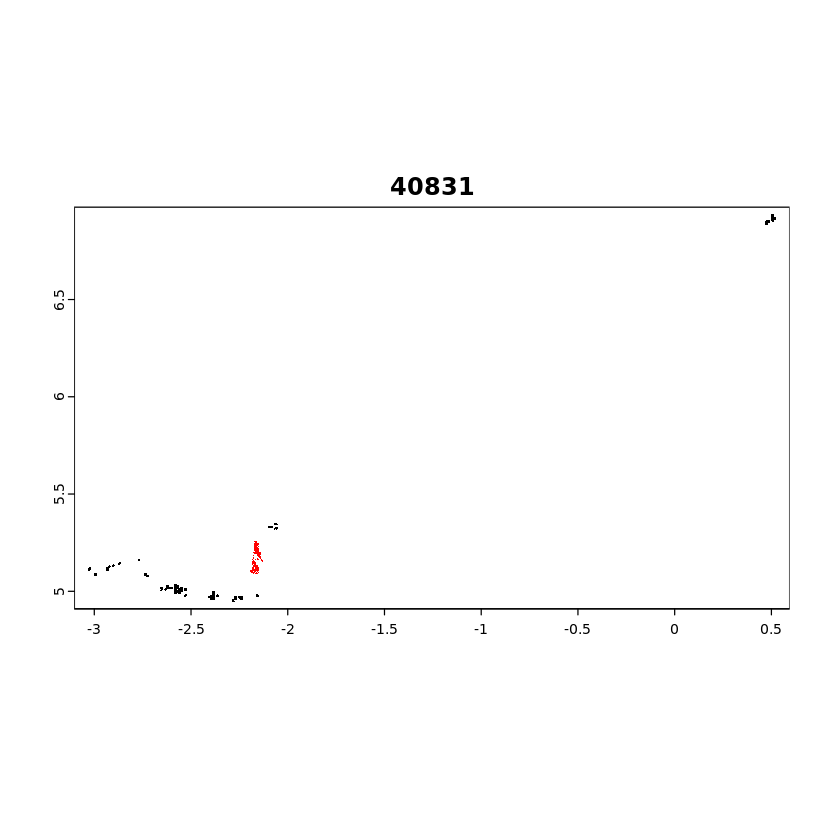

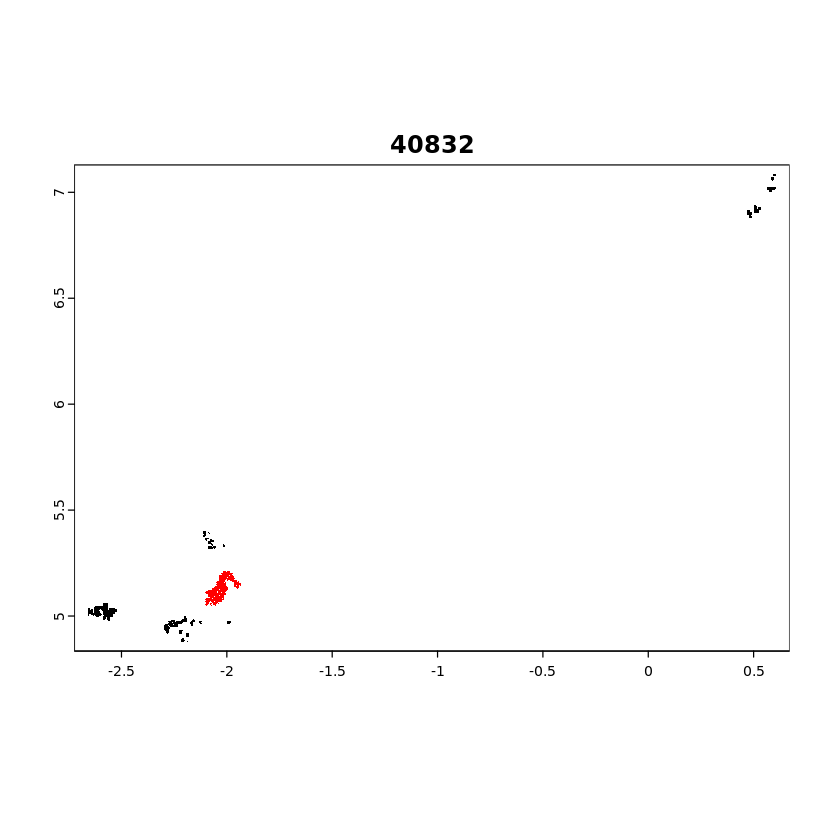

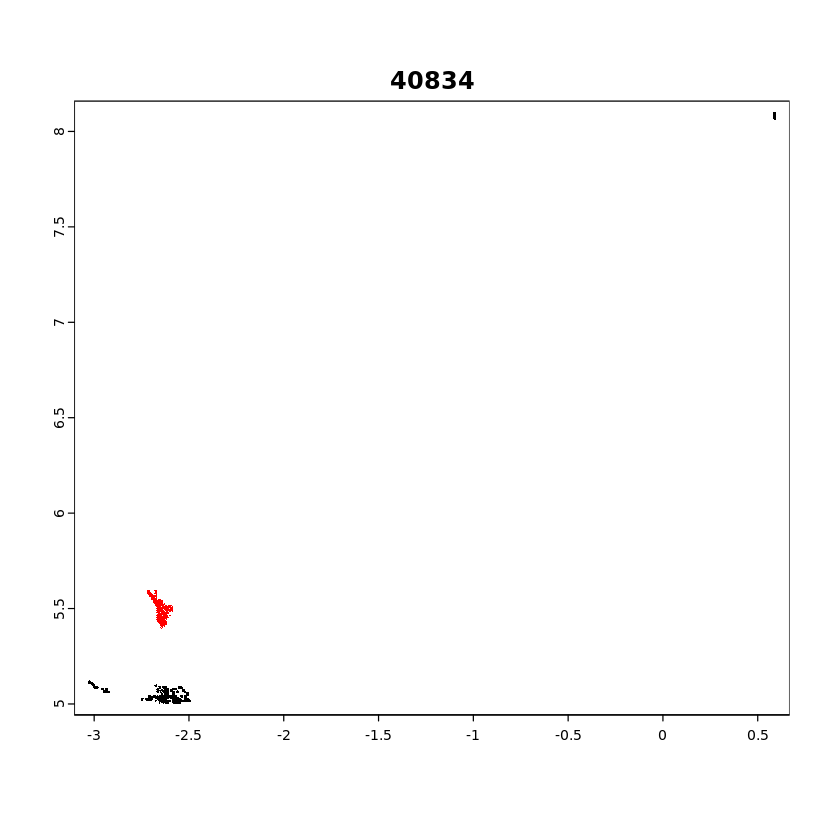

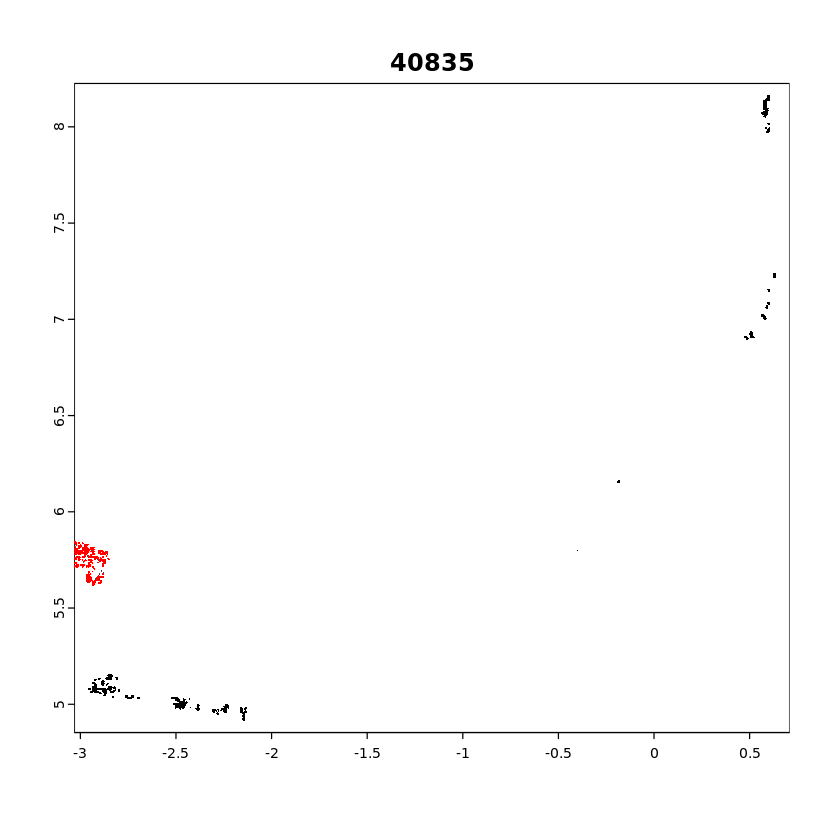

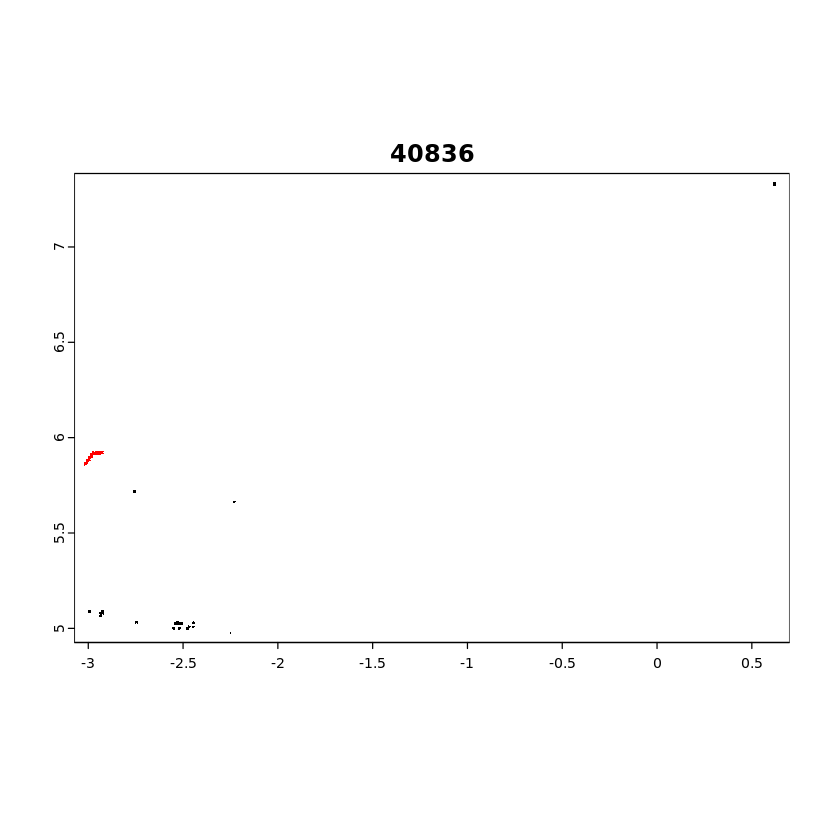

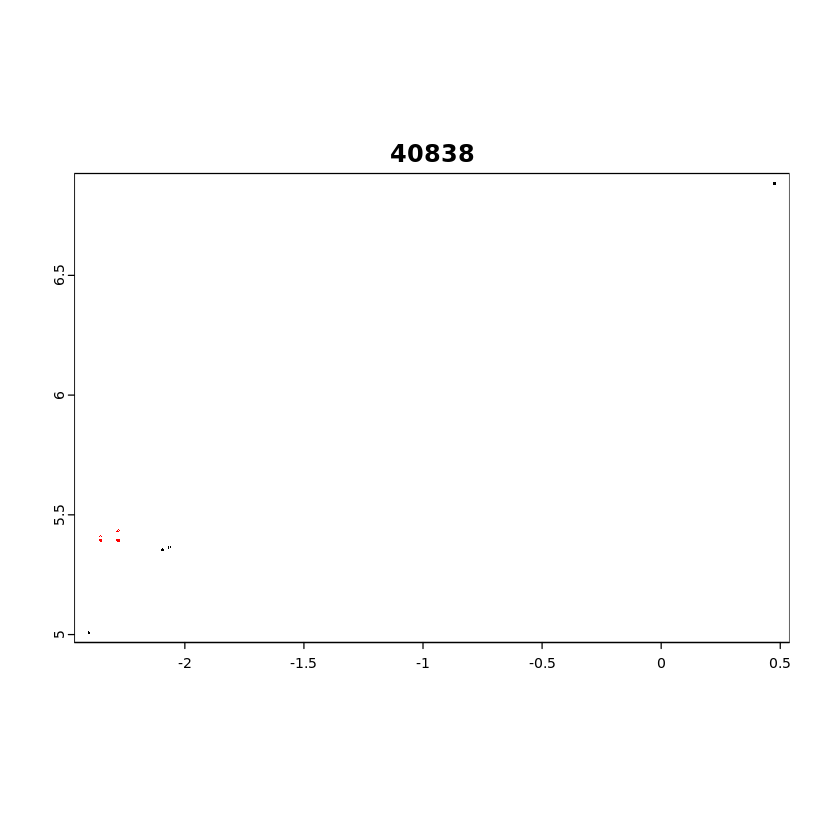

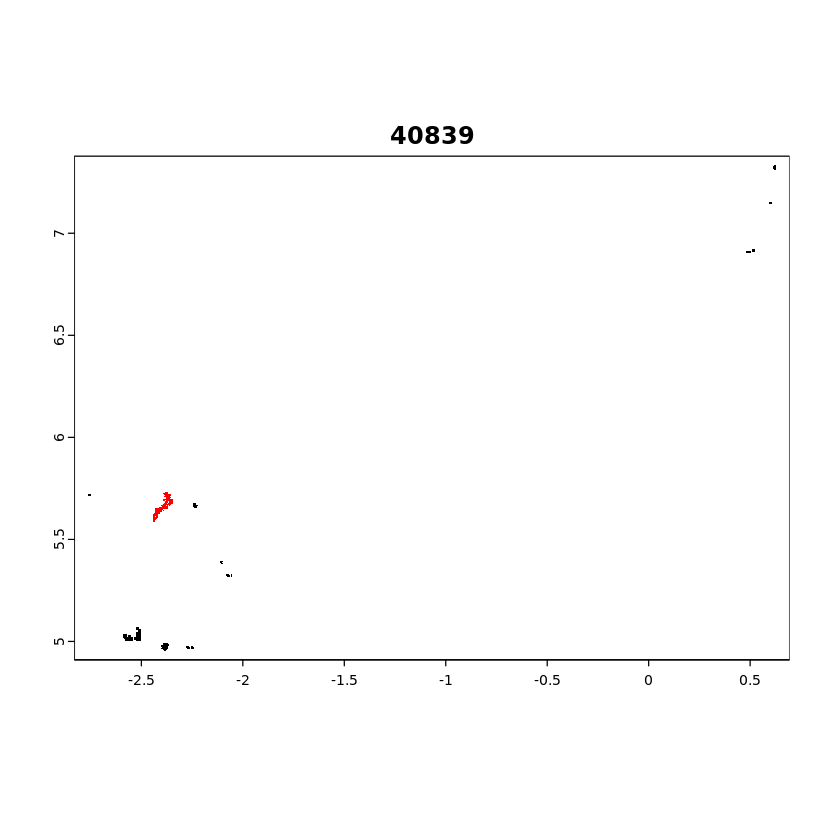

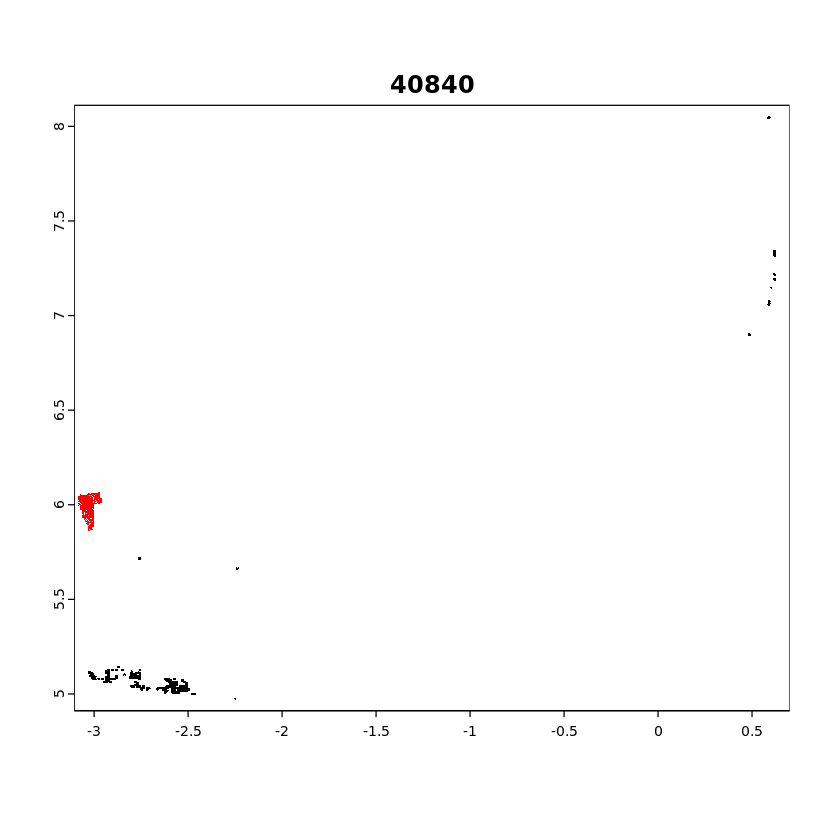

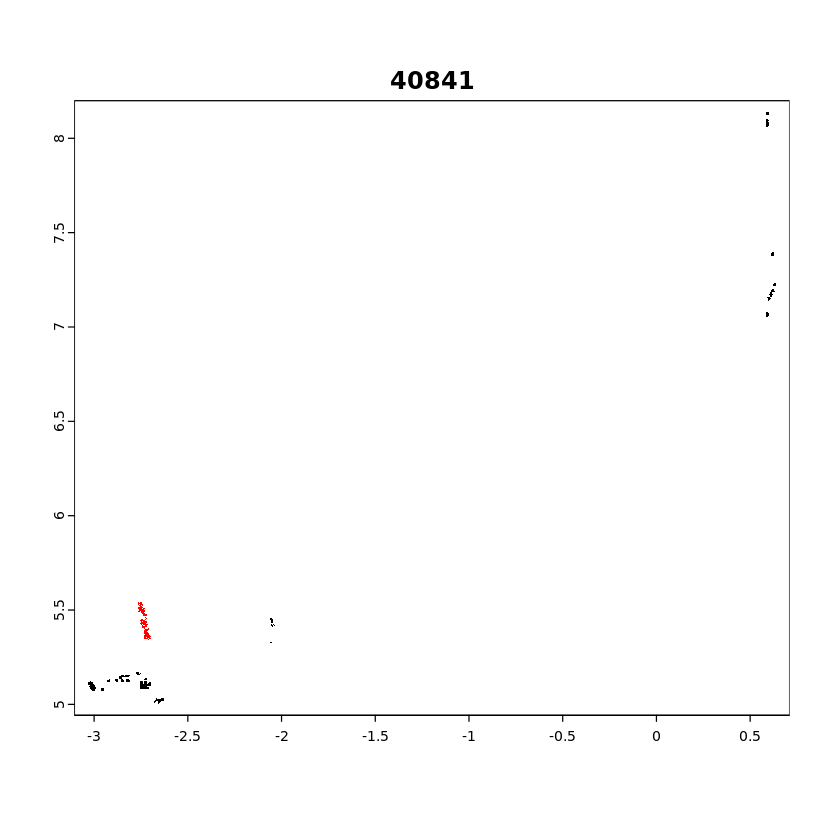

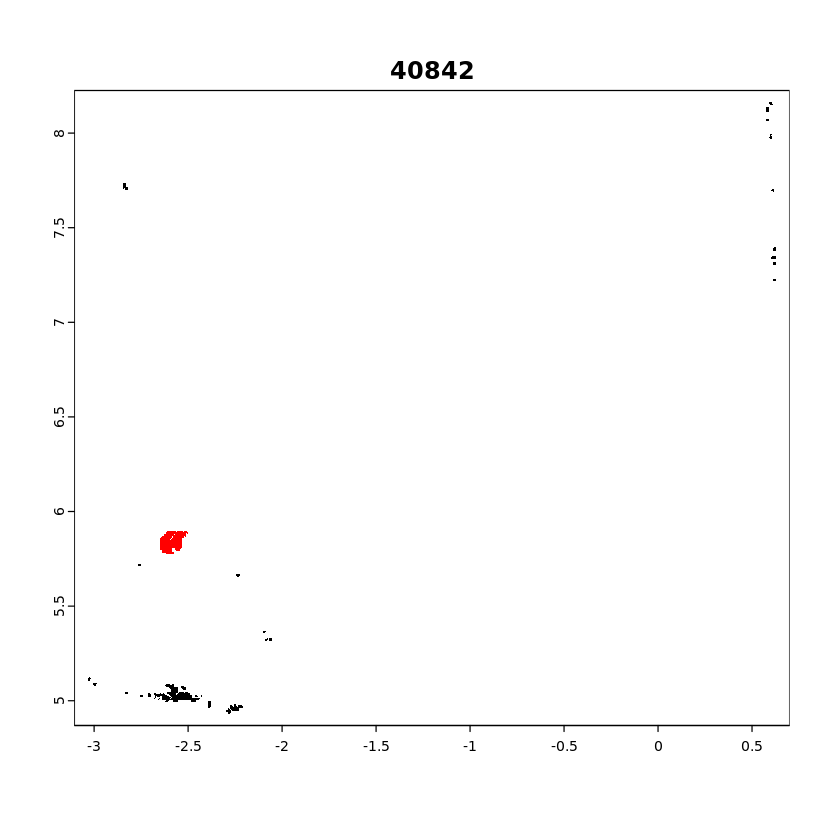

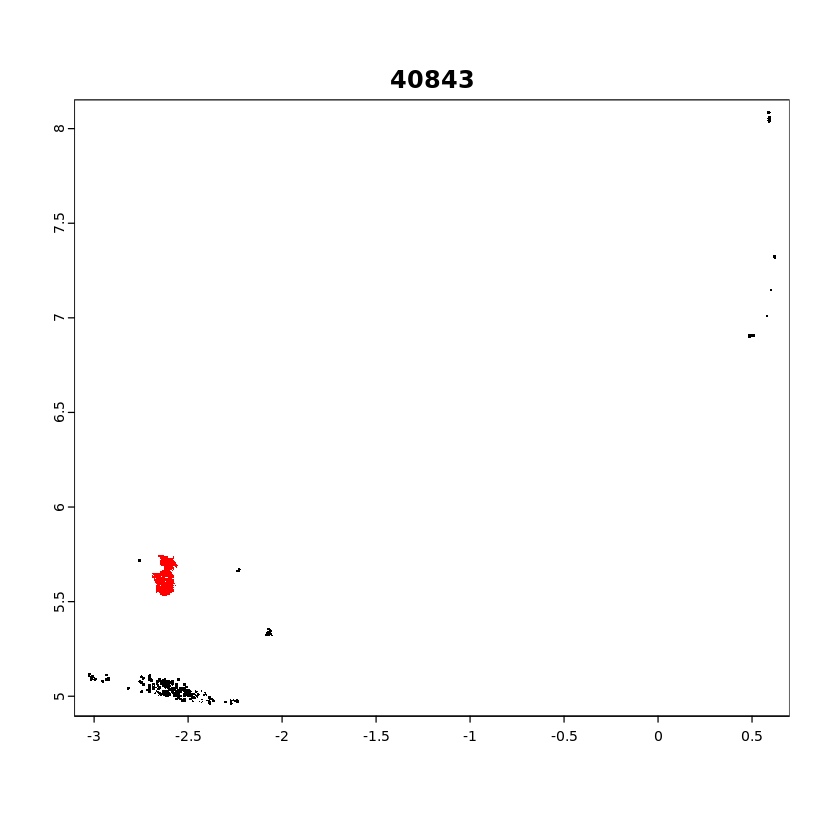

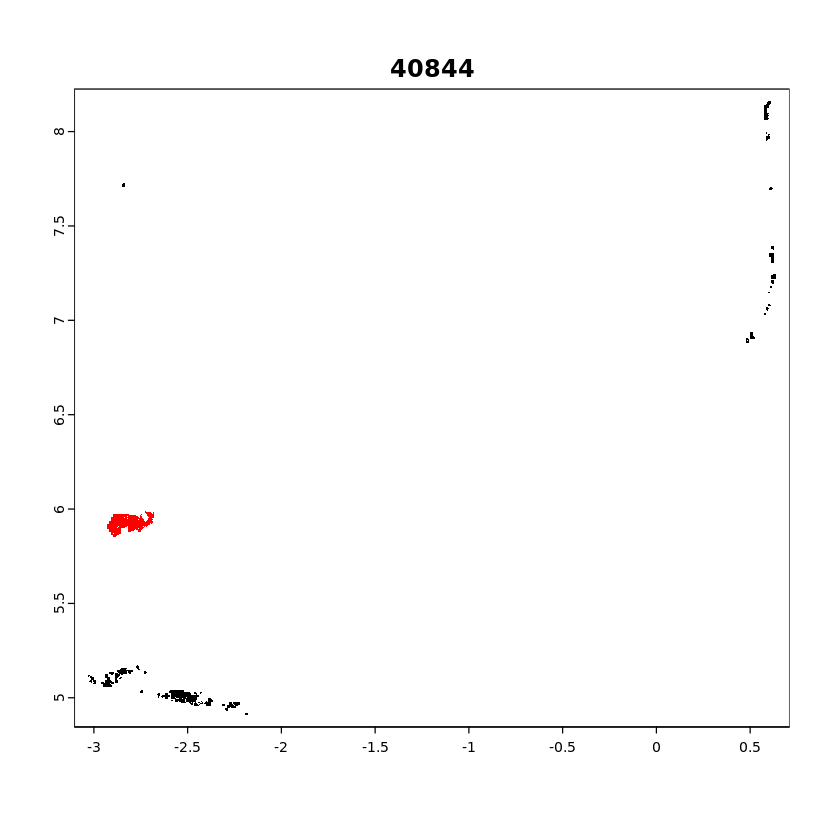

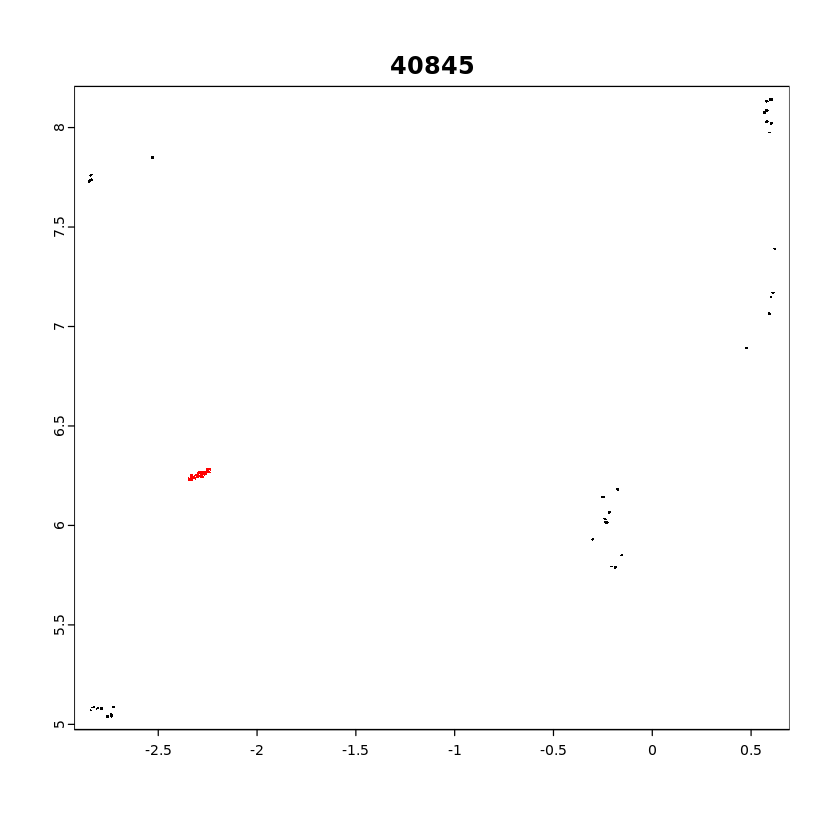

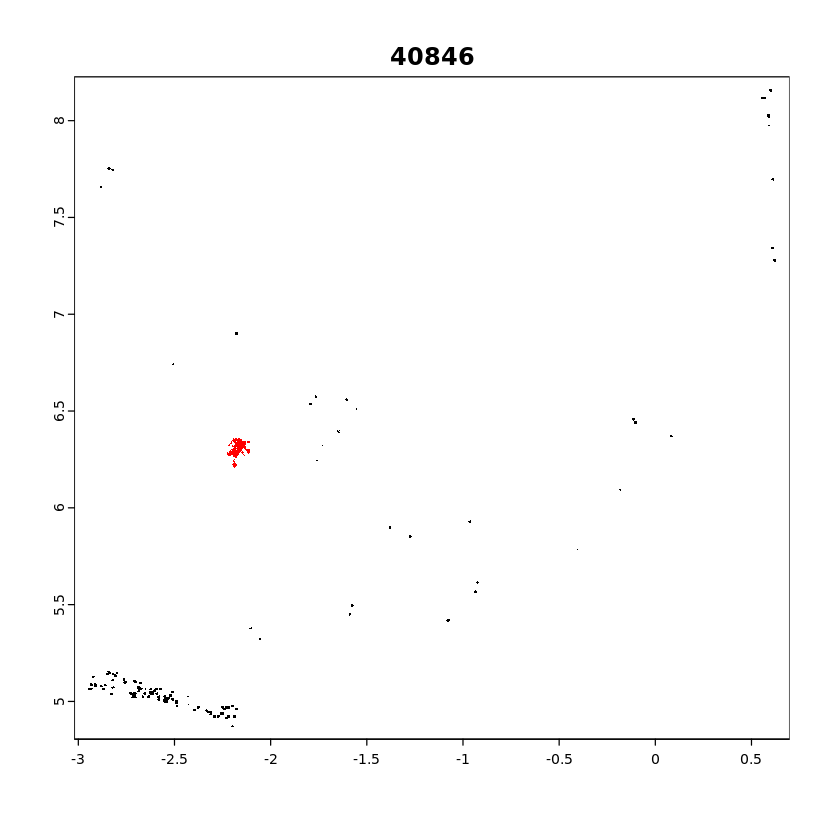

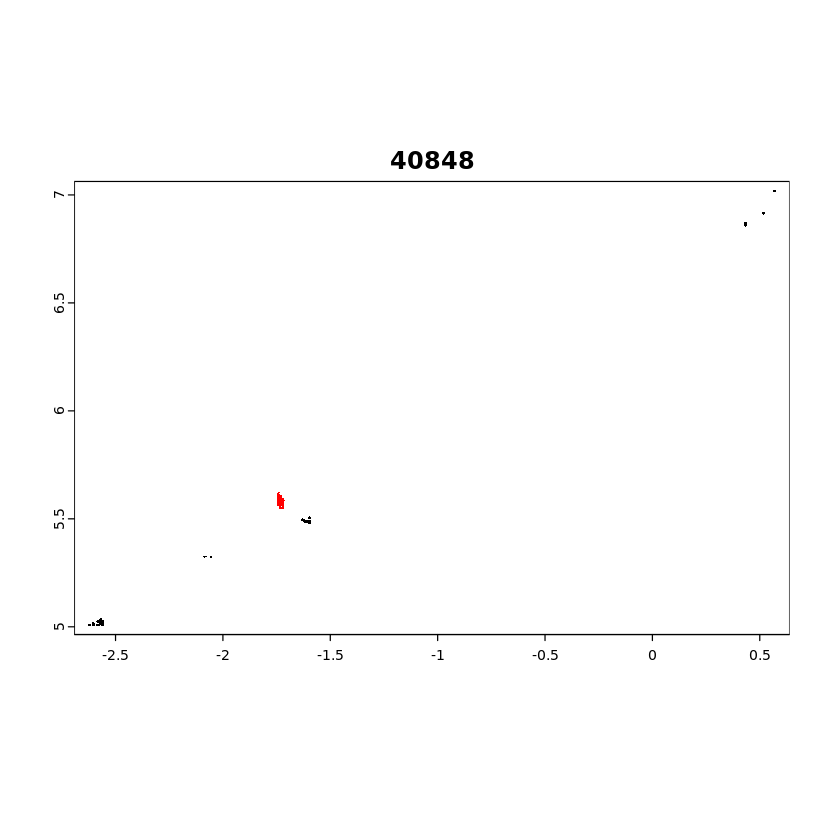

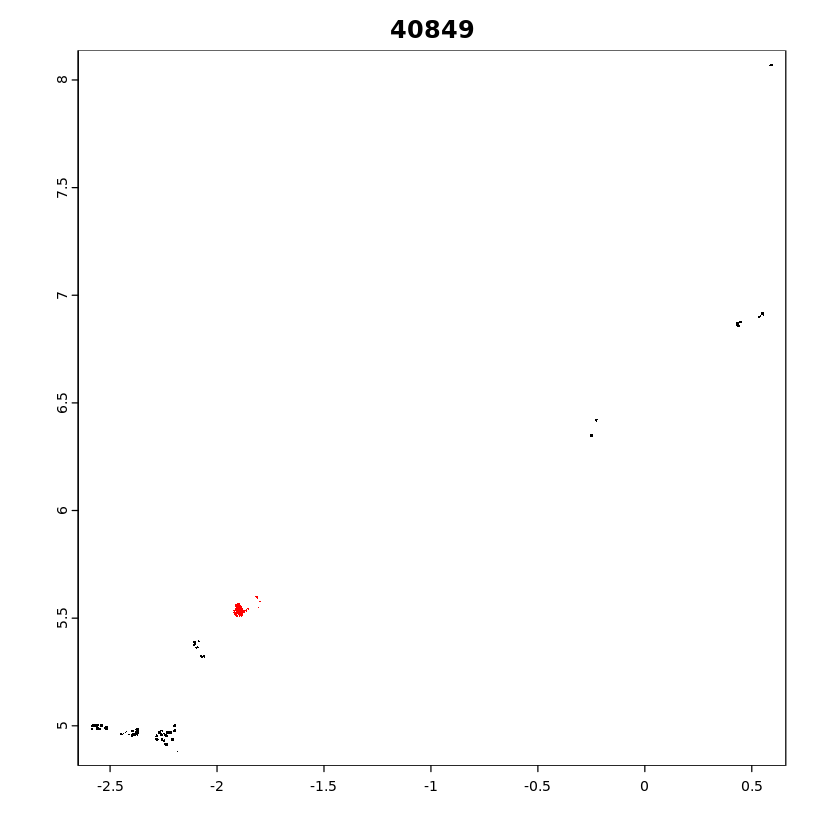

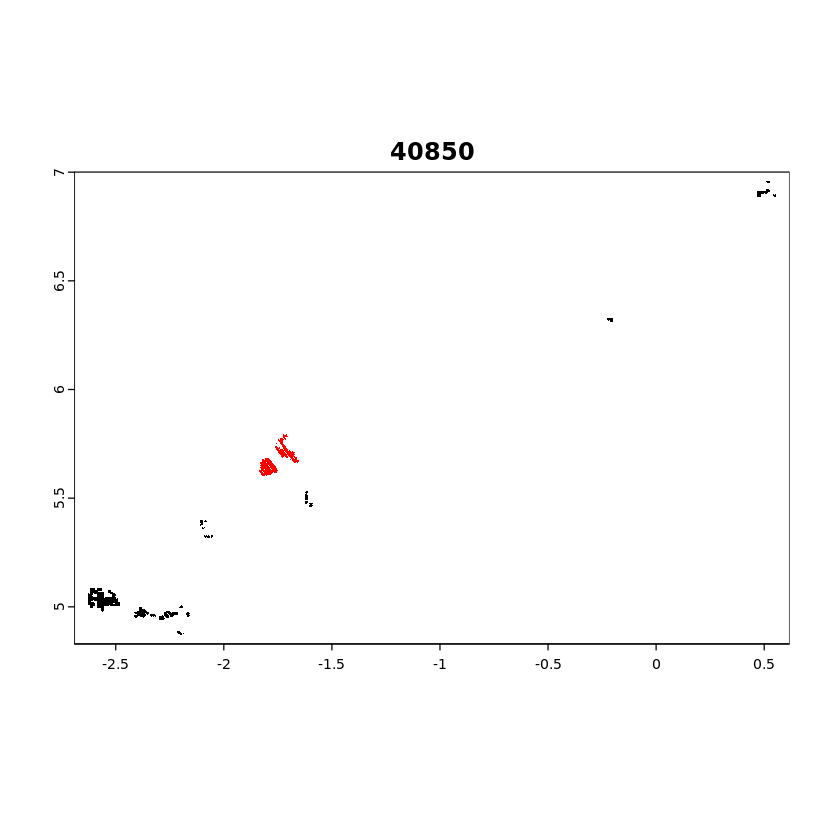

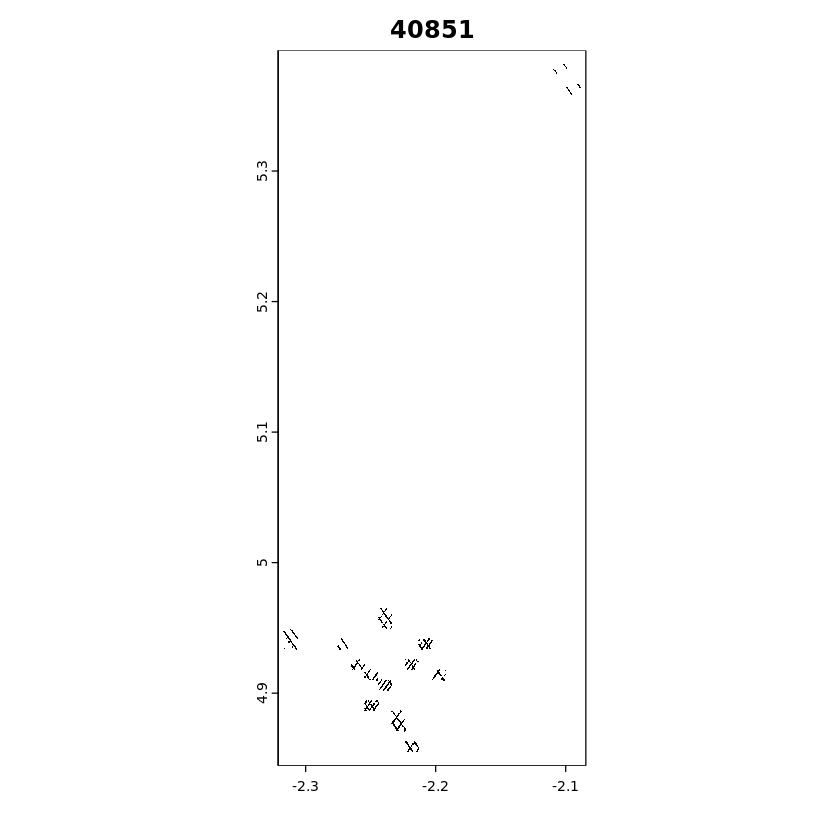

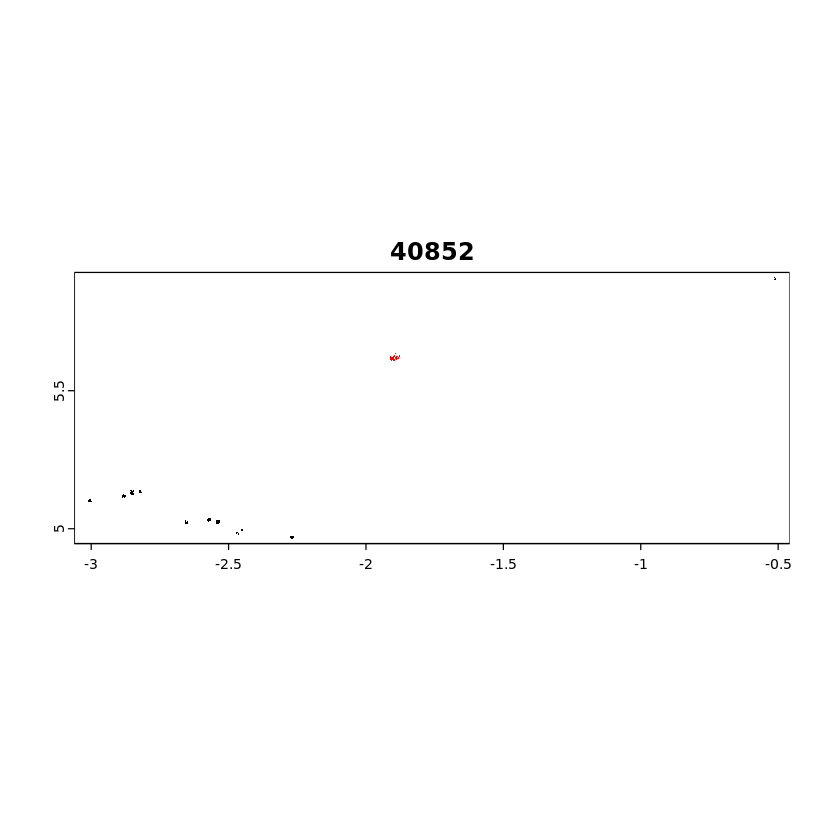

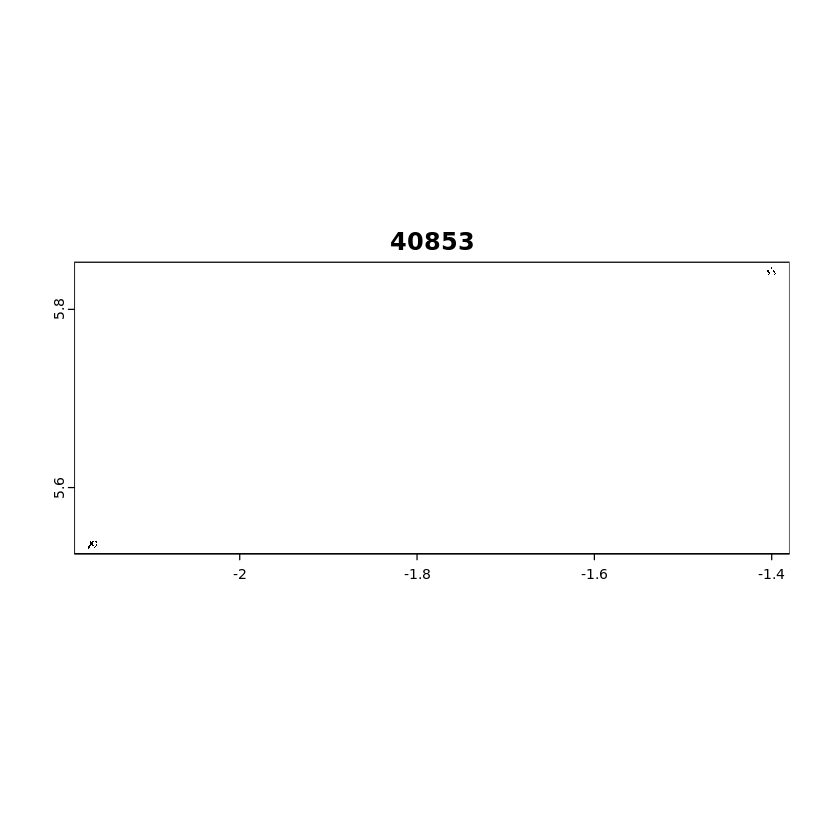

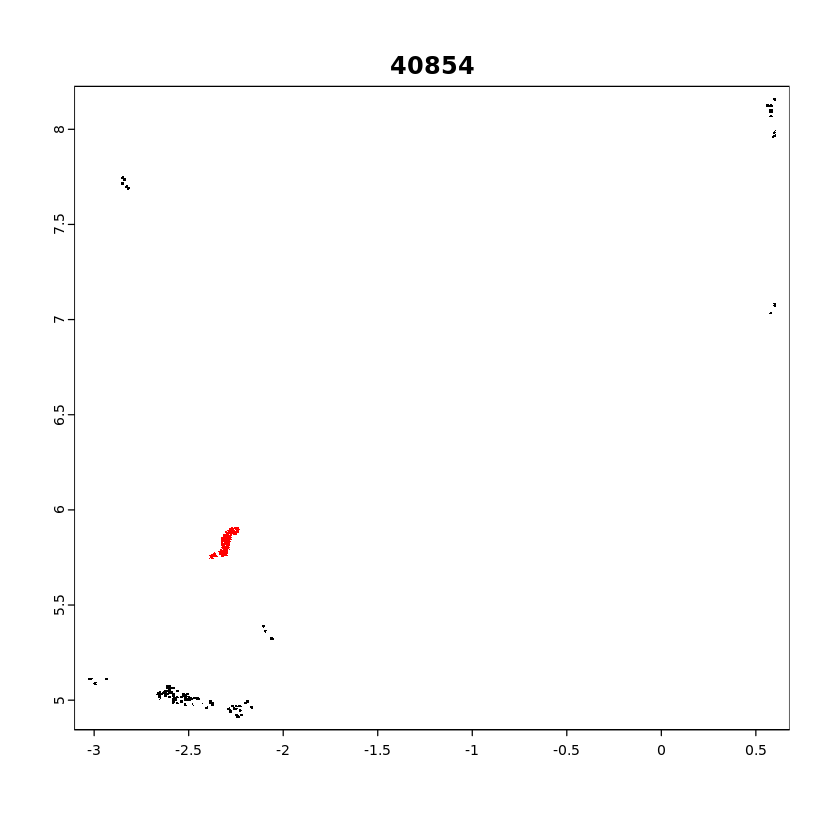

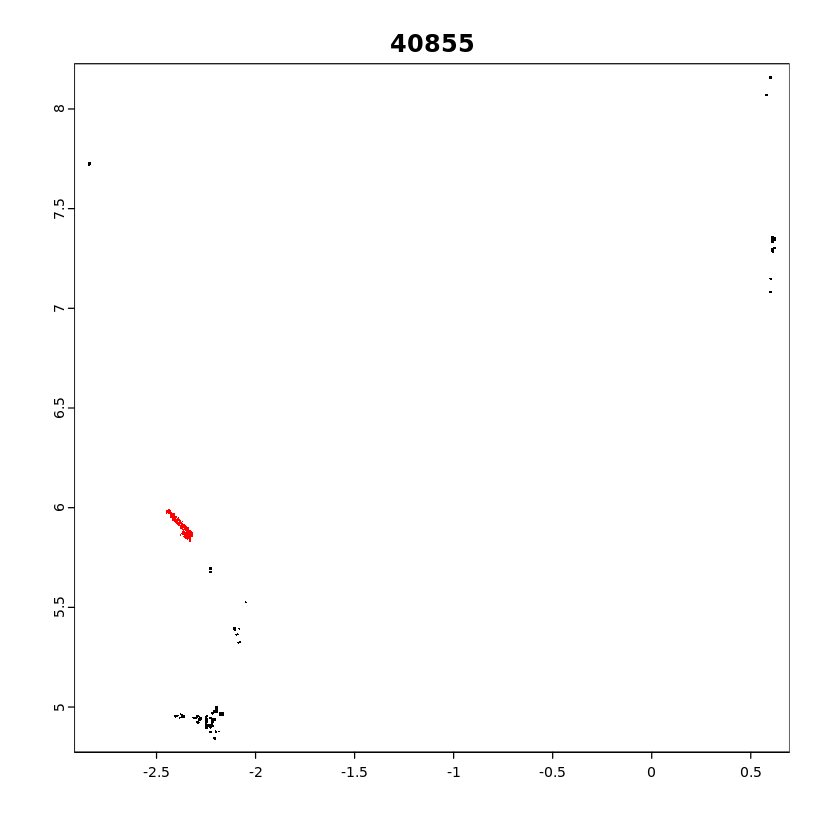

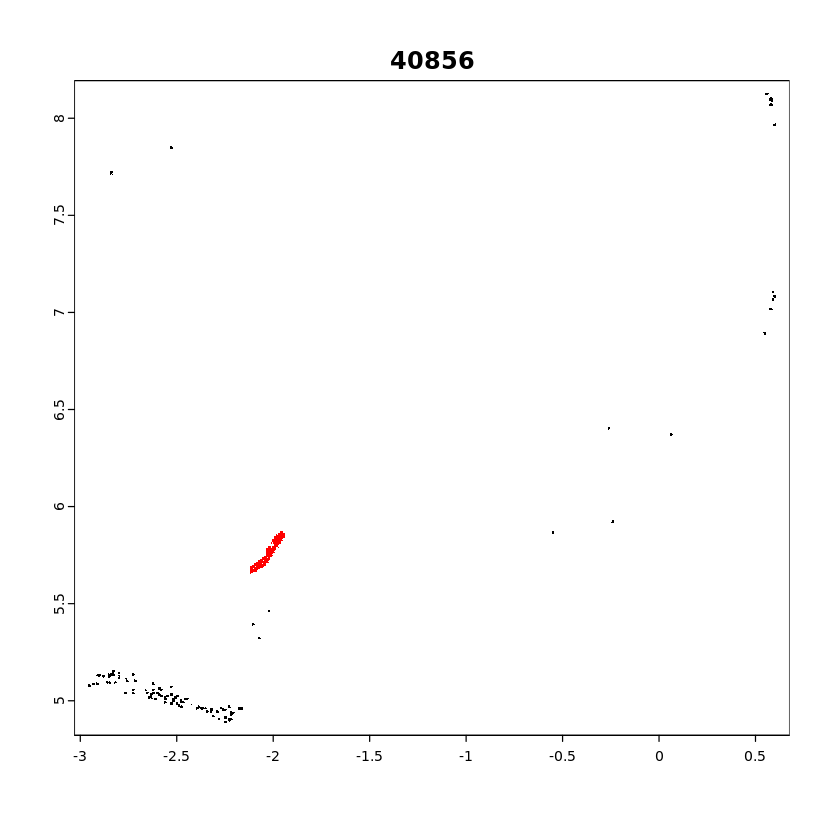

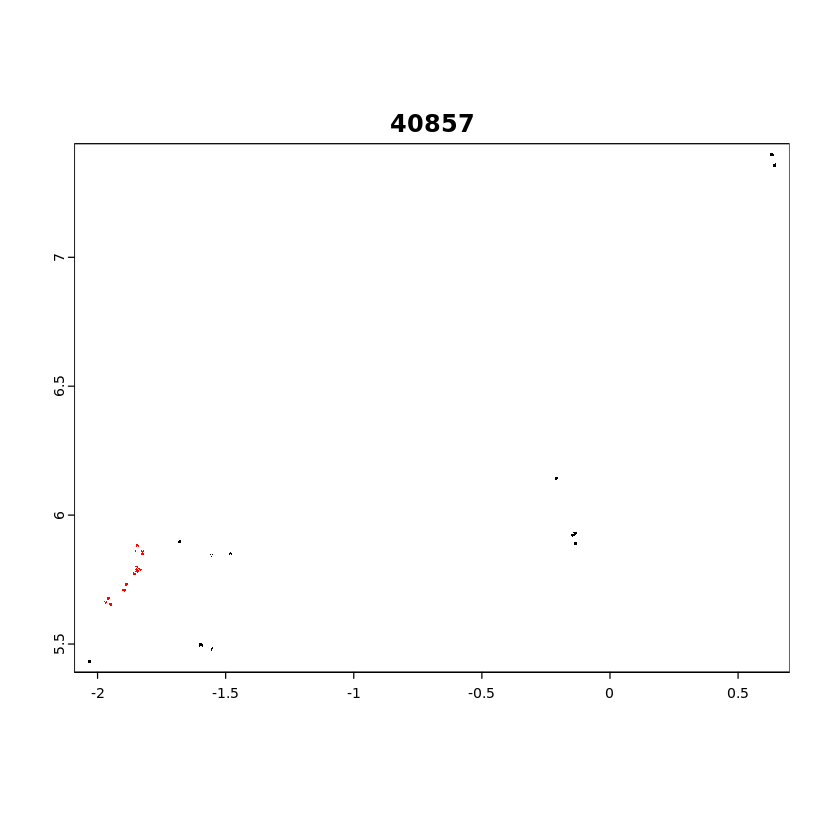

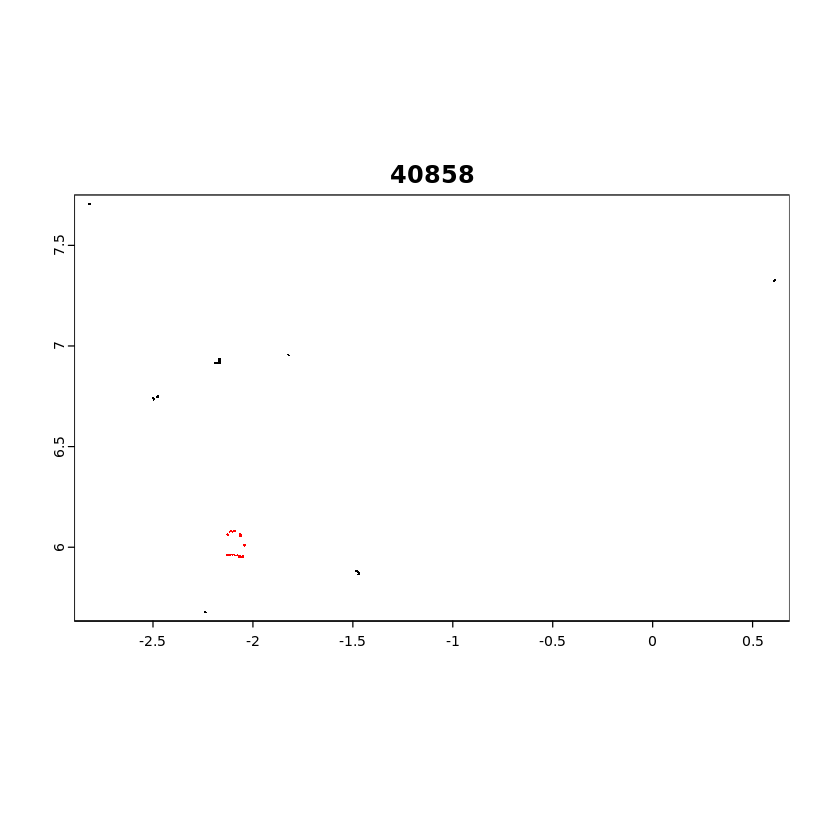

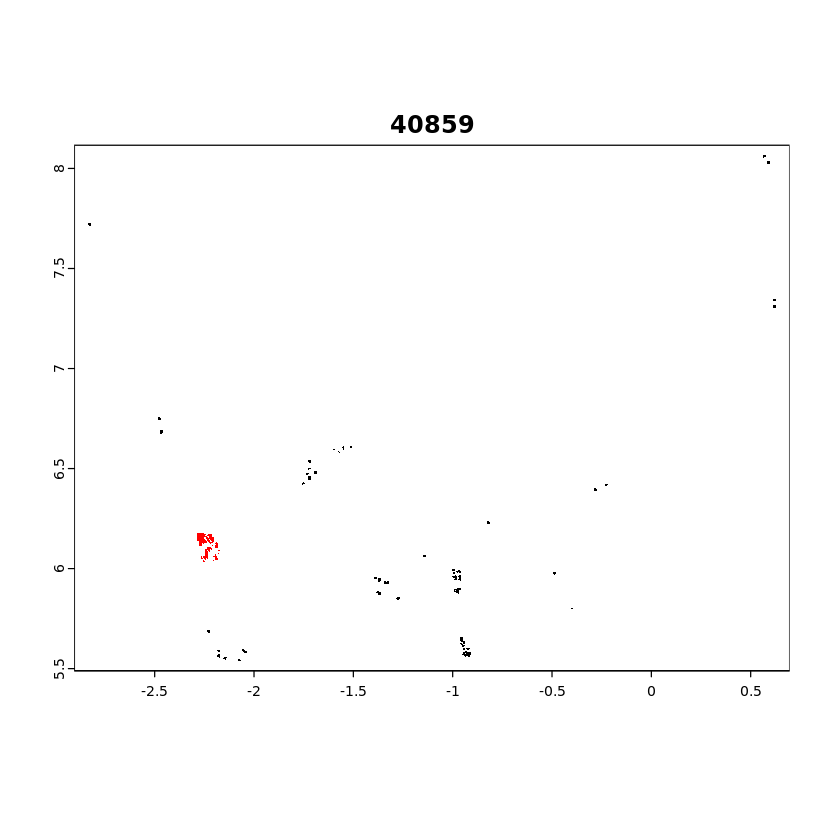

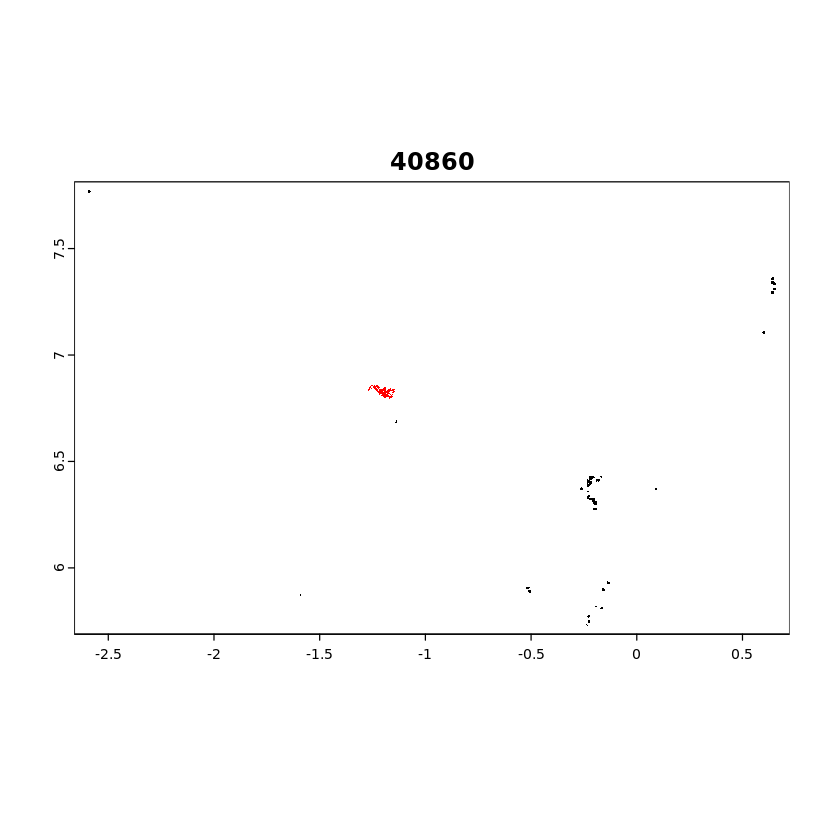

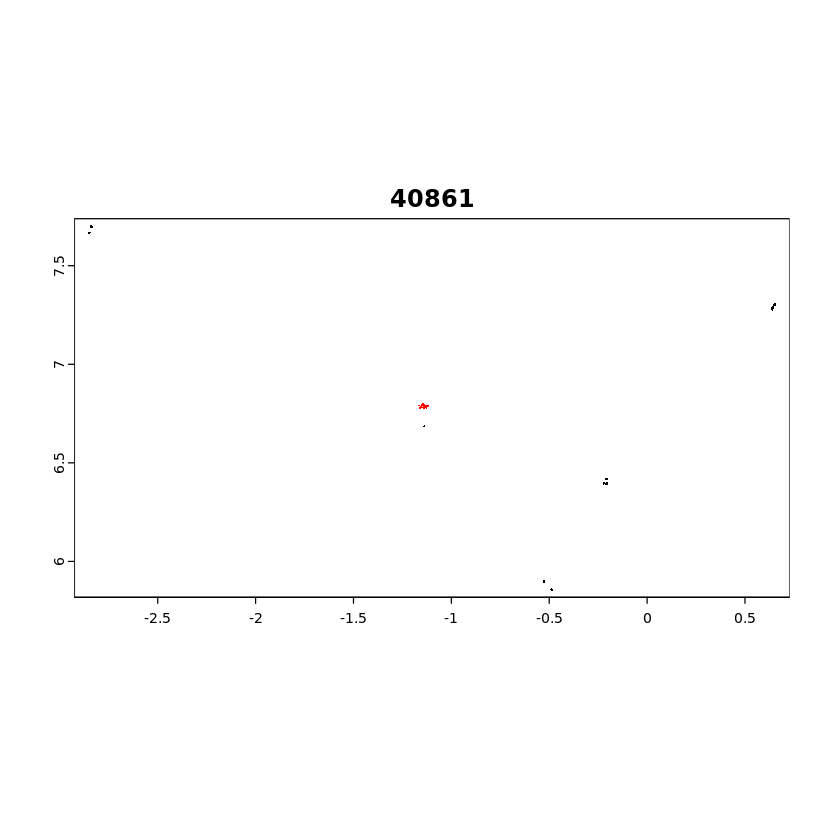

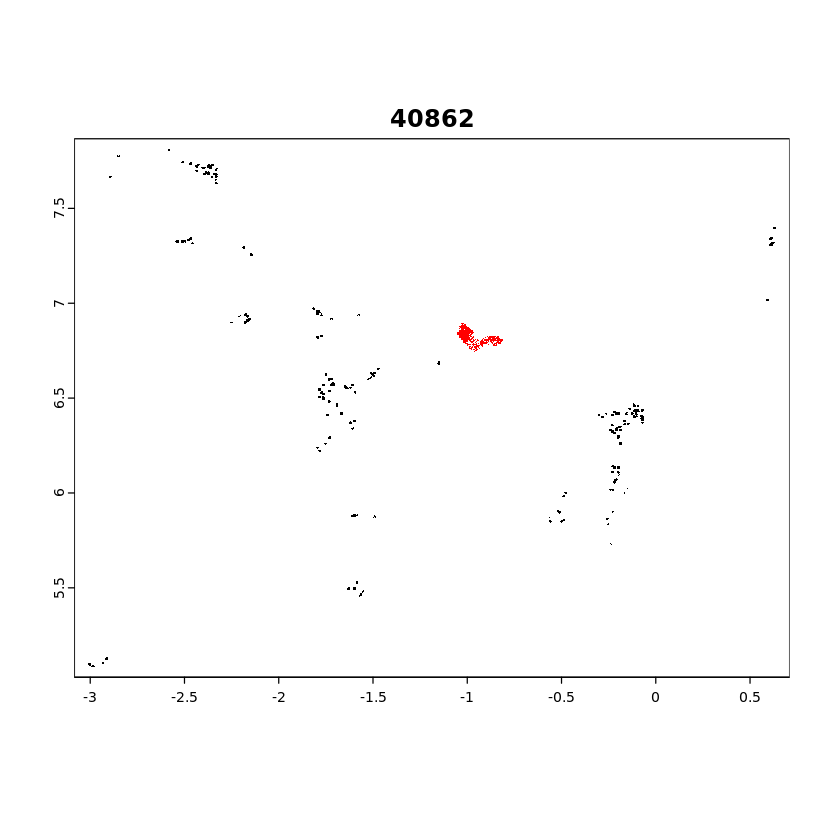

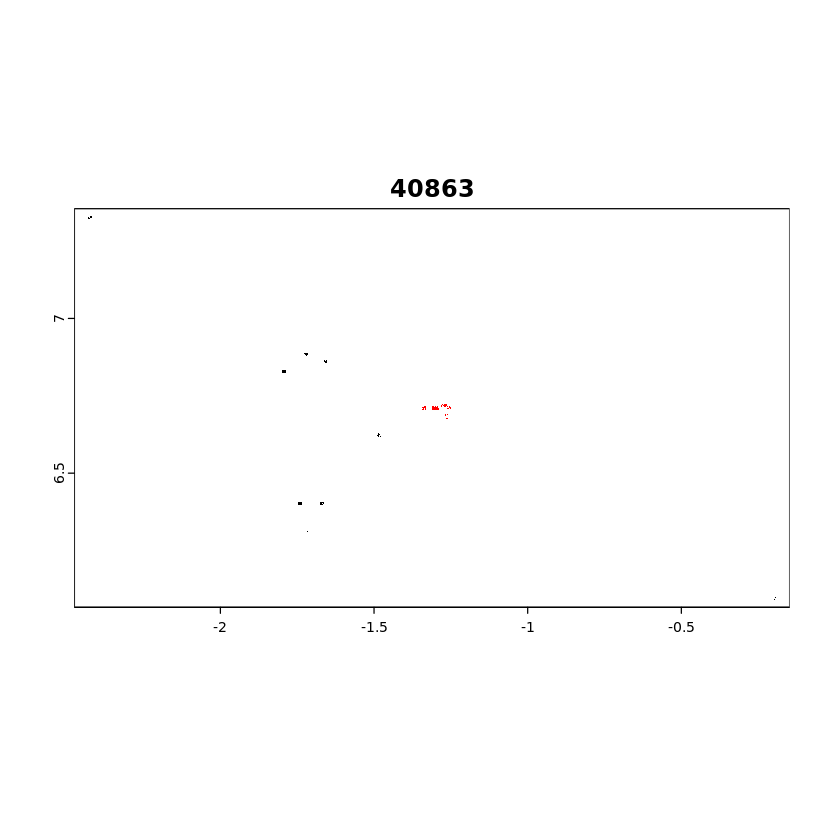

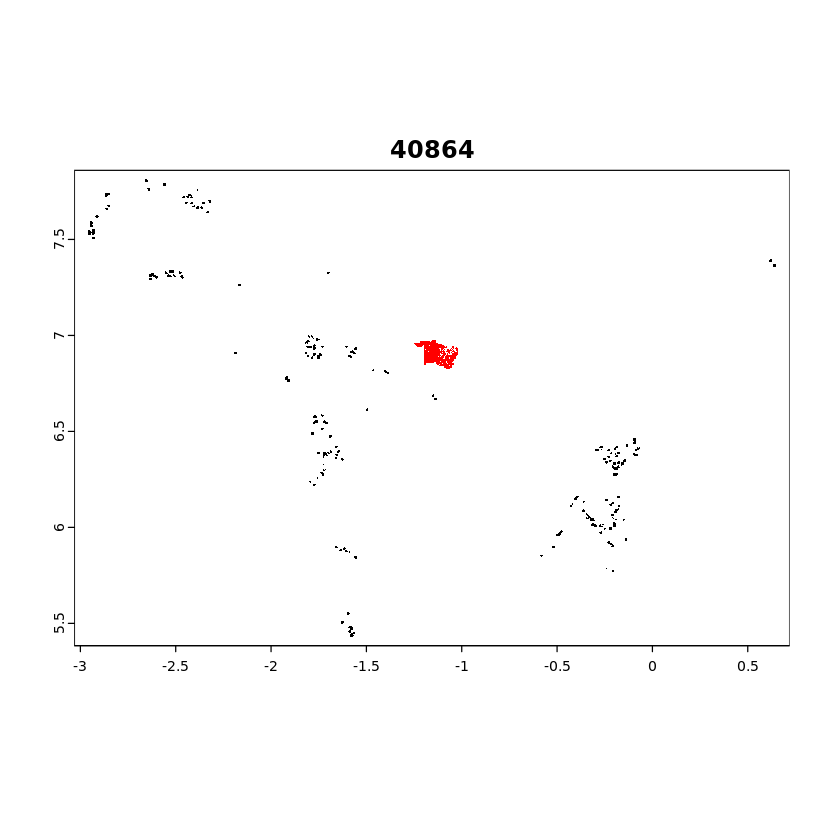

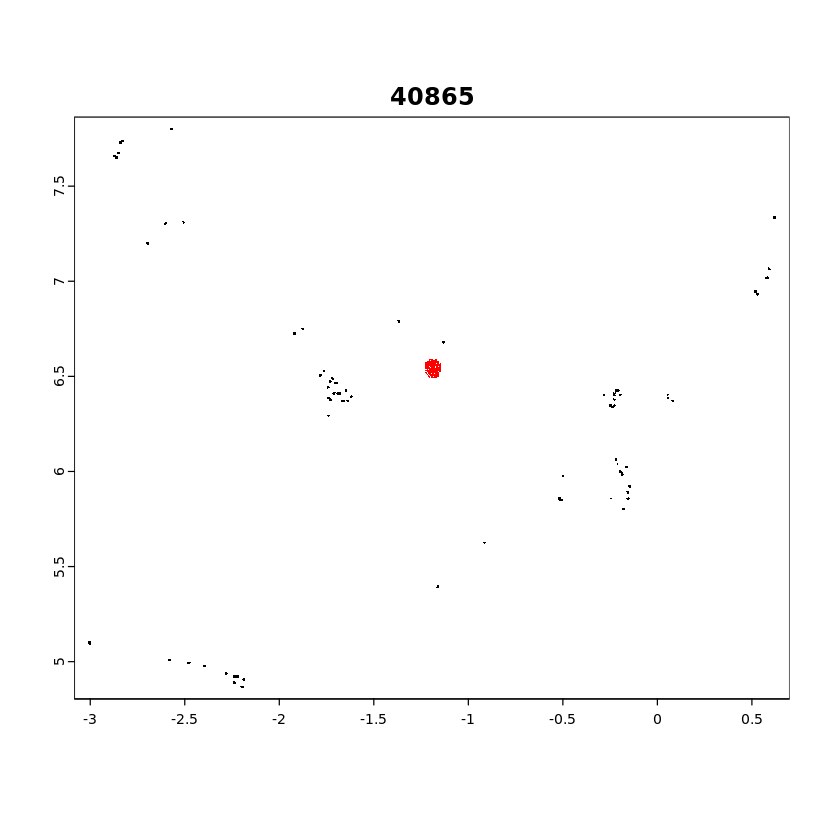

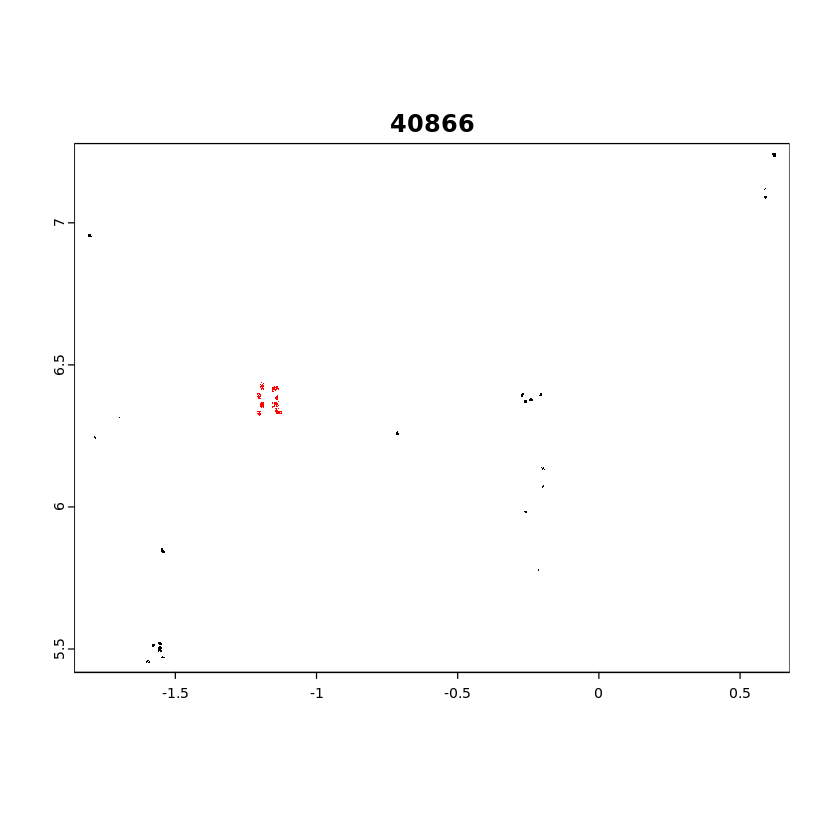

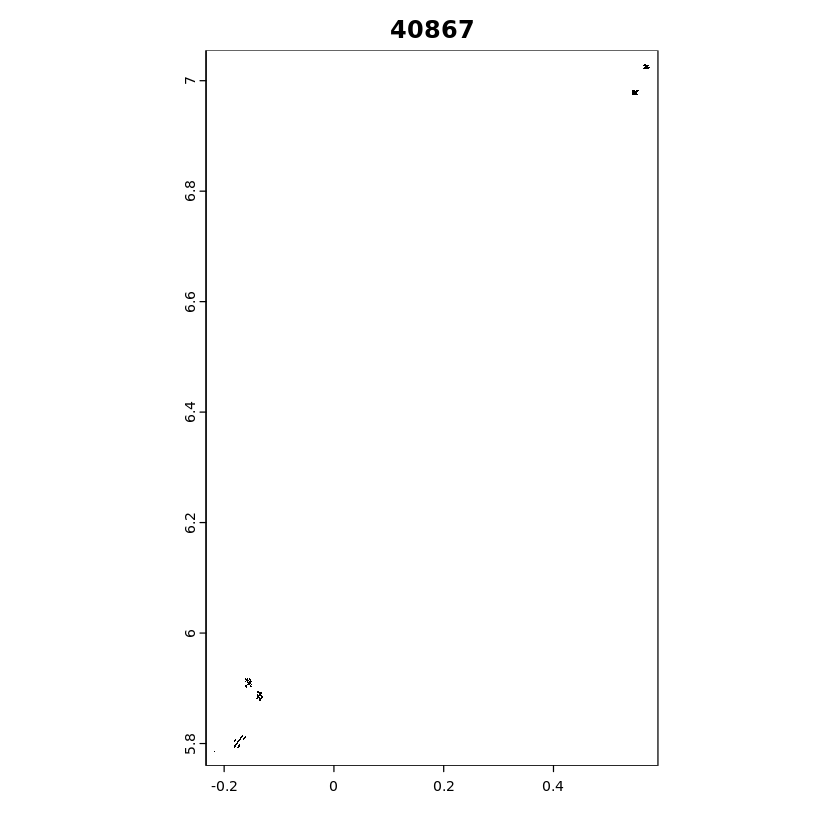

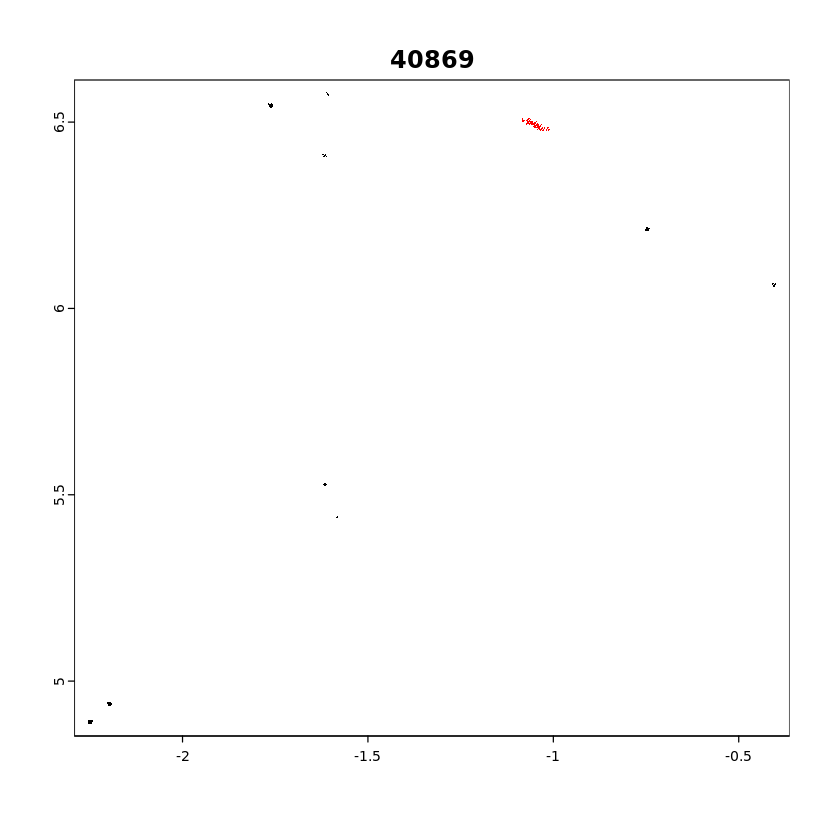

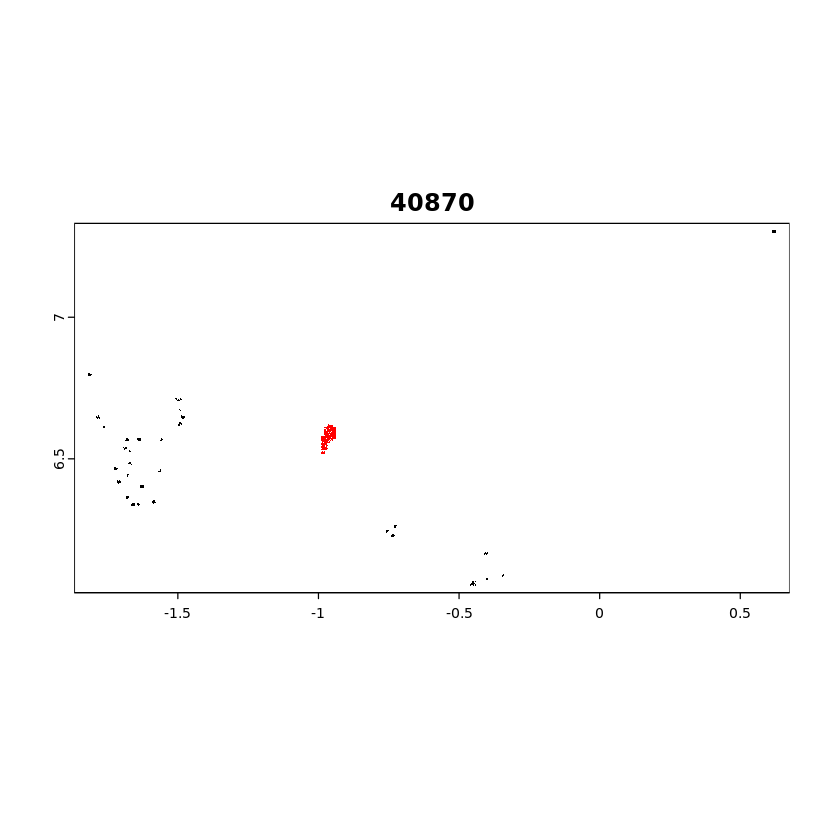

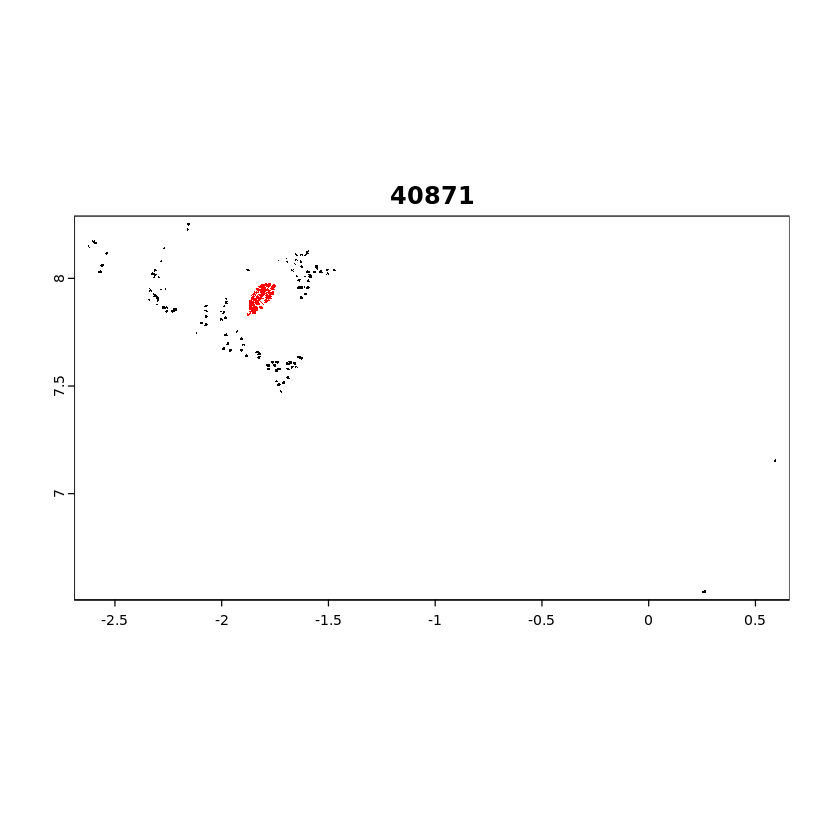

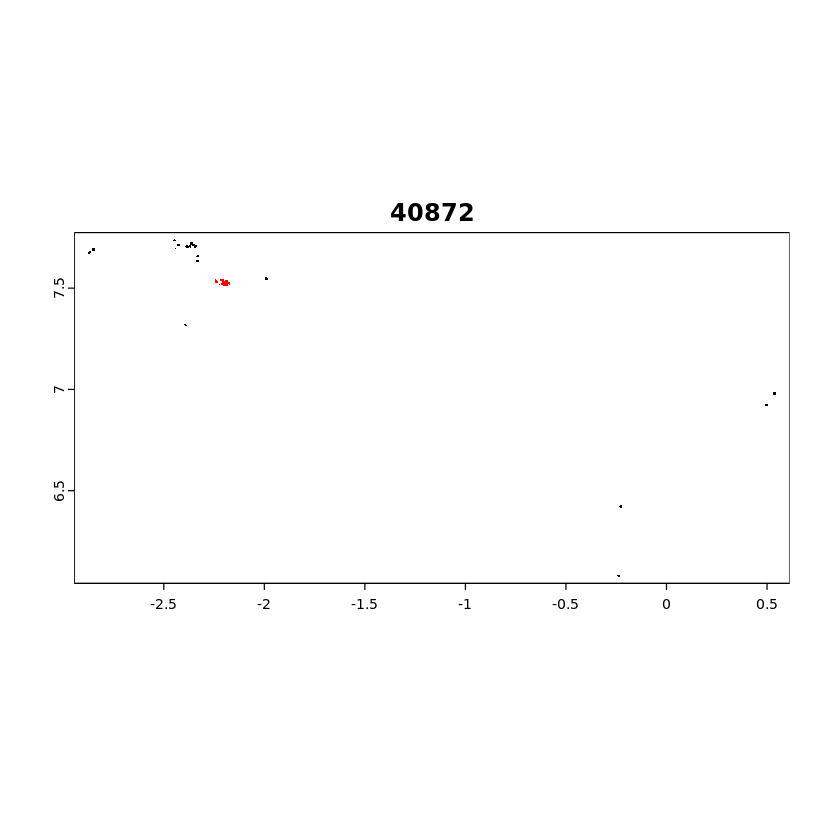

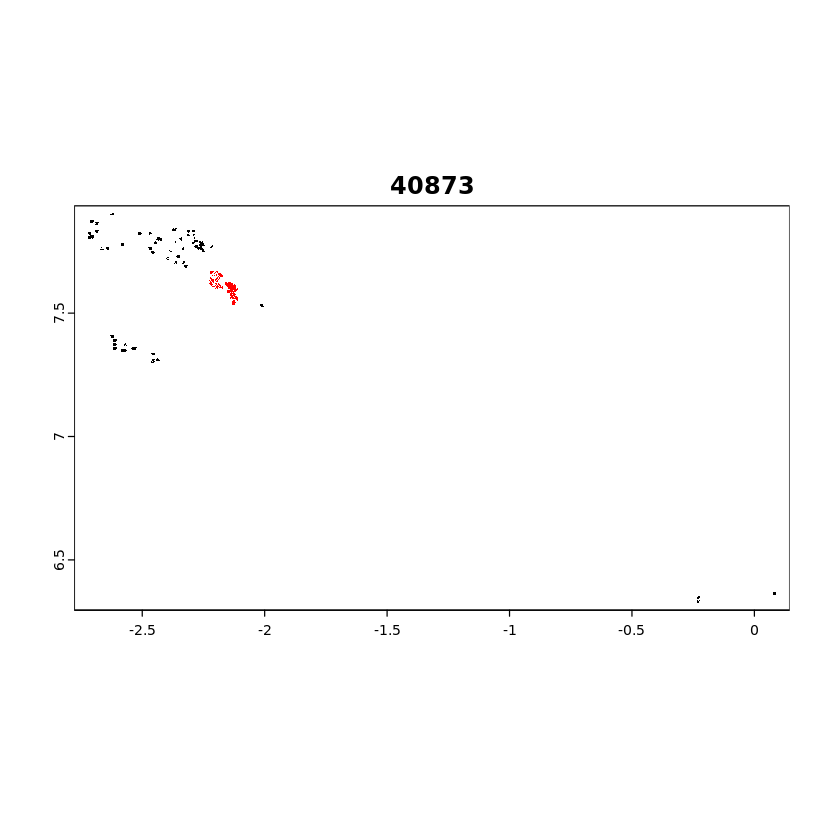

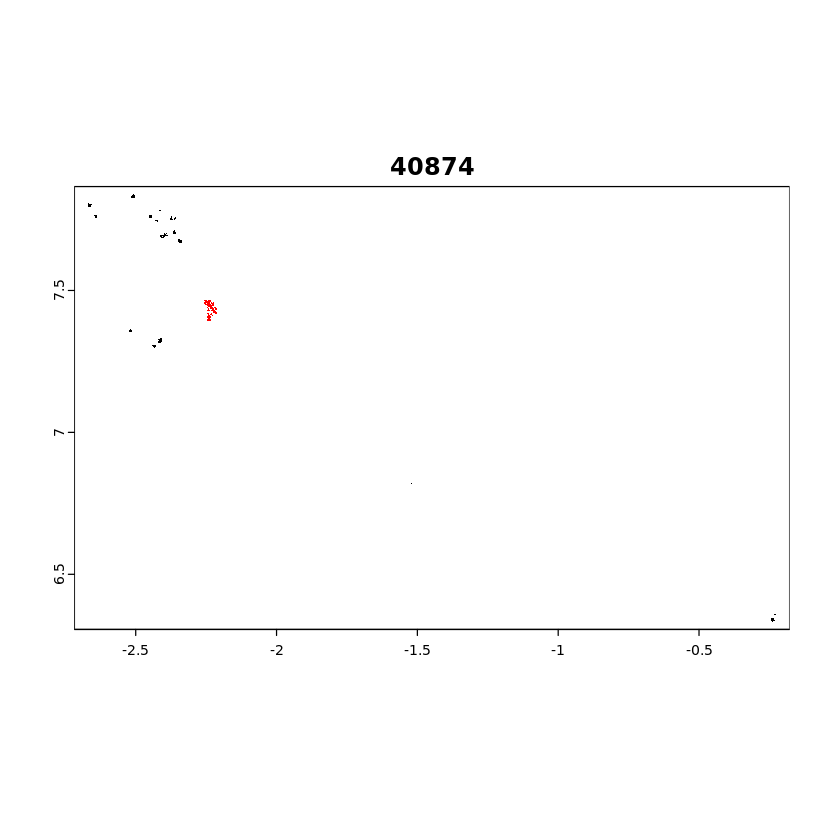

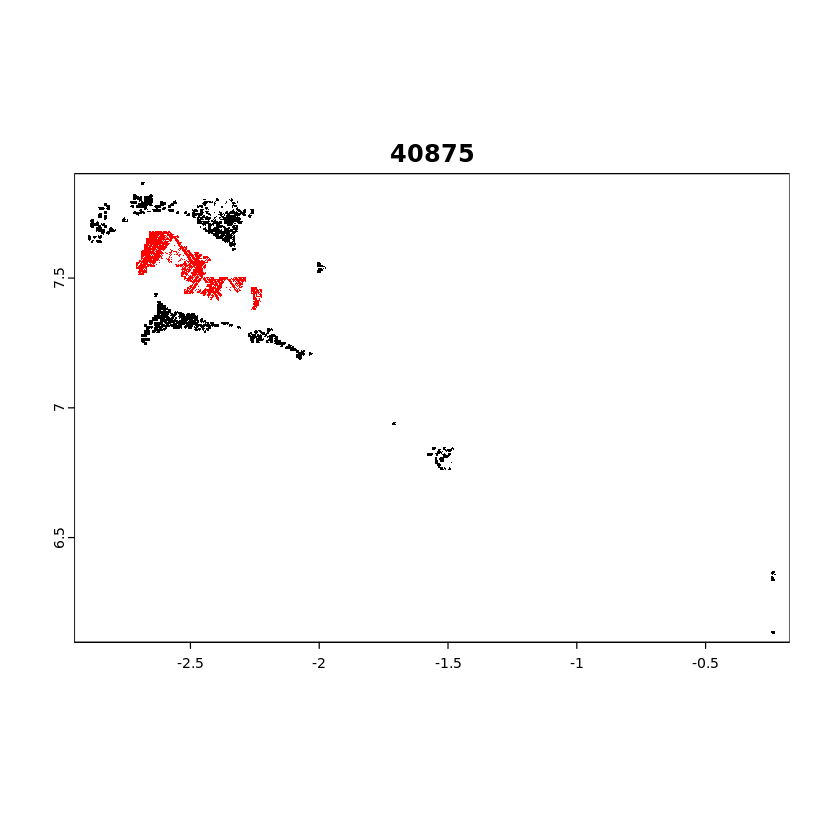

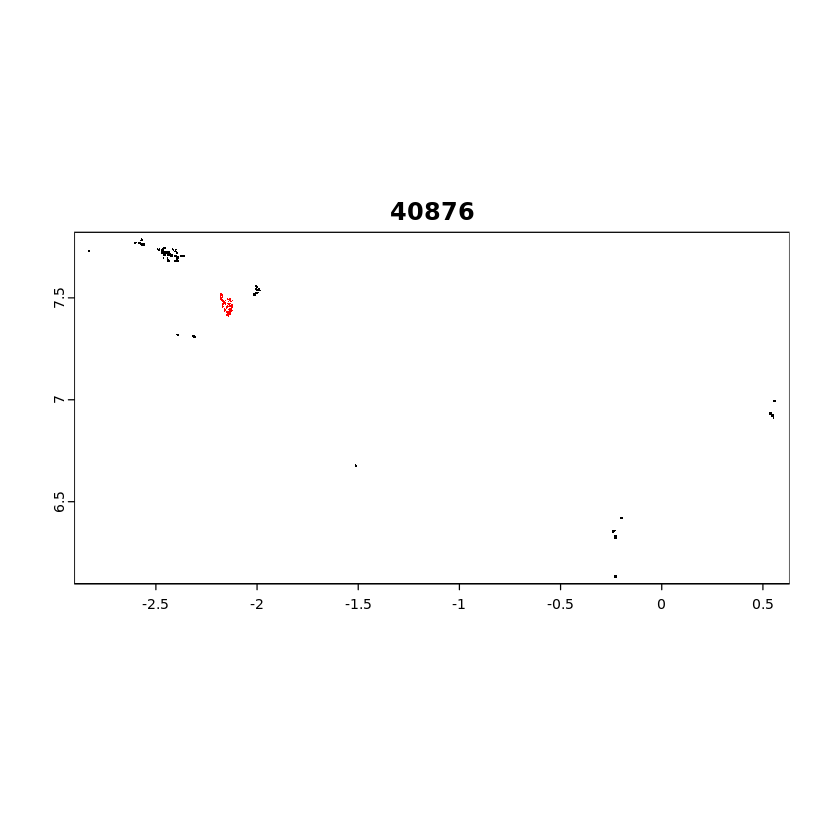

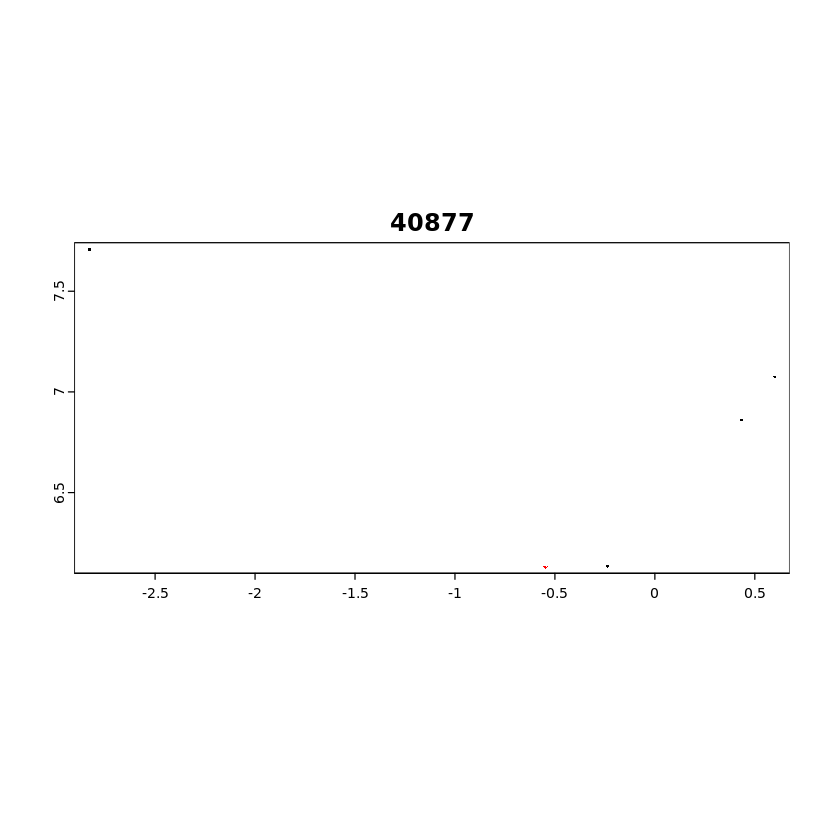

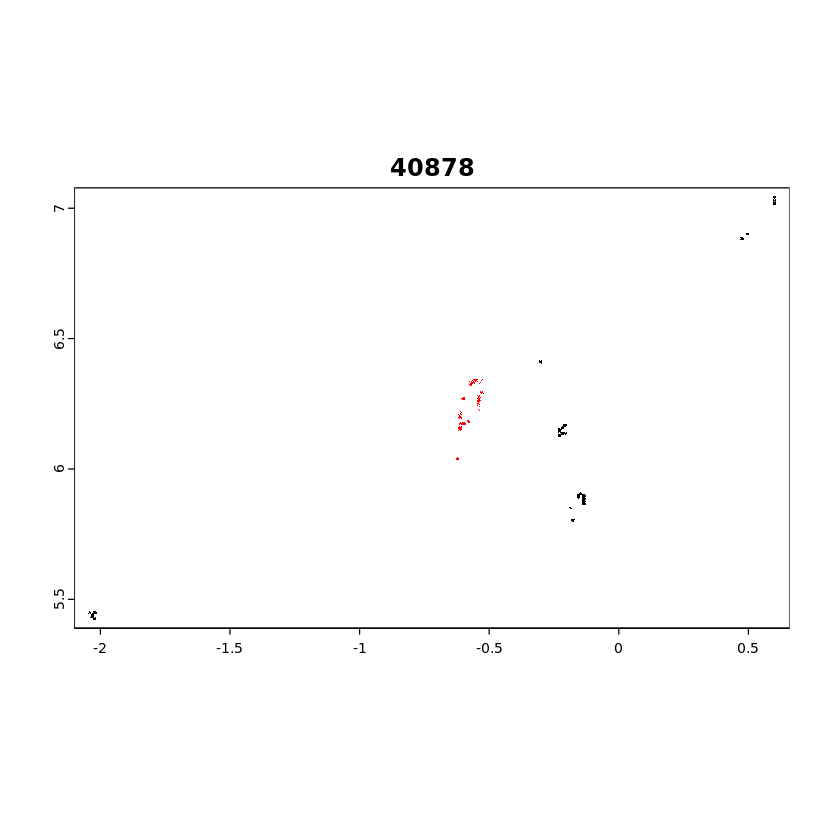

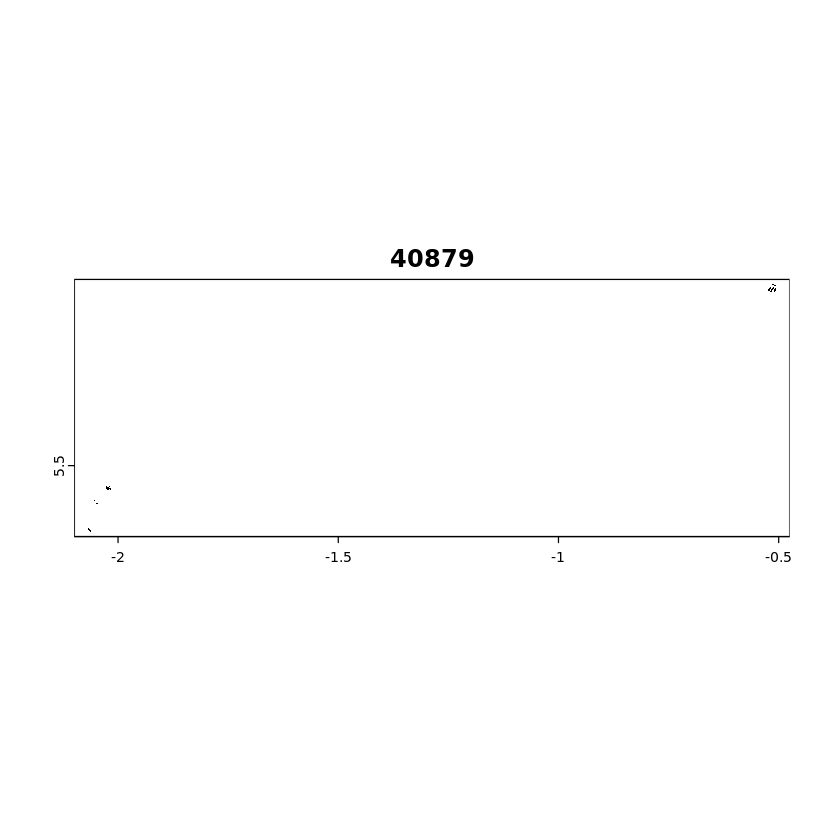

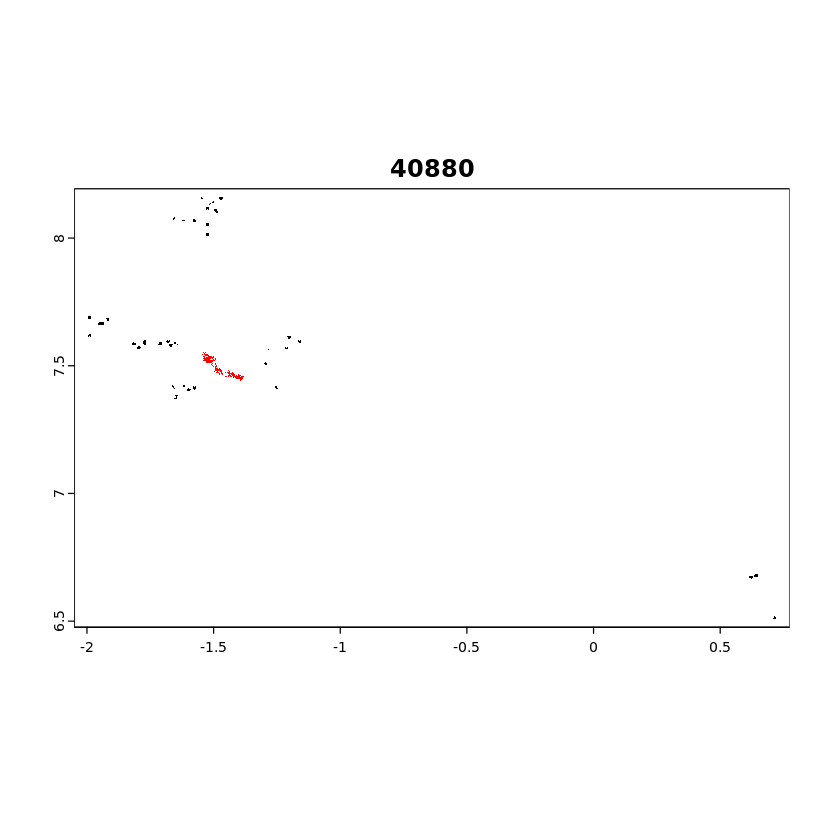

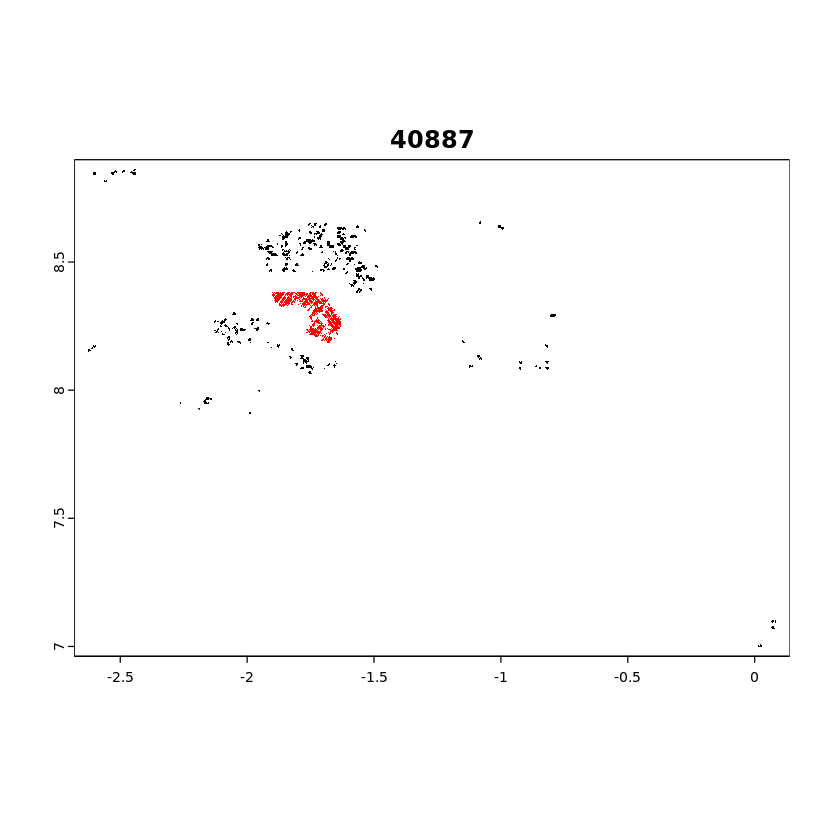

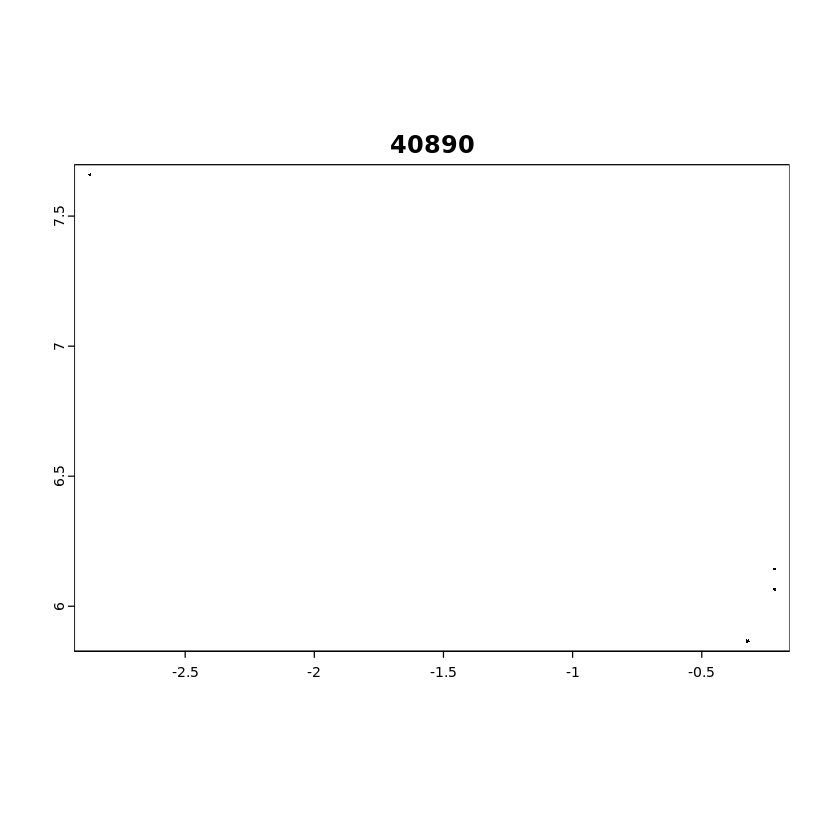

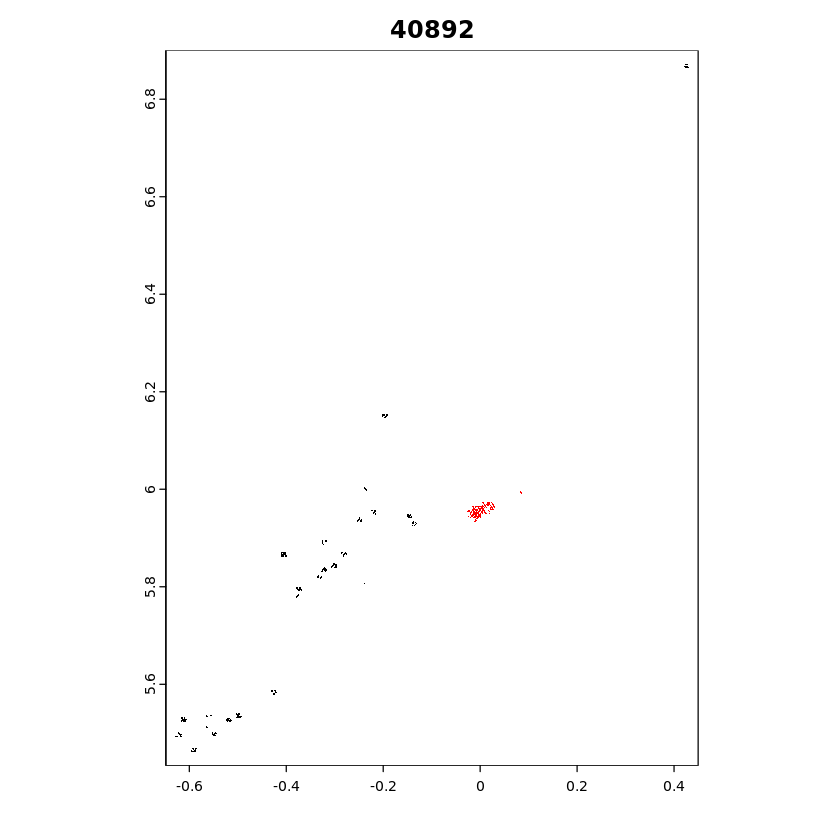

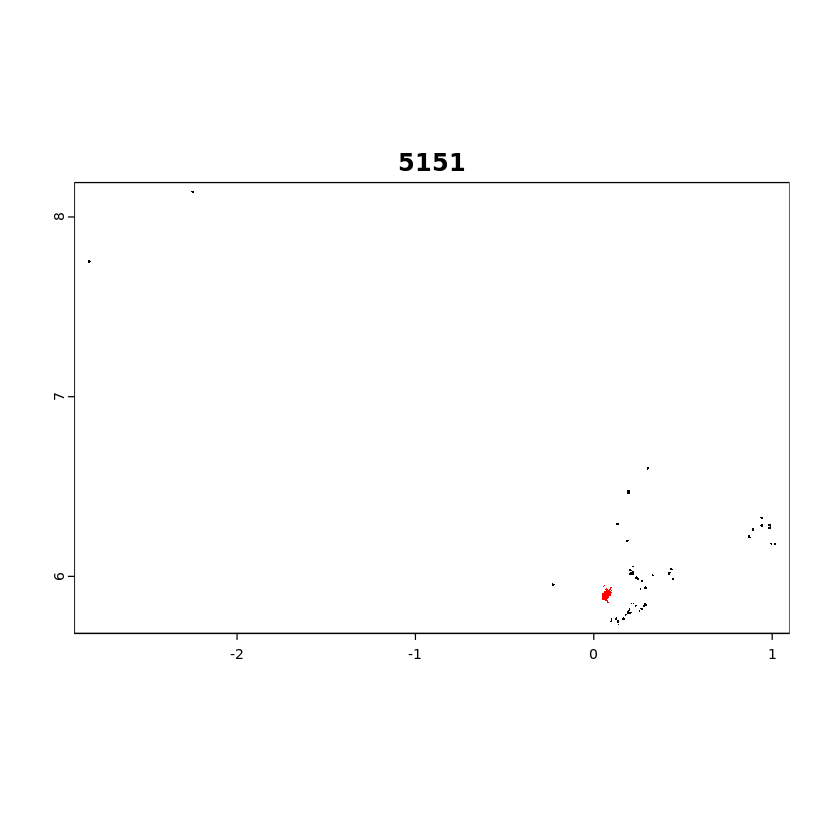

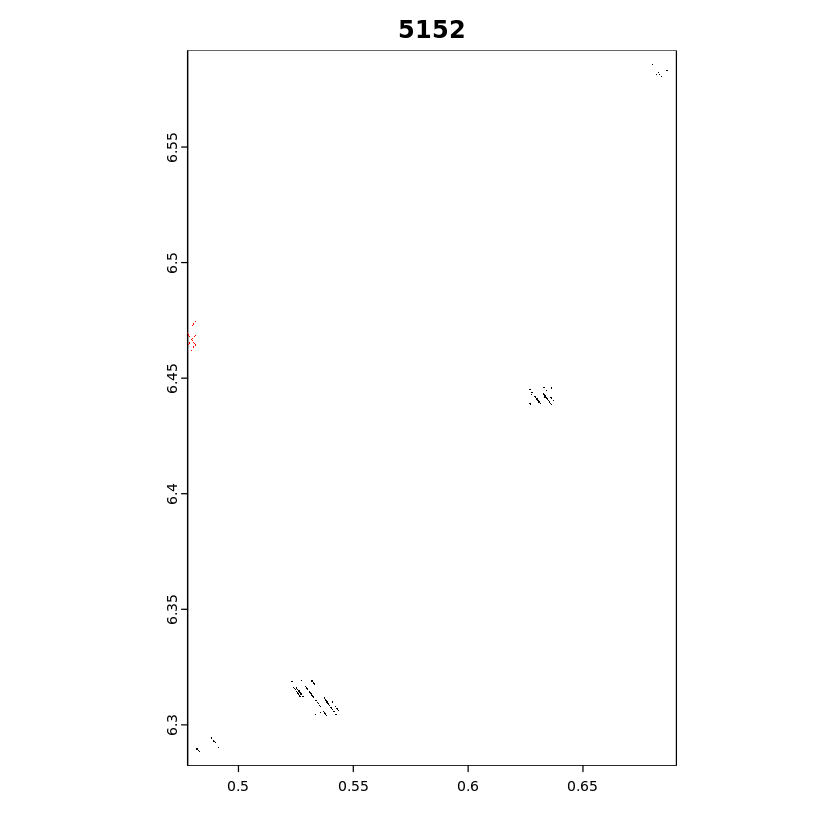

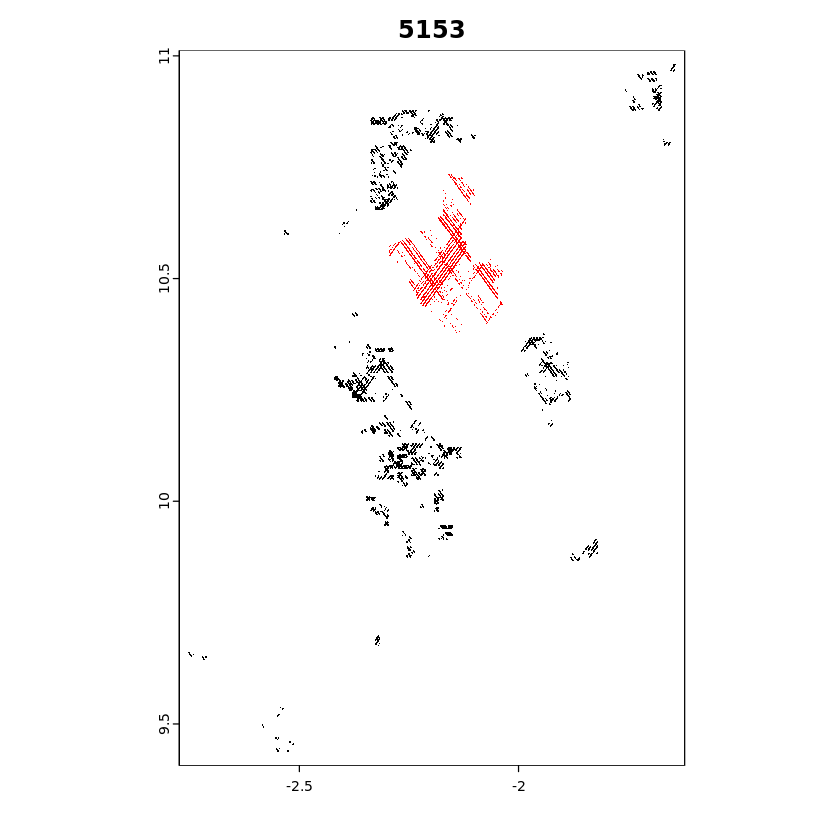

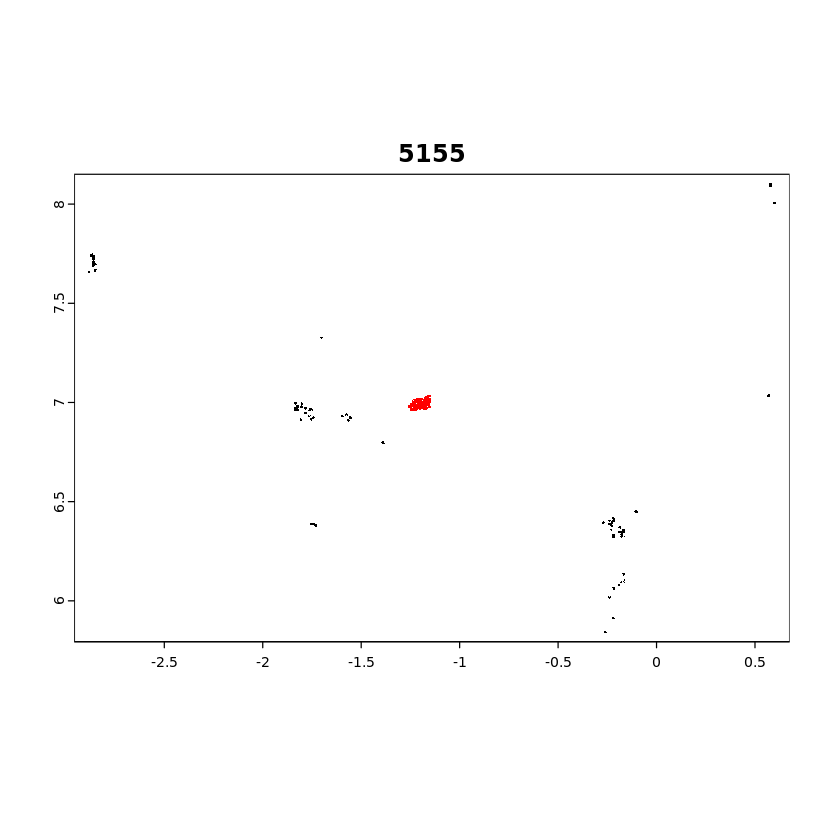

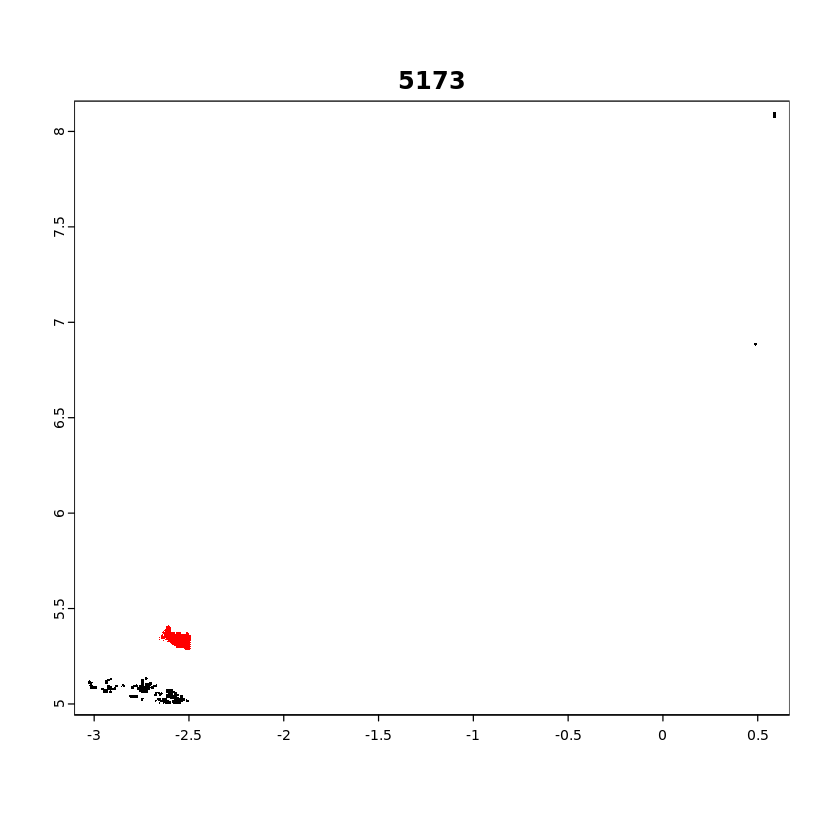

GHA /projects/my-public-bucket/GEDI_global_PA_v2/WDPA_extract/GHA_wk24/GHA_pa_555547583_gedi_wk_24_conti_biome_M.RDS has 0 protected or treatment 


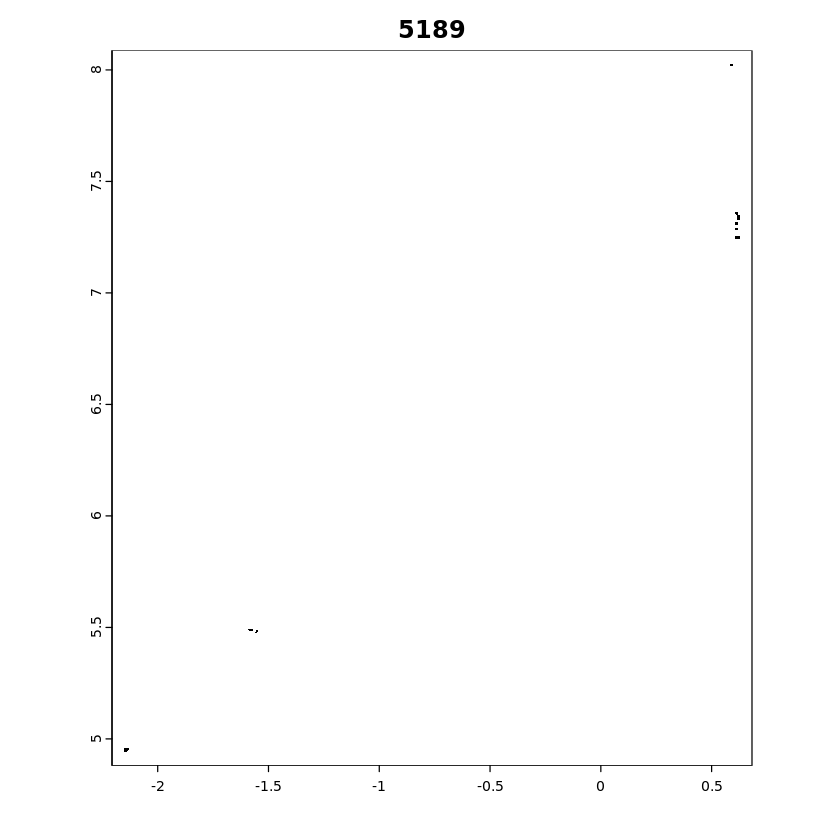

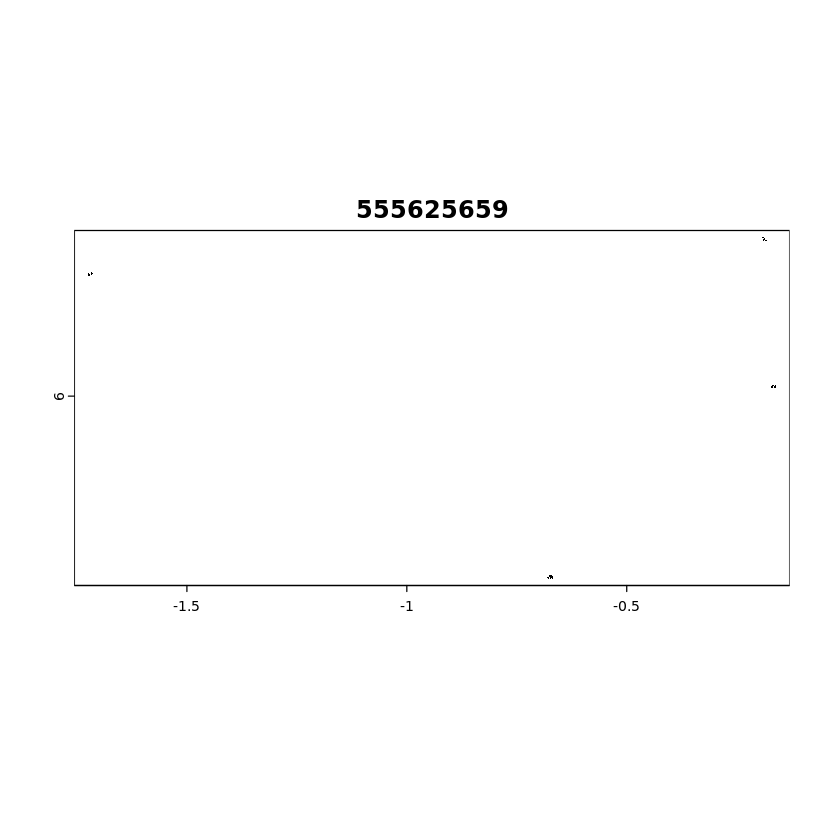

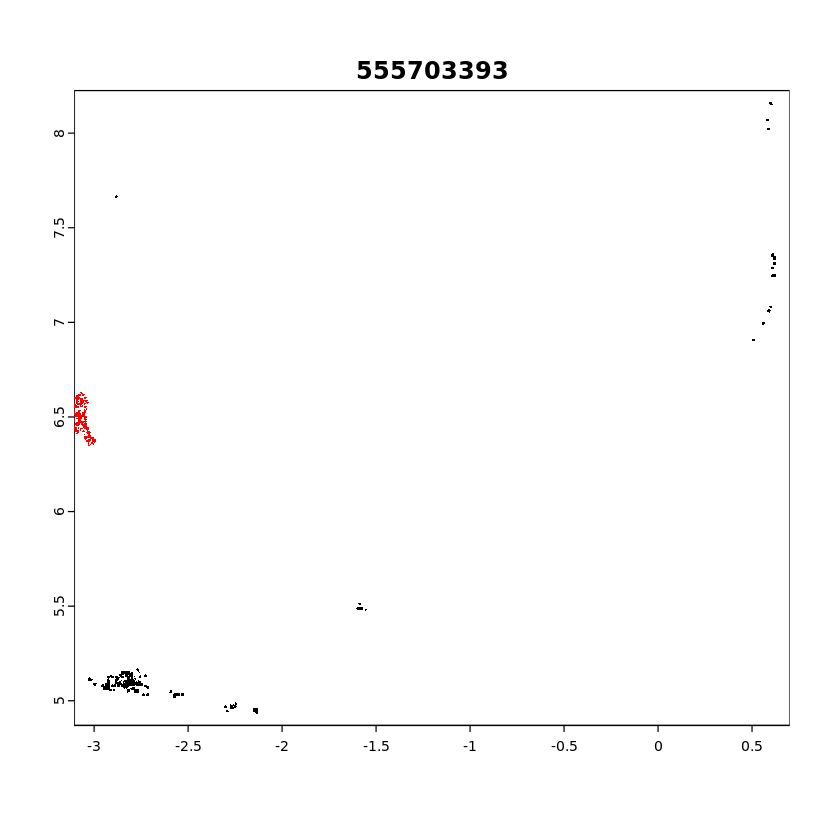

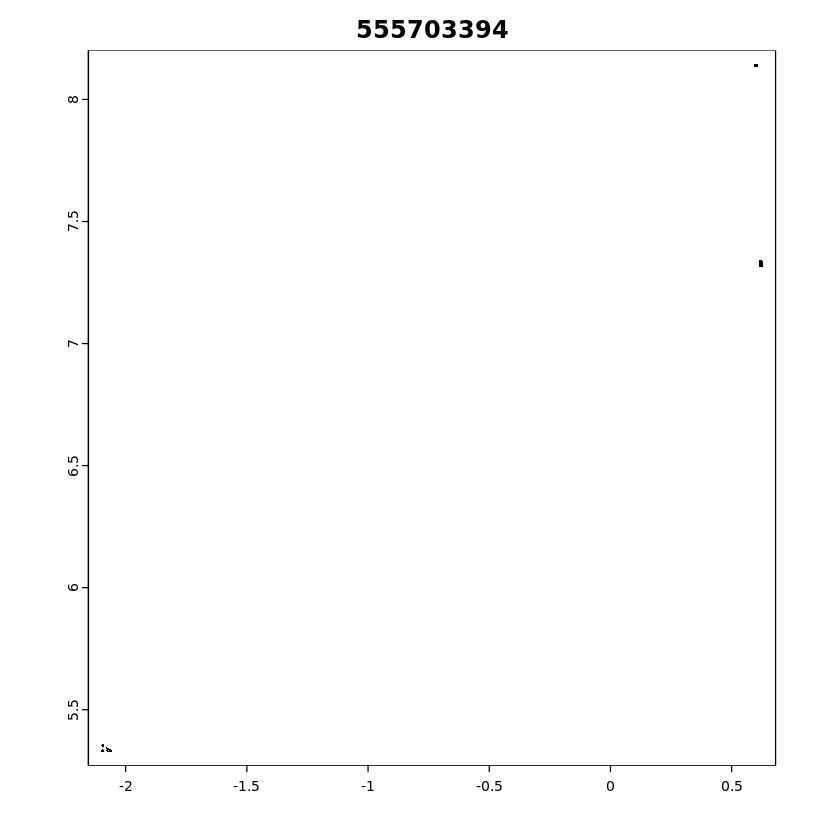

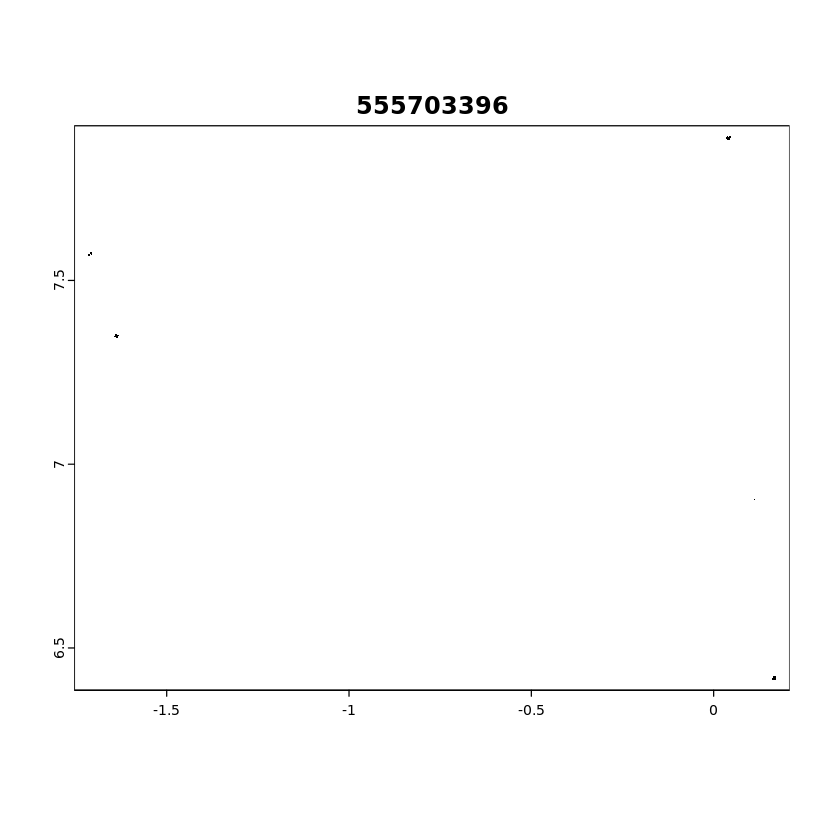

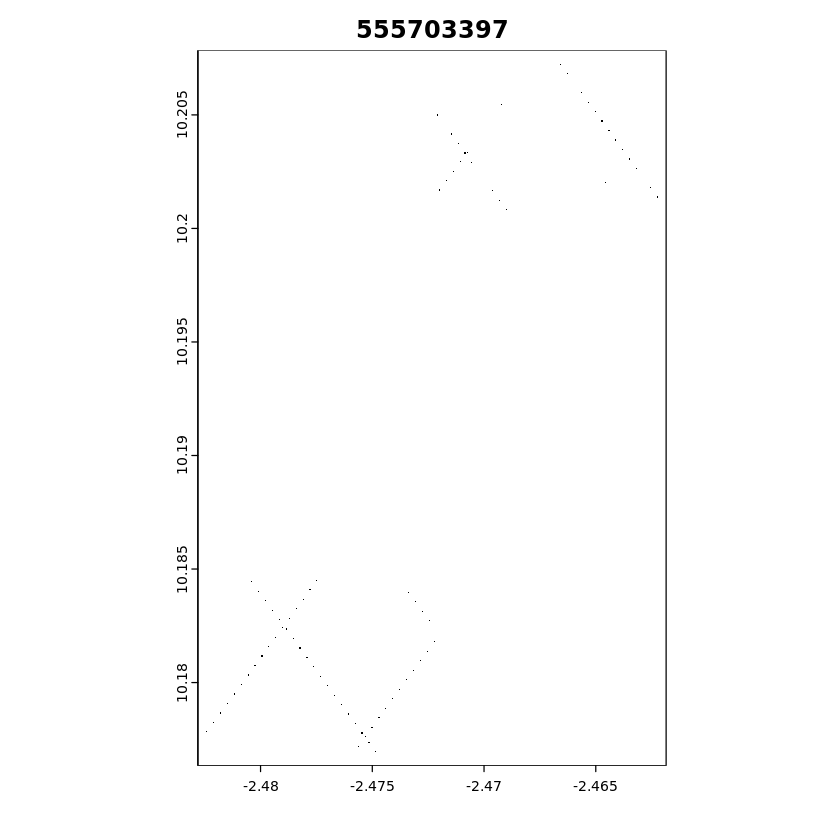

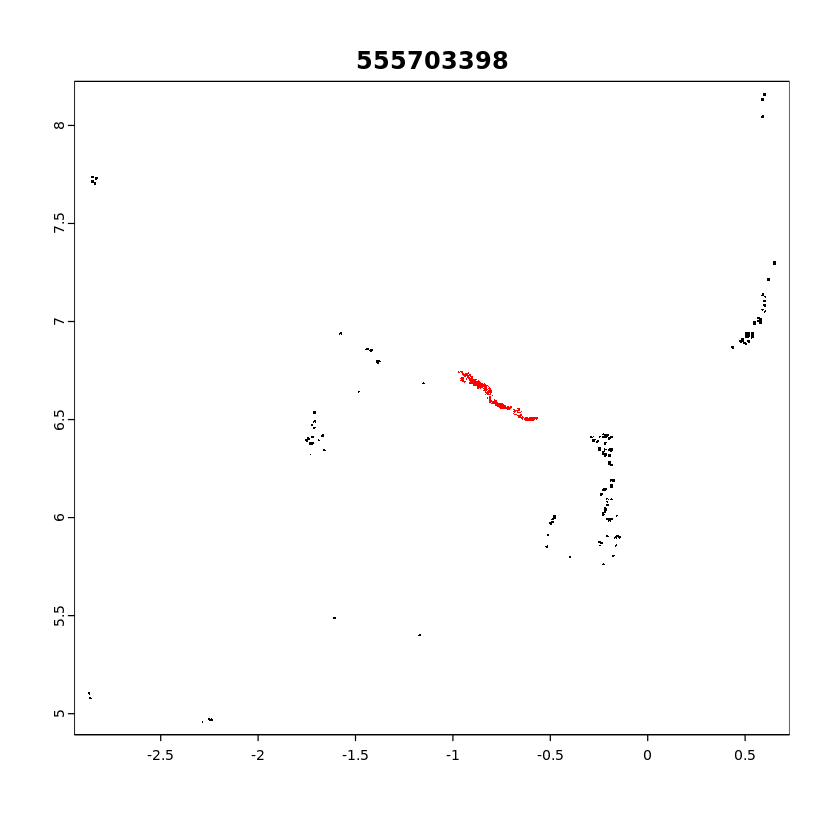

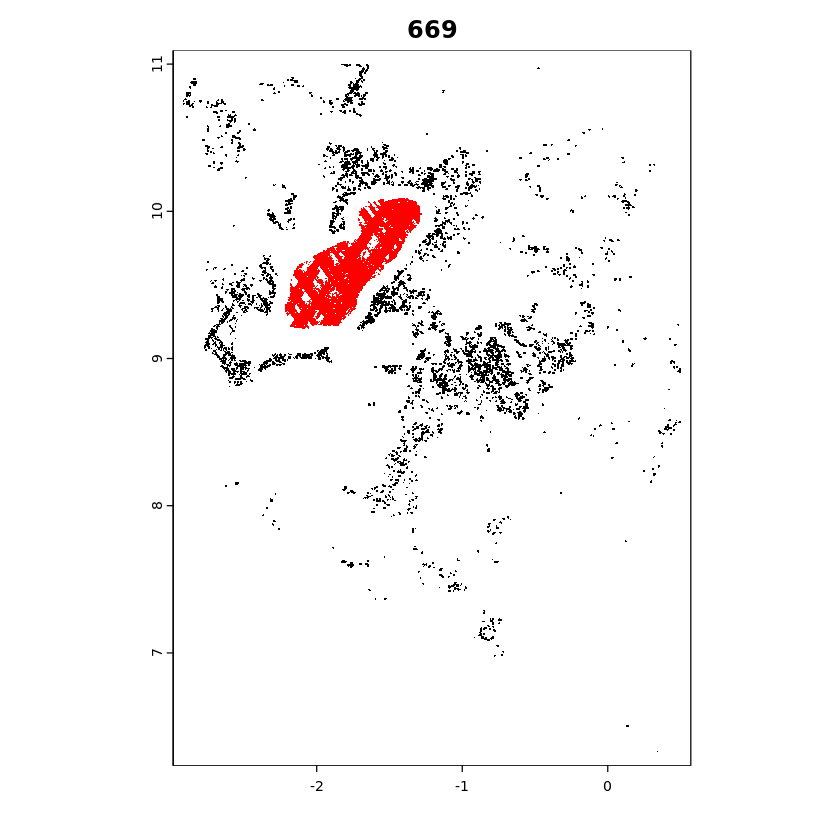

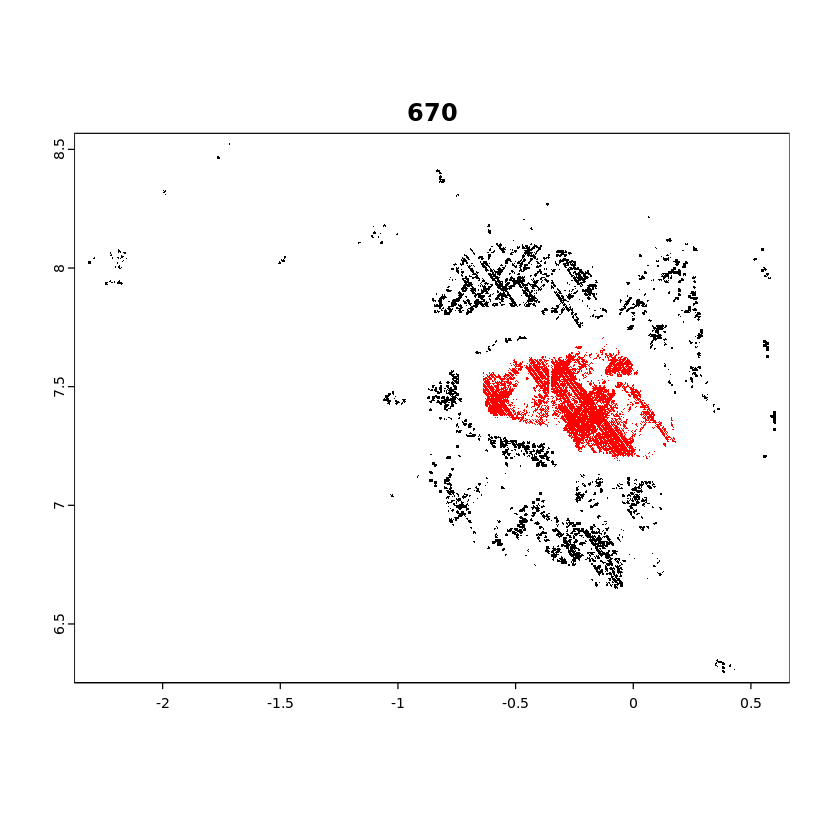

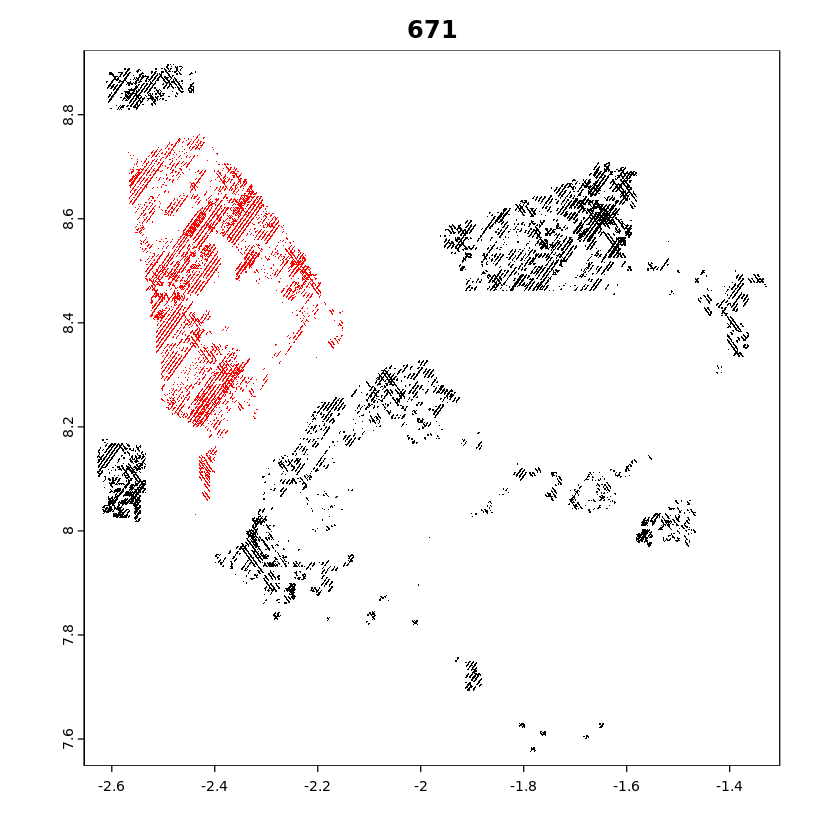

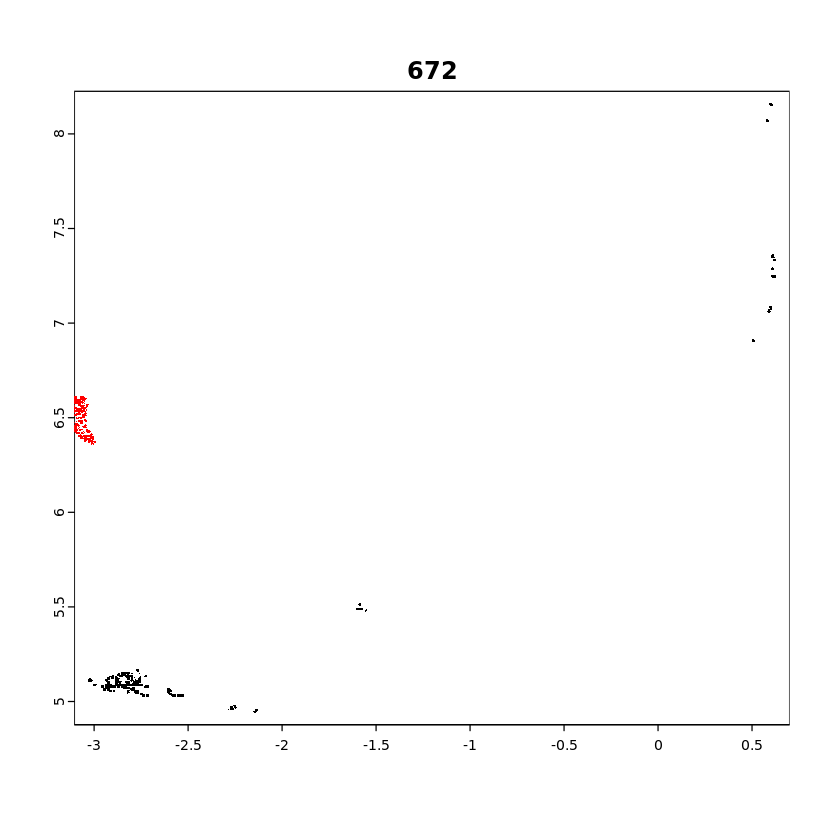

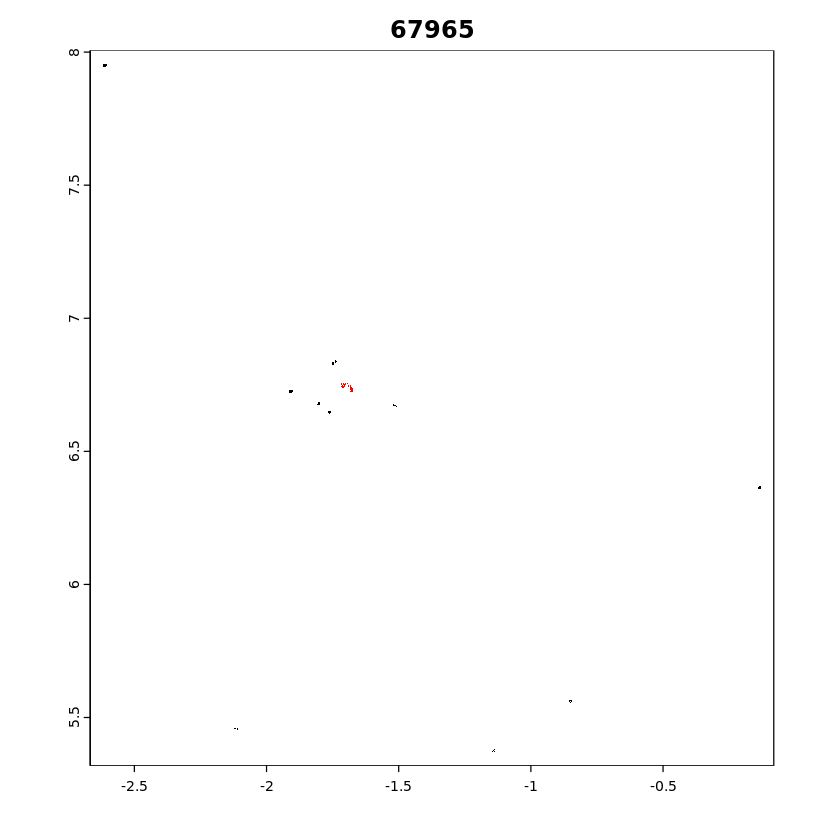

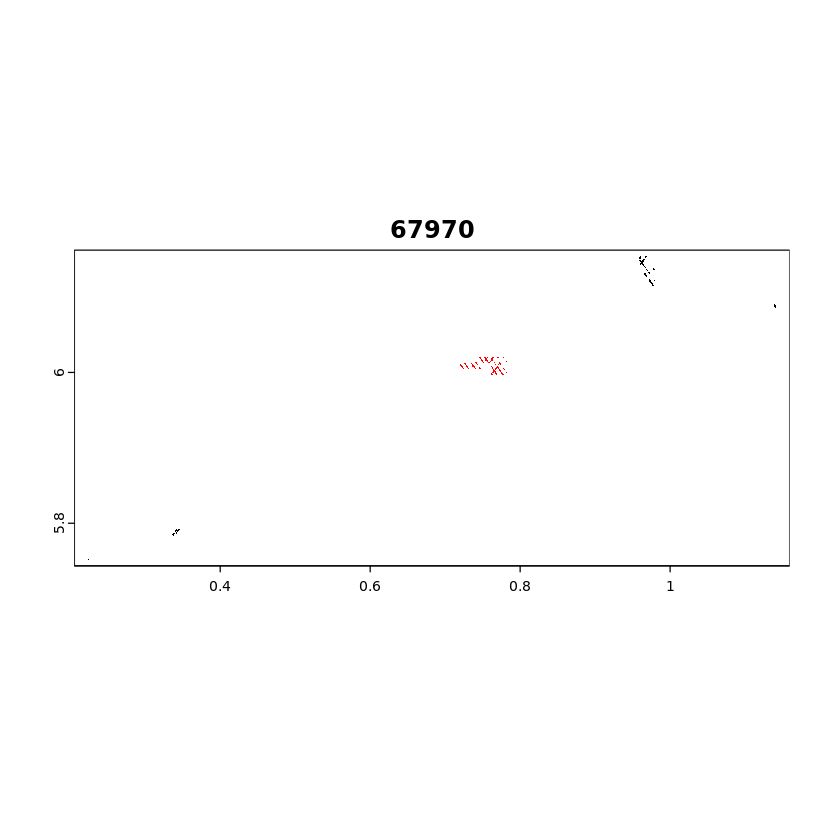

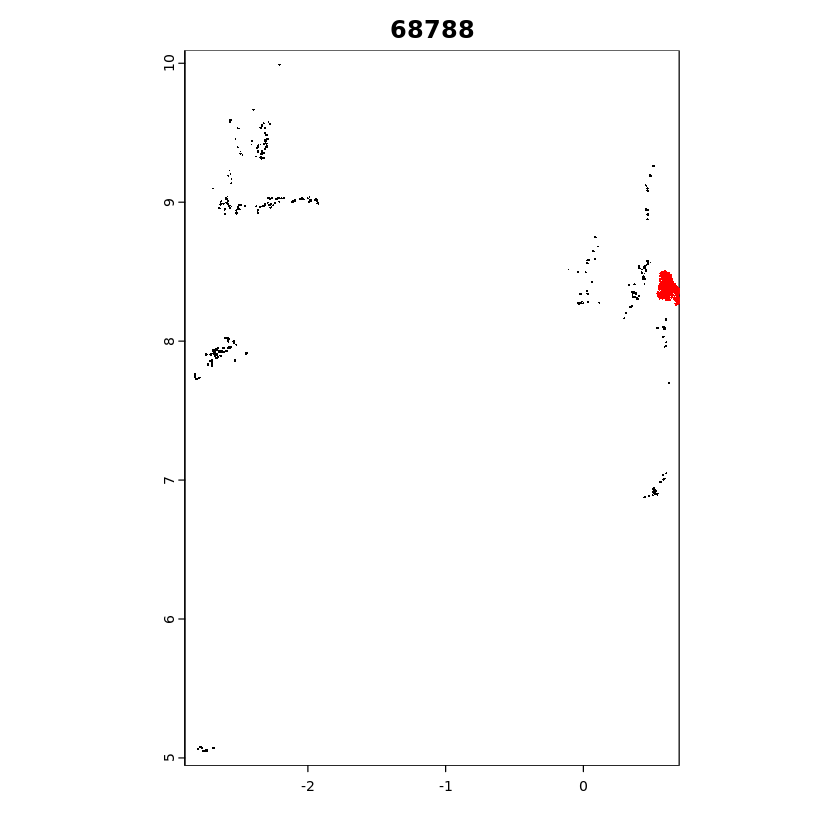

In [6]:
for (this_paf in gedi_paf){
  pa_metrics <- readRDS(this_paf) %>% unique()
  if (length(table(pa_metrics$status))<2) {
    cat(iso3, this_paf, "has 0 protected or treatment \n")
  } else if (table(pa_metrics$status)[1]!=0 && table(pa_metrics$status)[2]!=0) {
#--------
    lon_0 <- pa_metrics[pa_metrics$status==0,"lon_lowestmode"]
    lat_0 <- pa_metrics[pa_metrics$status==0,"lat_lowestmode"]
    lon_1 <- pa_metrics[pa_metrics$status==1,"lon_lowestmode"]
    lat_1 <- pa_metrics[pa_metrics$status==1,"lat_lowestmode"]
    
    plot(vect(cbind(lon_0,lat_0), type="points", atts=NULL), pch=".", main=unique(pa_metrics$pa_id))
    points(vect(cbind(lon_1,lat_1), type="points", atts=NULL), pch=".", col="red")
#--------
    }
}      
